<a href="https://colab.research.google.com/github/nielsleadholm/CNN_Binding/blob/master/BoundaryAttack_vs_MadryMethod%26BindingCNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Boundary Attack vs Madry Method and Binding-CNNs

Implement the Boundary attack method (Brendel et al, 2018) against the Madry et al (2017) method of adversarial resistance, then explore novel neural network architectures for greater adversarial resistance.


##Background/Introduction

###What are adversarial examples?

In recent years machine learning systems have significantly improved their performance on challenging tasks such as object recognition. Despite achieving near human-level performance on many of these problems, it has been realised that state-of-the-art machine learning systems such as deep neural networks are susceptible to subtle changes in the input space that would otherwise not be considered sufficient to change the true class of an item. For example, in the domain of vision, slight adjustments in pixel intensity that are imperceptible to humans can result in catastrophic misclassification by an otherwise well-performing model.

These engineered stimuli that fool the network are known as 'adversarial examples', and their generation as 'adversarial attacks'. Worryingly, adversarial examples have been found in multiple domain (such as audio and natural-language processing), function 'in the wild' (e.g. via video-feeds), and are known to generalize across machine learning systems.

###What are black box attacks, and what is the Boundary Attack?

The earliest methods for developing adversarial examples relied in detailed information about the network being attacked: specficially, how the gradient of the loss function relates to the input space. This enables calculated adjustments of the input domain so as to create an example that will be misclassified. Such methods are known as 'white box attacks' due to their intimate knowledge of the network.

Other methods enable attacks to be mounted with little information about the target, known as 'black box attacks'. A particularly powerful form of this is known as the Boundary Attack. Intuitively, the idea is to begin by adding a noise mask to the input such that it is misclassified. The L-2 (Euclidian) distance of this new image to the original is then iteratively reduced by minimizing the intensity of the pixel changes while ensuring the example remains adversarial. Eventually, a local minimum is found of an adversarial example which (ideally) is perceived to have been minimally changed to a human observer. Such an attack can in theory be implemented against networks regardless of their architecture (e.g. whether it is differentiable).

###What is the Madry et al method for adversarial resistance?

The Madry et al method is a process of training a machine learning classifier so as to be resistant to adversarial examples. To begin, an exhaustive search is performed for adversarial examples using a gradient-based attack. This search is constrained such that the l-infinite (Chebyshev) distance between the original and adversarial image is below a given threshold. A sufficiently large/complex model is then trained on both the original examples and these generated adversarial examples so as to maximize correct classification. The claim is that there is a degree of guarentee on the resistance of the network, at least within the bounds of input perturbation allowed by the earlier search method.

###What makes the following work novel or interesting?

####Part 1

My first prediction after reading about the Boundary Attack and the Madry et al method was that, as the Madry's search of adversarial examples is performed by a gradient based (white box) method, the Boundary attack might be able to find local minima that escaped this earlier search, and thus that the Madry method might be more vulnerable to l-2 (Euclidian) metric attacks than stated in the original paper. After beginning work on exploring this, I discovered that a later paper by the Boundary Attack authors had indeed confirmed this, and so the following begins with a simple replication of this result. 

####Part 2

My own research is currently focused on how the human brain encodes visual information in ways that are much richer and more complex that current deep learning systems, and how this might explain the curious existence of adversarial examples. In order to explore whether a network implementing these representations is more resistant, I first begin by developing and training a simple convolutional neural network based on the classic LeNet-5 architecture, using the MNIST hand-written characters dataset. As the steps for applying FoolBox methods such as the Boundary Attack against custom models implemented in TensorFlow's low-level API is different from pre-trained models such as ResNet-50 or the Madry network, I first demonstrate an attack against this network.

I then define and train a convolutional neural network on MNIST with a proposed change so as to confer adversarial resistance. This change results in carrying the activations of an earlier layer forward, similar to the process in 'Residual Networks' (ResNets). Unlike ResNets, this information is filtered by a boolean mask that encodes which low-level nodes are driving the high-level nodes. This relationship is similar to the 'hierarchical feature binding' that I am researching in the brain, and which may be critical to our own visual systems. This output is then rolled out and concatenated at the end to the standard 'max-pooling' output, before being fed into the latter stages of the neural network. 

Finally, I explore how this novel architecture fairs against the Boundary Attack, and compare its performance to the standard convolutional neural network, and the Madry model.

###How to Use this Notebook

The easiest way to use this Colaboratory Notebook is to run all the cells from beginning to end. 

At the beginning of the section implementing the Madry model, a code cell will run to terminate all Python operations, as this prevents variable conflict between the Madry model and the earlier ResNet model. After running this cell, all running cells will terminate, so a user must re-initiate the running of any subsequent cells. 

##Dependencies/Set-Up

In [1]:
pip install foolbox

     |████████████████████████████████| 245kB 7.2MB/s 
     |████████████████████████████████| 450kB 35.4MB/s 
     |████████████████████████████████| 71kB 21.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/d7/e7/c8/153284a6e5e5c3fd4da42a8453175b45e2e185e8b5a09ced06
Successfully built foolbox


Randomgen is necessary for the Boundary Attack

In [2]:
pip install --no-binary randomgen randomgen

     |████████████████████████████████| 706kB 6.5MB/s 
Skipping bdist_wheel for randomgen, due to binaries being disabled for it.
  Running setup.py install for randomgen ... done


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy
import datetime, os
import keras
import foolbox
from foolbox.models import KerasModel
from foolbox.criteria import TargetClassProbability
from foolbox import zoo
from keras.applications.resnet50 import ResNet50
from keras.datasets import mnist

Using TensorFlow backend.


In [4]:
cd /content/sample_data

/content/sample_data


#Part 1 - Setting Up Attacks on Pre-Trained Models

##Execute the Boundary Attack on the Madry Network (MNIST data-set)

###Load the Madry Model and Necessary Data

In [5]:
#Load the Madry et al model to be attacked
Madry_model = zoo.get_model(url="https://github.com/bethgelab/mnist_challenge")

imported module: <module 'foolbox_model' from '/root/.foolbox_zoo/c0c3849144d0e3d772010fecfe1141efd086a988bc208ed1f36fbe9d54e58298/foolbox_model.py'>


W0620 08:57:24.988395 140156701108096 deprecation_wrapper.py:119] From /root/.foolbox_zoo/c0c3849144d0e3d772010fecfe1141efd086a988bc208ed1f36fbe9d54e58298/model.py:13: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0620 08:57:25.034909 140156701108096 deprecation_wrapper.py:119] From /root/.foolbox_zoo/c0c3849144d0e3d772010fecfe1141efd086a988bc208ed1f36fbe9d54e58298/model.py:59: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0620 08:57:25.068510 140156701108096 deprecation_wrapper.py:119] From /root/.foolbox_zoo/c0c3849144d0e3d772010fecfe1141efd086a988bc208ed1f36fbe9d54e58298/model.py:73: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0620 08:57:25.135345 140156701108096 deprecation_wrapper.py:119] From /root/.foolbox_zoo/c0c3849144d0e3d772010fecfe1141efd086a988bc208ed1f36fbe9d54e58298/foolbox_model.py:18: The name tf.Session is deprecated. Please use tf.compat.v1.Session

In [6]:
#Load the full MNIST dataset
(_,_), (Madry_testing_data, Madry_testing_labels) = mnist.load_data()

Madry_testing_data = np.reshape(Madry_testing_data, (np.shape(Madry_testing_data)[0], np.shape(Madry_testing_data)[1]*np.shape(Madry_testing_data)[2]))

11493376/11490434 [==============================] - 1s 0us/step


In [0]:
#Note the Madry model takes the images in a flattened form, rather than a 2D-reshaped input

#Separate the training and testing images and their labels
#Madry_testing_data = Madry_testing_import[:, 1:]
#Madry_testing_labels = Madry_testing_import[:, 0]

#Rescale images to values between 0:1
Madry_testing_data = Madry_testing_data/255

#Transform the labels into one-hot encoding
num_classes = 10
Madry_testing_labels = np.eye(num_classes)[Madry_testing_labels.astype(int)]

Visualize a typical example from MNIST, and the Madry model's predicted label

5


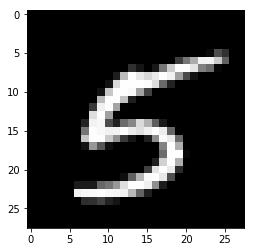

In [8]:
image_iter = 52
test_image_Madry = Madry_testing_data[image_iter, :]
plt.imshow(np.reshape(test_image_Madry, [28, 28, 1])[:,:,0], cmap='gray')
test_label_Madry = np.argmax(Madry_testing_labels[image_iter,:])

print(test_label_Madry)

In [9]:
#The predicted label of the network prior to carrying out the attack
pre_label = np.argmax(Madry_model.predictions(Madry_testing_data[image_iter, :]))
assert(pre_label == test_label_Madry)
print("The predicted label is " + str(pre_label))


The predicted label is 5


###Carry Out and Visualize the Boundary Attack

In [10]:
#Carry out the black-box attack
num_iterations = 100 #Note that the more iterations that are run, the more similar the new image will be to the original
Madry_attack = foolbox.attacks.BoundaryAttack(model=Madry_model, criterion=foolbox.criteria.Misclassification())
Madry_adversarial_image = Madry_attack(test_image_Madry, test_label_Madry, iterations=num_iterations, log_every_n_steps=50)

run with verbose=True to see details
Step 0: 1.18890e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.04003e-01, stepsizes = 1.5e-02/6.7e-03:  (took 0.07402 seconds)
Step 100: 7.74956e-02, stepsizes = 1.5e-02/4.4e-03:  (took 0.07112 seconds)


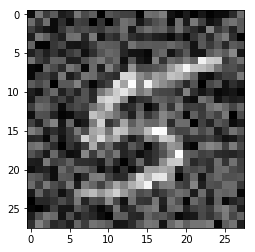

In [11]:
#Visualize the image after adversarial modification
#NB imshow can only accept values in the range of 0:255 if they are integers, hence the they are normalized to 0...1
plt.imshow(np.reshape(Madry_adversarial_image, [28, 28, 1])[:,:,0], cmap='gray')

In [12]:
#The predicted label of the network after the attack
post_label = np.argmax(Madry_model.predictions(Madry_adversarial_image))
print("The predicted label is " + str(post_label))

The predicted label is 0


###Quantify the Vulnerability of the Madry Model to the Boundary Attack

As the Boundary Attack optimizes for the L-2 norm, it is not possible to investigate it's ability to identify new local minima in L-inf norm space. On the other hand, Madry et al report a level of accuracy for l-2 norm resistance, based on PGD (gradient based) adversaries; specifically, they found that an l-2 perturbation of >5 was needed to drop the performance of classification significantly below 85%. I will explore here whether the Boundary Attack can find new local minima such that greater misclassification occurs without using a large l-2 perturbation.

In [0]:
#Function to iterate through a series of images to be attacked
def evaluate_l2_BoundaryAttack_resistance_MadryModel(num_images_to_attack, num_iterations):
    adversary_found = np.zeros([num_images_to_attack]) #array of booleans that indicates if an adversary was found for a particular image
    adversary_distance = np.zeros([num_images_to_attack])
    adversary_arrays = np.zeros([num_images_to_attack, Madry_testing_data.shape[1]])
    
    for ii in range(num_images_to_attack):
        test_image_Madry = Madry_testing_data[ii, :]
        test_label_Madry = np.argmax(Madry_testing_labels[ii,:])

        Madry_attack = foolbox.attacks.BoundaryAttack(model=Madry_model, criterion=foolbox.criteria.Misclassification())
        Madry_adversarial_image = Madry_attack(test_image_Madry, test_label_Madry, iterations=num_iterations, log_every_n_steps=500)
        adversary_arrays[ii, :] = Madry_adversarial_image
        
        # **** need to check this logical statement for accuracy
        if np.any(np.any(Madry_adversarial_image == None) | (Madry_model.predictions(Madry_adversarial_image) == test_label_Madry)):
            print("No adversarial image found")

        else:
            l2_distance = scipy.spatial.distance.euclidean(test_image_Madry, Madry_adversarial_image)
            print("The L2 distance of the adversary is " + str(l2_distance))
            adversary_found[ii] = 1
            adversary_distance[ii] = l2_distance

    return adversary_found, adversary_distance, adversary_arrays


In [15]:
num_images_to_attack = 2
num_iterations = 50
adversary_found, adversary_distance, adversary_arrays = evaluate_l2_BoundaryAttack_resistance_MadryModel(num_images_to_attack=num_images_to_attack, num_iterations=num_iterations)


run with verbose=True to see details
Step 0: 8.22052e-02, stepsizes = 1.0e-02/1.0e-02: 
The L2 distance of the adversary is 7.712176846253825
run with verbose=True to see details
Step 0: 2.97564e-01, stepsizes = 1.0e-02/1.0e-02: 
The L2 distance of the adversary is 10.11558730620568


In [0]:
np.savetxt("Madry_adversaries.csv", adversary_arrays, delimiter=',')

In [0]:
success_ratio = np.sum(adversary_found)/num_images_to_attack
mean_distance_successful_attacks = np.sum(adversary_distance)/np.sum(adversary_found)

In [295]:
print("The success ratio is " + str(success_ratio))
print("The mean distance is " + str(mean_distance_successful_attacks))

The success ratio is 1.0
The mean distance is 1.4547432974566632


My own results suggest that the boundary attack can achieve 100% misclassification of the Madry model, using a *mean* l-2 epsilon of only 1.406. In their original paper, they reported that an l-2 epislon of >5 was necessary to cause more than 15% misclassification. While my metric differed from that in the paper, and therefore direct comparisons are not possible, this suggests that the Boundary Attack method is indeed capable of finding local minima that escape gradient-based methods. Note this result was based on a sample of 50 images, allowing the BoundaryAttack to perform 1000 iterations for each.

Over the course of this work, I discovered a later pape by Schott et al (Towards the First Adversarially Robust Neural Network Model on MNIST, 2018 Arxiv) which used the same metric as in Madry et al, and found a similar result.

The earlier prediction that the Boundary Attack can identify novel local minima that gradient-based attacks cannot therefore appears confirmed.

#Part 2 - Setting Up Attacks on Custom Models, and Implementation of the Binding Network

##Execute the Boundary Attack on a Standard Convolutional Neural Network

The following demonstrates the use of the Boundary Attack Method against a standard convolutional neural network model trained on MNIST. This work helps to lay-out the steps necessary to apply FoolBox methods to a custom neural network that has been developed in TensorFlow's low-level API. Note this CNN is based on a model I previously developed in TensorFlow, and is based on the architecture of the classic network 'LeNet-5'.

###Data Setup and Preprocessing

In [0]:
#Load the full MNIST dataset
#Note the shape of the images required by the custom CNNs is 2D, rather than flattened as for the Madry model

(training_data, training_labels), (testing_data, testing_labels) = mnist.load_data()


In [0]:
#Rescale images to values between 0:1 and reshape so each image is 28x28
training_data = training_data/255
training_data = np.reshape(training_data, [np.shape(training_data)[0], 28, 28, 1])

testing_data = testing_data/255
testing_data = np.reshape(testing_data, [np.shape(testing_data)[0], 28, 28, 1])

In [0]:
#Transform the labels into one-hot encoding
num_classes = 10
training_labels = np.eye(num_classes)[training_labels.astype(int)]

testing_labels = np.eye(num_classes)[testing_labels.astype(int)]

###Model Setup

In [0]:
#Define training parameters
batch_size = 128
training_epochs = 10

In [0]:
#Define a summary variables funciton for later visualisation of the network
def var_summaries(variable):
    with tf.name_scope('Summaries'):
        mean = tf.reduce_mean(variable)
        tf.summary.scalar('Mean', mean) #The tf.summary operation determines which graph node you would like to annotate, and scalar or histogram the type of summary

        with tf.name_scope('STD'):
            std = tf.sqrt(tf.reduce_mean(tf.square(variable - mean)))
            
        tf.summary.scalar('STD', std)
        tf.summary.scalar('Max', tf.reduce_max(variable))
        tf.summary.scalar('Min', tf.reduce_min(variable))
        tf.summary.histogram('Histogram', variable)


In [0]:
#Declare placeholders for the input features and labels
#The first dimension of the palceholder shape is set to None as this will later be defined by the batch size

with tf.name_scope('Input'):
    x = tf.placeholder(training_data.dtype, [None, 28, 28, 1], name='x-input')
    y = tf.placeholder(training_labels.dtype, [None, num_classes], name='y-input')

with tf.name_scope('Drop-Out'):
    keep_prob = tf.placeholder(tf.float32)
    tf.summary.scalar('Dropout_Keep_Probability', keep_prob)

In [24]:
#Define weight and bias variables, and initialize values 
#Note for example that the first convolutional weights layer has a 5x5 filter with 1 input channel, and 6 output channels
#tf.get_variable will either get an existing variable with these parameters, or otherwise create a new one

with tf.name_scope('Weights'):
    weights_LeNet = {
        'conv_W1' : tf.get_variable('CW1', shape=(5, 5, 1, 6), initializer=tf.contrib.layers.xavier_initializer()),
        'conv_W2' : tf.get_variable('CW2', shape=(5, 5, 6, 16), initializer=tf.contrib.layers.xavier_initializer()),
        'dense_W1' : tf.get_variable('DW1', shape=(400, 120), initializer=tf.contrib.layers.xavier_initializer()),
        'dense_W2' : tf.get_variable('DW2', shape=(120, 84), initializer=tf.contrib.layers.xavier_initializer()),
        'output_W' : tf.get_variable('OW', shape=(84, num_classes), initializer=tf.contrib.layers.xavier_initializer())
    }
    
    #Add summaries for each weight variable in the dictionary, for later use in TensorBoard
    for weights_var in weights_LeNet.values():
        var_summaries(weights_var)

with tf.name_scope('Biases'):
    biases_LeNet = {
        'conv_b1' : tf.get_variable('Cb1', shape=(6), initializer=tf.contrib.layers.xavier_initializer()),
        'conv_b2' : tf.get_variable('Cb2', shape=(16), initializer=tf.contrib.layers.xavier_initializer()),
        'dense_b1' : tf.get_variable('Db1', shape=(120), initializer=tf.contrib.layers.xavier_initializer()),
        'dense_b2' : tf.get_variable('Db2', shape=(84), initializer=tf.contrib.layers.xavier_initializer()),
        'output_b' : tf.get_variable('Ob', shape=(num_classes), initializer=tf.contrib.layers.xavier_initializer())
    }

    for biases_var in biases_LeNet.values():
        var_summaries(biases_var)


W0619 09:09:48.886630 140005334890368 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
var_list_LeNet = [weights_LeNet['conv_W1'], weights_LeNet['conv_W2'], weights_LeNet['dense_W1'], weights_LeNet['dense_W2'], 
                  weights_LeNet['output_W'], biases_LeNet['conv_b1'], biases_LeNet['conv_b2'], biases_LeNet['dense_b1'],
                  biases_LeNet['dense_b2'], biases_LeNet['output_b']]

In [0]:
#Define the model

def cnn_predictions(features, temp_batch_size, keep_prob):

    #Note temp_batch_size is not currently used in this particular model, but is 
    #included as an argument to enable arbitrary calling of models later
    
    conv1 = tf.nn.conv2d(input=tf.dtypes.cast(features, dtype=tf.float32), filter=weights_LeNet['conv_W1'], 
                         strides=[1, 1, 1, 1], padding="SAME")
    conv1 = tf.nn.bias_add(conv1, biases_LeNet['conv_b1'])
    conv1_drop = tf.nn.dropout(conv1, keep_prob)
    relu1 = tf.nn.relu(conv1_drop)
    tf.summary.histogram('Relu1_activations', relu1)
    pool1 = tf.nn.max_pool(relu1, ksize=(1,2,2,1), strides=(1,2,2,1), padding="VALID")
    pool1_drop = tf.nn.dropout(pool1, keep_prob)
    #Note in the tuple defining strides for max_pool, the first entry is always 1 as this refers to the batches/indexed images,
    #rather than the dimensions of a particular image

    conv2 = tf.nn.conv2d(pool1_drop, weights_LeNet['conv_W2'], strides=[1,1,1,1], padding="VALID")
    conv2 = tf.nn.bias_add(conv2, biases_LeNet['conv_b2'])
    conv2_drop = tf.nn.dropout(conv2, keep_prob)
    relu2 = tf.nn.relu(conv2_drop)
    tf.summary.histogram('Relu2_activations', relu2)
    pool2 = tf.nn.max_pool(relu2, ksize=(1,2,2,1), strides=(1,2,2,1), padding="VALID")
    pool2_drop = tf.nn.dropout(pool2, keep_prob)
    
    #Flatten Pool 2 before connecting it (fully) with the dense layers 1 and 2
    pool2_flat = tf.reshape(pool2, [-1, 5 * 5 * 16])
    dense1 = tf.add(tf.matmul(pool2_flat, weights_LeNet['dense_W1']), biases_LeNet['dense_b1'])
    dense1_drop = tf.nn.dropout(dense1, keep_prob)
    dense1 = tf.nn.relu(dense1)
    tf.summary.histogram('Dense1_activations', dense1)
    dense2 = tf.add(tf.matmul(dense1, weights_LeNet['dense_W2']), biases_LeNet['dense_b2'])
    dense2_drop = tf.nn.dropout(dense2, keep_prob)
    dense2 = tf.nn.relu(dense2)
    tf.summary.histogram('Dense2_activations', dense2)

    logits = tf.add(tf.matmul(dense2, weights_LeNet['output_W']), biases_LeNet['output_b'])

    return logits



###Define Training

In [0]:
#Primary training function
def LeNet5_train(var_list, training_data, training_labels, testing_data, testing_labels, learning_rate, temp_batch_size, dropout_keep_prob):
    
    predictions = cnn_predictions(x, temp_batch_size, keep_prob) #NB that x was defined earlier with tf.placeholder
    
    #Define the main Tensors (left hand) and Operations (right hand) that will be used during training
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predictions, labels=y))
    tf.summary.scalar('Softmax_cross_entropy', cost)
    
    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('Accuracy', accuracy)

    #Create the chosen optimizer with tf.train.Adam..., then add it to the graph with .minimize
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    #Define values to be written with the summary method for later visualization
    loss_summary = tf.summary.scalar(name="Loss_values", tensor=cost)
    accuracy_summary = tf.summary.scalar(name="Accuracy_values", tensor=accuracy)
    
    #Create a Saver object to enable later re-loading of the learned weights
    saver = tf.train.Saver(var_list)
    
    #Merge and provide directory for saving TF summaries
    merged = tf.summary.merge_all()

    #Aside on understanding 'with' and 'tf.Session()'
        #Python's 'with' statement enables the evaluation of tf.Session, while ensuring
        #that the associated __exit__ method (similar to e.g. closing a file) will always 
        #be executed even if an error is raised
        #tf.Session() provides a connection between the Python program and the C++ runtime
        #It also caches information about the tf.Graph to enable efficient re-use of data
        #As tf.Session owns physical resources (such as the GPU), 'with' is particularly important
    with tf.Session() as sess:
        #Initialize variables; note the requirement for explicit initialization prevents expensive
        #initializers from being re-run when e.g. relaoding a model from a checkpoint
        sess.run(tf.global_variables_initializer())
        training_writer = tf.summary.FileWriter('/tmp/log', sess.graph)
        #testing_writer = tf.summary.FileWriter('LeNet/testing')
        
        #Empty arrays for storing performance measures
        train_loss = []
        test_loss = []
        train_accuracy = []
        test_accuracy = []


        for epoch in range(training_epochs):

            for batch in range(int(len(training_labels)/batch_size)):

                batch_x = training_data[batch*batch_size:min((batch+1)*batch_size, len(training_labels))]
                batch_y = training_labels[batch*batch_size:min((batch+1)*batch_size, len(training_labels))]
                
                #Recall that tf.Session.run is the main method for running a tf.Operation or evaluation a tf.Tensor
                #By passing or more Tensors or Operations, TensorFlow will execute the operations needed
                run_optim = sess.run(optimizer, feed_dict = {x: batch_x, y: batch_y, keep_prob : dropout_keep_prob})

                loss, acc = sess.run([cost, accuracy], feed_dict = {x: batch_x, y: batch_y, keep_prob : 1.0})
                

            print("At iteration " + str(epoch) + ", Loss = " + \
                 "{:.6f}".format(loss) + ", Training Accuracy = " + \
                                "{:.5f}".format(acc))

            train_acc, _ = sess.run([merged, accuracy], feed_dict={x: batch_x, y: batch_y, keep_prob : 1.0})
            training_writer.add_summary(train_acc, epoch)
            
            #test_acc, _ = sess.run([merged, accuracy], feed_dict={x: testing_data, y: testing_labels, keep_prob : 1.0})
            #testing_writer.add_summary(test_acc, epoch)
            
        print("Training complete")
        
        save_path = saver.save(sess, "/MNIST_LeNet5_CNN.ckpt")
        print("Model saved in MNIST_LeNet5_CNN.ckpt")
        
        test_acc, _ = sess.run([accuracy,cost], feed_dict={x: testing_data, y: testing_labels, keep_prob : 1.0})
        
        print("Final testing Accuracy:","{:.5f}".format(test_acc))
        
        training_writer.close()



###Train the Model

In [28]:
LeNet5_train(var_list_LeNet, training_data, training_labels, testing_data, testing_labels, learning_rate=0.001, temp_batch_size=None, dropout_keep_prob=0.5)

W0619 09:09:50.677801 140005334890368 deprecation.py:506] From <ipython-input-26-6e0fc2785a36>:10: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0619 09:09:50.757374 140005334890368 deprecation.py:323] From <ipython-input-27-1d3f2d7afa64>:6: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



At iteration 0, Loss = 0.282008, Training Accuracy = 1.00000
At iteration 1, Loss = 0.177014, Training Accuracy = 1.00000
At iteration 2, Loss = 0.145883, Training Accuracy = 0.99219
At iteration 3, Loss = 0.115967, Training Accuracy = 1.00000
At iteration 4, Loss = 0.093023, Training Accuracy = 1.00000
At iteration 5, Loss = 0.075792, Training Accuracy = 1.00000
At iteration 6, Loss = 0.077900, Training Accuracy = 1.00000
At iteration 7, Loss = 0.080910, Training Accuracy = 0.99219
At iteration 8, Loss = 0.077559, Training Accuracy = 1.00000
At iteration 9, Loss = 0.076272, Training Accuracy = 1.00000
Training complete
Model saved in MNIST_LeNet5_CNN.ckpt
Final testing Accuracy: 0.98360


###Check the Successful Loading of the Model Using tf.train.Saver()

In [0]:
def LeNet5_test(var_list_LeNet, testing_data, testing_labels, temp_batch_size):

    predictions = cnn_predictions(x, temp_batch_size, keep_prob)

    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    saver = tf.train.Saver(var_list=var_list_LeNet)
    
    with tf.Session() as sess:
        saver.restore(sess, "/MNIST_LeNet5_CNN.ckpt")
        
        test_acc = sess.run([accuracy], feed_dict={x: testing_data, y: testing_labels, keep_prob : 1.0})
        
        print("Testing Accuracy:" + str(test_acc))

In [30]:
LeNet5_test(var_list_LeNet, testing_data, testing_labels, temp_batch_size=None)

Testing Accuracy:[0.9836]


###Test the Trained Model on Random Examples

In [0]:
def LeNet5_predict(var_list_LeNet, test_image, temp_batch_size):
    
    predictions = cnn_predictions(x, temp_batch_size, keep_prob)
    
    saver = tf.train.Saver(var_list=var_list_LeNet)
    
    with tf.Session() as sess:
        saver.restore(sess, "/MNIST_LeNet5_CNN.ckpt")
        
        num_parameters = np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])
        print(num_parameters)
        
        output_predictions = sess.run([predictions], feed_dict={x: test_image, keep_prob : 1.0})
                
        return output_predictions

5


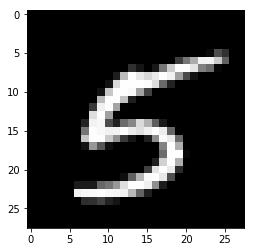

In [32]:
image_iter = 52
test_image_LeNet = testing_data[image_iter, :, :]
plt.imshow(test_image_LeNet[:,:,0], cmap='gray')
test_label_LeNet = np.argmax(testing_labels[image_iter,:])

print(test_label_LeNet)

In [33]:
output_predictions = LeNet5_predict(var_list_LeNet, test_image_LeNet[None, :, :, :], temp_batch_size=None)
print("The predicted value is " + str(np.argmax(output_predictions)))

3336340
The predicted value is 5


###Carry Out and Visualize an Attack

In [0]:
#Function used to attack an arbitrary model that has been implemented with TensorFlow's low-level API (i.e. requires a session to be called explicitly)
def Boundary_Attack_customTensorFlowModel(model_prediction_function, model_weights, var_list, num_iterations, test_image, test_label, temp_batch_size, keep_prob):

    images = x #x is a place-holder for 28x28 images earlier defined
    logits = model_prediction_function(images, temp_batch_size, keep_prob)

    saver = tf.train.Saver(var_list) #Define saver object for use later when loading the model weights

    #Note how when attacking a low-level TensorFlow API model, it is necessary for all steps to occur within the tf.Session()
    with tf.Session() as session:
        saver.restore(session, model_weights) #Note when restoring weights its important not to run init on the same
        #variables, as this will over-write the learned weights with randomly initialized ones

        #Define the foolbox model
        fmodel = foolbox.models.TensorFlowModel(images, logits, (0,1)) 

        #The predicted label of the network prior to carrying out the attack
        pre_label = np.argmax(fmodel.predictions(test_image[:, :, :]))
        #print("The classification label prior to attack is " + str(pre_label))
        if (pre_label != test_label):
            print("The model predicted a " + str(pre_label) + " when the ground-truth label is " + str(test_label))
            plt.imshow(test_image[:,:,0], cmap='gray')

        #Carry out the untargeted Bounary Attack
        attack_fmodel = foolbox.attacks.BoundaryAttack(model=fmodel, criterion=foolbox.criteria.Misclassification())
        adversarial_image_fmodel = attack_fmodel(test_image, test_label, iterations=num_iterations, log_every_n_steps=50)
        plt.imshow(adversarial_image_fmodel[:,:,0], cmap='gray')
        plt.show()
        
        #Check the output of the adversarial attack
        adversarial_label_fmodel = np.argmax(fmodel.predictions(adversarial_image_fmodel[:, :, :]))
        print("The classification label following attack is " + str(adversarial_label_fmodel) 
              + " from an original classification of " + str(test_label))
        
        return adversarial_image_fmodel, adversarial_label_fmodel

run with verbose=True to see details
Step 0: 6.50286e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 6.00089e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.04720 seconds)
Step 100: 4.18163e-02, stepsizes = 1.5e-02/4.4e-03:  (took 0.05042 seconds)
Step 150: 3.12137e-02, stepsizes = 2.2e-02/4.4e-03: d. reduced by 0.59% (1.8580e-04) (took 0.01052 seconds)
Step 200: 2.28482e-02, stepsizes = 3.4e-02/6.7e-03:  (took 0.01037 seconds)
Step 250: 1.52297e-02, stepsizes = 5.1e-02/4.4e-03: d. reduced by 1.33% (2.0511e-04) (took 0.01125 seconds)
Step 300: 1.08263e-02, stepsizes = 7.6e-02/1.0e-02:  (took 0.01017 seconds)
Step 350: 8.28313e-03, stepsizes = 7.6e-02/6.7e-03:  (took 0.01043 seconds)
Step 400: 6.46325e-03, stepsizes = 5.1e-02/3.0e-03: d. reduced by 0.59% (3.8472e-05) (took 0.01127 seconds)
Step 450: 5.12781e-03, stepsizes = 5.1e-02/3.0e-03: d. reduced by 0.59% (3.0523e-05) (took 0.01093 seconds)
Step 500: 4.29178e-03, stepsizes = 5.1e-02/2.0e-03: d. reduced by 0.39% (1.7006e-05) (took 0.01007 se

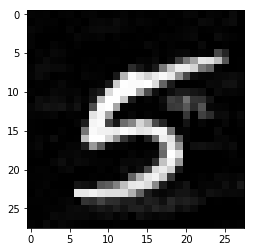

The classification label following attack is 9 from an original classification of 5


In [279]:
#An example of the attack
adversarial_image_fmodel, adversarial_label_fmodel = Boundary_Attack_customTensorFlowModel(model_prediction_function=cnn_predictions,
                                                                 model_weights="/MNIST_LeNet5_CNN.ckpt", 
                                                                 var_list=var_list_LeNet,
                                                                num_iterations=3000, 
                                                                 test_image=test_image_LeNet, 
                                                                 test_label=test_label_LeNet,
                                                                 temp_batch_size=None,
                                                                keep_prob = 1.0)


In [36]:
print("The prediction following adversarial perturbation is " + str(adversarial_label_fmodel))

The prediction following adversarial perturbation is 9


###Quantify the Vulnerability of the Standard CNN Model to the Boundary Attack

In [0]:
#Iterate through a series of images to be attacked
def evaluate_l2_BoundaryAttack_resistance_CustomModel(model_prediction_function, model_weights, var_list, num_images_to_attack, num_iterations, temp_batch_size):
    adversary_found = np.zeros([num_images_to_attack]) #array of booleans that indicates if an adversary was found for a particular image
    adversary_distance = np.zeros([num_images_to_attack])
    adversary_arrays = np.zeros([num_images_to_attack, testing_data.shape[1], testing_data.shape[2], 1])

    for ii in range(num_images_to_attack):
        test_image = testing_data[ii, :, :]
        test_label = np.argmax(testing_labels[ii,:])

        adversarial_image_fmodel, adversarial_classification = Boundary_Attack_customTensorFlowModel(model_prediction_function, 
                                                                                                     model_weights, var_list,
                                                                                                     num_iterations, 
                                                                                                     test_image, test_label, 
                                                                                                     temp_batch_size,
                                                                                                    keep_prob = 1.0)
        adversary_arrays[ii, :, :] = adversarial_image_fmodel

        if ((np.any(adversarial_image_fmodel == None) | adversarial_classification == test_label)):
            print("No adversarial image found")

        else:
            l2_distance = scipy.spatial.distance.euclidean(test_image.flatten(), adversarial_image_fmodel.flatten())
            print("The L2 distance of the adversary is " + str(l2_distance))
            adversary_found[ii] = 1
            adversary_distance[ii] = l2_distance
        
    return adversary_found, adversary_distance, adversary_arrays

run with verbose=True to see details
Step 0: 1.30776e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.30776e-01, stepsizes = 1.5e-02/6.7e-03:  (took 0.05646 seconds)
Step 100: 1.01878e-01, stepsizes = 2.2e-02/6.7e-03:  (took 0.04491 seconds)
Step 150: 7.62616e-02, stepsizes = 3.4e-02/4.4e-03: d. reduced by 0.89% (6.8243e-04) (took 0.01038 seconds)
Step 200: 5.07739e-02, stepsizes = 5.1e-02/6.7e-03: d. reduced by 0.89% (4.5435e-04) (took 0.01028 seconds)
Step 250: 4.15424e-02, stepsizes = 5.1e-02/4.4e-03: d. reduced by 1.33% (5.5949e-04) (took 0.01021 seconds)
Step 300: 3.32481e-02, stepsizes = 5.1e-02/4.4e-03:  (took 0.01094 seconds)
Step 350: 2.93495e-02, stepsizes = 3.4e-02/3.0e-03:  (took 0.01016 seconds)
Step 400: 2.54042e-02, stepsizes = 3.4e-02/2.0e-03: d. reduced by 0.39% (1.0066e-04) (took 0.01053 seconds)
Step 450: 2.23845e-02, stepsizes = 3.4e-02/2.0e-03:  (took 0.01113 seconds)
Step 500: 2.06281e-02, stepsizes = 3.4e-02/2.0e-03: d. reduced by 0.39% (8.1736e-05) (took 0.01027 se

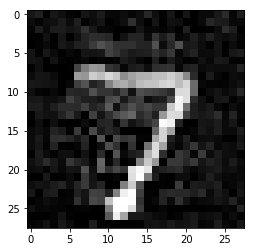

The classification label following attack is 0 from an original classification of 7
The L2 distance of the adversary is 3.283395728537258
run with verbose=True to see details
Step 0: 1.42395e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.33182e-01, stepsizes = 1.5e-02/6.7e-03:  (took 0.04517 seconds)
Step 100: 1.14451e-01, stepsizes = 2.2e-02/4.4e-03:  (took 0.04828 seconds)
Step 150: 7.42896e-02, stepsizes = 3.4e-02/4.4e-03: d. reduced by 0.89% (6.6478e-04) (took 0.01307 seconds)
Step 200: 4.99673e-02, stepsizes = 5.1e-02/4.4e-03: d. reduced by 1.33% (6.7295e-04) (took 0.01159 seconds)
Step 250: 3.65823e-02, stepsizes = 5.1e-02/3.0e-03:  (took 0.00991 seconds)
Step 300: 2.86812e-02, stepsizes = 5.1e-02/3.0e-03: d. reduced by 0.59% (1.7072e-04) (took 0.01015 seconds)
Step 350: 2.45328e-02, stepsizes = 3.4e-02/2.0e-03: d. reduced by 0.39% (9.7208e-05) (took 0.01088 seconds)
Step 400: 2.20195e-02, stepsizes = 3.4e-02/1.3e-03: d. reduced by 0.26% (5.8108e-05) (took 0.01009 seconds)
Step 45

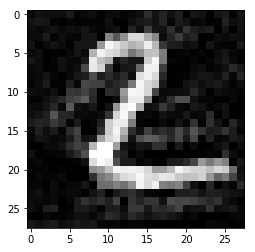

The classification label following attack is 4 from an original classification of 2
The L2 distance of the adversary is 3.119937955512252
run with verbose=True to see details
Step 0: 1.01164e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 9.52503e-02, stepsizes = 1.0e-02/6.7e-03: d. reduced by 1.33% (1.2828e-03) (took 0.01298 seconds)
Step 100: 7.29050e-02, stepsizes = 1.5e-02/4.4e-03: d. reduced by 0.89% (6.5239e-04) (took 0.00640 seconds)
Step 150: 5.38575e-02, stepsizes = 1.5e-02/3.0e-03:  (took 0.01084 seconds)
Step 200: 4.05048e-02, stepsizes = 2.2e-02/4.4e-03: d. reduced by 0.59% (2.4110e-04) (took 0.01084 seconds)
Step 250: 2.35113e-02, stepsizes = 5.1e-02/1.0e-02: d. reduced by 1.33% (3.1665e-04) (took 0.00989 seconds)
Step 300: 1.81084e-02, stepsizes = 5.1e-02/6.7e-03:  (took 0.00986 seconds)
Step 350: 1.43282e-02, stepsizes = 7.6e-02/1.5e-02:  (took 0.00983 seconds)
Step 400: 1.10316e-02, stepsizes = 7.6e-02/1.0e-02:  (took 0.01017 seconds)
Step 450: 8.51865e-03, stepsizes = 5.1e

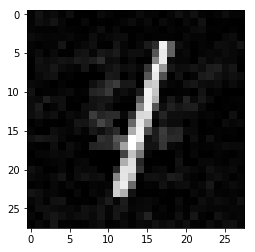

The classification label following attack is 4 from an original classification of 1
The L2 distance of the adversary is 1.698060714681764
run with verbose=True to see details
Step 0: 1.73812e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.66974e-01, stepsizes = 1.5e-02/6.7e-03:  (took 0.03989 seconds)
Step 100: 1.51379e-01, stepsizes = 2.2e-02/6.7e-03:  (took 0.03445 seconds)
Step 150: 1.21697e-01, stepsizes = 2.2e-02/3.0e-03: d. reduced by 0.59% (7.2438e-04) (took 0.01000 seconds)
Step 200: 1.02865e-01, stepsizes = 2.2e-02/2.0e-03: d. reduced by 0.39% (4.0759e-04) (took 0.01099 seconds)
Step 250: 8.52456e-02, stepsizes = 3.4e-02/3.0e-03: d. reduced by 0.59% (5.0741e-04) (took 0.01022 seconds)
Step 300: 6.73675e-02, stepsizes = 3.4e-02/2.0e-03: d. reduced by 0.39% (2.6693e-04) (took 0.01024 seconds)
Step 350: 5.92361e-02, stepsizes = 3.4e-02/3.0e-03:  (took 0.00908 seconds)
Step 400: 5.23996e-02, stepsizes = 2.3e-02/1.3e-03: d. reduced by 0.39% (2.0763e-04) (took 0.01032 seconds)
Step 45

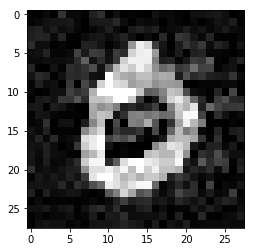

The classification label following attack is 8 from an original classification of 0
The L2 distance of the adversary is 4.007326488523787
run with verbose=True to see details
Step 0: 2.19673e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.88329e-01, stepsizes = 1.0e-02/6.7e-03:  (took 0.03831 seconds)
Step 100: 1.48726e-01, stepsizes = 1.0e-02/3.0e-03: d. reduced by 0.59% (8.8527e-04) (took 0.00822 seconds)
Step 150: 1.13521e-01, stepsizes = 2.2e-02/4.4e-03: d. reduced by 0.59% (6.7572e-04) (took 0.01005 seconds)
Step 200: 8.26231e-02, stepsizes = 3.4e-02/4.4e-03: d. reduced by 0.89% (7.3935e-04) (took 0.00962 seconds)
Step 250: 6.08585e-02, stepsizes = 3.4e-02/3.0e-03: d. reduced by 0.59% (3.6225e-04) (took 0.00982 seconds)
Step 300: 4.13717e-02, stepsizes = 5.1e-02/4.4e-03: d. reduced by 0.89% (3.7021e-04) (took 0.01116 seconds)
Step 350: 2.59110e-02, stepsizes = 7.6e-02/6.7e-03: d. reduced by 1.33% (3.4897e-04) (took 0.00970 seconds)
Step 400: 1.75790e-02, stepsizes = 7.6e-02/6.7e-03:

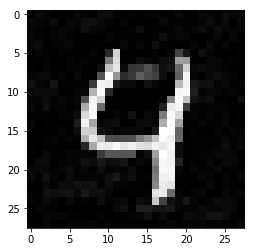

The classification label following attack is 9 from an original classification of 4
The L2 distance of the adversary is 1.1387508260343875
run with verbose=True to see details
Step 0: 1.08455e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.08455e-01, stepsizes = 1.5e-02/1.0e-02:  (took 0.04772 seconds)
Step 100: 1.00096e-01, stepsizes = 2.2e-02/6.7e-03:  (took 0.04238 seconds)
Step 150: 7.09263e-02, stepsizes = 3.4e-02/4.4e-03: d. reduced by 0.59% (4.2218e-04) (took 0.01085 seconds)
Step 200: 4.14458e-02, stepsizes = 5.1e-02/1.0e-02: d. reduced by 1.99% (8.4152e-04) (took 0.01180 seconds)
Step 250: 2.13546e-02, stepsizes = 5.1e-02/6.7e-03: d. reduced by 1.33% (2.8760e-04) (took 0.01064 seconds)
Step 300: 1.37965e-02, stepsizes = 5.1e-02/4.4e-03: d. reduced by 0.89% (1.2346e-04) (took 0.01272 seconds)
Step 350: 1.01911e-02, stepsizes = 5.1e-02/4.4e-03: d. reduced by 0.89% (9.1195e-05) (took 0.01023 seconds)
Step 400: 8.15637e-03, stepsizes = 5.1e-02/4.4e-03:  (took 0.00981 seconds)
Step 4

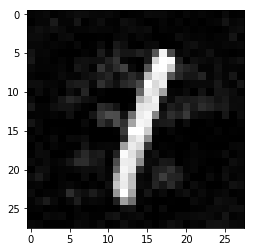

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 1.7361354894204735
run with verbose=True to see details
Step 0: 1.90952e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.28646e-01, stepsizes = 1.0e-02/6.7e-03: d. reduced by 1.33% (1.7326e-03) (took 0.01134 seconds)
Step 100: 1.14057e-01, stepsizes = 2.2e-02/6.7e-03:  (took 0.03967 seconds)
Step 150: 7.98563e-02, stepsizes = 2.2e-02/4.4e-03: d. reduced by 0.89% (7.1459e-04) (took 0.01004 seconds)
Step 200: 3.98994e-02, stepsizes = 3.4e-02/1.5e-02: d. reduced by 1.99% (8.1012e-04) (took 0.01037 seconds)
Step 250: 1.44616e-02, stepsizes = 5.1e-02/1.5e-02: d. reduced by 2.98% (4.4381e-04) (took 0.00962 seconds)
Step 300: 7.52095e-03, stepsizes = 5.1e-02/6.7e-03: d. reduced by 1.99% (1.5271e-04) (took 0.01027 seconds)
Step 350: 4.64678e-03, stepsizes = 5.1e-02/4.4e-03: d. reduced by 0.89% (4.1582e-05) (took 0.00943 seconds)
Step 400: 3.35199e-03, stepsizes = 3.4e-02/2.0e-03

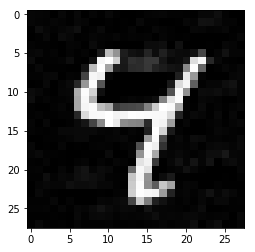

The classification label following attack is 9 from an original classification of 4
The L2 distance of the adversary is 0.9485666221690675
run with verbose=True to see details
Step 0: 7.23329e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 6.67538e-02, stepsizes = 1.5e-02/6.7e-03: d. reduced by 1.33% (8.9903e-04) (took 0.03136 seconds)
Step 100: 5.24761e-02, stepsizes = 1.5e-02/4.4e-03:  (took 0.04284 seconds)
Step 150: 3.39141e-02, stepsizes = 3.4e-02/6.7e-03: d. reduced by 0.89% (3.0348e-04) (took 0.00988 seconds)
Step 200: 2.14323e-02, stepsizes = 5.1e-02/4.4e-03: d. reduced by 0.89% (1.9179e-04) (took 0.01006 seconds)
Step 250: 1.31844e-02, stepsizes = 5.1e-02/6.7e-03:  (took 0.01268 seconds)
Step 300: 8.71174e-03, stepsizes = 7.6e-02/6.7e-03: d. reduced by 0.89% (7.7957e-05) (took 0.01056 seconds)
Step 350: 6.04539e-03, stepsizes = 7.6e-02/4.4e-03: d. reduced by 0.89% (5.4097e-05) (took 0.00913 seconds)
Step 400: 4.76287e-03, stepsizes = 5.1e-02/2.0e-03: d. reduced by 0.39% (1.8872e-0

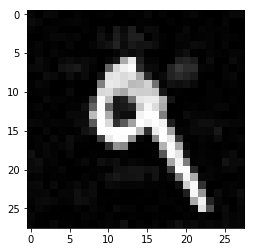

The classification label following attack is 4 from an original classification of 9
The L2 distance of the adversary is 1.2087667887844131
run with verbose=True to see details
Step 0: 7.10827e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 6.51605e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.04574 seconds)
Step 100: 4.17258e-02, stepsizes = 1.5e-02/4.4e-03: d. reduced by 0.89% (3.7338e-04) (took 0.00629 seconds)
Step 150: 2.62514e-02, stepsizes = 3.4e-02/6.7e-03: d. reduced by 0.89% (2.3491e-04) (took 0.01109 seconds)
Step 200: 1.47680e-02, stepsizes = 5.1e-02/6.7e-03: d. reduced by 1.33% (1.9889e-04) (took 0.00942 seconds)
Step 250: 7.51255e-03, stepsizes = 7.6e-02/1.0e-02: d. reduced by 1.99% (1.5254e-04) (took 0.01080 seconds)
Step 300: 5.19818e-03, stepsizes = 7.6e-02/6.7e-03: d. reduced by 1.33% (7.0008e-05) (took 0.01000 seconds)
Step 350: 3.96038e-03, stepsizes = 7.6e-02/4.4e-03:  (took 0.00965 seconds)
Step 400: 3.20784e-03, stepsizes = 5.1e-02/3.0e-03: d. reduced by 0.59% (1.9094e-0

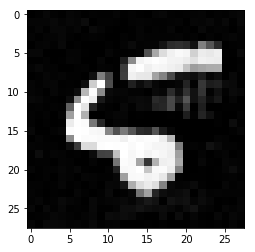

The classification label following attack is 9 from an original classification of 5
The L2 distance of the adversary is 1.0968686318267342
run with verbose=True to see details
Step 0: 9.79003e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 9.79003e-02, stepsizes = 1.5e-02/1.0e-02:  (took 0.04322 seconds)
Step 100: 8.56415e-02, stepsizes = 2.2e-02/6.7e-03: d. reduced by 1.33% (1.1534e-03) (took 0.03497 seconds)
Step 150: 6.24095e-02, stepsizes = 2.2e-02/4.4e-03: d. reduced by 0.89% (5.5847e-04) (took 0.01006 seconds)
Step 200: 3.70458e-02, stepsizes = 5.1e-02/6.7e-03: d. reduced by 0.89% (3.3150e-04) (took 0.00957 seconds)
Step 250: 2.22823e-02, stepsizes = 5.1e-02/4.4e-03: d. reduced by 1.33% (3.0009e-04) (took 0.00979 seconds)
Step 300: 1.50565e-02, stepsizes = 5.1e-02/4.4e-03: d. reduced by 0.89% (1.3473e-04) (took 0.00996 seconds)
Step 350: 1.13907e-02, stepsizes = 5.1e-02/4.4e-03:  (took 0.00968 seconds)
Step 400: 8.79800e-03, stepsizes = 5.1e-02/3.0e-03: d. reduced by 0.59% (5.2369e-0

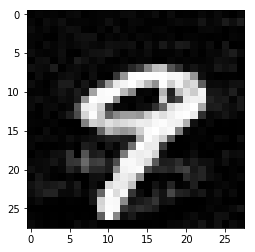

The classification label following attack is 8 from an original classification of 9
The L2 distance of the adversary is 1.7698079031384484
run with verbose=True to see details
Step 0: 1.29225e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.29225e-01, stepsizes = 1.5e-02/1.0e-02:  (took 0.04341 seconds)
Step 100: 1.19257e-01, stepsizes = 2.2e-02/6.7e-03: d. reduced by 1.33% (1.6061e-03) (took 0.01570 seconds)
Step 150: 9.41670e-02, stepsizes = 3.4e-02/4.4e-03: d. reduced by 1.33% (1.2682e-03) (took 0.01037 seconds)
Step 200: 6.85395e-02, stepsizes = 3.4e-02/3.0e-03:  (took 0.00958 seconds)
Step 250: 5.10896e-02, stepsizes = 5.1e-02/4.4e-03: d. reduced by 0.89% (4.5718e-04) (took 0.01021 seconds)
Step 300: 3.83091e-02, stepsizes = 5.1e-02/3.0e-03: d. reduced by 0.59% (2.2803e-04) (took 0.00958 seconds)
Step 350: 3.05746e-02, stepsizes = 5.1e-02/3.0e-03:  (took 0.00907 seconds)
Step 400: 2.57928e-02, stepsizes = 5.1e-02/2.0e-03: d. reduced by 0.39% (1.0220e-04) (took 0.01009 seconds)
Step 4

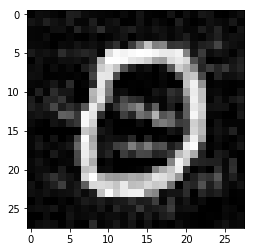

The classification label following attack is 8 from an original classification of 0
The L2 distance of the adversary is 3.1339637440871604
run with verbose=True to see details
Step 0: 1.04905e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 9.05494e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.04858 seconds)
Step 100: 6.68767e-02, stepsizes = 2.2e-02/4.4e-03:  (took 0.04629 seconds)
Step 150: 4.30230e-02, stepsizes = 3.4e-02/4.4e-03: d. reduced by 0.89% (3.8499e-04) (took 0.00989 seconds)
Step 200: 3.31393e-02, stepsizes = 5.1e-02/6.7e-03:  (took 0.00978 seconds)
Step 250: 2.37210e-02, stepsizes = 5.1e-02/4.4e-03: d. reduced by 0.89% (2.1227e-04) (took 0.01021 seconds)
Step 300: 1.79967e-02, stepsizes = 5.1e-02/3.0e-03:  (took 0.00920 seconds)
Step 350: 1.44487e-02, stepsizes = 5.1e-02/2.0e-03: d. reduced by 0.59% (8.6004e-05) (took 0.00995 seconds)
Step 400: 1.20933e-02, stepsizes = 5.1e-02/2.0e-03:  (took 0.00902 seconds)
Step 450: 1.04888e-02, stepsizes = 5.1e-02/2.0e-03: d. reduced by 0.26

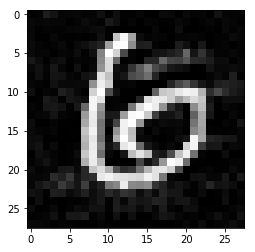

The classification label following attack is 8 from an original classification of 6
The L2 distance of the adversary is 2.1411751941158945
run with verbose=True to see details
Step 0: 9.00106e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 8.88144e-02, stepsizes = 1.5e-02/6.7e-03: d. reduced by 1.33% (1.1961e-03) (took 0.00788 seconds)
Step 100: 8.08797e-02, stepsizes = 2.2e-02/6.7e-03:  (took 0.04084 seconds)
Step 150: 5.56309e-02, stepsizes = 3.4e-02/4.4e-03:  (took 0.00920 seconds)
Step 200: 3.77556e-02, stepsizes = 5.1e-02/4.4e-03:  (took 0.01011 seconds)
Step 250: 2.60832e-02, stepsizes = 7.6e-02/6.7e-03:  (took 0.00921 seconds)
Step 300: 1.82351e-02, stepsizes = 5.1e-02/4.4e-03: d. reduced by 0.89% (1.6318e-04) (took 0.01008 seconds)
Step 350: 1.55315e-02, stepsizes = 5.1e-02/3.0e-03:  (took 0.00917 seconds)
Step 400: 1.26184e-02, stepsizes = 5.1e-02/3.0e-03: d. reduced by 0.59% (7.5109e-05) (took 0.01045 seconds)
Step 450: 1.06865e-02, stepsizes = 5.1e-02/3.0e-03:  (took 0.00841 sec

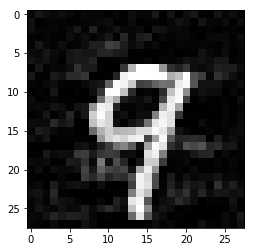

The classification label following attack is 8 from an original classification of 9
The L2 distance of the adversary is 2.189305464692557
run with verbose=True to see details
Step 0: 1.51437e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.49424e-01, stepsizes = 1.0e-02/6.7e-03:  (took 0.03700 seconds)
Step 100: 1.41647e-01, stepsizes = 1.5e-02/4.4e-03: d. reduced by 0.89% (1.2675e-03) (took 0.00488 seconds)
Step 150: 1.11373e-01, stepsizes = 2.2e-02/3.0e-03:  (took 0.00899 seconds)
Step 200: 8.27766e-02, stepsizes = 2.2e-02/3.0e-03: d. reduced by 0.59% (4.9272e-04) (took 0.01028 seconds)
Step 250: 6.18826e-02, stepsizes = 3.4e-02/4.4e-03: d. reduced by 0.89% (5.5376e-04) (took 0.01004 seconds)
Step 300: 4.21829e-02, stepsizes = 5.1e-02/6.7e-03: d. reduced by 1.33% (5.6811e-04) (took 0.00961 seconds)
Step 350: 3.27189e-02, stepsizes = 7.6e-02/6.7e-03: d. reduced by 1.33% (4.4065e-04) (took 0.00952 seconds)
Step 400: 2.31130e-02, stepsizes = 7.6e-02/4.4e-03:  (took 0.01046 seconds)
Step 45

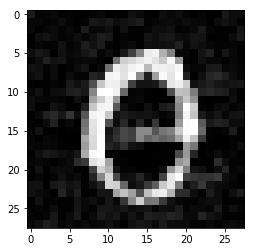

The classification label following attack is 8 from an original classification of 0
The L2 distance of the adversary is 2.7693683722151983
run with verbose=True to see details
Step 0: 1.48821e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.35517e-01, stepsizes = 1.5e-02/1.0e-02: d. reduced by 1.33% (1.8251e-03) (took 0.04667 seconds)
Step 100: 1.17753e-01, stepsizes = 1.5e-02/6.7e-03:  (took 0.03400 seconds)
Step 150: 9.38058e-02, stepsizes = 2.2e-02/4.4e-03: d. reduced by 0.89% (8.3942e-04) (took 0.00916 seconds)
Step 200: 6.06246e-02, stepsizes = 5.1e-02/6.7e-03: d. reduced by 0.89% (5.4250e-04) (took 0.00962 seconds)
Step 250: 3.45598e-02, stepsizes = 7.6e-02/1.0e-02: d. reduced by 1.99% (7.0170e-04) (took 0.00945 seconds)
Step 300: 2.09117e-02, stepsizes = 5.1e-02/4.4e-03: d. reduced by 1.33% (2.8164e-04) (took 0.00945 seconds)
Step 350: 1.40050e-02, stepsizes = 5.1e-02/4.4e-03:  (took 0.00965 seconds)
Step 400: 1.11767e-02, stepsizes = 3.4e-02/3.0e-03:  (took 0.00932 seconds)
Step 4

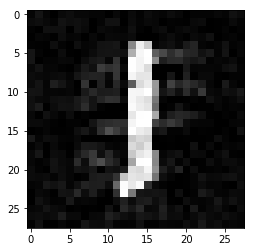

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 2.042165899139056
run with verbose=True to see details
Step 0: 6.31829e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 5.90949e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.04291 seconds)
Step 100: 3.50720e-02, stepsizes = 1.5e-02/6.7e-03: d. reduced by 1.33% (4.7234e-04) (took 0.00262 seconds)
Step 150: 1.87369e-02, stepsizes = 2.2e-02/1.0e-02: d. reduced by 1.99% (3.8043e-04) (took 0.01042 seconds)
Step 200: 9.91847e-03, stepsizes = 3.4e-02/6.7e-03: d. reduced by 1.33% (1.3358e-04) (took 0.00939 seconds)
Step 250: 5.11144e-03, stepsizes = 5.1e-02/1.0e-02: d. reduced by 1.99% (1.0378e-04) (took 0.01047 seconds)
Step 300: 2.74166e-03, stepsizes = 7.6e-02/1.0e-02: d. reduced by 1.99% (5.5667e-05) (took 0.01020 seconds)
Step 350: 1.85992e-03, stepsizes = 7.6e-02/4.4e-03:  (took 0.00948 seconds)
Step 400: 1.36169e-03, stepsizes = 7.6e-02/4.4e-03: d. reduced by 0.89% (1.2185e-05

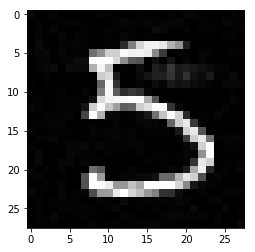

The classification label following attack is 3 from an original classification of 5
The L2 distance of the adversary is 0.7237008770846561
run with verbose=True to see details
Step 0: 7.99679e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 7.47938e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.04277 seconds)
Step 100: 6.37028e-02, stepsizes = 1.5e-02/4.4e-03:  (took 0.04446 seconds)
Step 150: 4.87628e-02, stepsizes = 3.4e-02/6.7e-03: d. reduced by 0.89% (4.3635e-04) (took 0.00997 seconds)
Step 200: 3.20679e-02, stepsizes = 5.1e-02/1.0e-02:  (took 0.00908 seconds)
Step 250: 2.16031e-02, stepsizes = 5.1e-02/6.7e-03: d. reduced by 1.33% (2.9095e-04) (took 0.01080 seconds)
Step 300: 1.56036e-02, stepsizes = 5.1e-02/6.7e-03: d. reduced by 0.89% (1.3963e-04) (took 0.01017 seconds)
Step 350: 1.19374e-02, stepsizes = 7.6e-02/6.7e-03:  (took 0.00942 seconds)
Step 400: 9.89849e-03, stepsizes = 5.1e-02/3.0e-03:  (took 0.00956 seconds)
Step 450: 7.66902e-03, stepsizes = 5.1e-02/3.0e-03:  (took 0.00976 sec

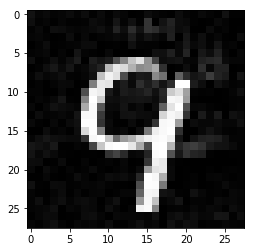

The classification label following attack is 4 from an original classification of 9
The L2 distance of the adversary is 1.6197647105014772
run with verbose=True to see details
Step 0: 1.37168e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.35345e-01, stepsizes = 1.5e-02/6.7e-03:  (took 0.04837 seconds)
Step 100: 1.04980e-01, stepsizes = 2.2e-02/4.4e-03:  (took 0.04773 seconds)
Step 150: 7.44977e-02, stepsizes = 3.4e-02/4.4e-03: d. reduced by 0.89% (6.6664e-04) (took 0.00992 seconds)
Step 200: 5.37401e-02, stepsizes = 3.4e-02/3.0e-03: d. reduced by 0.59% (3.1988e-04) (took 0.00921 seconds)
Step 250: 4.06593e-02, stepsizes = 3.4e-02/3.0e-03: d. reduced by 0.59% (2.4202e-04) (took 0.00915 seconds)
Step 300: 3.27386e-02, stepsizes = 5.1e-02/4.4e-03:  (took 0.00915 seconds)
Step 350: 2.72338e-02, stepsizes = 5.1e-02/3.0e-03: d. reduced by 0.59% (1.6211e-04) (took 0.00926 seconds)
Step 400: 2.27930e-02, stepsizes = 3.4e-02/2.0e-03: d. reduced by 0.39% (9.0314e-05) (took 0.01059 seconds)
Step 4

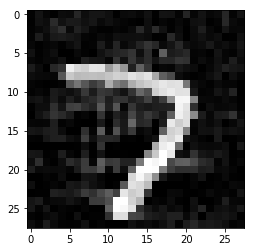

The classification label following attack is 0 from an original classification of 7
The L2 distance of the adversary is 2.8891383388535923
run with verbose=True to see details
Step 0: 7.92199e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 7.50921e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.04571 seconds)
Step 100: 5.63804e-02, stepsizes = 2.2e-02/4.4e-03: d. reduced by 0.59% (3.3560e-04) (took 0.01120 seconds)
Step 150: 4.01942e-02, stepsizes = 3.4e-02/4.4e-03: d. reduced by 0.59% (2.3925e-04) (took 0.01032 seconds)
Step 200: 2.57462e-02, stepsizes = 5.1e-02/6.7e-03: d. reduced by 0.89% (2.3039e-04) (took 0.01022 seconds)
Step 250: 1.59780e-02, stepsizes = 5.1e-02/4.4e-03:  (took 0.01203 seconds)
Step 300: 1.15260e-02, stepsizes = 5.1e-02/3.0e-03: d. reduced by 0.59% (6.8607e-05) (took 0.00957 seconds)
Step 350: 9.19816e-03, stepsizes = 5.1e-02/4.4e-03: d. reduced by 0.89% (8.2310e-05) (took 0.00992 seconds)
Step 400: 7.84366e-03, stepsizes = 3.4e-02/2.0e-03: d. reduced by 0.39% (3.1079e-0

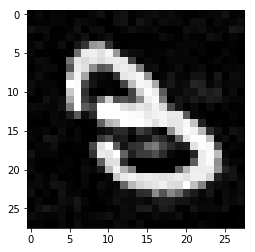

The classification label following attack is 8 from an original classification of 3
The L2 distance of the adversary is 1.6621742902317131
run with verbose=True to see details
Step 0: 1.96045e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.87070e-01, stepsizes = 1.5e-02/1.0e-02:  (took 0.04522 seconds)
Step 100: 1.19497e-01, stepsizes = 2.2e-02/6.7e-03: d. reduced by 1.33% (1.6094e-03) (took 0.02157 seconds)
Step 150: 8.86515e-02, stepsizes = 2.2e-02/4.4e-03: d. reduced by 0.89% (7.9330e-04) (took 0.00978 seconds)
Step 200: 6.58216e-02, stepsizes = 2.2e-02/2.0e-03: d. reduced by 0.39% (2.6081e-04) (took 0.00999 seconds)
Step 250: 4.77194e-02, stepsizes = 5.1e-02/6.7e-03: d. reduced by 0.89% (4.2702e-04) (took 0.00971 seconds)
Step 300: 2.63056e-02, stepsizes = 7.6e-02/1.0e-02:  (took 0.00938 seconds)
Step 350: 1.73684e-02, stepsizes = 5.1e-02/4.4e-03: d. reduced by 0.89% (1.5542e-04) (took 0.00973 seconds)
Step 400: 1.33355e-02, stepsizes = 5.1e-02/3.0e-03: d. reduced by 0.59% (7.9378e-0

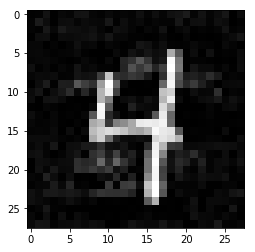

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 2.0713766080097717
run with verbose=True to see details
Step 0: 8.53944e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 8.53944e-02, stepsizes = 1.5e-02/1.0e-02:  (took 0.04769 seconds)
Step 100: 7.67273e-02, stepsizes = 2.2e-02/6.7e-03: d. reduced by 1.33% (1.0334e-03) (took 0.03049 seconds)
Step 150: 4.57446e-02, stepsizes = 3.4e-02/6.7e-03: d. reduced by 1.33% (6.1608e-04) (took 0.01084 seconds)
Step 200: 2.35270e-02, stepsizes = 5.1e-02/1.0e-02: d. reduced by 1.99% (4.7769e-04) (took 0.00995 seconds)
Step 250: 7.27161e-03, stepsizes = 7.6e-02/2.2e-02: d. reduced by 4.45% (3.3861e-04) (took 0.01016 seconds)
Step 300: 5.28351e-03, stepsizes = 1.1e-01/2.2e-02:  (took 0.01007 seconds)
Step 350: 3.40445e-03, stepsizes = 1.1e-01/1.5e-02: d. reduced by 2.98% (1.0448e-04) (took 0.01005 seconds)
Step 400: 2.29926e-03, stepsizes = 1.1e-01/1.0e-02:  (took 0.00976 seconds)
Step 4

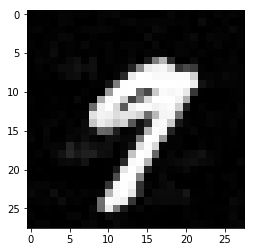

The classification label following attack is 7 from an original classification of 9
The L2 distance of the adversary is 0.7509590897782886
run with verbose=True to see details
Step 0: 5.79240e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 5.63948e-02, stepsizes = 1.0e-02/6.7e-03:  (took 0.04086 seconds)
Step 100: 4.95601e-02, stepsizes = 1.5e-02/4.4e-03: d. reduced by 0.89% (4.4349e-04) (took 0.00284 seconds)
Step 150: 3.35896e-02, stepsizes = 2.2e-02/4.4e-03: d. reduced by 0.89% (3.0058e-04) (took 0.01008 seconds)
Step 200: 2.18002e-02, stepsizes = 3.4e-02/4.4e-03: d. reduced by 0.89% (1.9508e-04) (took 0.01033 seconds)
Step 250: 1.19899e-02, stepsizes = 7.6e-02/1.5e-02:  (took 0.01061 seconds)
Step 300: 6.75860e-03, stepsizes = 7.6e-02/1.0e-02:  (took 0.01023 seconds)
Step 350: 5.00136e-03, stepsizes = 7.6e-02/6.7e-03: d. reduced by 1.33% (6.7358e-05) (took 0.01014 seconds)
Step 400: 4.22232e-03, stepsizes = 3.4e-02/2.0e-03:  (took 0.00911 seconds)
Step 450: 3.66205e-03, stepsizes = 3.4

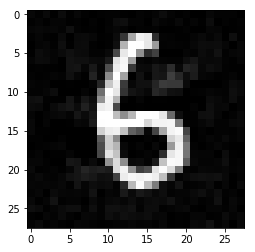

The classification label following attack is 8 from an original classification of 6
The L2 distance of the adversary is 1.2183548424586932
run with verbose=True to see details
Step 0: 4.84104e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 4.34910e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.04691 seconds)
Step 100: 3.49563e-02, stepsizes = 1.5e-02/4.4e-03:  (took 0.03823 seconds)
Step 150: 2.44774e-02, stepsizes = 2.2e-02/3.0e-03: d. reduced by 0.89% (2.1904e-04) (took 0.00959 seconds)
Step 200: 1.63439e-02, stepsizes = 3.4e-02/6.7e-03:  (took 0.00886 seconds)
Step 250: 9.48697e-03, stepsizes = 5.1e-02/6.7e-03: d. reduced by 1.33% (1.2777e-04) (took 0.00964 seconds)
Step 300: 6.40820e-03, stepsizes = 5.1e-02/4.4e-03: d. reduced by 0.89% (5.7344e-05) (took 0.00976 seconds)
Step 350: 4.48613e-03, stepsizes = 7.6e-02/6.7e-03:  (took 0.00938 seconds)
Step 400: 3.89591e-03, stepsizes = 5.1e-02/3.0e-03:  (took 0.00902 seconds)
Step 450: 3.27349e-03, stepsizes = 5.1e-02/2.0e-03: d. reduced by 0.39

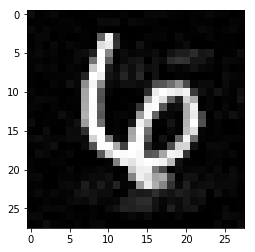

The classification label following attack is 4 from an original classification of 6
The L2 distance of the adversary is 1.1847854924205639
run with verbose=True to see details
Step 0: 6.78831e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 6.69810e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.04498 seconds)
Step 100: 5.40744e-02, stepsizes = 2.2e-02/6.7e-03:  (took 0.04472 seconds)
Step 150: 3.20924e-02, stepsizes = 3.4e-02/4.4e-03: d. reduced by 1.33% (4.3222e-04) (took 0.01632 seconds)
Step 200: 1.89654e-02, stepsizes = 5.1e-02/6.7e-03: d. reduced by 1.33% (2.5542e-04) (took 0.00913 seconds)
Step 250: 1.16148e-02, stepsizes = 5.1e-02/4.4e-03:  (took 0.01050 seconds)
Step 300: 8.13133e-03, stepsizes = 7.6e-02/6.7e-03: d. reduced by 1.33% (1.0951e-04) (took 0.00962 seconds)
Step 350: 5.87316e-03, stepsizes = 7.6e-02/4.4e-03:  (took 0.01073 seconds)
Step 400: 4.61752e-03, stepsizes = 7.6e-02/4.4e-03: d. reduced by 0.89% (4.1320e-05) (took 0.00950 seconds)
Step 450: 3.83786e-03, stepsizes = 5.1

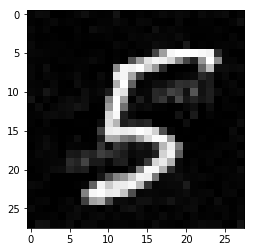

The classification label following attack is 8 from an original classification of 5
The L2 distance of the adversary is 1.3437385622071694
run with verbose=True to see details
Step 0: 1.68899e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.20028e-01, stepsizes = 1.5e-02/1.0e-02:  (took 0.03895 seconds)
Step 100: 1.00192e-01, stepsizes = 2.2e-02/6.7e-03:  (took 0.04197 seconds)
Step 150: 6.64976e-02, stepsizes = 2.2e-02/3.0e-03: d. reduced by 0.89% (5.9505e-04) (took 0.00915 seconds)
Step 200: 5.25505e-02, stepsizes = 2.2e-02/2.0e-03: d. reduced by 0.39% (2.0822e-04) (took 0.00988 seconds)
Step 250: 4.00690e-02, stepsizes = 3.4e-02/4.4e-03: d. reduced by 0.89% (3.5856e-04) (took 0.01022 seconds)
Step 300: 2.90792e-02, stepsizes = 3.4e-02/3.0e-03: d. reduced by 0.59% (1.7309e-04) (took 0.00948 seconds)
Step 350: 2.29331e-02, stepsizes = 3.4e-02/4.4e-03:  (took 0.00933 seconds)
Step 400: 1.79790e-02, stepsizes = 3.4e-02/3.0e-03: d. reduced by 0.59% (1.0702e-04) (took 0.01000 seconds)
Step 4

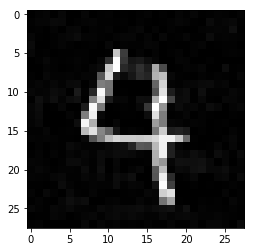

The classification label following attack is 9 from an original classification of 4
The L2 distance of the adversary is 0.7761918439825122
run with verbose=True to see details
Step 0: 1.95533e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.54704e-01, stepsizes = 1.5e-02/6.7e-03:  (took 0.04413 seconds)
Step 100: 1.32951e-01, stepsizes = 1.5e-02/4.4e-03:  (took 0.04180 seconds)
Step 150: 1.08654e-01, stepsizes = 2.2e-02/3.0e-03: d. reduced by 0.59% (6.4675e-04) (took 0.00932 seconds)
Step 200: 7.86119e-02, stepsizes = 5.1e-02/6.7e-03: d. reduced by 0.89% (7.0346e-04) (took 0.01035 seconds)
Step 250: 5.88490e-02, stepsizes = 5.1e-02/4.4e-03: d. reduced by 0.89% (5.2661e-04) (took 0.00936 seconds)
Step 300: 4.39970e-02, stepsizes = 5.1e-02/3.0e-03: d. reduced by 0.59% (2.6189e-04) (took 0.00990 seconds)
Step 350: 3.66035e-02, stepsizes = 3.4e-02/2.0e-03:  (took 0.00923 seconds)
Step 400: 3.22957e-02, stepsizes = 3.4e-02/2.0e-03:  (took 0.00933 seconds)
Step 450: 2.84948e-02, stepsizes = 3.4

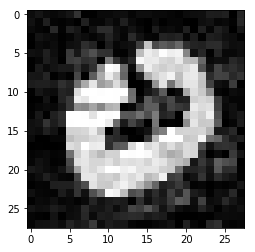

The classification label following attack is 8 from an original classification of 0
The L2 distance of the adversary is 3.748414691820296
run with verbose=True to see details
Step 0: 1.31141e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.19418e-01, stepsizes = 1.5e-02/6.7e-03: d. reduced by 1.33% (1.6083e-03) (took 0.00871 seconds)
Step 100: 9.26145e-02, stepsizes = 1.5e-02/4.4e-03:  (took 0.04290 seconds)
Step 150: 7.02547e-02, stepsizes = 2.2e-02/4.4e-03: d. reduced by 0.89% (6.2867e-04) (took 0.01029 seconds)
Step 200: 4.36087e-02, stepsizes = 3.4e-02/4.4e-03: d. reduced by 0.89% (3.9023e-04) (took 0.00992 seconds)
Step 250: 2.92058e-02, stepsizes = 3.4e-02/4.4e-03: d. reduced by 0.89% (2.6135e-04) (took 0.00970 seconds)
Step 300: 2.04458e-02, stepsizes = 5.1e-02/4.4e-03:  (took 0.00933 seconds)
Step 350: 1.58389e-02, stepsizes = 5.1e-02/3.0e-03: d. reduced by 0.59% (9.4279e-05) (took 0.01018 seconds)
Step 400: 1.31772e-02, stepsizes = 5.1e-02/3.0e-03:  (took 0.00912 seconds)
Step 45

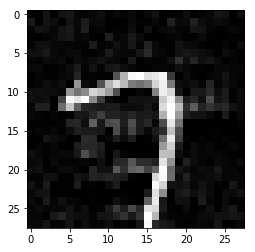

The classification label following attack is 8 from an original classification of 7
The L2 distance of the adversary is 2.2417579234370826
run with verbose=True to see details
Step 0: 1.80909e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.69204e-01, stepsizes = 1.5e-02/6.7e-03: d. reduced by 1.33% (2.2788e-03) (took 0.02041 seconds)
Step 100: 1.30665e-01, stepsizes = 1.5e-02/4.4e-03:  (took 0.03982 seconds)
Step 150: 9.34212e-02, stepsizes = 2.2e-02/3.0e-03: d. reduced by 0.89% (8.3598e-04) (took 0.01049 seconds)
Step 200: 6.58143e-02, stepsizes = 3.4e-02/4.4e-03: d. reduced by 0.89% (5.8894e-04) (took 0.00903 seconds)
Step 250: 3.44703e-02, stepsizes = 5.1e-02/1.0e-02: d. reduced by 1.99% (6.9989e-04) (took 0.01032 seconds)
Step 300: 1.51123e-02, stepsizes = 7.6e-02/1.0e-02:  (took 0.01043 seconds)
Step 350: 8.96111e-03, stepsizes = 7.6e-02/6.7e-03:  (took 0.01167 seconds)
Step 400: 5.76279e-03, stepsizes = 7.6e-02/6.7e-03: d. reduced by 1.33% (7.7612e-05) (took 0.01171 seconds)
Step 4

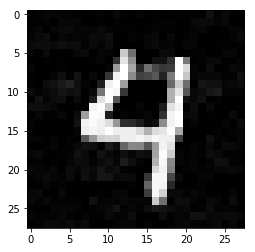

The classification label following attack is 9 from an original classification of 4
The L2 distance of the adversary is 1.269811626177345
run with verbose=True to see details
Step 0: 1.90275e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.80361e-01, stepsizes = 1.5e-02/6.7e-03:  (took 0.04789 seconds)
Step 100: 1.39912e-01, stepsizes = 2.2e-02/4.4e-03:  (took 0.04134 seconds)
Step 150: 1.00928e-01, stepsizes = 3.4e-02/4.4e-03: d. reduced by 0.89% (9.0315e-04) (took 0.00999 seconds)
Step 200: 6.40680e-02, stepsizes = 5.1e-02/4.4e-03: d. reduced by 0.89% (5.7331e-04) (took 0.01011 seconds)
Step 250: 4.73184e-02, stepsizes = 5.1e-02/6.7e-03: d. reduced by 1.33% (6.3728e-04) (took 0.00923 seconds)
Step 300: 3.57375e-02, stepsizes = 5.1e-02/4.4e-03: d. reduced by 0.89% (3.1980e-04) (took 0.01068 seconds)
Step 350: 2.82179e-02, stepsizes = 7.6e-02/4.4e-03:  (took 0.00930 seconds)
Step 400: 2.40374e-02, stepsizes = 5.1e-02/3.0e-03:  (took 0.01061 seconds)
Step 450: 2.14742e-02, stepsizes = 3.4e

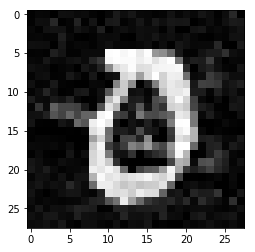

The classification label following attack is 8 from an original classification of 0
The L2 distance of the adversary is 3.068636627978338
run with verbose=True to see details
Step 0: 1.03734e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 9.96530e-02, stepsizes = 1.5e-02/1.0e-02:  (took 0.03912 seconds)
Step 100: 7.42456e-02, stepsizes = 1.5e-02/6.7e-03: d. reduced by 1.33% (9.9993e-04) (took 0.02207 seconds)
Step 150: 4.86150e-02, stepsizes = 2.2e-02/4.4e-03: d. reduced by 0.89% (4.3503e-04) (took 0.00981 seconds)
Step 200: 2.67486e-02, stepsizes = 3.4e-02/6.7e-03:  (took 0.00971 seconds)
Step 250: 1.66055e-02, stepsizes = 3.4e-02/4.4e-03: d. reduced by 0.89% (1.4859e-04) (took 0.00971 seconds)
Step 300: 1.13551e-02, stepsizes = 5.1e-02/4.4e-03: d. reduced by 0.89% (1.0161e-04) (took 0.01179 seconds)
Step 350: 7.37057e-03, stepsizes = 7.6e-02/6.7e-03: d. reduced by 1.33% (9.9266e-05) (took 0.01040 seconds)
Step 400: 5.51630e-03, stepsizes = 5.1e-02/4.4e-03: d. reduced by 0.89% (4.9363e-05

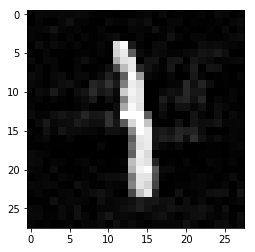

The classification label following attack is 4 from an original classification of 1
The L2 distance of the adversary is 1.3002240427069542
run with verbose=True to see details
Step 0: 7.88889e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 7.88889e-02, stepsizes = 1.0e-02/6.7e-03:  (took 0.04529 seconds)
Step 100: 7.47828e-02, stepsizes = 1.5e-02/4.4e-03:  (took 0.03916 seconds)
Step 150: 5.42647e-02, stepsizes = 2.2e-02/3.0e-03: d. reduced by 0.89% (4.8559e-04) (took 0.00960 seconds)
Step 200: 3.98413e-02, stepsizes = 5.1e-02/6.7e-03:  (took 0.01008 seconds)
Step 250: 2.50590e-02, stepsizes = 5.1e-02/4.4e-03: d. reduced by 0.89% (2.2424e-04) (took 0.00976 seconds)
Step 300: 1.70828e-02, stepsizes = 7.6e-02/6.7e-03: d. reduced by 1.33% (2.3007e-04) (took 0.00926 seconds)
Step 350: 1.36095e-02, stepsizes = 7.6e-02/4.4e-03: d. reduced by 0.89% (1.2178e-04) (took 0.00909 seconds)
Step 400: 1.10889e-02, stepsizes = 5.1e-02/3.0e-03:  (took 0.01003 seconds)
Step 450: 9.93316e-03, stepsizes = 3.4

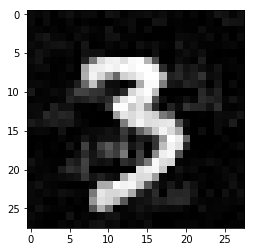

The classification label following attack is 8 from an original classification of 3
The L2 distance of the adversary is 2.0327740471309763
run with verbose=True to see details
Step 0: 1.12701e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 7.95813e-02, stepsizes = 1.0e-02/6.7e-03: d. reduced by 1.33% (1.0718e-03) (took 0.00437 seconds)
Step 100: 5.18601e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.03865 seconds)
Step 150: 3.32049e-02, stepsizes = 2.2e-02/6.7e-03: d. reduced by 1.33% (4.4720e-04) (took 0.00984 seconds)
Step 200: 1.74582e-02, stepsizes = 3.4e-02/6.7e-03:  (took 0.00928 seconds)
Step 250: 8.41377e-03, stepsizes = 5.1e-02/6.7e-03: d. reduced by 1.33% (1.1332e-04) (took 0.01020 seconds)
Step 300: 5.78217e-03, stepsizes = 7.6e-02/1.5e-02:  (took 0.00928 seconds)
Step 350: 4.65183e-03, stepsizes = 5.1e-02/6.7e-03:  (took 0.00955 seconds)
Step 400: 4.05167e-03, stepsizes = 5.1e-02/4.4e-03:  (took 0.01250 seconds)
Step 450: 3.40062e-03, stepsizes = 3.4e-02/2.0e-03:  (took 0.00928 sec

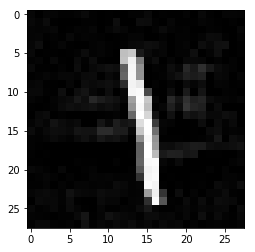

The classification label following attack is 4 from an original classification of 1
The L2 distance of the adversary is 1.0868818530186521
run with verbose=True to see details
Step 0: 1.27201e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.22197e-01, stepsizes = 1.5e-02/6.7e-03:  (took 0.04746 seconds)
Step 100: 9.86654e-02, stepsizes = 2.2e-02/4.4e-03: d. reduced by 0.89% (8.8291e-04) (took 0.01538 seconds)
Step 150: 6.43358e-02, stepsizes = 3.4e-02/4.4e-03: d. reduced by 0.89% (5.7571e-04) (took 0.01100 seconds)
Step 200: 3.85322e-02, stepsizes = 5.1e-02/4.4e-03:  (took 0.01009 seconds)
Step 250: 2.49025e-02, stepsizes = 5.1e-02/4.4e-03: d. reduced by 0.89% (2.2284e-04) (took 0.01129 seconds)
Step 300: 1.87818e-02, stepsizes = 5.1e-02/3.0e-03:  (took 0.01226 seconds)
Step 350: 1.53499e-02, stepsizes = 5.1e-02/3.0e-03: d. reduced by 0.59% (9.1368e-05) (took 0.00992 seconds)
Step 400: 1.34541e-02, stepsizes = 3.4e-02/1.3e-03: d. reduced by 0.26% (3.5505e-05) (took 0.00967 seconds)
Step 4

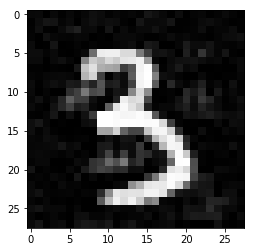

The classification label following attack is 8 from an original classification of 3
The L2 distance of the adversary is 2.1417131489377987
run with verbose=True to see details
Step 0: 1.46168e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.34894e-01, stepsizes = 1.5e-02/6.7e-03:  (took 0.04349 seconds)
Step 100: 1.20138e-01, stepsizes = 2.2e-02/4.4e-03:  (took 0.03619 seconds)
Step 150: 9.81756e-02, stepsizes = 2.2e-02/3.0e-03: d. reduced by 0.59% (5.8438e-04) (took 0.01067 seconds)
Step 200: 7.86647e-02, stepsizes = 3.4e-02/4.4e-03: d. reduced by 0.89% (7.0393e-04) (took 0.00932 seconds)
Step 250: 5.84582e-02, stepsizes = 3.4e-02/3.0e-03: d. reduced by 0.59% (3.4796e-04) (took 0.01081 seconds)
Step 300: 2.89459e-02, stepsizes = 7.6e-02/1.5e-02:  (took 0.00920 seconds)
Step 350: 1.60407e-02, stepsizes = 7.6e-02/1.5e-02:  (took 0.00964 seconds)
Step 400: 1.22220e-02, stepsizes = 7.6e-02/1.0e-02:  (took 0.00977 seconds)
Step 450: 8.45738e-03, stepsizes = 7.6e-02/6.7e-03: d. reduced by 1.33

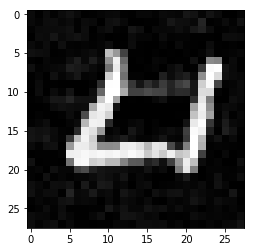

The classification label following attack is 0 from an original classification of 4
The L2 distance of the adversary is 1.5123991621218942
run with verbose=True to see details
Step 0: 9.44609e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 9.07448e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.03654 seconds)
Step 100: 7.83318e-02, stepsizes = 2.2e-02/6.7e-03: d. reduced by 1.33% (1.0550e-03) (took 0.01021 seconds)
Step 150: 5.57517e-02, stepsizes = 2.2e-02/3.0e-03: d. reduced by 0.59% (3.3185e-04) (took 0.01045 seconds)
Step 200: 3.97460e-02, stepsizes = 3.4e-02/4.4e-03: d. reduced by 0.89% (3.5567e-04) (took 0.01046 seconds)
Step 250: 2.80778e-02, stepsizes = 5.1e-02/4.4e-03: d. reduced by 0.89% (2.5125e-04) (took 0.01135 seconds)
Step 300: 1.93985e-02, stepsizes = 7.6e-02/6.7e-03: d. reduced by 1.33% (2.6126e-04) (took 0.00939 seconds)
Step 350: 1.43895e-02, stepsizes = 7.6e-02/4.4e-03:  (took 0.00992 seconds)
Step 400: 1.16549e-02, stepsizes = 5.1e-02/3.0e-03: d. reduced by 0.59% (6.9375e-0

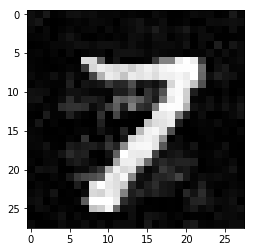

The classification label following attack is 8 from an original classification of 7
The L2 distance of the adversary is 2.050209642630782
run with verbose=True to see details
Step 0: 1.48626e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.44702e-01, stepsizes = 1.5e-02/6.7e-03: d. reduced by 1.33% (1.9488e-03) (took 0.02444 seconds)
Step 100: 1.24355e-01, stepsizes = 2.2e-02/6.7e-03: d. reduced by 1.33% (1.6748e-03) (took 0.02589 seconds)
Step 150: 9.73267e-02, stepsizes = 3.4e-02/4.4e-03:  (took 0.01003 seconds)
Step 200: 6.72308e-02, stepsizes = 5.1e-02/1.0e-02:  (took 0.01159 seconds)
Step 250: 4.49755e-02, stepsizes = 7.6e-02/1.0e-02:  (took 0.01036 seconds)
Step 300: 3.23995e-02, stepsizes = 5.1e-02/4.4e-03: d. reduced by 0.89% (2.8993e-04) (took 0.00924 seconds)
Step 350: 2.64761e-02, stepsizes = 3.4e-02/2.0e-03:  (took 0.00936 seconds)
Step 400: 2.24245e-02, stepsizes = 3.4e-02/1.3e-03:  (took 0.01067 seconds)
Step 450: 1.99164e-02, stepsizes = 3.4e-02/2.0e-03: d. reduced by 0.39%

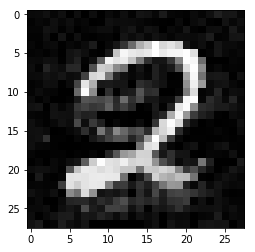

The classification label following attack is 8 from an original classification of 2
The L2 distance of the adversary is 2.8686471290615136
run with verbose=True to see details
Step 0: 1.11772e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 7.83753e-02, stepsizes = 1.0e-02/6.7e-03: d. reduced by 1.33% (1.0555e-03) (took 0.00243 seconds)
Step 100: 6.41253e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.04637 seconds)
Step 150: 4.35116e-02, stepsizes = 2.2e-02/4.4e-03: d. reduced by 0.89% (3.8936e-04) (took 0.01058 seconds)
Step 200: 1.90514e-02, stepsizes = 3.4e-02/1.0e-02: d. reduced by 1.99% (3.8682e-04) (took 0.00960 seconds)
Step 250: 7.86726e-03, stepsizes = 5.1e-02/1.0e-02: d. reduced by 1.99% (1.5974e-04) (took 0.00977 seconds)
Step 300: 4.82547e-03, stepsizes = 5.1e-02/6.7e-03: d. reduced by 1.33% (6.4989e-05) (took 0.01017 seconds)
Step 350: 3.03553e-03, stepsizes = 5.1e-02/3.0e-03: d. reduced by 0.89% (2.7163e-05) (took 0.00953 seconds)
Step 400: 2.35877e-03, stepsizes = 5.1e-02/4.4e-03

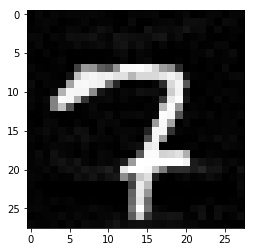

The classification label following attack is 2 from an original classification of 7
The L2 distance of the adversary is 0.8931389879495274
run with verbose=True to see details
Step 0: 1.37507e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.35679e-01, stepsizes = 1.5e-02/6.7e-03:  (took 0.04227 seconds)
Step 100: 1.04785e-01, stepsizes = 2.2e-02/6.7e-03:  (took 0.03622 seconds)
Step 150: 6.16554e-02, stepsizes = 3.4e-02/6.7e-03: d. reduced by 1.33% (8.3037e-04) (took 0.00923 seconds)
Step 200: 3.48435e-02, stepsizes = 3.4e-02/4.4e-03: d. reduced by 0.89% (3.1180e-04) (took 0.00972 seconds)
Step 250: 2.50603e-02, stepsizes = 3.4e-02/3.0e-03: d. reduced by 0.59% (1.4917e-04) (took 0.01031 seconds)
Step 300: 1.87342e-02, stepsizes = 5.1e-02/4.4e-03: d. reduced by 0.89% (1.6764e-04) (took 0.00947 seconds)
Step 350: 1.44702e-02, stepsizes = 3.4e-02/3.0e-03: d. reduced by 0.59% (8.6132e-05) (took 0.01038 seconds)
Step 400: 1.13678e-02, stepsizes = 3.4e-02/2.0e-03: d. reduced by 0.39% (4.5043e-0

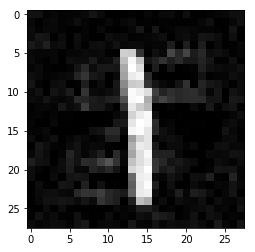

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 1.9777824285528711
run with verbose=True to see details
Step 0: 6.86683e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 6.59669e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.04373 seconds)
Step 100: 5.09371e-02, stepsizes = 2.2e-02/4.4e-03:  (took 0.03943 seconds)
Step 150: 3.55086e-02, stepsizes = 3.4e-02/4.4e-03: d. reduced by 0.89% (3.1775e-04) (took 0.01016 seconds)
Step 200: 2.38527e-02, stepsizes = 5.1e-02/6.7e-03: d. reduced by 0.89% (2.1345e-04) (took 0.01060 seconds)
Step 250: 1.56884e-02, stepsizes = 5.1e-02/4.4e-03: d. reduced by 0.89% (1.4039e-04) (took 0.01053 seconds)
Step 300: 1.05511e-02, stepsizes = 7.6e-02/6.7e-03:  (took 0.00941 seconds)
Step 350: 9.42451e-03, stepsizes = 5.1e-02/3.0e-03:  (took 0.00968 seconds)
Step 400: 7.70241e-03, stepsizes = 5.1e-02/3.0e-03: d. reduced by 0.59% (4.5848e-05) (took 0.01046 seconds)
Step 450: 6.73327e-03, stepsizes = 5.1

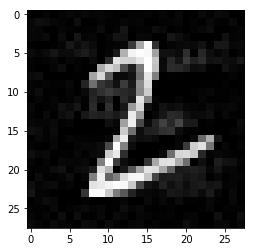

The classification label following attack is 8 from an original classification of 2
The L2 distance of the adversary is 1.5817408938267976
run with verbose=True to see details
Step 0: 1.10538e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.09069e-01, stepsizes = 1.5e-02/6.7e-03:  (took 0.03891 seconds)
Step 100: 9.12688e-02, stepsizes = 2.2e-02/6.7e-03: d. reduced by 0.89% (8.1672e-04) (took 0.04113 seconds)
Step 150: 5.09901e-02, stepsizes = 3.4e-02/6.7e-03:  (took 0.00911 seconds)
Step 200: 2.76826e-02, stepsizes = 5.1e-02/1.0e-02: d. reduced by 1.33% (3.7283e-04) (took 0.01088 seconds)
Step 250: 1.77891e-02, stepsizes = 5.1e-02/1.0e-02:  (took 0.01033 seconds)
Step 300: 1.03454e-02, stepsizes = 5.1e-02/4.4e-03:  (took 0.01018 seconds)
Step 350: 7.57414e-03, stepsizes = 5.1e-02/3.0e-03:  (took 0.01019 seconds)
Step 400: 5.73053e-03, stepsizes = 5.1e-02/3.0e-03: d. reduced by 0.59% (3.4110e-05) (took 0.00946 seconds)
Step 450: 4.91125e-03, stepsizes = 3.4e-02/2.0e-03:  (took 0.00954 sec

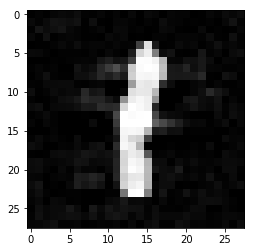

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 1.4182775803005512
run with verbose=True to see details
Step 0: 1.13714e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 9.94748e-02, stepsizes = 1.0e-02/6.7e-03:  (took 0.03953 seconds)
Step 100: 7.51110e-02, stepsizes = 1.5e-02/4.4e-03: d. reduced by 1.33% (1.0116e-03) (took 0.01746 seconds)
Step 150: 5.43461e-02, stepsizes = 2.2e-02/4.4e-03: d. reduced by 0.59% (3.2349e-04) (took 0.00923 seconds)
Step 200: 3.43383e-02, stepsizes = 3.4e-02/1.0e-02: d. reduced by 1.33% (4.6246e-04) (took 0.01038 seconds)
Step 250: 2.14966e-02, stepsizes = 5.1e-02/6.7e-03: d. reduced by 1.33% (2.8951e-04) (took 0.00990 seconds)
Step 300: 1.00845e-02, stepsizes = 7.6e-02/1.0e-02: d. reduced by 1.99% (2.0476e-04) (took 0.00989 seconds)
Step 350: 7.29600e-03, stepsizes = 5.1e-02/4.4e-03: d. reduced by 0.89% (6.5288e-05) (took 0.01010 seconds)
Step 400: 5.20071e-03, stepsizes = 3.4e-02/3.0e-03

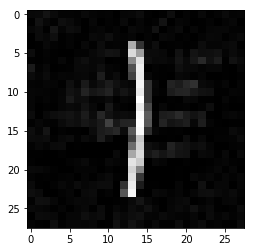

The classification label following attack is 4 from an original classification of 1
The L2 distance of the adversary is 1.2042259047587391
run with verbose=True to see details
Step 0: 8.71739e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 8.60155e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.05078 seconds)
Step 100: 7.32670e-02, stepsizes = 2.2e-02/4.4e-03:  (took 0.04422 seconds)
Step 150: 4.88498e-02, stepsizes = 3.4e-02/6.7e-03: d. reduced by 0.89% (4.3713e-04) (took 0.01000 seconds)
Step 200: 4.13260e-02, stepsizes = 5.1e-02/6.7e-03: d. reduced by 1.33% (5.5657e-04) (took 0.00988 seconds)
Step 250: 2.74804e-02, stepsizes = 7.6e-02/1.0e-02:  (took 0.01017 seconds)
Step 300: 1.91442e-02, stepsizes = 7.6e-02/6.7e-03: d. reduced by 1.33% (2.5783e-04) (took 0.00997 seconds)
Step 350: 1.46522e-02, stepsizes = 7.6e-02/4.4e-03:  (took 0.00906 seconds)
Step 400: 1.25695e-02, stepsizes = 3.4e-02/1.3e-03: d. reduced by 0.39% (4.9805e-05) (took 0.00977 seconds)
Step 450: 1.10467e-02, stepsizes = 3.4

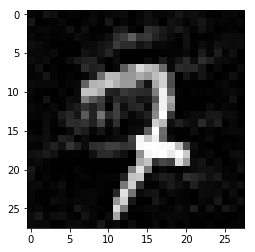

The classification label following attack is 4 from an original classification of 7
The L2 distance of the adversary is 2.2593899588480806
run with verbose=True to see details
Step 0: 1.28543e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.25149e-01, stepsizes = 1.5e-02/6.7e-03:  (took 0.04734 seconds)
Step 100: 1.16017e-01, stepsizes = 1.5e-02/4.4e-03: d. reduced by 0.89% (1.0382e-03) (took 0.02973 seconds)
Step 150: 9.91317e-02, stepsizes = 2.2e-02/3.0e-03: d. reduced by 0.59% (5.9007e-04) (took 0.00975 seconds)
Step 200: 7.11850e-02, stepsizes = 3.4e-02/4.4e-03: d. reduced by 0.89% (6.3700e-04) (took 0.01057 seconds)
Step 250: 4.08563e-02, stepsizes = 5.1e-02/1.0e-02: d. reduced by 1.99% (8.2955e-04) (took 0.00928 seconds)
Step 300: 1.72063e-02, stepsizes = 7.6e-02/1.0e-02: d. reduced by 1.99% (3.4936e-04) (took 0.00898 seconds)
Step 350: 1.25954e-02, stepsizes = 5.1e-02/1.0e-02:  (took 0.00935 seconds)
Step 400: 1.05139e-02, stepsizes = 5.1e-02/6.7e-03:  (took 0.00908 seconds)
Step 4

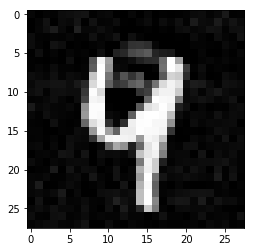

The classification label following attack is 9 from an original classification of 4
The L2 distance of the adversary is 1.6806191212854593
run with verbose=True to see details
Step 0: 4.52971e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 4.12477e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.04396 seconds)
Step 100: 2.58256e-02, stepsizes = 1.5e-02/4.4e-03:  (took 0.04330 seconds)
Step 150: 1.72960e-02, stepsizes = 2.2e-02/4.4e-03: d. reduced by 0.89% (1.5477e-04) (took 0.01060 seconds)
Step 200: 1.18972e-02, stepsizes = 5.1e-02/6.7e-03: d. reduced by 0.89% (1.0646e-04) (took 0.00937 seconds)
Step 250: 7.96429e-03, stepsizes = 5.1e-02/6.7e-03:  (took 0.00935 seconds)
Step 300: 5.81325e-03, stepsizes = 5.1e-02/3.0e-03: d. reduced by 0.59% (3.4603e-05) (took 0.00934 seconds)
Step 350: 4.49030e-03, stepsizes = 7.6e-02/3.0e-03:  (took 0.00926 seconds)
Step 400: 3.72854e-03, stepsizes = 5.1e-02/2.0e-03: d. reduced by 0.39% (1.4774e-05) (took 0.01017 seconds)
Step 450: 3.22960e-03, stepsizes = 3.4

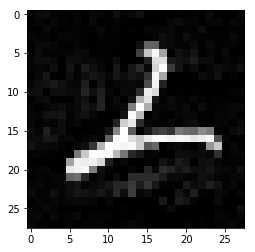

The classification label following attack is 4 from an original classification of 2
The L2 distance of the adversary is 1.2154709940297883
run with verbose=True to see details
Step 0: 8.41090e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 7.35771e-02, stepsizes = 1.5e-02/1.0e-02:  (took 0.04037 seconds)
Step 100: 5.90015e-02, stepsizes = 2.2e-02/6.7e-03:  (took 0.04042 seconds)
Step 150: 3.34069e-02, stepsizes = 3.4e-02/1.0e-02:  (took 0.01028 seconds)
Step 200: 2.14749e-02, stepsizes = 5.1e-02/6.7e-03: d. reduced by 1.99% (4.3603e-04) (took 0.01221 seconds)
Step 250: 1.64336e-02, stepsizes = 5.1e-02/4.4e-03:  (took 0.00926 seconds)
Step 300: 1.11044e-02, stepsizes = 5.1e-02/4.4e-03: d. reduced by 0.89% (9.9368e-05) (took 0.00951 seconds)
Step 350: 8.12982e-03, stepsizes = 5.1e-02/4.4e-03: d. reduced by 0.89% (7.2750e-05) (took 0.00973 seconds)
Step 400: 6.64412e-03, stepsizes = 5.1e-02/3.0e-03: d. reduced by 0.59% (3.9548e-05) (took 0.00970 seconds)
Step 450: 5.69409e-03, stepsizes = 7.6

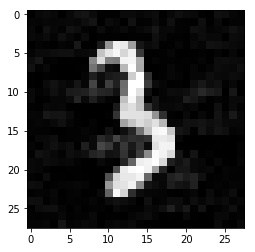

The classification label following attack is 1 from an original classification of 3
The L2 distance of the adversary is 1.5601230543267397
run with verbose=True to see details
Step 0: 5.01772e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 4.63070e-02, stepsizes = 1.0e-02/6.7e-03: d. reduced by 1.33% (6.2366e-04) (took 0.00575 seconds)
Step 100: 3.19850e-02, stepsizes = 1.5e-02/4.4e-03: d. reduced by 0.89% (2.8622e-04) (took 0.00369 seconds)
Step 150: 1.79171e-02, stepsizes = 2.2e-02/6.7e-03: d. reduced by 1.33% (2.4130e-04) (took 0.01075 seconds)
Step 200: 9.80940e-03, stepsizes = 5.1e-02/1.0e-02: d. reduced by 1.33% (1.3211e-04) (took 0.01035 seconds)
Step 250: 5.66384e-03, stepsizes = 5.1e-02/6.7e-03: d. reduced by 1.33% (7.6280e-05) (took 0.01062 seconds)
Step 300: 3.03405e-03, stepsizes = 7.6e-02/6.7e-03: d. reduced by 1.33% (4.0862e-05) (took 0.00968 seconds)
Step 350: 1.84136e-03, stepsizes = 7.6e-02/4.4e-03:  (took 0.00965 seconds)
Step 400: 1.43485e-03, stepsizes = 5.1e-02/2.0e-03

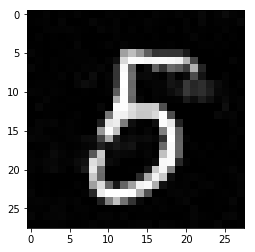

The classification label following attack is 8 from an original classification of 5
The L2 distance of the adversary is 0.7305635151436356
run with verbose=True to see details
Step 0: 1.21719e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 9.62902e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.04611 seconds)
Step 100: 6.80021e-02, stepsizes = 2.2e-02/6.7e-03: d. reduced by 1.33% (9.1584e-04) (took 0.00321 seconds)
Step 150: 3.89478e-02, stepsizes = 3.4e-02/4.4e-03: d. reduced by 1.33% (5.2454e-04) (took 0.00978 seconds)
Step 200: 2.26971e-02, stepsizes = 5.1e-02/6.7e-03: d. reduced by 1.99% (4.6084e-04) (took 0.01013 seconds)
Step 250: 1.34659e-02, stepsizes = 7.6e-02/6.7e-03: d. reduced by 1.33% (1.8136e-04) (took 0.00954 seconds)
Step 300: 1.01677e-02, stepsizes = 7.6e-02/6.7e-03: d. reduced by 1.33% (1.3694e-04) (took 0.00912 seconds)
Step 350: 8.43162e-03, stepsizes = 5.1e-02/4.4e-03:  (took 0.00931 seconds)
Step 400: 7.19058e-03, stepsizes = 5.1e-02/4.4e-03: d. reduced by 0.39% (2.8492e-0

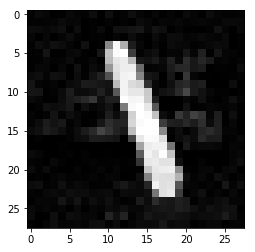

The classification label following attack is 4 from an original classification of 1
The L2 distance of the adversary is 1.6548818683261928
run with verbose=True to see details
Step 0: 1.15319e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.15319e-01, stepsizes = 1.5e-02/6.7e-03:  (took 0.05355 seconds)
Step 100: 1.03615e-01, stepsizes = 2.2e-02/6.7e-03:  (took 0.03882 seconds)
Step 150: 6.87735e-02, stepsizes = 2.2e-02/4.4e-03: d. reduced by 0.89% (6.1542e-04) (took 0.00944 seconds)
Step 200: 4.59236e-02, stepsizes = 5.1e-02/1.0e-02:  (took 0.00924 seconds)
Step 250: 2.74278e-02, stepsizes = 5.1e-02/6.7e-03: d. reduced by 1.33% (3.6939e-04) (took 0.00950 seconds)
Step 300: 1.67209e-02, stepsizes = 7.6e-02/6.7e-03: d. reduced by 1.33% (2.2519e-04) (took 0.01030 seconds)
Step 350: 1.26829e-02, stepsizes = 7.6e-02/4.4e-03: d. reduced by 0.89% (1.1349e-04) (took 0.00950 seconds)
Step 400: 1.02721e-02, stepsizes = 5.1e-02/3.0e-03: d. reduced by 0.59% (6.1143e-05) (took 0.00966 seconds)
Step 4

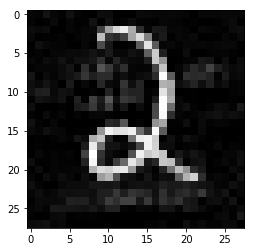

The classification label following attack is 8 from an original classification of 2
The L2 distance of the adversary is 1.8968905830006573
run with verbose=True to see details
Step 0: 1.53615e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.53615e-01, stepsizes = 1.5e-02/6.7e-03:  (took 0.04440 seconds)
Step 100: 1.30260e-01, stepsizes = 2.2e-02/4.4e-03:  (took 0.03865 seconds)
Step 150: 8.86774e-02, stepsizes = 3.4e-02/4.4e-03: d. reduced by 0.89% (7.9353e-04) (took 0.00948 seconds)
Step 200: 5.10215e-02, stepsizes = 3.4e-02/4.4e-03: d. reduced by 0.89% (4.5657e-04) (took 0.00976 seconds)
Step 250: 2.11109e-02, stepsizes = 5.1e-02/1.5e-02: d. reduced by 2.98% (6.4787e-04) (took 0.00850 seconds)
Step 300: 5.09931e-03, stepsizes = 7.6e-02/1.5e-02: d. reduced by 2.98% (1.5649e-04) (took 0.00975 seconds)
Step 350: 2.23358e-03, stepsizes = 7.6e-02/1.0e-02:  (took 0.01177 seconds)
Step 400: 1.66370e-03, stepsizes = 5.1e-02/4.4e-03: d. reduced by 0.89% (1.4888e-05) (took 0.00962 seconds)
Step 4

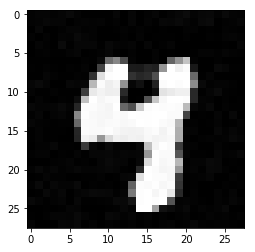

The classification label following attack is 9 from an original classification of 4
The L2 distance of the adversary is 0.6620802751270031
run with verbose=True to see details
Step 0: 2.47707e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 2.24052e-01, stepsizes = 1.5e-02/6.7e-03:  (took 0.03775 seconds)
Step 100: 1.40281e-01, stepsizes = 2.2e-02/6.7e-03: d. reduced by 1.33% (1.8893e-03) (took 0.00401 seconds)
Step 150: 9.20488e-02, stepsizes = 3.4e-02/1.0e-02:  (took 0.00930 seconds)
Step 200: 7.09054e-02, stepsizes = 3.4e-02/6.7e-03: d. reduced by 1.33% (9.5494e-04) (took 0.00972 seconds)
Step 250: 3.48681e-02, stepsizes = 5.1e-02/1.0e-02: d. reduced by 1.33% (4.6960e-04) (took 0.00959 seconds)
Step 300: 2.15281e-02, stepsizes = 5.1e-02/6.7e-03: d. reduced by 1.33% (2.8994e-04) (took 0.01007 seconds)
Step 350: 1.46064e-02, stepsizes = 5.1e-02/4.4e-03: d. reduced by 0.89% (1.3071e-04) (took 0.00983 seconds)
Step 400: 1.13149e-02, stepsizes = 3.4e-02/2.0e-03: d. reduced by 0.59% (6.7350e-0

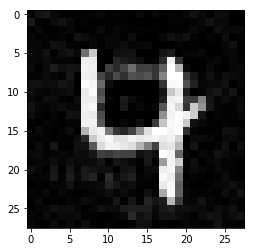

The classification label following attack is 9 from an original classification of 4
The L2 distance of the adversary is 1.6693454313447533


In [287]:
num_images_to_attack = 50
num_iterations = 1000
adversary_found, adversary_distance, adversary_arrays = evaluate_l2_BoundaryAttack_resistance_CustomModel(model_prediction_function=cnn_predictions,
                                                                                       model_weights="/MNIST_LeNet5_CNN.ckpt",
                                                                                      var_list=var_list_LeNet,
                                                                                       num_images_to_attack=num_images_to_attack, 
                                                                                       num_iterations=num_iterations,
                                                                                      temp_batch_size=None)


In [0]:
np.savetxt("StandardCNN_adversaries.csv", 
           np.reshape(adversary_arrays, [adversary_arrays.shape[0], adversary_arrays.shape[1]*adversary_arrays.shape[2]]), 
                      delimiter=',')

In [0]:
success_ratio = np.sum(adversary_found)/num_images_to_attack
mean_distance_successful_attacks = np.sum(adversary_distance)/np.sum(adversary_found)

In [290]:
print("The success ratio is " + str(success_ratio))
print("The mean distance is " + str(mean_distance_successful_attacks))

The success ratio is 1.0
The mean distance is 1.804995619404986


Assessing the simple CNN model found 100% misclassification of the Bounday Attack, using a *mean* l-2 perturbation of only 1.735; note this is actually a slightly larger distance necesary than that found when attacking the Madry model. This fits with the notion that the Madry method actually displays poor resistance to l-2 attacks from the Boundary Attack, as it has overfit on l-infinity attacks. This result is confirmed in the earlier discussed paper by Schott et al. Note this result was based on a sample of 50 images, allowing the BoundaryAttack to perform 1000 iterations for each.

##Execute the Boundary Attack on a Binding-Capable CNN

###Model Setup

The following demonstrates the use of the Boundary Attack Method against a convolutional neural network model trained on MNIST. This model has been augmented in an attempt to capture 'hierarchical binding information' - essentially how low-level features are driving high level features. Whether this confers resistance to the l-2 based Boundary Attack is then explored. Note that the model, unlike the Madry et al method, receives *no* training on adversarial examples.

In [0]:
#Define weight and bias variable dictionaries, initialize values, and add L-2 regularization 

initializer = tf.contrib.layers.xavier_initializer()
regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)



weights_Binding = {
    'conv_W1_bind' : tf.get_variable('CW1_bind', shape=(5, 5, 1, 6), initializer=initializer, regularizer=regularizer),
    'conv_W2_bind' : tf.get_variable('CW2_bind', shape=(5, 5, 6, 16), initializer=initializer, regularizer=regularizer),
    'dense_W1_bind' : tf.get_variable('DW1_bind', shape=(400+1600, 120), initializer=initializer, regularizer=regularizer),
    'dense_W2_bind' : tf.get_variable('DW2_bind', shape=(120, 84), initializer=initializer, regularizer=regularizer),
    'output_W_bind' : tf.get_variable('OW_bind', shape=(84, num_classes), initializer=initializer, regularizer=regularizer)
}


biases_Binding = {
    'conv_b1_bind' : tf.get_variable('Cb1_bind', shape=(6), initializer=initializer, regularizer=regularizer),
    'conv_b2_bind' : tf.get_variable('Cb2_bind', shape=(16), initializer=initializer, regularizer=regularizer),
    'dense_b1_bind' : tf.get_variable('Db1_bind', shape=(120), initializer=initializer, regularizer=regularizer),
    'dense_b2_bind' : tf.get_variable('Db2_bind', shape=(84), initializer=initializer, regularizer=regularizer),
    'output_b_bind' : tf.get_variable('Ob_bind', shape=(num_classes), initializer=initializer, regularizer=regularizer)
}


In [0]:
var_list_Binding = [weights_Binding['conv_W1_bind'], weights_Binding['conv_W2_bind'], weights_Binding['dense_W1_bind'], 
                    weights_Binding['dense_W2_bind'], weights_Binding['output_W_bind'], biases_Binding['conv_b1_bind'], 
                    biases_Binding['conv_b2_bind'], biases_Binding['dense_b1_bind'], biases_Binding['dense_b2_bind'], 
                    biases_Binding['output_b_bind']]

In [0]:
#Declare placeholders for the input features and labels
#The first dimension of the palceholder shape is set to None as this will later be defined by the batch size

x = tf.placeholder(training_data.dtype, [None, 28, 28, 1])
y = tf.placeholder(training_labels.dtype, [None, num_classes])
keep_prob = tf.placeholder(tf.float32)
# batch_size_placeholder = tf.placeholder(tf.int32, shape=())

In [0]:
#Define training parameters
batch_size = 128
training_epochs = 10

In [0]:
def max_unpool(pool, ind, prev_tensor, scope='unpool_2d'):
	"""
	Code courtecy of 'Twice22' from thread https://github.com/tensorflow/tensorflow/issues/2169
    
    Implement the unpooling operation, as explained here:
	https://stackoverflow.com/questions/36548736/tensorflow-unpooling

	Args:
		pool (tensor): Input tensor of shape (N, H, W, C)
		ind (tensor): Input tensor of shape (N, H, W, C) containing the maximum
			flatten indices (see https://www.tensorflow.org/api_docs/python/tf.nn.max_pool_with_argmax)
		prev_tensor (tensor): previous tensor shape
		scope (str): scope in which to register the operations
	Return:
		ret (tensor): tensor same shape as prev_tensor that corresponds to the "invert" of the
			max pooling operation
	"""
	with tf.variable_scope(scope):
		# input_shape = [N, H, W, C]
		input_shape = tf.shape(pool)
		o_shape = tf.shape(prev_tensor)

		output_shape = [input_shape[0], o_shape[1], o_shape[2], input_shape[3]]

		# N * H * W * C
		flat_input_size = tf.reduce_prod(input_shape)

		# flat output_shape = [N, 4 * H * W * C]
		flat_output_shape = [output_shape[0], output_shape[1] * output_shape[2] * output_shape[3]]

		updates = tf.reshape(pool, [flat_input_size])

		# create the tensor [ [[[1]]], [[[0]]], ..., [[[N-1]]] ]
		batch_range = tf.reshape(
			tf.range(tf.cast(output_shape[0], tf.int64), dtype=ind.dtype),
			shape=[input_shape[0], 1, 1, 1])

		# b is a tensor of size (N, H, W, C) whose first element of the batch are 3D-array full of 0
		# second element of the batch are 3D-array full of 1, ...   
		b = tf.ones_like(ind) * batch_range
		b = tf.reshape(b, [flat_input_size, 1])

		# indices = [ [0, ind_1], [0, ind_2], ... [0, ind_k], ..., [N-1, ind_{N*H*W*C}], [N-1, ind_{N*H*W*C-1}] ]
		indices = tf.reshape(ind, [flat_input_size, 1])
		indices = tf.concat([b, indices], axis=-1)

		ret = tf.scatter_nd(indices, updates, shape=tf.cast(flat_output_shape, tf.int64))
		ret = tf.reshape(ret, output_shape)

		set_input_shape = pool.get_shape()
		prev_tensor_shape = prev_tensor.get_shape()

		set_output_shape = [set_input_shape[0], prev_tensor_shape[1], prev_tensor_shape[2], set_input_shape[3]]
		ret.set_shape(set_output_shape)

		return ret

In [0]:
#Define the convolutional model now with binding information

def cnn_binding_predictions(features, temp_batch_size, keep_prob):

    conv1 = tf.nn.conv2d(input=tf.dtypes.cast(features, dtype=tf.float32), filter=weights_Binding['conv_W1_bind'], 
                         strides=[1, 1, 1, 1], padding="SAME")
    conv1 = tf.nn.bias_add(conv1, biases_Binding['conv_b1_bind'])
    conv1_drop = tf.nn.dropout(conv1, keep_prob)
    relu1 = tf.nn.relu(conv1_drop)
    pool1 = tf.nn.max_pool(relu1, ksize=(1,2,2,1), strides=(1,2,2,1), padding="VALID")
    pool1_drop = tf.nn.dropout(pool1, keep_prob)
    #Note in the tuple defining strides for max_pool, the first entry is always 1 as this refers to the batches/indexed images,
    #rather than the dimensions of a particular image

    conv2 = tf.nn.conv2d(pool1, weights_Binding['conv_W2_bind'], strides=[1,1,1,1], padding="VALID")
    conv2 = tf.nn.bias_add(conv2, biases_Binding['conv_b2_bind'])
    conv2_drop = tf.nn.dropout(conv2, keep_prob)
    relu2 = tf.nn.relu(conv2_drop)
    pool2, binding_indeces = tf.nn.max_pool_with_argmax(relu2, ksize=(1,2,2,1), strides=(1,2,2,1), padding="VALID")
    pool2_flat = tf.reshape(pool2, [-1, 5 * 5 * 16])
    
    binding_activations= max_unpool(pool2, binding_indeces, relu2, scope='unpool_2d')
    binding_activations_flat = tf.reshape(binding_activations, [-1, 10 * 10 * 16])
    
    dense1 = tf.add(tf.matmul(tf.concat([pool2_flat, binding_activations_flat], axis=1), 
                              weights_Binding['dense_W1_bind']), biases_Binding['dense_b1_bind'])
    dense1_drop = tf.nn.dropout(dense1, keep_prob)
    dense1 = tf.nn.relu(dense1_drop)
    dense2 = tf.add(tf.matmul(dense1, weights_Binding['dense_W2_bind']), biases_Binding['dense_b2_bind'])
    dense2_drop = tf.nn.dropout(dense2, keep_prob)
    dense2 = tf.nn.relu(dense2_drop)

    logits = tf.add(tf.matmul(dense2, weights_Binding['output_W_bind']), biases_Binding['output_b_bind'])

    return logits

###Define Training

In [0]:
#Define the training function of the new Binding-CNN
def BindingNet_train(var_list, training_data, training_labels, testing_data, testing_labels, learning_rate, dropout_keep_prob):
    
    predictions = cnn_binding_predictions(x, 128, keep_prob) #NB that x was defined earlier with tf.placeholder
        
    #Define the main Tensors (left hand) and Operations (right hand) that will be used during training
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predictions, labels=y))
    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    #Create the chosen optimizer with tf.train.Adam..., then add it to the graph with .minimize
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    #Define values to be written with the summary method for later visualization
    loss_summary = tf.summary.scalar(name="Loss_values", tensor=cost)
    accuracy_summary = tf.summary.scalar(name="Accuracy_values", tensor=accuracy)
    
    saver = tf.train.Saver(var_list)
    
    #Carry out training
    with tf.Session() as sess:
        #Initialize the new variables
        sess.run(tf.global_variables_initializer())
        

        for epoch in range(training_epochs):

            for batch in range(int(len(training_labels)/batch_size)):

                batch_x = training_data[batch*batch_size:min((batch+1)*batch_size, len(training_labels))]
                batch_y = training_labels[batch*batch_size:min((batch+1)*batch_size, len(training_labels))]
                

                #Recall that tf.Session.run is the main method for running a tf.Operation or evaluation a tf.Tensor
                #By passing or more Tensors or Operations, TensorFlow will execute the operations needed
                run_optim = sess.run(optimizer, feed_dict = {x: batch_x, y: batch_y, keep_prob : dropout_keep_prob})

                loss, acc = sess.run([cost, accuracy], feed_dict = {x: batch_x, y: batch_y, keep_prob : 1.0})
                

            print("At iteration " + str(epoch) + ", Loss = " + \
                 "{:.6f}".format(loss) + ", Training Accuracy = " + \
                                "{:.5f}".format(acc))

        print("Training complete")
        
        save_path = saver.save(sess, "/Binding_CNN.ckpt")
        print("Model saved in Binding_CNN.ckpt")
        
        test_acc_list = []
        test_loss_list = []
        
        for batch in range(int(len(testing_labels)/batch_size)):

            batch_x = testing_data[batch*batch_size:min((batch+1)*batch_size, len(testing_labels))]
            batch_y = testing_labels[batch*batch_size:min((batch+1)*batch_size, len(testing_labels))]


            test_acc, test_l = sess.run([accuracy,cost], feed_dict={x: batch_x, y: batch_y, keep_prob : 1.0})

            test_acc_list.append(test_acc)
            test_loss_list.append(test_l)

        return test_acc_list, test_loss_list
        #print("Testing Accuracy:","{:.5f}".format(test_acc))



###Train the Model

In [263]:
test_acc_list, test_loss_list = BindingNet_train(var_list_Binding, training_data, training_labels, 
                                                 testing_data, testing_labels, learning_rate=0.001, dropout_keep_prob=1.0)

At iteration 0, Loss = 0.034624, Training Accuracy = 0.98438
At iteration 1, Loss = 0.008184, Training Accuracy = 1.00000
At iteration 2, Loss = 0.005221, Training Accuracy = 1.00000
At iteration 3, Loss = 0.005774, Training Accuracy = 1.00000
At iteration 4, Loss = 0.007732, Training Accuracy = 1.00000
At iteration 5, Loss = 0.002176, Training Accuracy = 1.00000
At iteration 6, Loss = 0.003924, Training Accuracy = 1.00000
At iteration 7, Loss = 0.003663, Training Accuracy = 1.00000
At iteration 8, Loss = 0.000688, Training Accuracy = 1.00000
At iteration 9, Loss = 0.001028, Training Accuracy = 1.00000
Training complete
Model saved in Binding_CNN.ckpt


In [264]:
print("Achieved an accuracy of " + str(np.mean(test_acc_list)))

Achieved an accuracy of 0.98417467


###Carry Out and Visualize an Attack

In [0]:
### *** temporary code to help count the number of parameters

def Binding_predict(var_list, test_image, temp_batch_size):
    
    predictions = cnn_binding_predictions(x, temp_batch_size, keep_prob)
    
    saver = tf.train.Saver(var_list)
    
    with tf.Session() as sess:
        saver.restore(sess, "/Binding_CNN.ckpt")
        
        num_parameters = np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])
        print(num_parameters)
        
        output_predictions = sess.run([predictions], feed_dict={x: test_image, keep_prob: 1.0})
                
        return output_predictions

In [274]:
Binding_predict(var_list_Binding, test_image_LeNet[None,:,:,:], temp_batch_size=1)

3590122


[array([[ -3.8560307, -10.8965435, -15.304014 ,   2.9347658,  -5.626497 ,
          13.96099  ,  -5.0201664,  -9.528823 ,  -0.8807382,   5.5033836]],
       dtype=float32)]

run with verbose=True to see details
Step 0: 1.09653e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 9.08999e-02, stepsizes = 1.5e-02/1.0e-02:  (took 0.05201 seconds)
Step 100: 7.73975e-02, stepsizes = 1.0e-02/6.7e-03:  (took 0.05027 seconds)
Step 150: 7.55817e-02, stepsizes = 6.7e-03/3.0e-03:  (took 0.01194 seconds)
Step 200: 7.16521e-02, stepsizes = 3.0e-03/8.8e-04:  (took 0.01244 seconds)
Step 250: 6.96663e-02, stepsizes = 2.0e-03/5.9e-04: d. reduced by 0.12% (8.1620e-05) (took 0.01235 seconds)
Step 300: 6.93950e-02, stepsizes = 1.3e-03/3.9e-04:  (took 0.01183 seconds)
Step 350: 6.87123e-02, stepsizes = 8.8e-04/1.7e-04: d. reduced by 0.03% (2.3838e-05) (took 0.01193 seconds)
Step 400: 6.81742e-02, stepsizes = 5.9e-04/1.7e-04:  (took 0.01196 seconds)
Step 450: 6.79931e-02, stepsizes = 2.6e-04/7.7e-05:  (took 0.00934 seconds)
Step 500: 6.79105e-02, stepsizes = 1.7e-04/3.4e-05:  (took 0.01130 seconds)
Step 550: 6.77804e-02, stepsizes = 1.2e-04/2.3e-05: d. reduced by 0.00% (3.0958e-06) (too

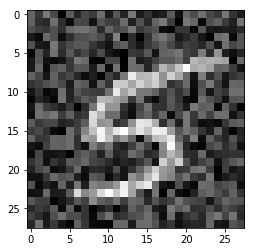

The classification label following attack is 5 from an original classification of 5


In [277]:
#An example of the attack
adversarial_image_fmodel = Boundary_Attack_customTensorFlowModel(model_prediction_function=cnn_binding_predictions,
                                                                 model_weights="/Binding_CNN.ckpt",
                                                                 var_list=var_list_Binding,
                                                                 num_iterations=3000, 
                                                                 test_image=test_image_LeNet, 
                                                                 test_label=test_label_LeNet,
                                                                 temp_batch_size=1,
                                                                keep_prob = 1.0)


In [0]:
#Function to try to identify why the Boundary Attack does not stop iteratively decreasing noise into correct classification
# def bug_test_attack(num_iterations, test_image, test_label, target_image, target_label, temp_batch_size):

#     images = x #x is a place-holder for 28x28 images earlier defined
#     logits = cnn_binding_predictions(images, temp_batch_size)

#     saver = tf.train.Saver(var_list_Binding) #Define saver object for use later when loading the model weights

#     #Note how when attacking a low-level TensorFlow API model, it is necessary for all steps to occur within the tf.Session()
#     with tf.Session() as session:
#         saver.restore(session, "/Binding_CNN.ckpt") #Note when restoring weights its important not to run init on the same
#         #variables, as this will over-write the learned weights with randomly initialized ones

#         #Define the foolbox model
#         fmodel = foolbox.models.TensorFlowModel(images, logits, (0,1)) 

#         #The predicted label of the network prior to carrying out the attack
#         pre_label = np.argmax(fmodel.predictions(test_image[:, :, :]))
#         #print("The classification label prior to attack is " + str(pre_label))
#         if (pre_label != test_label):
#             print("The model predicted a " + str(pre_label) + " when the ground-truth label is " + str(test_label))
#             plt.imshow(test_image[:,:,0], cmap='gray')

#         #Carry out the untargeted Bounary Attack
#         attack_fmodel = foolbox.attacks.BoundaryAttack(model=fmodel, criterion=foolbox.criteria.TargetClass(target_label_LeNet))
#         adversarial_image_fmodel = attack_fmodel(test_image, test_label, iterations=num_iterations, starting_point=target_image_LeNet,
#                                                  log_every_n_steps=50)
#         plt.imshow(adversarial_image_fmodel[:,:,0], cmap='gray')
#         plt.show()
        
#         #Check the output of the adversarial attack
#         adversarial_label_fmodel = np.argmax(fmodel.predictions(adversarial_image_fmodel[:, :, :]))
#         print("The classification label following attack is " + str(adversarial_label_fmodel) 
#               + " from an original classification of " + str(test_label))
        
#         return adversarial_image_fmodel, adversarial_label_fmodel

In [0]:
#To be used if a targeted attack is desired

#Unfortunately the targeted boundary attack appears to have the same odd behaviour

# image_iter = 56
# target_image_LeNet = testing_data[image_iter, :, :]
# plt.imshow(target_image_LeNet[:,:,0], cmap='gray')
# target_label_LeNet = np.argmax(testing_labels[image_iter,:])

# print(target_label_LeNet)

In [0]:
# #An example of the attack
# adversarial_image_fmodel = bug_test_attack(num_iterations=100, 
#                                                                  test_image=test_image_LeNet, 
#                                                                  test_label=test_label_LeNet,
#                                                                 target_image=target_image_LeNet,
#                                                                 target_label=target_label_LeNet,
#                                                                  temp_batch_size=1)


###Quantify the Vulnerability of the Binding-Capable CNN to the Boundary Attack

run with verbose=True to see details
Step 0: 1.14665e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.01637e-01, stepsizes = 6.7e-03/6.7e-03:  (took 0.04240 seconds)
Step 100: 1.01637e-01, stepsizes = 4.4e-03/4.4e-03:  (took 0.05506 seconds)
Step 150: 9.98434e-02, stepsizes = 4.4e-03/3.0e-03:  (took 0.02616 seconds)
Step 200: 9.63534e-02, stepsizes = 3.0e-03/1.3e-03: d. reduced by 0.26% (2.5427e-04) (took 0.01194 seconds)
Step 250: 9.16480e-02, stepsizes = 3.0e-03/8.8e-04: d. reduced by 0.18% (1.6113e-04) (took 0.01184 seconds)
Step 300: 8.32049e-02, stepsizes = 4.4e-03/2.0e-03:  (took 0.01182 seconds)
Step 350: 7.88636e-02, stepsizes = 3.0e-03/8.8e-04: d. reduced by 0.18% (1.3865e-04) (took 0.01156 seconds)
Step 400: 7.49468e-02, stepsizes = 2.0e-03/5.9e-04:  (took 0.01032 seconds)
Step 450: 7.34030e-02, stepsizes = 1.3e-03/2.6e-04: d. reduced by 0.05% (3.8203e-05) (took 0.01197 seconds)
Step 500: 7.06669e-02, stepsizes = 2.0e-03/5.9e-04: d. reduced by 0.12% (8.2792e-05) (took 0.01109 se

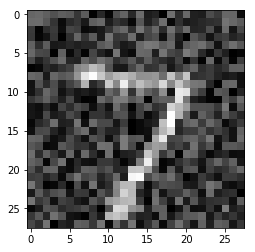

The classification label following attack is 2 from an original classification of 7
The L2 distance of the adversary is 7.022112185650412
run with verbose=True to see details
Step 0: 1.43495e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.36926e-01, stepsizes = 6.7e-03/6.7e-03:  (took 0.04879 seconds)
Step 100: 1.35712e-01, stepsizes = 4.4e-03/3.0e-03:  (took 0.04251 seconds)
Step 150: 1.33317e-01, stepsizes = 4.4e-03/2.0e-03:  (took 0.01048 seconds)
Step 200: 1.27308e-01, stepsizes = 3.0e-03/8.8e-04: d. reduced by 0.18% (2.2383e-04) (took 0.01130 seconds)
Step 250: 1.23708e-01, stepsizes = 2.0e-03/3.9e-04: d. reduced by 0.12% (1.4493e-04) (took 0.01130 seconds)
Step 300: 1.21380e-01, stepsizes = 1.3e-03/2.6e-04: d. reduced by 0.05% (6.3172e-05) (took 0.01083 seconds)
Step 350: 1.17649e-01, stepsizes = 1.3e-03/5.9e-04: d. reduced by 0.08% (9.1864e-05) (took 0.01184 seconds)
Step 400: 1.13323e-01, stepsizes = 1.3e-03/3.9e-04: d. reduced by 0.08% (8.8485e-05) (took 0.01272 seconds)
Step 45

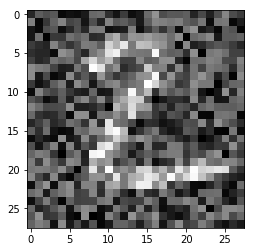

The classification label following attack is 8 from an original classification of 2
The L2 distance of the adversary is 9.173727234459369
run with verbose=True to see details
Step 0: 1.18445e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 8.93927e-02, stepsizes = 6.7e-03/6.7e-03:  (took 0.04963 seconds)
Step 100: 8.85998e-02, stepsizes = 4.4e-03/3.0e-03:  (took 0.04487 seconds)
Step 150: 8.80756e-02, stepsizes = 3.0e-03/1.3e-03:  (took 0.01236 seconds)
Step 200: 8.65417e-02, stepsizes = 2.0e-03/8.8e-04:  (took 0.01211 seconds)
Step 250: 8.37504e-02, stepsizes = 2.0e-03/5.9e-04: d. reduced by 0.12% (9.8120e-05) (took 0.01161 seconds)
Step 300: 8.20679e-02, stepsizes = 1.3e-03/3.9e-04:  (took 0.01203 seconds)
Step 350: 8.14511e-02, stepsizes = 8.8e-04/2.6e-04:  (took 0.01259 seconds)
Step 400: 8.04961e-02, stepsizes = 8.8e-04/1.7e-04: d. reduced by 0.03% (2.7926e-05) (took 0.01117 seconds)
Step 450: 7.90983e-02, stepsizes = 8.8e-04/2.6e-04: d. reduced by 0.05% (4.1167e-05) (took 0.01260 seco

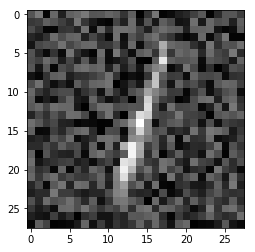

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 7.531208600014982
run with verbose=True to see details
Step 0: 2.44023e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 2.34408e-01, stepsizes = 6.7e-03/6.7e-03:  (took 0.04666 seconds)
Step 100: 2.32329e-01, stepsizes = 4.4e-03/3.0e-03:  (took 0.04400 seconds)
Step 150: 2.27328e-01, stepsizes = 3.0e-03/1.3e-03:  (took 0.01054 seconds)
Step 200: 2.27328e-01, stepsizes = 2.0e-03/5.9e-04:  (took 0.01116 seconds)
Step 250: 2.24594e-01, stepsizes = 1.3e-03/3.9e-04:  (took 0.01089 seconds)
Step 300: 2.20886e-01, stepsizes = 1.3e-03/2.6e-04: d. reduced by 0.05% (1.1496e-04) (took 0.01235 seconds)
Step 350: 2.17125e-01, stepsizes = 1.3e-03/2.6e-04:  (took 0.01157 seconds)
Step 400: 2.14840e-01, stepsizes = 1.3e-03/2.6e-04: d. reduced by 0.03% (7.4533e-05) (took 0.01072 seconds)
Step 450: 2.12174e-01, stepsizes = 8.8e-04/1.7e-04:  (took 0.01001 seconds)
Step 500: 2.10196e-01, step

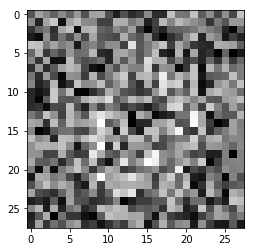

The classification label following attack is 8 from an original classification of 0
The L2 distance of the adversary is 12.600440233057276
run with verbose=True to see details
Step 0: 8.50102e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 7.84427e-02, stepsizes = 6.7e-03/6.7e-03:  (took 0.04946 seconds)
Step 100: 7.63717e-02, stepsizes = 4.4e-03/3.0e-03:  (took 0.04376 seconds)
Step 150: 7.45805e-02, stepsizes = 3.0e-03/2.0e-03:  (took 0.01060 seconds)
Step 200: 7.02863e-02, stepsizes = 3.0e-03/2.0e-03:  (took 0.01088 seconds)
Step 250: 6.75611e-02, stepsizes = 2.0e-03/1.3e-03:  (took 0.01066 seconds)
Step 300: 6.70096e-02, stepsizes = 1.3e-03/5.9e-04: d. reduced by 0.12% (7.8507e-05) (took 0.01292 seconds)
Step 350: 6.62813e-02, stepsizes = 8.8e-04/3.9e-04:  (took 0.01066 seconds)
Step 400: 6.40102e-02, stepsizes = 1.3e-03/5.9e-04:  (took 0.01088 seconds)
Step 450: 6.37858e-02, stepsizes = 1.3e-03/8.8e-04:  (took 0.01174 seconds)
Step 500: 6.32774e-02, stepsizes = 8.8e-04/3.9e-04:  (took

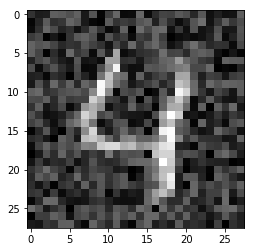

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 6.562517674468929
run with verbose=True to see details
Step 0: 1.46827e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.17701e-01, stepsizes = 6.7e-03/6.7e-03:  (took 0.04068 seconds)
Step 100: 1.17701e-01, stepsizes = 4.4e-03/3.0e-03:  (took 0.04871 seconds)
Step 150: 1.16543e-01, stepsizes = 4.4e-03/2.0e-03:  (took 0.01048 seconds)
Step 200: 1.08394e-01, stepsizes = 3.0e-03/2.0e-03: d. reduced by 0.26% (2.8605e-04) (took 0.01199 seconds)
Step 250: 1.07540e-01, stepsizes = 2.0e-03/1.3e-03:  (took 0.02043 seconds)
Step 300: 1.05946e-01, stepsizes = 2.0e-03/8.8e-04:  (took 0.01167 seconds)
Step 350: 1.00685e-01, stepsizes = 2.0e-03/5.9e-04:  (took 0.01079 seconds)
Step 400: 9.70958e-02, stepsizes = 1.3e-03/2.6e-04:  (took 0.01117 seconds)
Step 450: 9.54760e-02, stepsizes = 8.8e-04/1.7e-04: d. reduced by 0.03% (3.3123e-05) (took 0.01063 seconds)
Step 500: 9.43239e-02, step

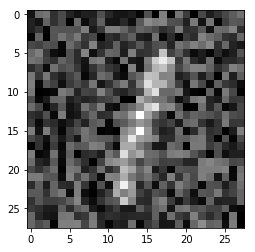

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 8.313682412667783
run with verbose=True to see details
Step 0: 7.34729e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 4.62750e-02, stepsizes = 1.0e-02/1.0e-02:  (took 0.04817 seconds)
Step 100: 4.53541e-02, stepsizes = 4.4e-03/4.4e-03:  (took 0.04244 seconds)
Step 150: 4.38967e-02, stepsizes = 3.0e-03/2.0e-03:  (took 0.01078 seconds)
Step 200: 4.26421e-02, stepsizes = 2.0e-03/8.8e-04: d. reduced by 0.26% (1.1253e-04) (took 0.01141 seconds)
Step 250: 4.15575e-02, stepsizes = 1.3e-03/5.9e-04:  (took 0.01062 seconds)
Step 300: 4.08022e-02, stepsizes = 8.8e-04/2.6e-04: d. reduced by 0.05% (2.1235e-05) (took 0.01083 seconds)
Step 350: 3.99687e-02, stepsizes = 5.9e-04/1.7e-04: d. reduced by 0.03% (1.3866e-05) (took 0.01304 seconds)
Step 400: 3.96374e-02, stepsizes = 3.9e-04/1.7e-04:  (took 0.01099 seconds)
Step 450: 3.95275e-02, stepsizes = 2.6e-04/1.2e-04:  (took 0.01116 seco

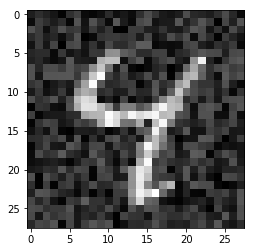

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 5.51057465987384
run with verbose=True to see details
Step 0: 6.49866e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 6.11836e-02, stepsizes = 6.7e-03/6.7e-03:  (took 0.04349 seconds)
Step 100: 6.11836e-02, stepsizes = 4.4e-03/4.4e-03:  (took 0.05128 seconds)
Step 150: 6.06408e-02, stepsizes = 3.0e-03/3.0e-03:  (took 0.00917 seconds)
Step 200: 6.01633e-02, stepsizes = 2.0e-03/1.3e-03:  (took 0.01100 seconds)
Step 250: 5.96372e-02, stepsizes = 8.8e-04/3.9e-04:  (took 0.01188 seconds)
Step 300: 5.94668e-02, stepsizes = 5.9e-04/2.6e-04: d. reduced by 0.05% (3.0949e-05) (took 0.01101 seconds)
Step 350: 5.93638e-02, stepsizes = 3.9e-04/1.2e-04:  (took 0.01104 seconds)
Step 400: 5.90853e-02, stepsizes = 2.6e-04/7.7e-05:  (took 0.01073 seconds)
Step 450: 5.90155e-02, stepsizes = 1.2e-04/3.4e-05:  (took 0.01469 seconds)
Step 500: 5.89441e-02, stepsizes = 1.2e-04/2.3e-05:  (took 0

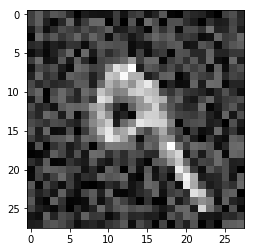

The classification label following attack is 8 from an original classification of 9
The L2 distance of the adversary is 6.784444195738486
run with verbose=True to see details
Step 0: 1.66763e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.36396e-01, stepsizes = 1.0e-02/6.7e-03:  (took 0.04714 seconds)
Step 100: 9.50460e-02, stepsizes = 1.0e-02/6.7e-03: d. reduced by 1.33% (1.2801e-03) (took 0.00375 seconds)
Step 150: 6.11230e-02, stepsizes = 1.5e-02/6.7e-03: d. reduced by 1.33% (8.2320e-04) (took 0.01091 seconds)
Step 200: 4.69877e-02, stepsizes = 1.5e-02/4.4e-03: d. reduced by 0.89% (4.2047e-04) (took 0.01095 seconds)
Step 250: 3.11859e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.01169 seconds)
Step 300: 2.76500e-02, stepsizes = 1.0e-02/4.4e-03:  (took 0.01073 seconds)
Step 350: 2.55974e-02, stepsizes = 6.7e-03/2.0e-03:  (took 0.01106 seconds)
Step 400: 2.26436e-02, stepsizes = 1.0e-02/4.4e-03:  (took 0.01086 seconds)
Step 450: 1.83953e-02, stepsizes = 1.0e-02/3.0e-03:  (took 0.01124 seco

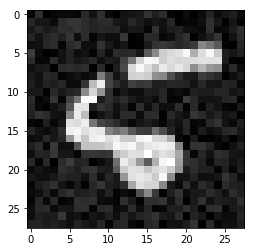

The classification label following attack is 8 from an original classification of 5
The L2 distance of the adversary is 3.2359352820019884
run with verbose=True to see details
Step 0: 9.44292e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 8.20350e-02, stepsizes = 1.0e-02/6.7e-03:  (took 0.05845 seconds)
Step 100: 7.98692e-02, stepsizes = 1.0e-02/6.7e-03:  (took 0.04720 seconds)
Step 150: 7.65034e-02, stepsizes = 4.4e-03/2.0e-03:  (took 0.01190 seconds)
Step 200: 7.38284e-02, stepsizes = 3.0e-03/1.3e-03:  (took 0.01164 seconds)
Step 250: 7.21613e-02, stepsizes = 2.0e-03/5.9e-04:  (took 0.01124 seconds)
Step 300: 7.10435e-02, stepsizes = 1.3e-03/3.9e-04:  (took 0.01183 seconds)
Step 350: 6.98402e-02, stepsizes = 8.8e-04/2.6e-04: d. reduced by 0.03% (2.4229e-05) (took 0.01762 seconds)
Step 400: 6.80997e-02, stepsizes = 1.3e-03/3.9e-04: d. reduced by 0.08% (5.3174e-05) (took 0.01109 seconds)
Step 450: 6.67838e-02, stepsizes = 1.3e-03/3.9e-04: d. reduced by 0.05% (3.4758e-05) (took 0.01118 sec

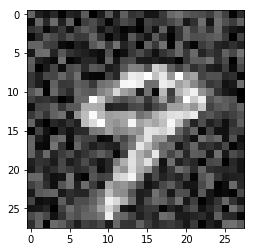

The classification label following attack is 8 from an original classification of 9
The L2 distance of the adversary is 6.919902442733148
run with verbose=True to see details
Step 0: 1.74874e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.64641e-01, stepsizes = 6.7e-03/6.7e-03:  (took 0.05216 seconds)
Step 100: 1.61733e-01, stepsizes = 6.7e-03/4.4e-03:  (took 0.04928 seconds)
Step 150: 1.52414e-01, stepsizes = 6.7e-03/3.0e-03:  (took 0.01166 seconds)
Step 200: 1.47083e-01, stepsizes = 3.0e-03/1.3e-03:  (took 0.01188 seconds)
Step 250: 1.46696e-01, stepsizes = 2.0e-03/8.8e-04:  (took 0.01066 seconds)
Step 300: 1.44593e-01, stepsizes = 1.3e-03/3.9e-04:  (took 0.01196 seconds)
Step 350: 1.42823e-01, stepsizes = 8.8e-04/1.7e-04: d. reduced by 0.03% (4.9548e-05) (took 0.01157 seconds)
Step 400: 1.41918e-01, stepsizes = 5.9e-04/1.2e-04: d. reduced by 0.02% (3.2820e-05) (took 0.01146 seconds)
Step 450: 1.41165e-01, stepsizes = 3.9e-04/7.7e-05: d. reduced by 0.02% (2.1763e-05) (took 0.01130 seco

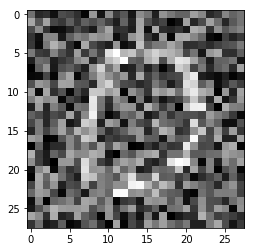

The classification label following attack is 6 from an original classification of 0
The L2 distance of the adversary is 10.366845273463571
run with verbose=True to see details
Step 0: 1.24155e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.21685e-01, stepsizes = 1.0e-02/6.7e-03:  (took 0.05314 seconds)
Step 100: 1.16898e-01, stepsizes = 1.0e-02/6.7e-03: d. reduced by 1.33% (1.5744e-03) (took 0.04638 seconds)
Step 150: 1.15518e-01, stepsizes = 6.7e-03/3.0e-03:  (took 0.01081 seconds)
Step 200: 1.13257e-01, stepsizes = 4.4e-03/1.3e-03: d. reduced by 0.26% (2.9888e-04) (took 0.01228 seconds)
Step 250: 1.05943e-01, stepsizes = 3.0e-03/8.8e-04: d. reduced by 0.18% (1.8626e-04) (took 0.01136 seconds)
Step 300: 1.02405e-01, stepsizes = 2.0e-03/5.9e-04: d. reduced by 0.12% (1.1998e-04) (took 0.01131 seconds)
Step 350: 1.00924e-01, stepsizes = 1.3e-03/2.6e-04: d. reduced by 0.05% (5.2526e-05) (took 0.01199 seconds)
Step 400: 9.74407e-02, stepsizes = 2.0e-03/8.8e-04: d. reduced by 0.12% (1.1416e-0

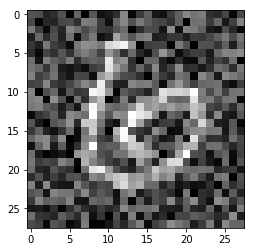

The classification label following attack is 2 from an original classification of 6
The L2 distance of the adversary is 8.263256499551279
run with verbose=True to see details
Step 0: 9.32668e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 8.26703e-02, stepsizes = 1.0e-02/1.0e-02:  (took 0.05409 seconds)
Step 100: 6.85503e-02, stepsizes = 1.0e-02/6.7e-03:  (took 0.04988 seconds)
Step 150: 5.87418e-02, stepsizes = 6.7e-03/3.0e-03: d. reduced by 0.59% (3.4965e-04) (took 0.01126 seconds)
Step 200: 4.74417e-02, stepsizes = 6.7e-03/3.0e-03: d. reduced by 0.59% (2.8239e-04) (took 0.01173 seconds)
Step 250: 4.18003e-02, stepsizes = 4.4e-03/1.3e-03: d. reduced by 0.39% (1.6563e-04) (took 0.01107 seconds)
Step 300: 3.71256e-02, stepsizes = 4.4e-03/1.3e-03: d. reduced by 0.26% (9.7973e-05) (took 0.01074 seconds)
Step 350: 3.45453e-02, stepsizes = 4.4e-03/8.8e-04: d. reduced by 0.18% (6.0736e-05) (took 0.01127 seconds)
Step 400: 3.20321e-02, stepsizes = 4.4e-03/8.8e-04: d. reduced by 0.18% (5.6317e-05

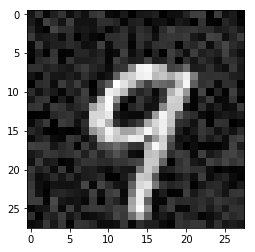

The classification label following attack is 8 from an original classification of 9
The L2 distance of the adversary is 4.082193301965267
run with verbose=True to see details
Step 0: 2.01066e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.81841e-01, stepsizes = 6.7e-03/6.7e-03:  (took 0.04432 seconds)
Step 100: 1.80228e-01, stepsizes = 4.4e-03/4.4e-03:  (took 0.04190 seconds)
Step 150: 1.80228e-01, stepsizes = 3.0e-03/3.0e-03:  (took 0.01163 seconds)
Step 200: 1.79754e-01, stepsizes = 1.3e-03/8.8e-04:  (took 0.01229 seconds)
Step 250: 1.78914e-01, stepsizes = 1.3e-03/5.9e-04:  (took 0.01252 seconds)
Step 300: 1.76992e-01, stepsizes = 8.8e-04/2.6e-04: d. reduced by 0.05% (9.2115e-05) (took 0.01189 seconds)
Step 350: 1.73377e-01, stepsizes = 8.8e-04/1.7e-04: d. reduced by 0.03% (6.0148e-05) (took 0.00936 seconds)
Step 400: 1.69659e-01, stepsizes = 1.3e-03/5.9e-04: d. reduced by 0.08% (1.3247e-04) (took 0.01847 seconds)
Step 450: 1.54280e-01, stepsizes = 2.0e-03/2.0e-03:  (took 0.01156 seco

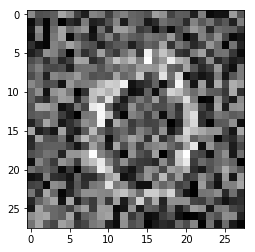

The classification label following attack is 2 from an original classification of 0
The L2 distance of the adversary is 10.283740542253001
run with verbose=True to see details
Step 0: 1.86756e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.52749e-01, stepsizes = 6.7e-03/6.7e-03:  (took 0.04240 seconds)
Step 100: 1.46090e-01, stepsizes = 4.4e-03/3.0e-03:  (took 0.04396 seconds)
Step 150: 1.36048e-01, stepsizes = 4.4e-03/2.0e-03: d. reduced by 0.39% (5.3907e-04) (took 0.01127 seconds)
Step 200: 1.30947e-01, stepsizes = 3.0e-03/1.3e-03:  (took 0.01058 seconds)
Step 250: 1.25431e-01, stepsizes = 2.0e-03/8.8e-04: d. reduced by 0.18% (2.2053e-04) (took 0.01138 seconds)
Step 300: 1.22312e-01, stepsizes = 1.3e-03/5.9e-04:  (took 0.01057 seconds)
Step 350: 1.20700e-01, stepsizes = 8.8e-04/2.6e-04:  (took 0.00901 seconds)
Step 400: 1.19016e-01, stepsizes = 5.9e-04/2.6e-04: d. reduced by 0.05% (6.1942e-05) (took 0.01265 seconds)
Step 450: 1.18460e-01, stepsizes = 3.9e-04/1.7e-04:  (took 0.01125 sec

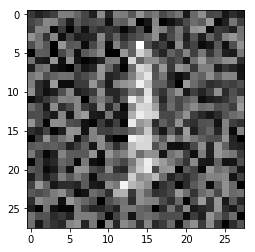

The classification label following attack is 9 from an original classification of 1
The L2 distance of the adversary is 9.574836303755776
run with verbose=True to see details
Step 0: 9.52091e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 8.21694e-02, stepsizes = 1.0e-02/6.7e-03:  (took 0.06192 seconds)
Step 100: 6.96789e-02, stepsizes = 1.0e-02/4.4e-03:  (took 0.04462 seconds)
Step 150: 6.48883e-02, stepsizes = 4.4e-03/2.0e-03:  (took 0.01070 seconds)
Step 200: 6.17458e-02, stepsizes = 3.0e-03/8.8e-04:  (took 0.00915 seconds)
Step 250: 5.81662e-02, stepsizes = 3.0e-03/5.9e-04: d. reduced by 0.12% (6.8146e-05) (took 0.01144 seconds)
Step 300: 5.50837e-02, stepsizes = 2.0e-03/5.9e-04:  (took 0.01101 seconds)
Step 350: 5.29339e-02, stepsizes = 2.0e-03/5.9e-04: d. reduced by 0.12% (6.2016e-05) (took 0.01321 seconds)
Step 400: 5.05118e-02, stepsizes = 2.0e-03/5.9e-04:  (took 0.01033 seconds)
Step 450: 4.91058e-02, stepsizes = 1.3e-03/2.6e-04: d. reduced by 0.05% (2.5557e-05) (took 0.01166 seco

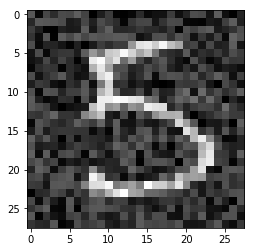

The classification label following attack is 8 from an original classification of 5
The L2 distance of the adversary is 5.797590775924219
run with verbose=True to see details
Step 0: 1.12069e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 7.80466e-02, stepsizes = 6.7e-03/6.7e-03:  (took 0.04695 seconds)
Step 100: 7.80466e-02, stepsizes = 4.4e-03/3.0e-03:  (took 0.05636 seconds)
Step 150: 7.73544e-02, stepsizes = 3.0e-03/2.0e-03:  (took 0.01123 seconds)
Step 200: 7.69139e-02, stepsizes = 2.0e-03/8.8e-04:  (took 0.01041 seconds)
Step 250: 7.66442e-02, stepsizes = 1.3e-03/5.9e-04:  (took 0.01136 seconds)
Step 300: 7.65246e-02, stepsizes = 5.9e-04/2.6e-04:  (took 0.01136 seconds)
Step 350: 7.62729e-02, stepsizes = 3.9e-04/1.2e-04:  (took 0.01142 seconds)
Step 400: 7.57807e-02, stepsizes = 3.9e-04/7.7e-05: d. reduced by 0.02% (1.1683e-05) (took 0.01155 seconds)
Step 450: 7.51756e-02, stepsizes = 3.9e-04/1.2e-04: d. reduced by 0.02% (1.7385e-05) (took 0.01177 seconds)
Step 500: 7.46559e-02, step

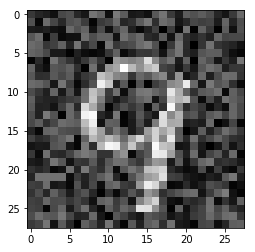

The classification label following attack is 8 from an original classification of 9
The L2 distance of the adversary is 7.371146596083009
run with verbose=True to see details
Step 0: 1.28674e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.12539e-01, stepsizes = 1.0e-02/6.7e-03:  (took 0.04712 seconds)
Step 100: 1.12539e-01, stepsizes = 1.0e-02/4.4e-03:  (took 0.05228 seconds)
Step 150: 1.03869e-01, stepsizes = 1.0e-02/3.0e-03:  (took 0.01092 seconds)
Step 200: 1.02644e-01, stepsizes = 4.4e-03/1.3e-03:  (took 0.01103 seconds)
Step 250: 9.93622e-02, stepsizes = 3.0e-03/5.9e-04:  (took 0.01156 seconds)
Step 300: 9.49269e-02, stepsizes = 3.0e-03/8.8e-04: d. reduced by 0.12% (1.1121e-04) (took 0.01217 seconds)
Step 350: 9.31103e-02, stepsizes = 3.0e-03/5.9e-04:  (took 0.01496 seconds)
Step 400: 9.20983e-02, stepsizes = 2.0e-03/3.9e-04:  (took 0.01052 seconds)
Step 450: 9.15251e-02, stepsizes = 8.8e-04/1.7e-04:  (took 0.01108 seconds)
Step 500: 9.10712e-02, stepsizes = 8.8e-04/1.2e-04: d. redu

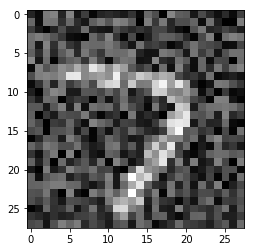

The classification label following attack is 2 from an original classification of 7
The L2 distance of the adversary is 8.211404746571532
run with verbose=True to see details
Step 0: 1.91513e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 7.15231e-03, stepsizes = 1.0e-02/1.0e-02: d. reduced by 1.99% (1.4522e-04) (took 0.06919 seconds)
Step 100: 4.88184e-03, stepsizes = 6.7e-03/6.7e-03:  (took 0.04138 seconds)
Step 150: 4.75295e-03, stepsizes = 4.4e-03/4.4e-03:  (took 0.01057 seconds)
Step 200: 4.69690e-03, stepsizes = 3.0e-03/2.0e-03:  (took 0.01093 seconds)
Step 250: 4.32836e-03, stepsizes = 2.0e-03/1.3e-03: d. reduced by 0.26% (1.1422e-05) (took 0.01079 seconds)
Step 300: 4.18997e-03, stepsizes = 1.3e-03/5.9e-04: d. reduced by 0.12% (4.9089e-06) (took 0.01088 seconds)
Step 350: 4.00919e-03, stepsizes = 1.3e-03/3.9e-04: d. reduced by 0.08% (3.1305e-06) (took 0.01090 seconds)
Step 400: 3.87686e-03, stepsizes = 8.8e-04/3.9e-04: d. reduced by 0.12% (4.5421e-06) (took 0.01255 seconds)
Step 45

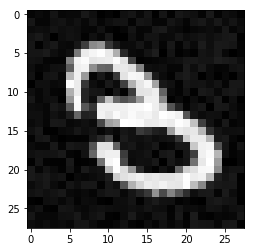

The classification label following attack is 5 from an original classification of 3
The L2 distance of the adversary is 1.6440232418494871
run with verbose=True to see details
Step 0: 9.88192e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 8.81827e-02, stepsizes = 6.7e-03/6.7e-03:  (took 0.04517 seconds)
Step 100: 8.81827e-02, stepsizes = 4.4e-03/3.0e-03:  (took 0.04626 seconds)
Step 150: 8.63693e-02, stepsizes = 3.0e-03/2.0e-03:  (took 0.01100 seconds)
Step 200: 8.30215e-02, stepsizes = 3.0e-03/8.8e-04: d. reduced by 0.26% (2.1909e-04) (took 0.01098 seconds)
Step 250: 7.91759e-02, stepsizes = 3.0e-03/5.9e-04:  (took 0.01140 seconds)
Step 300: 7.53764e-02, stepsizes = 2.0e-03/5.9e-04: d. reduced by 0.12% (8.8310e-05) (took 0.01092 seconds)
Step 350: 7.33163e-02, stepsizes = 1.3e-03/3.9e-04:  (took 0.01042 seconds)
Step 400: 7.23500e-02, stepsizes = 8.8e-04/1.7e-04: d. reduced by 0.03% (2.5100e-05) (took 0.01152 seconds)
Step 450: 7.15018e-02, stepsizes = 5.9e-04/1.2e-04:  (took 0.01139 sec

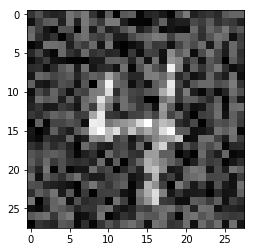

The classification label following attack is 9 from an original classification of 4
The L2 distance of the adversary is 7.35770882619771
run with verbose=True to see details
Step 0: 1.46484e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.17434e-01, stepsizes = 6.7e-03/6.7e-03: d. reduced by 1.33% (1.5816e-03) (took 0.04507 seconds)
Step 100: 1.17434e-01, stepsizes = 4.4e-03/3.0e-03:  (took 0.04723 seconds)
Step 150: 1.15590e-01, stepsizes = 3.0e-03/2.0e-03:  (took 0.01056 seconds)
Step 200: 1.15590e-01, stepsizes = 2.0e-03/1.3e-03:  (took 0.01133 seconds)
Step 250: 1.12618e-01, stepsizes = 1.3e-03/5.9e-04: d. reduced by 0.12% (1.3194e-04) (took 0.01072 seconds)
Step 300: 1.09028e-01, stepsizes = 1.3e-03/3.9e-04:  (took 0.01077 seconds)
Step 350: 1.05101e-01, stepsizes = 1.3e-03/5.9e-04:  (took 0.01048 seconds)
Step 400: 1.03056e-01, stepsizes = 8.8e-04/2.6e-04: d. reduced by 0.05% (5.3636e-05) (took 0.01087 seconds)
Step 450: 1.01232e-01, stepsizes = 5.9e-04/1.7e-04: d. reduced by 0.03% 

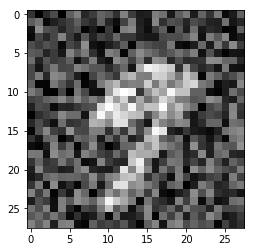

The classification label following attack is 4 from an original classification of 9
The L2 distance of the adversary is 8.69133312319036
run with verbose=True to see details
Step 0: 1.38883e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.23104e-01, stepsizes = 6.7e-03/6.7e-03:  (took 0.06757 seconds)
Step 100: 1.20214e-01, stepsizes = 4.4e-03/3.0e-03:  (took 0.05333 seconds)
Step 150: 1.18875e-01, stepsizes = 3.0e-03/1.3e-03:  (took 0.01103 seconds)
Step 200: 1.15885e-01, stepsizes = 2.0e-03/8.8e-04:  (took 0.01059 seconds)
Step 250: 1.13623e-01, stepsizes = 8.8e-04/2.6e-04: d. reduced by 0.08% (8.8720e-05) (took 0.01034 seconds)
Step 300: 1.11631e-01, stepsizes = 8.8e-04/2.6e-04:  (took 0.01104 seconds)
Step 350: 1.10188e-01, stepsizes = 3.9e-04/1.2e-04:  (took 0.01147 seconds)
Step 400: 1.09702e-01, stepsizes = 2.6e-04/7.7e-05: d. reduced by 0.01% (1.1274e-05) (took 0.01248 seconds)
Step 450: 1.09078e-01, stepsizes = 2.6e-04/7.7e-05:  (took 0.01051 seconds)
Step 500: 1.08866e-01, steps

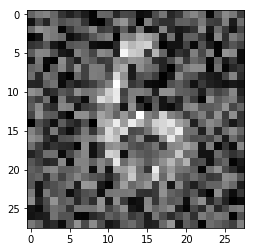

The classification label following attack is 8 from an original classification of 6
The L2 distance of the adversary is 9.116604792568328
run with verbose=True to see details
Step 0: 1.74079e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.60630e-01, stepsizes = 6.7e-03/6.7e-03:  (took 0.04394 seconds)
Step 100: 1.54775e-01, stepsizes = 4.4e-03/3.0e-03:  (took 0.04650 seconds)
Step 150: 1.53860e-01, stepsizes = 3.0e-03/2.0e-03:  (took 0.01049 seconds)
Step 200: 1.51979e-01, stepsizes = 2.0e-03/8.8e-04:  (took 0.01159 seconds)
Step 250: 1.51092e-01, stepsizes = 1.3e-03/5.9e-04:  (took 0.00870 seconds)
Step 300: 1.50386e-01, stepsizes = 8.8e-04/2.6e-04: d. reduced by 0.05% (7.8268e-05) (took 0.01121 seconds)
Step 350: 1.49010e-01, stepsizes = 5.9e-04/1.2e-04: d. reduced by 0.02% (3.4460e-05) (took 0.01261 seconds)
Step 400: 1.47843e-01, stepsizes = 5.9e-04/1.2e-04: d. reduced by 0.02% (3.4190e-05) (took 0.01133 seconds)
Step 450: 1.46144e-01, stepsizes = 5.9e-04/1.7e-04: d. reduced by 0.02%

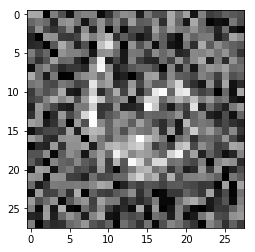

The classification label following attack is 8 from an original classification of 6
The L2 distance of the adversary is 10.558402010848134
run with verbose=True to see details
Step 0: 8.48158e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 8.14737e-02, stepsizes = 6.7e-03/6.7e-03:  (took 0.04690 seconds)
Step 100: 8.07511e-02, stepsizes = 6.7e-03/4.4e-03:  (took 0.05020 seconds)
Step 150: 7.93251e-02, stepsizes = 4.4e-03/2.0e-03:  (took 0.01066 seconds)
Step 200: 7.07321e-02, stepsizes = 6.7e-03/3.0e-03: d. reduced by 0.39% (2.8027e-04) (took 0.01133 seconds)
Step 250: 6.27752e-02, stepsizes = 4.4e-03/1.3e-03: d. reduced by 0.26% (1.6566e-04) (took 0.01120 seconds)
Step 300: 5.64198e-02, stepsizes = 3.0e-03/1.3e-03:  (took 0.01034 seconds)
Step 350: 5.50490e-02, stepsizes = 3.0e-03/8.8e-04:  (took 0.01039 seconds)
Step 400: 5.09545e-02, stepsizes = 3.0e-03/1.3e-03: d. reduced by 0.18% (8.9585e-05) (took 0.01153 seconds)
Step 450: 4.93683e-02, stepsizes = 3.0e-03/8.8e-04:  (took 0.01163 sec

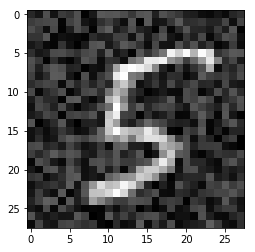

The classification label following attack is 8 from an original classification of 5
The L2 distance of the adversary is 5.489916046837964
run with verbose=True to see details
Step 0: 7.12254e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 6.84188e-02, stepsizes = 1.0e-02/6.7e-03:  (took 0.05824 seconds)
Step 100: 4.34146e-02, stepsizes = 1.0e-02/6.7e-03: d. reduced by 1.33% (5.8470e-04) (took 0.02388 seconds)
Step 150: 3.14047e-02, stepsizes = 6.7e-03/3.0e-03: d. reduced by 0.59% (1.8693e-04) (took 0.01066 seconds)
Step 200: 2.65451e-02, stepsizes = 4.4e-03/3.0e-03:  (took 0.01088 seconds)
Step 250: 2.62319e-02, stepsizes = 3.0e-03/2.0e-03:  (took 0.01024 seconds)
Step 300: 2.58885e-02, stepsizes = 1.3e-03/5.9e-04:  (took 0.01175 seconds)
Step 350: 2.49072e-02, stepsizes = 1.3e-03/5.9e-04: d. reduced by 0.12% (2.9181e-05) (took 0.01153 seconds)
Step 400: 2.35046e-02, stepsizes = 2.0e-03/8.8e-04: d. reduced by 0.18% (4.1325e-05) (took 0.01167 seconds)
Step 450: 2.12181e-02, stepsizes = 3.0e

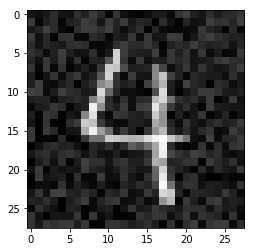

The classification label following attack is 9 from an original classification of 4
The L2 distance of the adversary is 3.7156797481735393
run with verbose=True to see details
Step 0: 1.61357e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.49896e-01, stepsizes = 6.7e-03/6.7e-03: d. reduced by 1.33% (2.0188e-03) (took 0.04112 seconds)
Step 100: 1.49896e-01, stepsizes = 4.4e-03/3.0e-03:  (took 0.04748 seconds)
Step 150: 1.45801e-01, stepsizes = 4.4e-03/2.0e-03:  (took 0.01223 seconds)
Step 200: 1.44653e-01, stepsizes = 2.0e-03/8.8e-04:  (took 0.00890 seconds)
Step 250: 1.43137e-01, stepsizes = 2.0e-03/5.9e-04:  (took 0.01129 seconds)
Step 300: 1.42135e-01, stepsizes = 8.8e-04/2.6e-04:  (took 0.01118 seconds)
Step 350: 1.41152e-01, stepsizes = 5.9e-04/1.2e-04: d. reduced by 0.03% (4.8969e-05) (took 0.01057 seconds)
Step 400: 1.39433e-01, stepsizes = 5.9e-04/1.7e-04:  (took 0.01031 seconds)
Step 450: 1.38693e-01, stepsizes = 2.6e-04/7.7e-05:  (took 0.01004 seconds)
Step 500: 1.38380e-01, ste

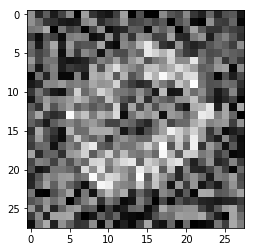

The classification label following attack is 9 from an original classification of 0
The L2 distance of the adversary is 10.38478424983456
run with verbose=True to see details
Step 0: 1.22956e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 7.00362e-02, stepsizes = 1.0e-02/6.7e-03:  (took 0.04532 seconds)
Step 100: 6.91055e-02, stepsizes = 6.7e-03/4.4e-03:  (took 0.04810 seconds)
Step 150: 6.84925e-02, stepsizes = 3.0e-03/2.0e-03:  (took 0.01033 seconds)
Step 200: 6.82222e-02, stepsizes = 2.0e-03/8.8e-04:  (took 0.01048 seconds)
Step 250: 6.77445e-02, stepsizes = 1.3e-03/5.9e-04:  (took 0.01073 seconds)
Step 300: 6.61595e-02, stepsizes = 8.8e-04/2.6e-04:  (took 0.01014 seconds)
Step 350: 6.56224e-02, stepsizes = 5.9e-04/1.7e-04:  (took 0.01045 seconds)
Step 400: 6.49280e-02, stepsizes = 5.9e-04/1.7e-04: d. reduced by 0.03% (2.2525e-05) (took 0.01117 seconds)
Step 450: 6.42114e-02, stepsizes = 5.9e-04/1.7e-04: d. reduced by 0.03% (2.2276e-05) (took 0.01089 seconds)
Step 500: 6.35356e-02, step

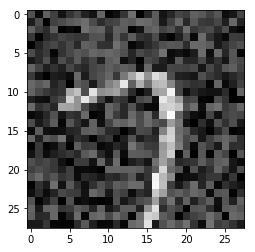

The classification label following attack is 5 from an original classification of 7
The L2 distance of the adversary is 6.891831681864685
run with verbose=True to see details
Step 0: 1.91161e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.87357e-01, stepsizes = 6.7e-03/6.7e-03:  (took 0.04712 seconds)
Step 100: 1.85695e-01, stepsizes = 4.4e-03/3.0e-03:  (took 0.04757 seconds)
Step 150: 1.84596e-01, stepsizes = 3.0e-03/2.0e-03:  (took 0.01090 seconds)
Step 200: 1.84272e-01, stepsizes = 2.0e-03/8.8e-04:  (took 0.01136 seconds)
Step 250: 1.82554e-01, stepsizes = 8.8e-04/2.6e-04:  (took 0.01457 seconds)
Step 300: 1.80101e-01, stepsizes = 5.9e-04/1.7e-04: d. reduced by 0.05% (9.3734e-05) (took 0.01110 seconds)
Step 350: 1.78113e-01, stepsizes = 5.9e-04/1.2e-04: d. reduced by 0.02% (4.1191e-05) (took 0.01098 seconds)
Step 400: 1.76392e-01, stepsizes = 5.9e-04/1.2e-04: d. reduced by 0.02% (4.0792e-05) (took 0.01123 seconds)
Step 450: 1.74687e-01, stepsizes = 3.9e-04/1.2e-04:  (took 0.01110 seco

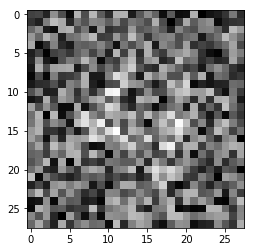

The classification label following attack is 6 from an original classification of 4
The L2 distance of the adversary is 11.606788415589843
run with verbose=True to see details
Step 0: 2.22497e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 2.05308e-01, stepsizes = 1.0e-02/1.0e-02:  (took 0.04979 seconds)
Step 100: 2.05308e-01, stepsizes = 6.7e-03/3.0e-03:  (took 0.05715 seconds)
Step 150: 2.01685e-01, stepsizes = 4.4e-03/1.3e-03:  (took 0.00998 seconds)
Step 200: 1.91330e-01, stepsizes = 4.4e-03/8.8e-04: d. reduced by 0.18% (3.3639e-04) (took 0.01091 seconds)
Step 250: 1.79605e-01, stepsizes = 4.4e-03/5.9e-04: d. reduced by 0.18% (3.1577e-04) (took 0.01041 seconds)
Step 300: 1.70786e-01, stepsizes = 4.4e-03/5.9e-04:  (took 0.01119 seconds)
Step 350: 1.63801e-01, stepsizes = 3.0e-03/5.9e-04: d. reduced by 0.12% (1.9191e-04) (took 0.01144 seconds)
Step 400: 1.60447e-01, stepsizes = 2.0e-03/3.9e-04:  (took 0.01086 seconds)
Step 450: 1.59421e-01, stepsizes = 1.3e-03/1.7e-04: d. reduced by 0.03

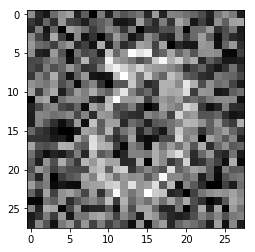

The classification label following attack is 8 from an original classification of 0
The L2 distance of the adversary is 10.680159003123928
run with verbose=True to see details
Step 0: 1.25693e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.13675e-01, stepsizes = 6.7e-03/6.7e-03:  (took 0.03907 seconds)
Step 100: 1.13675e-01, stepsizes = 4.4e-03/3.0e-03:  (took 0.04820 seconds)
Step 150: 1.12222e-01, stepsizes = 3.0e-03/2.0e-03:  (took 0.00964 seconds)
Step 200: 1.11926e-01, stepsizes = 1.3e-03/8.8e-04:  (took 0.01085 seconds)
Step 250: 1.09849e-01, stepsizes = 1.3e-03/5.9e-04:  (took 0.01157 seconds)
Step 300: 1.06182e-01, stepsizes = 1.3e-03/3.9e-04: d. reduced by 0.08% (8.2909e-05) (took 0.01061 seconds)
Step 350: 9.84374e-02, stepsizes = 2.0e-03/1.3e-03: d. reduced by 0.26% (2.5977e-04) (took 0.01089 seconds)
Step 400: 9.44966e-02, stepsizes = 2.0e-03/1.3e-03:  (took 0.01180 seconds)
Step 450: 9.42479e-02, stepsizes = 1.3e-03/5.9e-04:  (took 0.01210 seconds)
Step 500: 9.29693e-02, ste

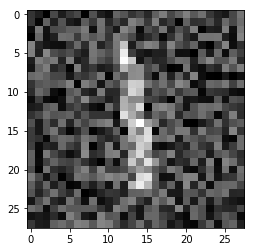

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 8.375962676458233
run with verbose=True to see details
Step 0: 7.54676e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 6.96373e-02, stepsizes = 6.7e-03/6.7e-03:  (took 0.04279 seconds)
Step 100: 6.74994e-02, stepsizes = 4.4e-03/3.0e-03:  (took 0.05586 seconds)
Step 150: 6.46254e-02, stepsizes = 3.0e-03/2.0e-03:  (took 0.01021 seconds)
Step 200: 6.27791e-02, stepsizes = 1.3e-03/5.9e-04:  (took 0.01159 seconds)
Step 250: 6.21938e-02, stepsizes = 8.8e-04/3.9e-04: d. reduced by 0.08% (4.8563e-05) (took 0.01097 seconds)
Step 300: 6.12943e-02, stepsizes = 5.9e-04/1.7e-04:  (took 0.01035 seconds)
Step 350: 6.04497e-02, stepsizes = 3.9e-04/1.2e-04: d. reduced by 0.03% (2.0971e-05) (took 0.01101 seconds)
Step 400: 6.01384e-02, stepsizes = 3.9e-04/1.2e-04: d. reduced by 0.02% (9.2712e-06) (took 0.01179 seconds)
Step 450: 5.99301e-02, stepsizes = 2.6e-04/7.7e-05: d. reduced by 0.02%

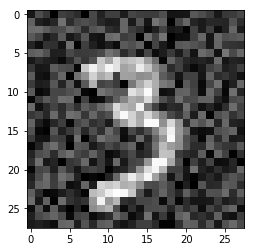

The classification label following attack is 9 from an original classification of 3
The L2 distance of the adversary is 6.817384575905331
run with verbose=True to see details
Step 0: 1.22871e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 9.65373e-02, stepsizes = 6.7e-03/6.7e-03:  (took 0.04891 seconds)
Step 100: 8.48350e-02, stepsizes = 6.7e-03/4.4e-03: d. reduced by 0.89% (7.5915e-04) (took 0.04378 seconds)
Step 150: 7.42282e-02, stepsizes = 3.0e-03/2.0e-03:  (took 0.00929 seconds)
Step 200: 6.94948e-02, stepsizes = 3.0e-03/1.3e-03: d. reduced by 0.26% (1.8339e-04) (took 0.01167 seconds)
Step 250: 6.62756e-02, stepsizes = 1.3e-03/5.9e-04: d. reduced by 0.18% (1.1652e-04) (took 0.01062 seconds)
Step 300: 6.57089e-02, stepsizes = 8.8e-04/2.6e-04:  (took 0.01116 seconds)
Step 350: 6.52547e-02, stepsizes = 5.9e-04/1.7e-04: d. reduced by 0.03% (2.2638e-05) (took 0.01039 seconds)
Step 400: 6.46639e-02, stepsizes = 3.9e-04/7.7e-05: d. reduced by 0.02% (9.9689e-06) (took 0.01273 seconds)
Step 45

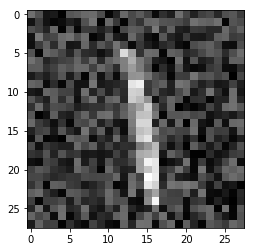

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 7.033751129142324
run with verbose=True to see details
Step 0: 1.07897e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 9.18699e-02, stepsizes = 6.7e-03/6.7e-03:  (took 0.05171 seconds)
Step 100: 8.98450e-02, stepsizes = 6.7e-03/4.4e-03:  (took 0.04920 seconds)
Step 150: 8.90482e-02, stepsizes = 4.4e-03/3.0e-03:  (took 0.01007 seconds)
Step 200: 8.85801e-02, stepsizes = 3.0e-03/1.3e-03:  (took 0.01004 seconds)
Step 250: 8.48483e-02, stepsizes = 3.0e-03/8.8e-04: d. reduced by 0.18% (1.4918e-04) (took 0.01290 seconds)
Step 300: 7.95090e-02, stepsizes = 3.0e-03/8.8e-04: d. reduced by 0.18% (1.3979e-04) (took 0.01130 seconds)
Step 350: 7.83079e-02, stepsizes = 2.0e-03/3.9e-04:  (took 0.01128 seconds)
Step 400: 7.55462e-02, stepsizes = 2.0e-03/3.9e-04:  (took 0.00894 seconds)
Step 450: 7.38939e-02, stepsizes = 1.3e-03/2.6e-04: d. reduced by 0.05% (3.8458e-05) (took 0.01145 seco

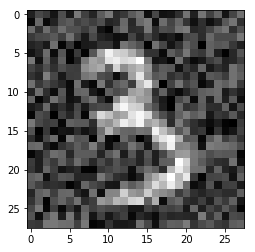

The classification label following attack is 8 from an original classification of 3
The L2 distance of the adversary is 7.43783293861561
run with verbose=True to see details
Step 0: 1.35126e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.19774e-01, stepsizes = 6.7e-03/6.7e-03:  (took 0.05299 seconds)
Step 100: 1.19774e-01, stepsizes = 4.4e-03/4.4e-03:  (took 0.04681 seconds)
Step 150: 1.17776e-01, stepsizes = 3.0e-03/2.0e-03:  (took 0.01100 seconds)
Step 200: 1.15623e-01, stepsizes = 2.0e-03/8.8e-04:  (took 0.01123 seconds)
Step 250: 1.14568e-01, stepsizes = 1.3e-03/3.9e-04:  (took 0.01050 seconds)
Step 300: 1.13677e-01, stepsizes = 8.8e-04/2.6e-04:  (took 0.01074 seconds)
Step 350: 1.13244e-01, stepsizes = 5.9e-04/1.2e-04: d. reduced by 0.03% (3.9287e-05) (took 0.01046 seconds)
Step 400: 1.12661e-01, stepsizes = 3.9e-04/1.2e-04:  (took 0.01249 seconds)
Step 450: 1.11890e-01, stepsizes = 3.9e-04/7.7e-05:  (took 0.01104 seconds)
Step 500: 1.11271e-01, stepsizes = 2.6e-04/5.1e-05: d. reduc

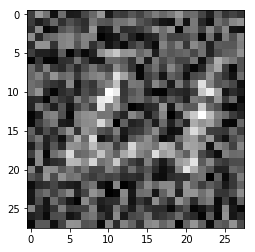

The classification label following attack is 0 from an original classification of 4
The L2 distance of the adversary is 9.185848660499124
run with verbose=True to see details
Step 0: 1.17195e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 7.53110e-02, stepsizes = 1.0e-02/1.0e-02:  (took 0.04549 seconds)
Step 100: 7.43102e-02, stepsizes = 4.4e-03/4.4e-03:  (took 0.04320 seconds)
Step 150: 7.34333e-02, stepsizes = 3.0e-03/2.0e-03:  (took 0.01070 seconds)
Step 200: 7.23766e-02, stepsizes = 2.0e-03/8.8e-04:  (took 0.01046 seconds)
Step 250: 7.03296e-02, stepsizes = 1.3e-03/5.9e-04: d. reduced by 0.12% (8.2397e-05) (took 0.01204 seconds)
Step 300: 6.83276e-02, stepsizes = 1.3e-03/3.9e-04: d. reduced by 0.08% (5.3352e-05) (took 0.01045 seconds)
Step 350: 6.71993e-02, stepsizes = 8.8e-04/2.6e-04:  (took 0.01058 seconds)
Step 400: 6.66653e-02, stepsizes = 5.9e-04/1.7e-04:  (took 0.01042 seconds)
Step 450: 6.61892e-02, stepsizes = 3.9e-04/7.7e-05: d. reduced by 0.02% (1.0204e-05) (took 0.01066 seco

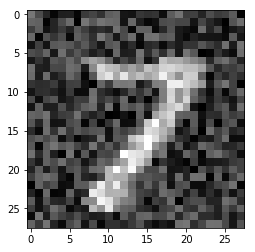

The classification label following attack is 2 from an original classification of 7
The L2 distance of the adversary is 7.13523483116008
run with verbose=True to see details
Step 0: 2.27391e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 2.02915e-01, stepsizes = 6.7e-03/6.7e-03:  (took 0.03892 seconds)
Step 100: 2.02915e-01, stepsizes = 4.4e-03/4.4e-03:  (took 0.04199 seconds)
Step 150: 2.00322e-01, stepsizes = 3.0e-03/2.0e-03:  (took 0.01102 seconds)
Step 200: 2.00322e-01, stepsizes = 1.3e-03/8.8e-04:  (took 0.01177 seconds)
Step 250: 1.98881e-01, stepsizes = 8.8e-04/3.9e-04: d. reduced by 0.08% (1.5529e-04) (took 0.01104 seconds)
Step 300: 1.94531e-01, stepsizes = 8.8e-04/2.6e-04:  (took 0.01043 seconds)
Step 350: 1.93219e-01, stepsizes = 5.9e-04/1.7e-04: d. reduced by 0.03% (6.7032e-05) (took 0.01249 seconds)
Step 400: 1.92150e-01, stepsizes = 3.9e-04/1.2e-04: d. reduced by 0.02% (2.9623e-05) (took 0.01160 seconds)
Step 450: 1.90073e-01, stepsizes = 5.9e-04/2.6e-04:  (took 0.01026 secon

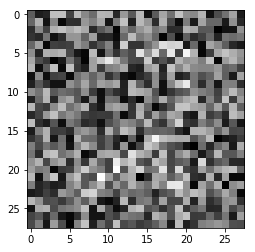

The classification label following attack is 8 from an original classification of 2
The L2 distance of the adversary is 11.991122248976168
run with verbose=True to see details
Step 0: 1.29895e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 4.85111e-02, stepsizes = 1.0e-02/1.0e-02: d. reduced by 1.99% (9.8497e-04) (took 0.00645 seconds)
Step 100: 3.73556e-02, stepsizes = 6.7e-03/6.7e-03:  (took 0.04293 seconds)
Step 150: 2.70422e-02, stepsizes = 6.7e-03/4.4e-03: d. reduced by 0.89% (2.4199e-04) (took 0.01136 seconds)
Step 200: 2.44460e-02, stepsizes = 4.4e-03/3.0e-03: d. reduced by 0.59% (1.4551e-04) (took 0.01105 seconds)
Step 250: 1.83847e-02, stepsizes = 6.7e-03/4.4e-03: d. reduced by 0.89% (1.6452e-04) (took 0.01030 seconds)
Step 300: 1.74627e-02, stepsizes = 4.4e-03/2.0e-03:  (took 0.01045 seconds)
Step 350: 1.68301e-02, stepsizes = 2.0e-03/8.8e-04:  (took 0.01061 seconds)
Step 400: 1.64309e-02, stepsizes = 2.0e-03/5.9e-04:  (took 0.01129 seconds)
Step 450: 1.58700e-02, stepsizes = 1.3

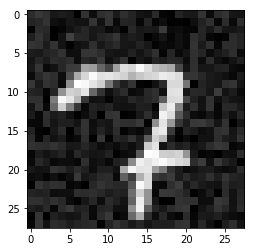

The classification label following attack is 2 from an original classification of 7
The L2 distance of the adversary is 3.3939908255760347
run with verbose=True to see details
Step 0: 1.30273e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.07270e-01, stepsizes = 6.7e-03/6.7e-03:  (took 0.04257 seconds)
Step 100: 9.76804e-02, stepsizes = 4.4e-03/4.4e-03:  (took 0.04769 seconds)
Step 150: 9.20508e-02, stepsizes = 3.0e-03/2.0e-03:  (took 0.01009 seconds)
Step 200: 9.18085e-02, stepsizes = 2.0e-03/1.3e-03:  (took 0.00999 seconds)
Step 250: 9.16474e-02, stepsizes = 8.8e-04/5.9e-04:  (took 0.01064 seconds)
Step 300: 9.14687e-02, stepsizes = 5.9e-04/2.6e-04: d. reduced by 0.08% (7.1421e-05) (took 0.00996 seconds)
Step 350: 9.13736e-02, stepsizes = 3.9e-04/1.7e-04:  (took 0.01036 seconds)
Step 400: 9.09870e-02, stepsizes = 2.6e-04/7.7e-05: d. reduced by 0.02% (1.4027e-05) (took 0.01001 seconds)
Step 450: 9.04556e-02, stepsizes = 2.6e-04/7.7e-05: d. reduced by 0.02% (1.3945e-05) (took 0.01033 sec

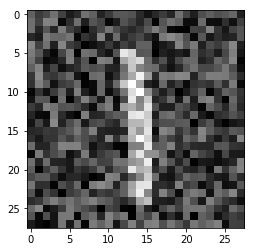

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 8.175571935435244
run with verbose=True to see details
Step 0: 2.39287e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 2.12100e-01, stepsizes = 6.7e-03/6.7e-03:  (took 0.04672 seconds)
Step 100: 2.02854e-01, stepsizes = 4.4e-03/4.4e-03:  (took 0.04044 seconds)
Step 150: 1.84478e-01, stepsizes = 4.4e-03/2.0e-03:  (took 0.01119 seconds)
Step 200: 1.72713e-01, stepsizes = 3.0e-03/1.3e-03: d. reduced by 0.26% (4.5578e-04) (took 0.01005 seconds)
Step 250: 1.72107e-01, stepsizes = 1.3e-03/5.9e-04:  (took 0.01037 seconds)
Step 300: 1.72107e-01, stepsizes = 8.8e-04/3.9e-04:  (took 0.01025 seconds)
Step 350: 1.71883e-01, stepsizes = 5.9e-04/1.7e-04:  (took 0.01115 seconds)
Step 400: 1.70774e-01, stepsizes = 3.9e-04/1.2e-04:  (took 0.00877 seconds)
Step 450: 1.70152e-01, stepsizes = 2.6e-04/5.1e-05: d. reduced by 0.01% (1.7487e-05) (took 0.01087 seconds)
Step 500: 1.69640e-01, step

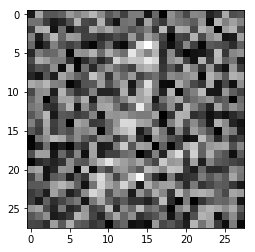

The classification label following attack is 8 from an original classification of 2
The L2 distance of the adversary is 11.475939347415796
run with verbose=True to see details
Step 0: 1.96628e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.48399e-01, stepsizes = 6.7e-03/6.7e-03:  (took 0.04711 seconds)
Step 100: 1.48399e-01, stepsizes = 4.4e-03/4.4e-03:  (took 0.04435 seconds)
Step 150: 1.46939e-01, stepsizes = 3.0e-03/2.0e-03:  (took 0.01188 seconds)
Step 200: 1.46166e-01, stepsizes = 2.0e-03/1.3e-03:  (took 0.01087 seconds)
Step 250: 1.44804e-01, stepsizes = 8.8e-04/3.9e-04:  (took 0.01066 seconds)
Step 300: 1.41636e-01, stepsizes = 1.3e-03/5.9e-04: d. reduced by 0.05% (7.3715e-05) (took 0.01217 seconds)
Step 350: 1.37229e-01, stepsizes = 1.3e-03/5.9e-04:  (took 0.01097 seconds)
Step 400: 1.30797e-01, stepsizes = 1.3e-03/5.9e-04: d. reduced by 0.12% (1.5324e-04) (took 0.01034 seconds)
Step 450: 1.29678e-01, stepsizes = 8.8e-04/2.6e-04:  (took 0.00896 seconds)
Step 500: 1.27404e-01, ste

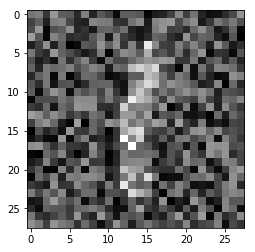

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 9.737181672515273
run with verbose=True to see details
Step 0: 1.12296e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.01558e-01, stepsizes = 6.7e-03/6.7e-03:  (took 0.04435 seconds)
Step 100: 9.88768e-02, stepsizes = 4.4e-03/4.4e-03:  (took 0.04326 seconds)
Step 150: 9.76131e-02, stepsizes = 3.0e-03/2.0e-03:  (took 0.01097 seconds)
Step 200: 9.54501e-02, stepsizes = 2.0e-03/8.8e-04:  (took 0.01099 seconds)
Step 250: 9.16706e-02, stepsizes = 1.3e-03/5.9e-04: d. reduced by 0.12% (1.0740e-04) (took 0.01139 seconds)
Step 300: 9.01099e-02, stepsizes = 1.3e-03/3.9e-04:  (took 0.01009 seconds)
Step 350: 8.69997e-02, stepsizes = 2.0e-03/8.8e-04: d. reduced by 0.12% (1.0193e-04) (took 0.01171 seconds)
Step 400: 8.34810e-02, stepsizes = 1.3e-03/8.8e-04:  (took 0.00905 seconds)
Step 450: 7.96609e-02, stepsizes = 1.3e-03/5.9e-04: d. reduced by 0.12% (9.3329e-05) (took 0.01097 seco

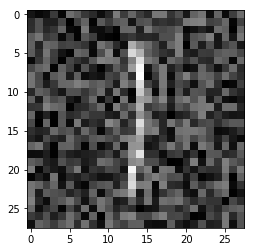

The classification label following attack is 2 from an original classification of 1
The L2 distance of the adversary is 7.487520668011209
run with verbose=True to see details
Step 0: 2.40452e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.74323e-01, stepsizes = 6.7e-03/6.7e-03:  (took 0.05700 seconds)
Step 100: 1.67465e-01, stepsizes = 4.4e-03/4.4e-03:  (took 0.03800 seconds)
Step 150: 1.63051e-01, stepsizes = 3.0e-03/3.0e-03:  (took 0.00864 seconds)
Step 200: 1.53461e-01, stepsizes = 2.0e-03/1.3e-03: d. reduced by 0.26% (4.0498e-04) (took 0.01095 seconds)
Step 250: 1.44816e-01, stepsizes = 1.3e-03/8.8e-04:  (took 0.01049 seconds)
Step 300: 1.39654e-01, stepsizes = 1.3e-03/8.8e-04: d. reduced by 0.12% (1.6362e-04) (took 0.01066 seconds)
Step 350: 1.35307e-01, stepsizes = 8.8e-04/5.9e-04:  (took 0.01058 seconds)
Step 400: 1.33160e-01, stepsizes = 5.9e-04/2.6e-04: d. reduced by 0.05% (6.9303e-05) (took 0.01091 seconds)
Step 450: 1.31941e-01, stepsizes = 2.6e-04/1.2e-04: d. reduced by 0.03%

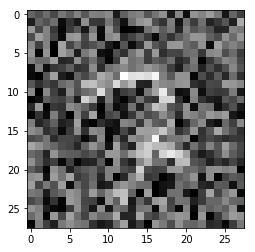

The classification label following attack is 2 from an original classification of 7
The L2 distance of the adversary is 9.954711312832533
run with verbose=True to see details
Step 0: 1.02260e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 7.71777e-02, stepsizes = 6.7e-03/6.7e-03:  (took 0.03884 seconds)
Step 100: 7.71777e-02, stepsizes = 4.4e-03/4.4e-03:  (took 0.04539 seconds)
Step 150: 7.55906e-02, stepsizes = 3.0e-03/2.0e-03:  (took 0.01373 seconds)
Step 200: 7.50941e-02, stepsizes = 2.0e-03/1.3e-03:  (took 0.01063 seconds)
Step 250: 7.49185e-02, stepsizes = 8.8e-04/3.9e-04:  (took 0.01108 seconds)
Step 300: 7.43941e-02, stepsizes = 5.9e-04/2.6e-04: d. reduced by 0.05% (3.8718e-05) (took 0.01014 seconds)
Step 350: 7.37773e-02, stepsizes = 3.9e-04/1.2e-04: d. reduced by 0.02% (1.7062e-05) (took 0.01095 seconds)
Step 400: 7.29799e-02, stepsizes = 3.9e-04/1.2e-04: d. reduced by 0.02% (1.6877e-05) (took 0.01030 seconds)
Step 450: 7.25480e-02, stepsizes = 2.6e-04/7.7e-05: d. reduced by 0.02%

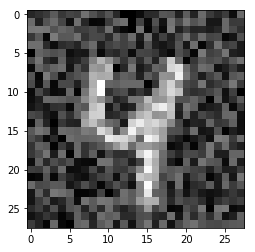

The classification label following attack is 9 from an original classification of 4
The L2 distance of the adversary is 7.465299458185988
run with verbose=True to see details
Step 0: 3.10764e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 2.98519e-01, stepsizes = 6.7e-03/6.7e-03:  (took 0.04370 seconds)
Step 100: 2.98519e-01, stepsizes = 4.4e-03/4.4e-03:  (took 0.04129 seconds)
Step 150: 2.92380e-01, stepsizes = 3.0e-03/2.0e-03:  (took 0.01047 seconds)
Step 200: 2.81789e-01, stepsizes = 2.0e-03/8.8e-04: d. reduced by 0.26% (7.4363e-04) (took 0.01026 seconds)
Step 250: 2.67012e-01, stepsizes = 2.0e-03/5.9e-04: d. reduced by 0.12% (3.1283e-04) (took 0.01092 seconds)
Step 300: 2.56792e-01, stepsizes = 1.3e-03/2.6e-04: d. reduced by 0.08% (2.0051e-04) (took 0.00990 seconds)
Step 350: 2.49482e-01, stepsizes = 1.3e-03/3.9e-04: d. reduced by 0.08% (1.9480e-04) (took 0.01044 seconds)
Step 400: 2.43518e-01, stepsizes = 1.3e-03/3.9e-04: d. reduced by 0.08% (1.9015e-04) (took 0.01042 seconds)
Step 45

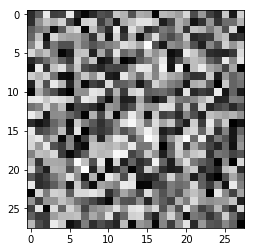

The classification label following attack is 3 from an original classification of 2
The L2 distance of the adversary is 13.377367838953452
run with verbose=True to see details
Step 0: 8.43939e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 7.63243e-02, stepsizes = 1.0e-02/1.0e-02:  (took 0.04485 seconds)
Step 100: 6.99675e-02, stepsizes = 6.7e-03/4.4e-03:  (took 0.04348 seconds)
Step 150: 6.61959e-02, stepsizes = 4.4e-03/2.0e-03:  (took 0.01002 seconds)
Step 200: 6.55017e-02, stepsizes = 2.0e-03/8.8e-04:  (took 0.01158 seconds)
Step 250: 6.32899e-02, stepsizes = 1.3e-03/3.9e-04: d. reduced by 0.08% (4.9418e-05) (took 0.01549 seconds)
Step 300: 6.14563e-02, stepsizes = 8.8e-04/2.6e-04: d. reduced by 0.05% (3.1985e-05) (took 0.01089 seconds)
Step 350: 6.02950e-02, stepsizes = 5.9e-04/1.7e-04: d. reduced by 0.03% (2.0918e-05) (took 0.01152 seconds)
Step 400: 5.95468e-02, stepsizes = 3.9e-04/1.2e-04:  (took 0.01108 seconds)
Step 450: 5.92614e-02, stepsizes = 2.6e-04/5.1e-05: d. reduced by 0.01

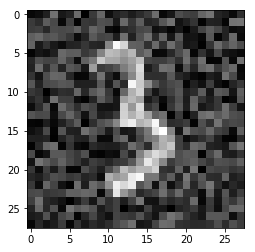

The classification label following attack is 8 from an original classification of 3
The L2 distance of the adversary is 6.776808015624855
run with verbose=True to see details
Step 0: 1.21968e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.00431e-01, stepsizes = 1.0e-02/6.7e-03:  (took 0.04470 seconds)
Step 100: 9.51980e-02, stepsizes = 1.0e-02/4.4e-03:  (took 0.04373 seconds)
Step 150: 8.85169e-02, stepsizes = 6.7e-03/3.0e-03:  (took 0.00975 seconds)
Step 200: 8.77041e-02, stepsizes = 3.0e-03/8.8e-04: d. reduced by 0.26% (2.3145e-04) (took 0.01077 seconds)
Step 250: 8.26194e-02, stepsizes = 3.0e-03/1.3e-03: d. reduced by 0.18% (1.4526e-04) (took 0.01201 seconds)
Step 300: 7.89994e-02, stepsizes = 2.0e-03/8.8e-04:  (took 0.00975 seconds)
Step 350: 7.64514e-02, stepsizes = 2.0e-03/5.9e-04:  (took 0.01102 seconds)
Step 400: 7.44782e-02, stepsizes = 2.0e-03/8.8e-04:  (took 0.01035 seconds)
Step 450: 7.19071e-02, stepsizes = 2.0e-03/8.8e-04: d. reduced by 0.18% (1.2642e-04) (took 0.01091 seco

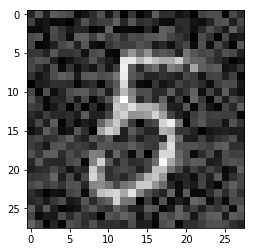

The classification label following attack is 8 from an original classification of 5
The L2 distance of the adversary is 6.116965860588465
run with verbose=True to see details
Step 0: 2.02858e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 8.21033e-02, stepsizes = 1.0e-02/1.0e-02: d. reduced by 1.99% (1.6670e-03) (took 0.00556 seconds)
Step 100: 6.45067e-02, stepsizes = 6.7e-03/6.7e-03:  (took 0.04137 seconds)
Step 150: 6.19691e-02, stepsizes = 4.4e-03/3.0e-03:  (took 0.01190 seconds)
Step 200: 6.09962e-02, stepsizes = 3.0e-03/2.0e-03:  (took 0.01053 seconds)
Step 250: 6.05158e-02, stepsizes = 2.0e-03/1.3e-03:  (took 0.00946 seconds)
Step 300: 6.04096e-02, stepsizes = 8.8e-04/3.9e-04:  (took 0.01029 seconds)
Step 350: 5.97686e-02, stepsizes = 5.9e-04/2.6e-04:  (took 0.00935 seconds)
Step 400: 5.92731e-02, stepsizes = 3.9e-04/1.7e-04: d. reduced by 0.03% (2.0563e-05) (took 0.01138 seconds)
Step 450: 5.88090e-02, stepsizes = 2.6e-04/1.2e-04:  (took 0.01210 seconds)
Step 500: 5.86957e-02, step

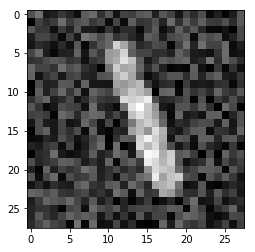

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 6.7581964719587
run with verbose=True to see details
Step 0: 1.10736e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 9.68506e-02, stepsizes = 6.7e-03/6.7e-03:  (took 0.04361 seconds)
Step 100: 9.68506e-02, stepsizes = 4.4e-03/4.4e-03:  (took 0.04435 seconds)
Step 150: 9.25429e-02, stepsizes = 3.0e-03/2.0e-03:  (took 0.00898 seconds)
Step 200: 9.22993e-02, stepsizes = 2.0e-03/1.3e-03:  (took 0.01055 seconds)
Step 250: 9.07186e-02, stepsizes = 1.3e-03/5.9e-04:  (took 0.01103 seconds)
Step 300: 8.99079e-02, stepsizes = 5.9e-04/2.6e-04:  (took 0.01138 seconds)
Step 350: 8.96432e-02, stepsizes = 3.9e-04/1.7e-04:  (took 0.00888 seconds)
Step 400: 8.93191e-02, stepsizes = 2.6e-04/7.7e-05:  (took 0.01050 seconds)
Step 450: 8.91357e-02, stepsizes = 1.7e-04/5.1e-05:  (took 0.01006 seconds)
Step 500: 8.89984e-02, stepsizes = 1.2e-04/2.3e-05: d. reduced by 0.00% (4.0650e-06) (took 0.

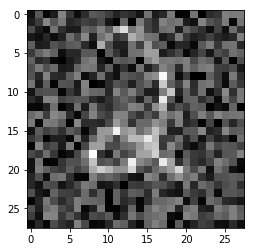

The classification label following attack is 6 from an original classification of 2
The L2 distance of the adversary is 8.343686115362539
run with verbose=True to see details
Step 0: 1.39752e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 8.62791e-02, stepsizes = 1.0e-02/6.7e-03:  (took 0.04565 seconds)
Step 100: 7.85662e-02, stepsizes = 6.7e-03/4.4e-03:  (took 0.04174 seconds)
Step 150: 7.09183e-02, stepsizes = 6.7e-03/3.0e-03:  (took 0.01101 seconds)
Step 200: 6.61337e-02, stepsizes = 4.4e-03/1.3e-03: d. reduced by 0.26% (1.7452e-04) (took 0.01199 seconds)
Step 250: 5.99858e-02, stepsizes = 4.4e-03/2.0e-03:  (took 0.01120 seconds)
Step 300: 5.67559e-02, stepsizes = 4.4e-03/1.3e-03: d. reduced by 0.26% (1.4978e-04) (took 0.01118 seconds)
Step 350: 4.92693e-02, stepsizes = 6.7e-03/3.0e-03: d. reduced by 0.39% (1.9522e-04) (took 0.01192 seconds)
Step 400: 4.02598e-02, stepsizes = 1.0e-02/6.7e-03:  (took 0.01139 seconds)
Step 450: 3.99028e-02, stepsizes = 6.7e-03/3.0e-03:  (took 0.01142 seco

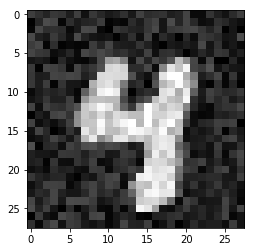

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 4.617984792351358
run with verbose=True to see details
Step 0: 4.35231e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 3.21941e-02, stepsizes = 6.7e-03/6.7e-03:  (took 0.04811 seconds)
Step 100: 3.14388e-02, stepsizes = 4.4e-03/3.0e-03:  (took 0.04698 seconds)
Step 150: 3.00408e-02, stepsizes = 3.0e-03/2.0e-03: d. reduced by 0.39% (1.1903e-04) (took 0.01135 seconds)
Step 200: 2.81624e-02, stepsizes = 2.0e-03/8.8e-04:  (took 0.01112 seconds)
Step 250: 2.70897e-02, stepsizes = 1.3e-03/3.9e-04: d. reduced by 0.08% (2.1152e-05) (took 0.01093 seconds)
Step 300: 2.53356e-02, stepsizes = 2.0e-03/8.8e-04: d. reduced by 0.18% (4.4544e-05) (took 0.01121 seconds)
Step 350: 2.38668e-02, stepsizes = 2.0e-03/8.8e-04:  (took 0.01124 seconds)
Step 400: 2.32190e-02, stepsizes = 1.3e-03/3.9e-04: d. reduced by 0.08% (1.8130e-05) (took 0.01158 seconds)
Step 450: 2.24878e-02, stepsizes = 1.3e

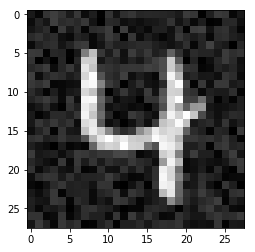

The classification label following attack is 9 from an original classification of 4
The L2 distance of the adversary is 3.8247870472159895


In [300]:
num_images_to_attack = 50
num_iterations = 1000
adversary_found, adversary_distance, adversary_arrays = evaluate_l2_BoundaryAttack_resistance_CustomModel(model_prediction_function=cnn_binding_predictions,
                                                                                        model_weights="/Binding_CNN.ckpt", 
                                                                                      var_list=var_list_Binding,
                                                                                        num_images_to_attack=num_images_to_attack,
                                                                                        num_iterations=num_iterations, temp_batch_size=1)
#Note that as the Boundary Attack appears to display unusual behaviour against this network, each adversarial image is also shown

In [0]:
np.savetxt("BindingNetwork_adversaries.csv", 
           np.reshape(adversary_arrays, [adversary_arrays.shape[0], adversary_arrays.shape[1]*adversary_arrays.shape[2]]), 
                      delimiter=',')

In [0]:
success_ratio = np.sum(adversary_found)/num_images_to_attack
mean_distance_successful_attacks = np.sum(adversary_distance)/np.sum(adversary_found)

In [303]:
print("The success ratio is " + str(success_ratio))
print("The mean distance is " + str(mean_distance_successful_attacks))

The success ratio is 1.0
The mean distance is 7.784518770461933


In [304]:
!find -type f | grep -P '\.csv' | tar cvzf Generated_adversaries.gz -T -

./StandardCNN_adversaries.csv
./BindingNetwork_adversaries.csv
./Madry_adversaries.csv


In [0]:
from google.colab import files
files.download('Generated_adversaries.gz') 

On running the above, the Binding-network appears to only misclassify 24% of the examples generated, and of these, the mean L-2 distance required to cause misclassification is 8.32. This is much better performance than for the other networks, but on inspecting the running of the code, the Boundary Attack appears to be performing oddly together with the network, in that after identifying an adversarial example (i.e. with 100% success, as for the other models), it continues to iteratively decrease the noise over the 1000 iteraitons. After this reduction in noise, the network is generally able to classify the example; thus the issue appears to be that the Boundary Attack is not remaining in what the 'region of adversity'. It is likely this is due to a bug in my own execution of the attack, and so an alternative measure of adversarial resistance is explored below.

#Part 3 - Direct Comparison of Each Network's Performance

##Transfer Attacks

As it is unclear from the above results whether the Binding CNN is genuinely more resistant to adversarial attacks, or there is simply an issue with how the Boundary Attack is being leveraged against it, an additional measure will be performed. The following assesses how resistant each network is to the adversarial examples generated by the other networks; such an attack is in fact a form of a blac box attack know as a 'transfer attack'. Generally speaking, adversarial examples generalize well across models, and so any indication that a model is resistant to the adversarial examples of other is a positive sign that it is genuinely resistant. As this assessment does not make use of FoolBox, any possible issues with the implementation of the Boundary Attack against the binding network should not confer non-genuine resistance to the transfer attacks.

###Transfer Attacks Against the Keras Models

In [0]:
def Transfer_Attack_KerasModel(model, transfer_attack_images):
    
    #Load transfer_attack_images and reshape
    transfer_images = np.genfromtxt(transfer_attack_images, delimiter=',')
    

    
    for ii in range(transfer_images.shape[0]):
        test_image = transfer_images[ii, :]
                
        plt.imshow(np.reshape(test_image, [28, 28, 1])[:,:,0], cmap='gray')
        plt.show()
        print("The network predicted a class label of " + str(np.argmax(model.predictions(test_image))))
        


####Madry Model vs Standard CNN Adversaries

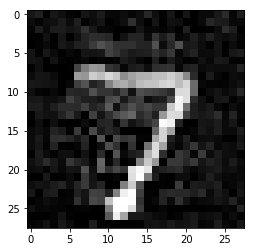

The network predicted a class label of 7


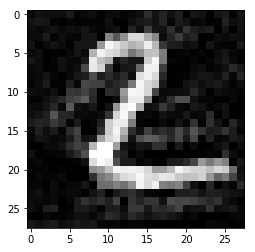

The network predicted a class label of 2


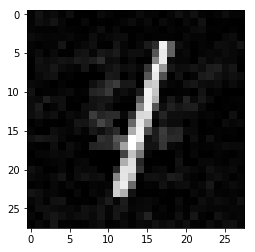

The network predicted a class label of 1


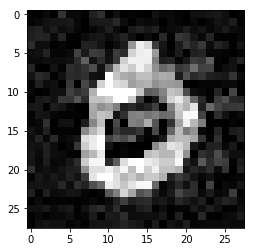

The network predicted a class label of 0


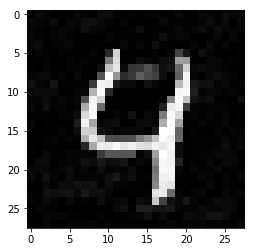

The network predicted a class label of 4


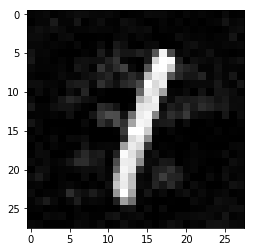

The network predicted a class label of 1


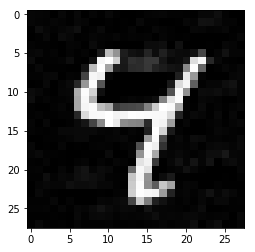

The network predicted a class label of 4


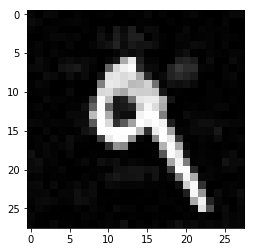

The network predicted a class label of 9


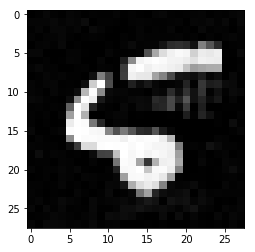

The network predicted a class label of 5


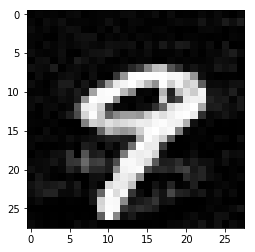

The network predicted a class label of 9


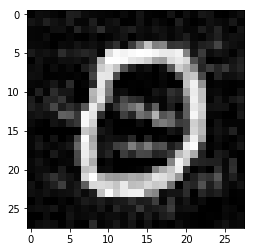

The network predicted a class label of 0


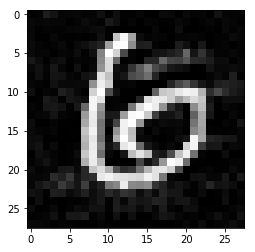

The network predicted a class label of 6


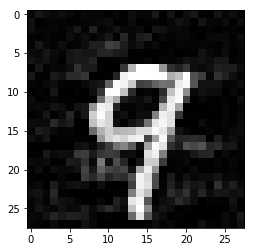

The network predicted a class label of 9


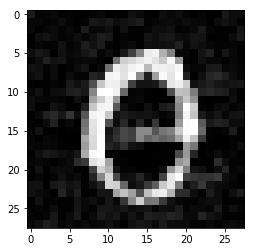

The network predicted a class label of 0


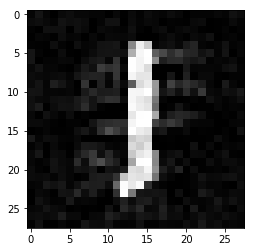

The network predicted a class label of 1


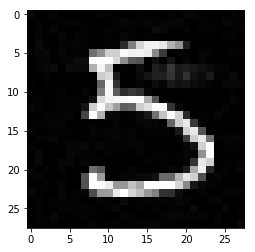

The network predicted a class label of 5


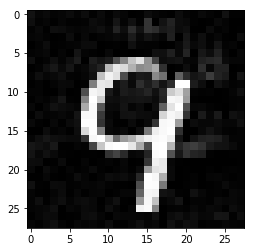

The network predicted a class label of 9


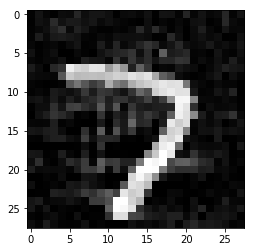

The network predicted a class label of 7


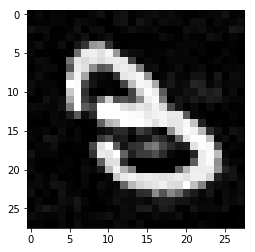

The network predicted a class label of 3


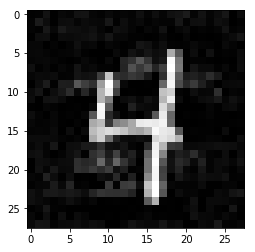

The network predicted a class label of 4


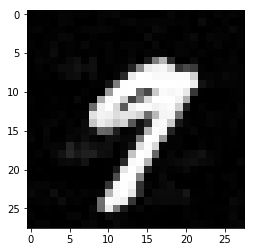

The network predicted a class label of 9


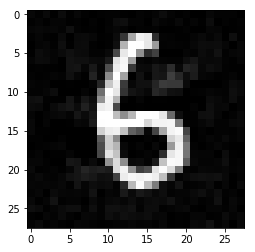

The network predicted a class label of 6


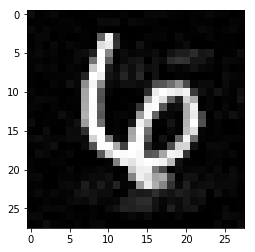

The network predicted a class label of 6


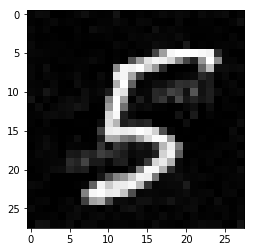

The network predicted a class label of 5


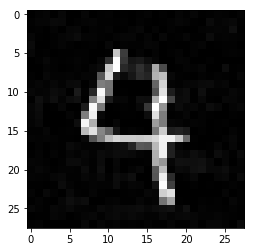

The network predicted a class label of 4


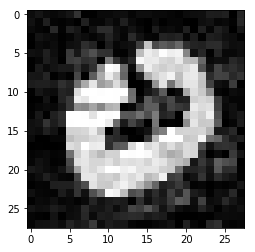

The network predicted a class label of 0


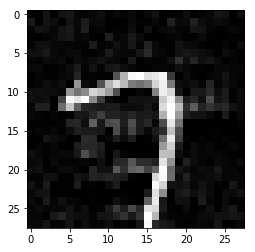

The network predicted a class label of 7


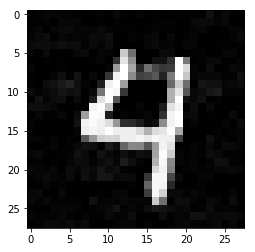

The network predicted a class label of 4


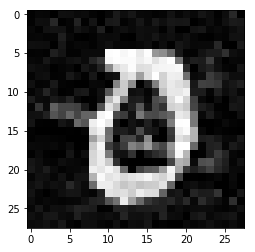

The network predicted a class label of 0


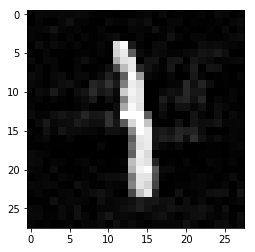

The network predicted a class label of 1


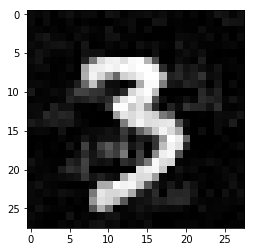

The network predicted a class label of 3


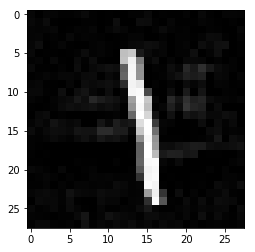

The network predicted a class label of 1


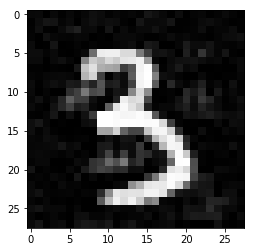

The network predicted a class label of 3


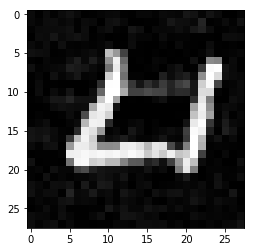

The network predicted a class label of 4


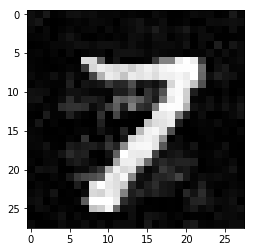

The network predicted a class label of 7


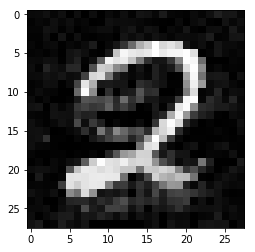

The network predicted a class label of 2


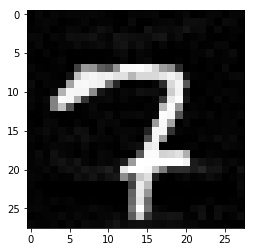

The network predicted a class label of 7


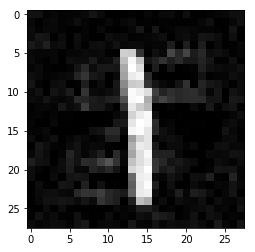

The network predicted a class label of 1


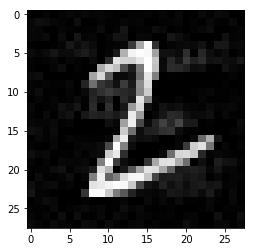

The network predicted a class label of 2


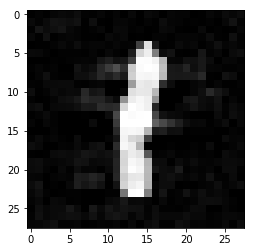

The network predicted a class label of 1


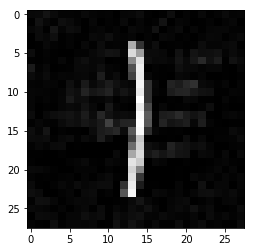

The network predicted a class label of 1


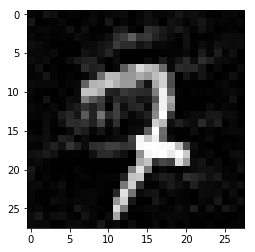

The network predicted a class label of 7


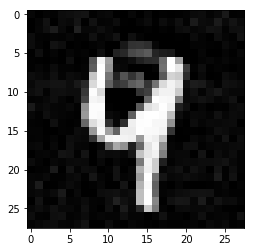

The network predicted a class label of 4


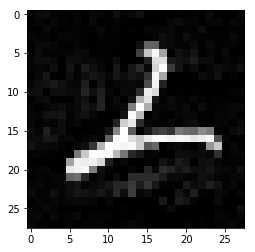

The network predicted a class label of 2


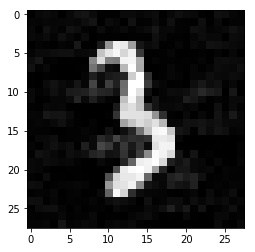

The network predicted a class label of 3


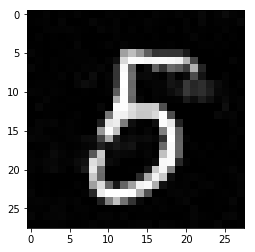

The network predicted a class label of 5


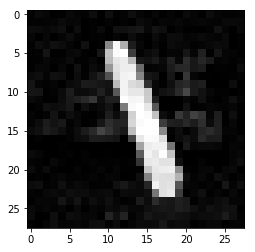

The network predicted a class label of 1


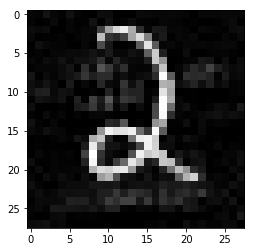

The network predicted a class label of 2


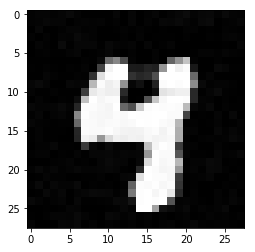

The network predicted a class label of 4


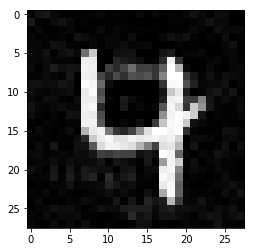

The network predicted a class label of 4


In [297]:
Transfer_Attack_KerasModel(model=Madry_model, transfer_attack_images="StandardCNN_adversaries.csv")

The Madry network performs well against standard CNN adversaries, getting 10/10.

####Madry Model vs Binding CNN Adversaries

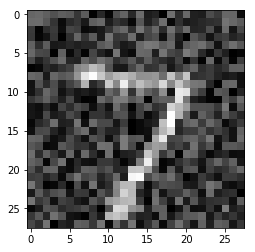

The network predicted a class label of 7


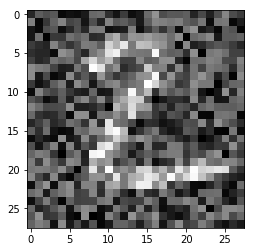

The network predicted a class label of 2


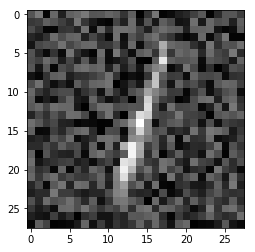

The network predicted a class label of 1


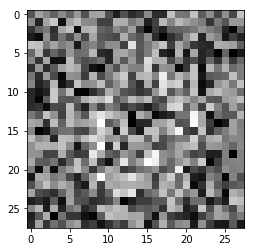

The network predicted a class label of 0


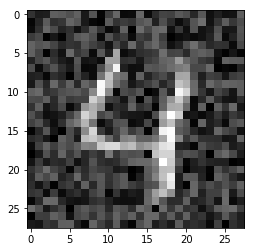

The network predicted a class label of 4


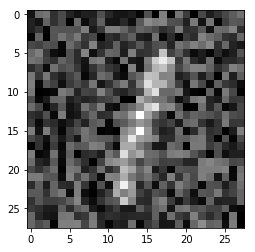

The network predicted a class label of 2


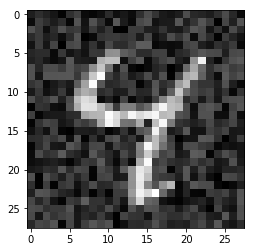

The network predicted a class label of 4


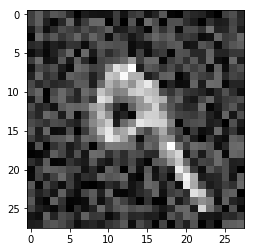

The network predicted a class label of 9


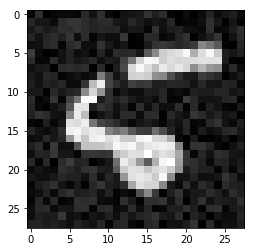

The network predicted a class label of 5


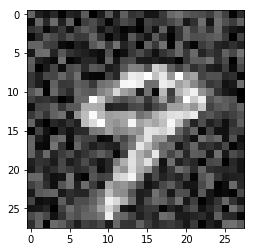

The network predicted a class label of 9


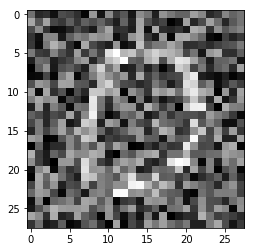

The network predicted a class label of 0


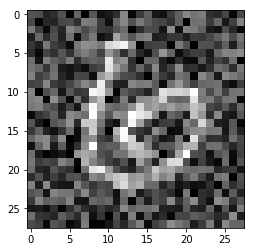

The network predicted a class label of 0


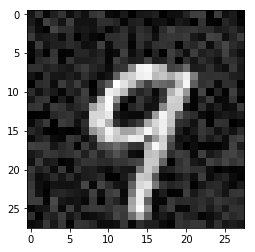

The network predicted a class label of 9


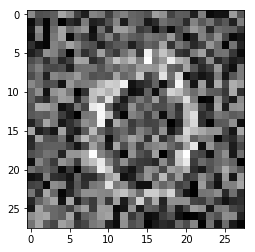

The network predicted a class label of 0


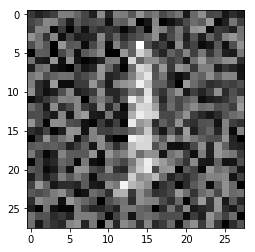

The network predicted a class label of 0


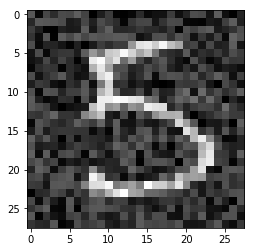

The network predicted a class label of 5


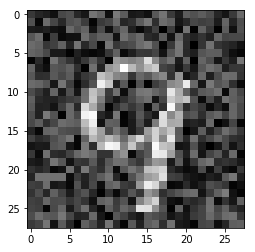

The network predicted a class label of 9


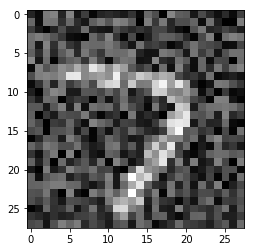

The network predicted a class label of 0


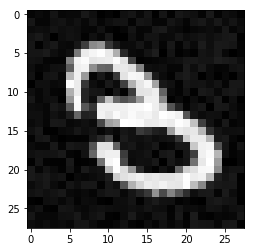

The network predicted a class label of 3


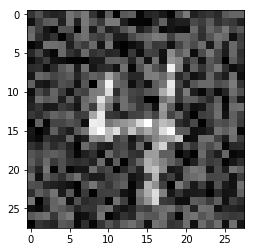

The network predicted a class label of 4


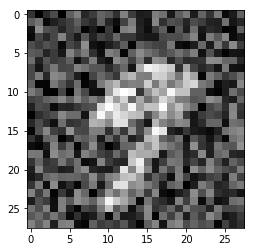

The network predicted a class label of 2


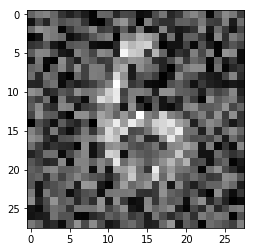

The network predicted a class label of 8


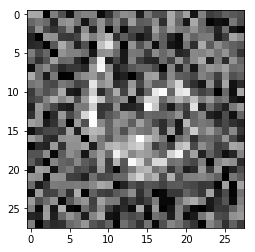

The network predicted a class label of 0


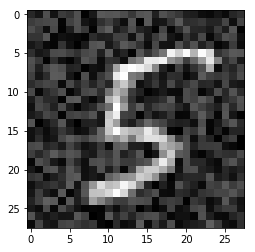

The network predicted a class label of 5


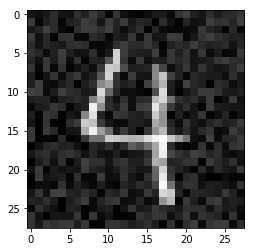

The network predicted a class label of 4


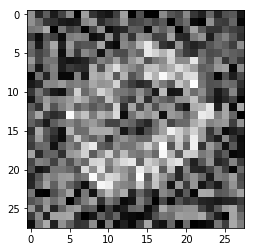

The network predicted a class label of 0


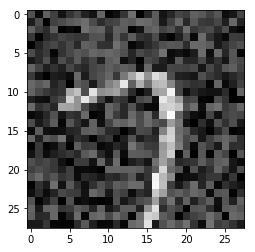

The network predicted a class label of 7


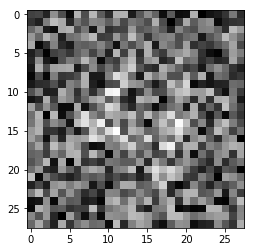

The network predicted a class label of 0


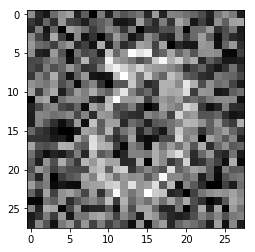

The network predicted a class label of 0


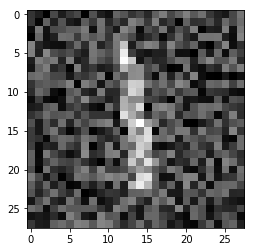

The network predicted a class label of 8


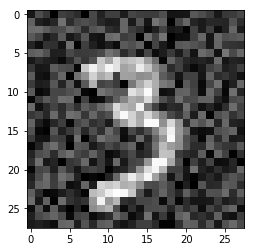

The network predicted a class label of 3


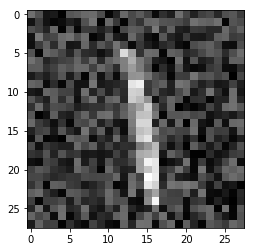

The network predicted a class label of 1


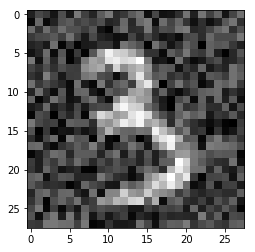

The network predicted a class label of 3


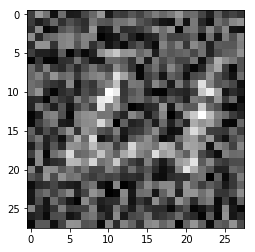

The network predicted a class label of 0


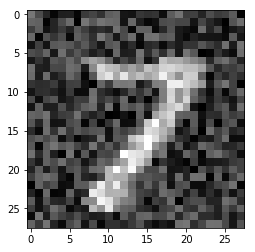

The network predicted a class label of 2


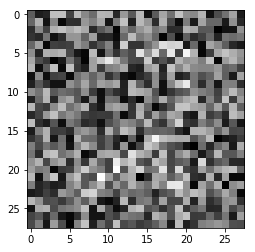

The network predicted a class label of 0


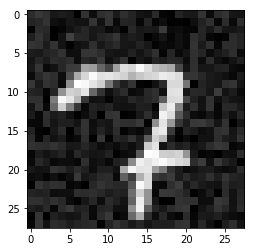

The network predicted a class label of 7


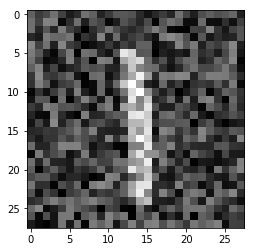

The network predicted a class label of 1


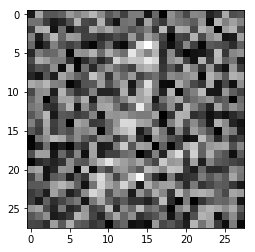

The network predicted a class label of 0


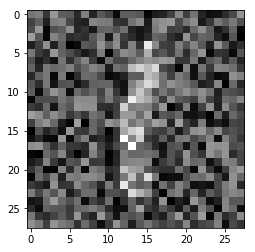

The network predicted a class label of 0


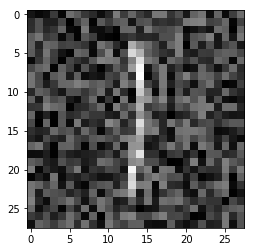

The network predicted a class label of 1


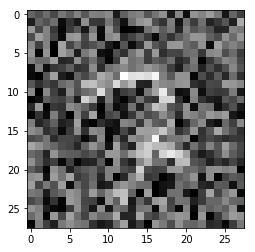

The network predicted a class label of 0


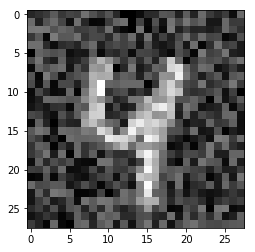

The network predicted a class label of 9


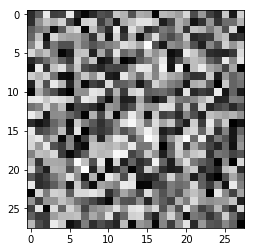

The network predicted a class label of 0


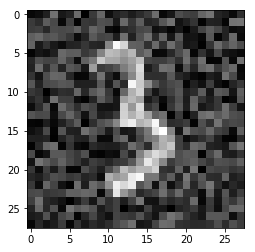

The network predicted a class label of 3


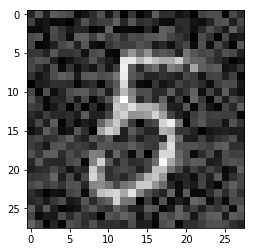

The network predicted a class label of 5


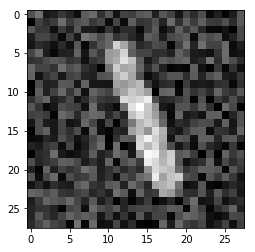

The network predicted a class label of 1


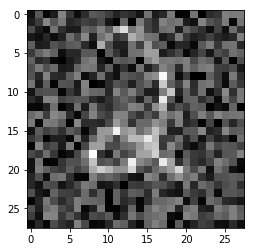

The network predicted a class label of 2


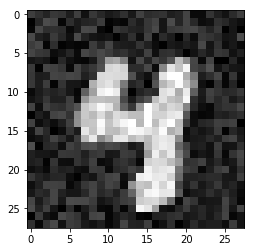

The network predicted a class label of 4


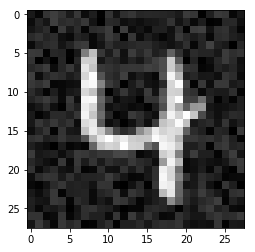

The network predicted a class label of 4


In [306]:
Transfer_Attack_KerasModel(model=Madry_model, transfer_attack_images="BindingNetwork_adversaries.csv")

The Madry network does reasonably well against the Binding-CNN adversaries, scoring 7/10. Note this may be more appropriately measured as 5/8, given that the '0' above is essentially uninformative to a human, and that the second-to-last example of a 5 is also arguably of poor ground-truth.

####Madry Model vs Its Own Adversaries

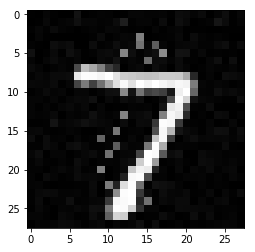

The network predicted a class label of 0


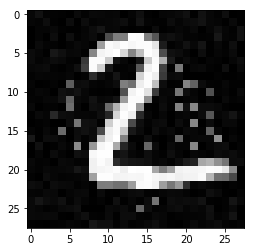

The network predicted a class label of 0


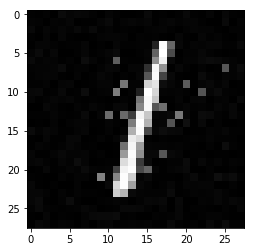

The network predicted a class label of 8


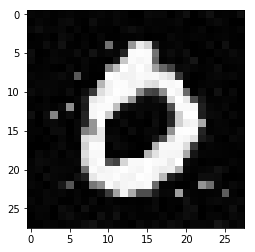

The network predicted a class label of 0


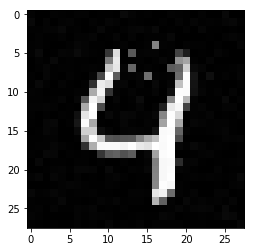

The network predicted a class label of 4


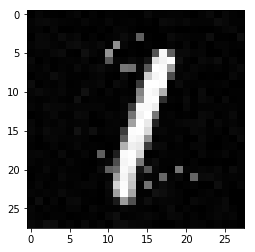

The network predicted a class label of 2


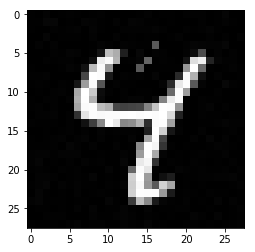

The network predicted a class label of 8


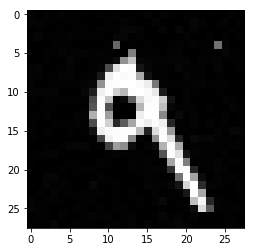

The network predicted a class label of 4


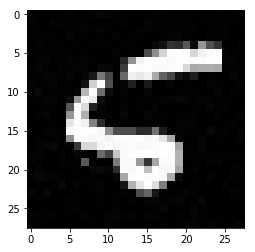

The network predicted a class label of 6


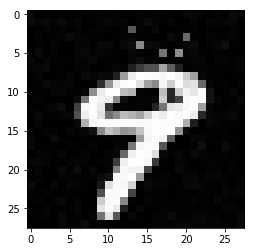

The network predicted a class label of 4


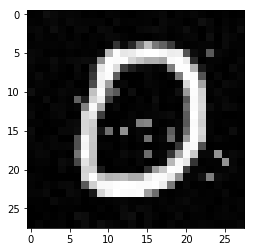

The network predicted a class label of 2


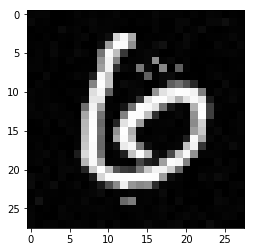

The network predicted a class label of 0


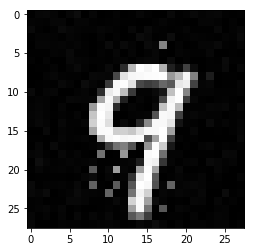

The network predicted a class label of 8


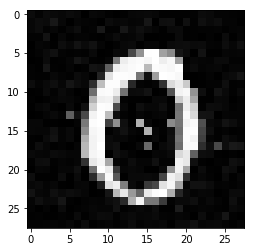

The network predicted a class label of 8


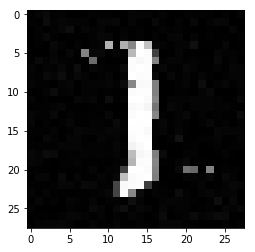

The network predicted a class label of 2


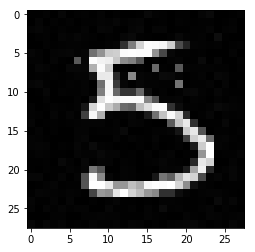

The network predicted a class label of 3


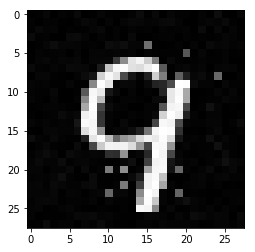

The network predicted a class label of 9


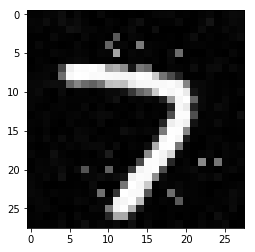

The network predicted a class label of 2


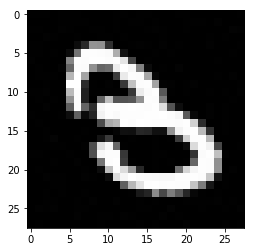

The network predicted a class label of 8


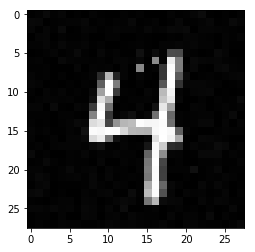

The network predicted a class label of 9


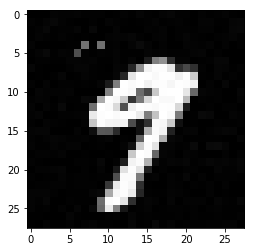

The network predicted a class label of 7


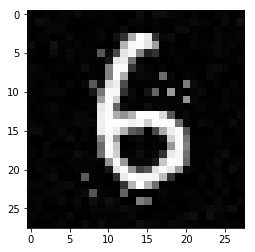

The network predicted a class label of 8


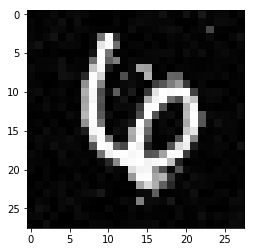

The network predicted a class label of 0


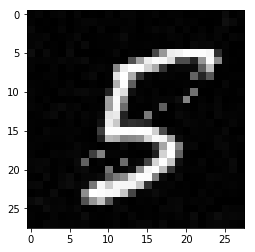

The network predicted a class label of 8


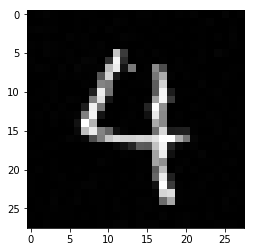

The network predicted a class label of 9


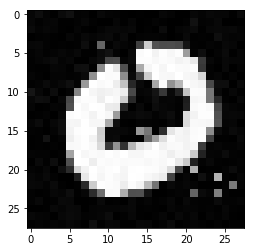

The network predicted a class label of 2


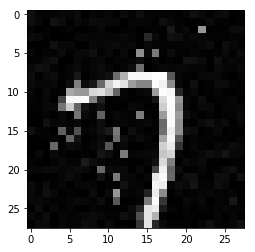

The network predicted a class label of 0


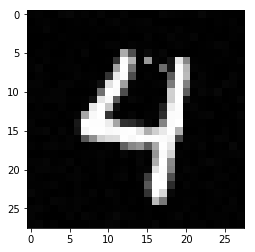

The network predicted a class label of 9


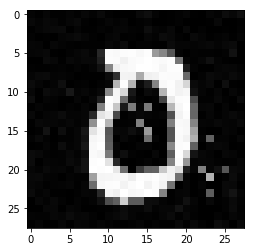

The network predicted a class label of 2


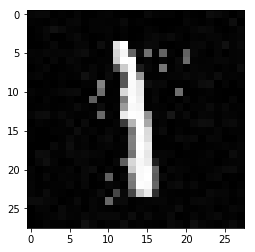

The network predicted a class label of 8


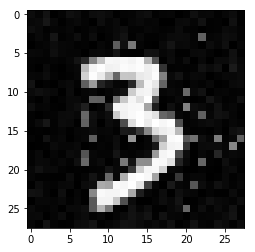

The network predicted a class label of 2


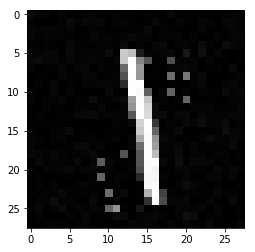

The network predicted a class label of 8


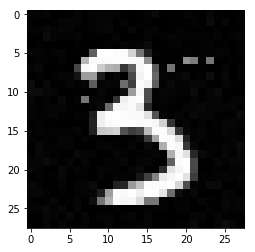

The network predicted a class label of 5


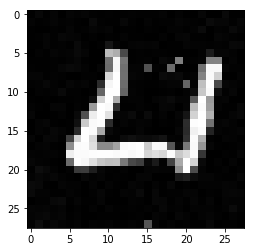

The network predicted a class label of 0


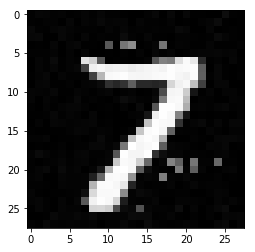

The network predicted a class label of 2


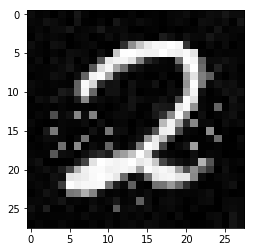

The network predicted a class label of 0


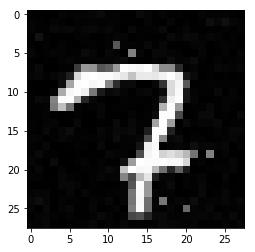

The network predicted a class label of 2


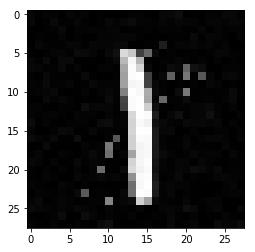

The network predicted a class label of 8


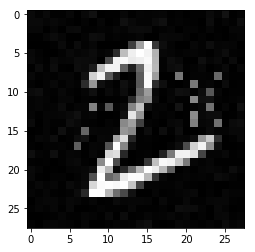

The network predicted a class label of 0


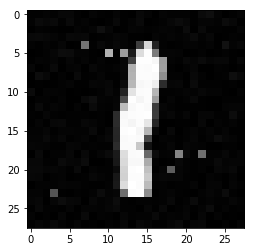

The network predicted a class label of 2


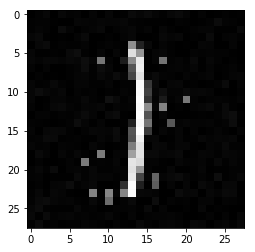

The network predicted a class label of 8


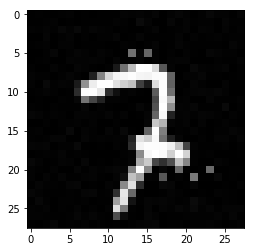

The network predicted a class label of 7


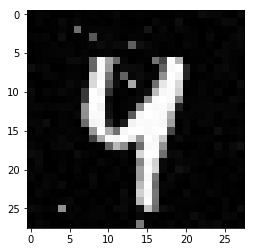

The network predicted a class label of 9


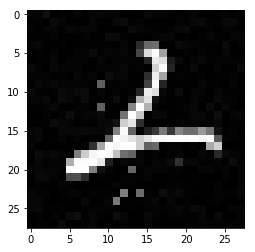

The network predicted a class label of 4


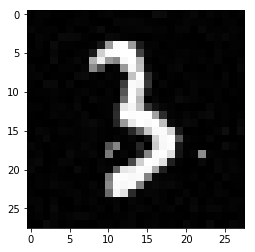

The network predicted a class label of 2


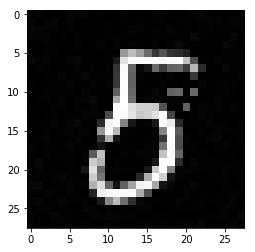

The network predicted a class label of 8


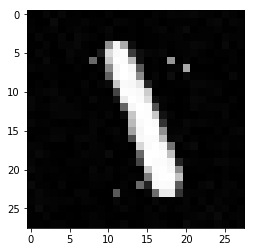

The network predicted a class label of 8


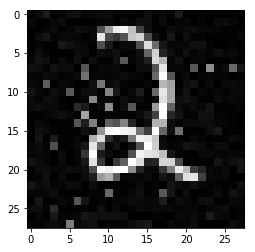

The network predicted a class label of 4


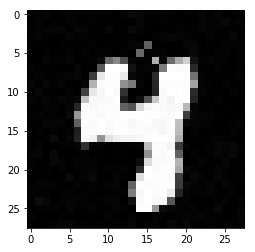

The network predicted a class label of 9


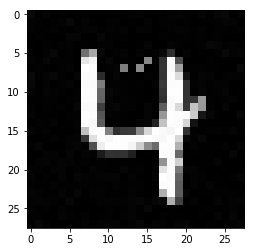

The network predicted a class label of 9


In [0]:
#Double check the adversaries work against the model they were developed for
Transfer_Attack_KerasModel(model=Madry_model, transfer_attack_images="Madry_adversaries.csv")

As expected, the Madry network scores 0/10 against its own adversaries.

###Transfer Attacks Against the TensorFlow Models

In [0]:
def Transfer_Attack_prediction_customTensorFlowModel(model_prediction_function, model_weights, var_list, test_image, temp_batch_size):
    
    predictions = model_prediction_function(x, temp_batch_size, keep_prob)
    
    saver = tf.train.Saver(var_list)
    
    with tf.Session() as sess:
        saver.restore(sess, model_weights)
        
        output_predictions = sess.run([predictions], feed_dict={x: test_image, keep_prob: 1.0})
                
        return output_predictions

In [0]:
def Transfer_Attack_customTensorFlowModel(model_prediction_function, model_weights, var_list, transfer_attack_images, temp_batch_size):
    
    #Load transfer_attack_images and reshape
    transfer_images = np.genfromtxt(transfer_attack_images, delimiter=',')
    
    
    transfer_images = np.reshape(transfer_images, [transfer_images.shape[0], 28, 28, 1])

    
    for ii in range(transfer_images.shape[0]):
        test_image = transfer_images[ii, :, :, :]
        
        output_predictions = Transfer_Attack_prediction_customTensorFlowModel(model_prediction_function, model_weights, var_list, 
                                                                              test_image[None, :, :, :], temp_batch_size)
        
        plt.imshow(test_image[:,:,0], cmap='gray')
        plt.show()
        print("The network predicted a class label of " + str(np.argmax(output_predictions)))

####Standard CNN vs Madry Adversaries

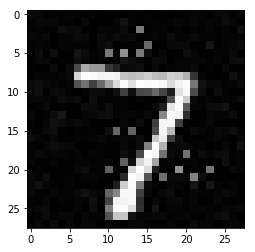

The network predicted a class label of 7


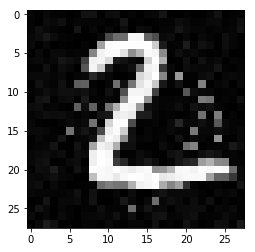

The network predicted a class label of 2


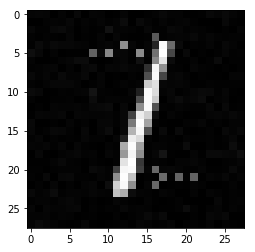

The network predicted a class label of 1


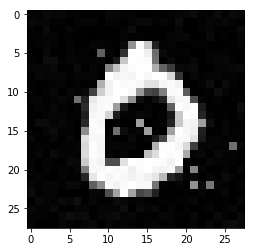

The network predicted a class label of 0


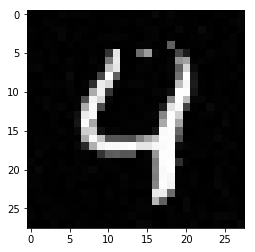

The network predicted a class label of 4


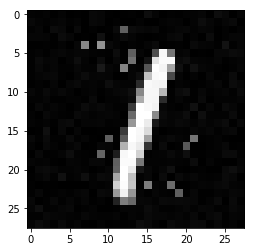

The network predicted a class label of 1


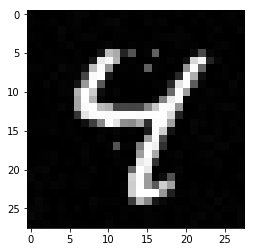

The network predicted a class label of 4


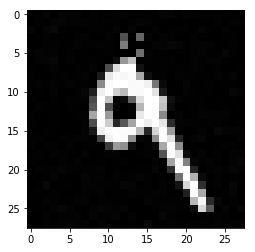

The network predicted a class label of 9


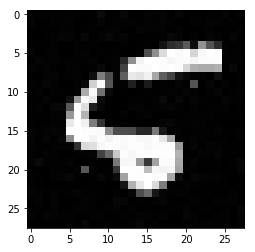

The network predicted a class label of 5


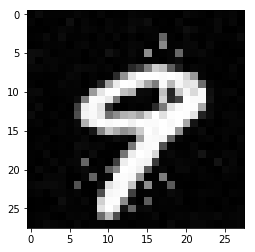

The network predicted a class label of 9


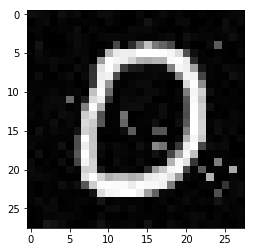

The network predicted a class label of 0


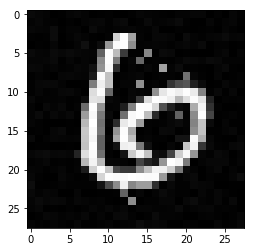

The network predicted a class label of 6


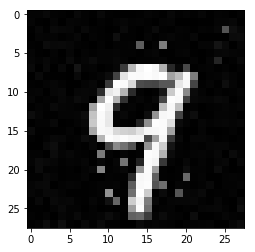

The network predicted a class label of 9


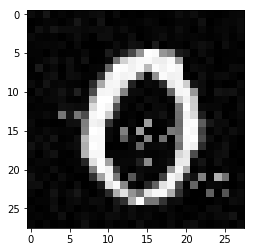

The network predicted a class label of 0


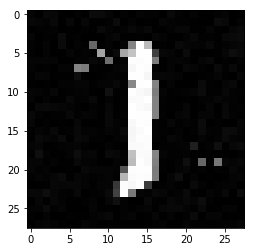

The network predicted a class label of 1


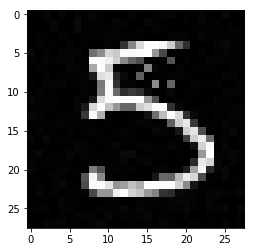

The network predicted a class label of 5


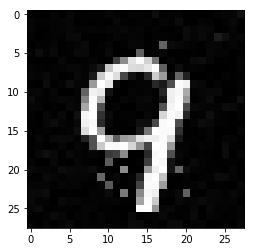

The network predicted a class label of 9


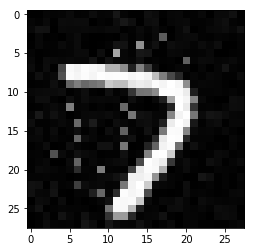

The network predicted a class label of 7


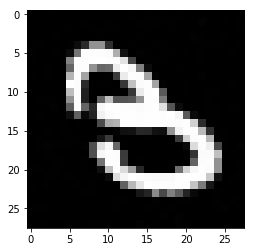

The network predicted a class label of 3


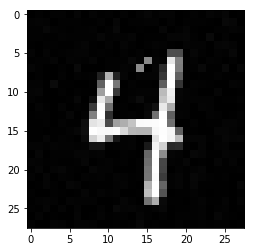

The network predicted a class label of 4


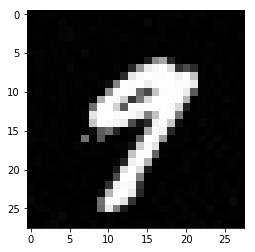

The network predicted a class label of 9


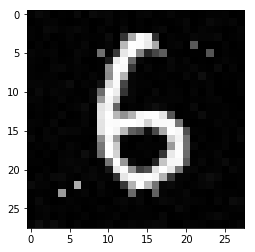

The network predicted a class label of 6


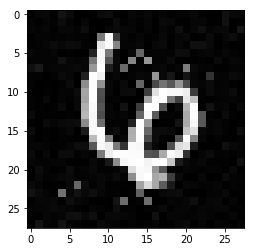

The network predicted a class label of 6


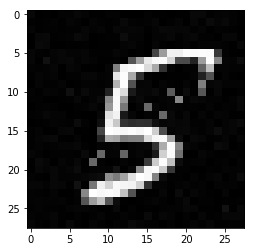

The network predicted a class label of 5


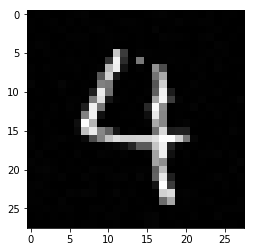

The network predicted a class label of 4


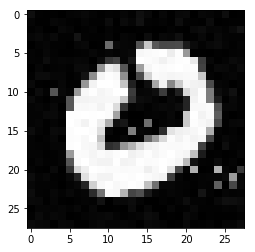

The network predicted a class label of 0


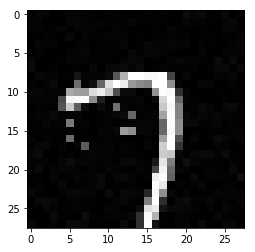

The network predicted a class label of 7


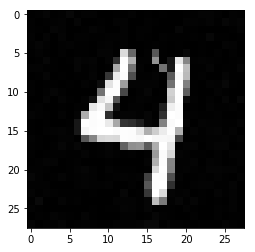

The network predicted a class label of 4


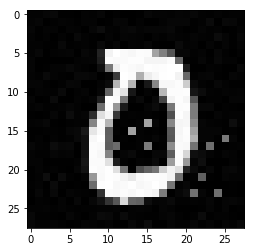

The network predicted a class label of 0


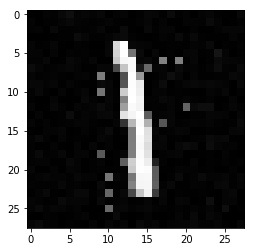

The network predicted a class label of 1


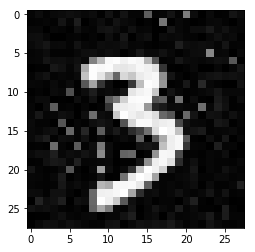

The network predicted a class label of 3


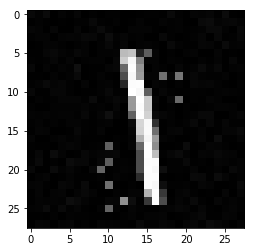

The network predicted a class label of 1


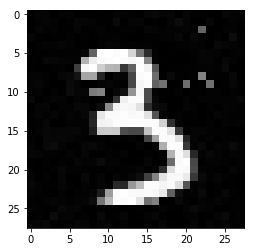

The network predicted a class label of 3


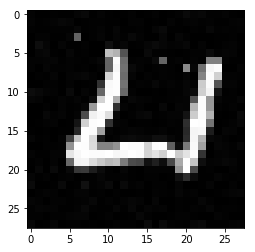

The network predicted a class label of 4


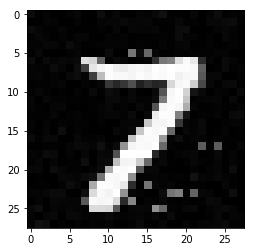

The network predicted a class label of 7


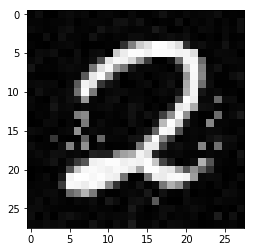

The network predicted a class label of 2


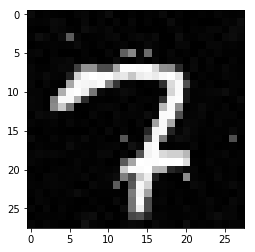

The network predicted a class label of 7


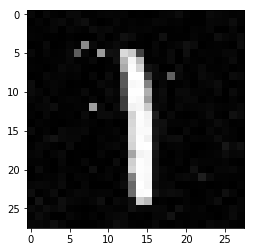

The network predicted a class label of 1


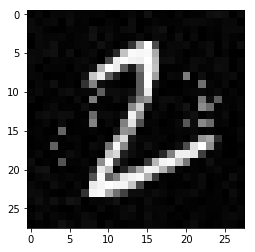

The network predicted a class label of 2


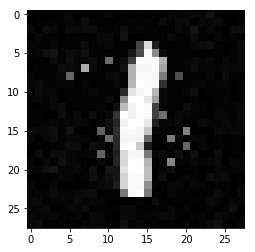

The network predicted a class label of 1


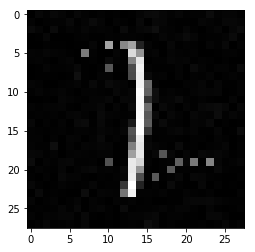

The network predicted a class label of 1


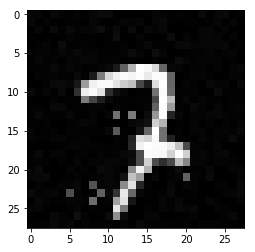

The network predicted a class label of 7


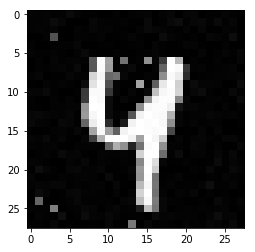

The network predicted a class label of 4


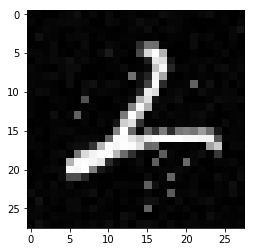

The network predicted a class label of 2


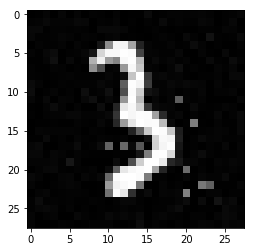

The network predicted a class label of 3


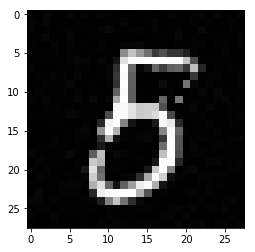

The network predicted a class label of 5


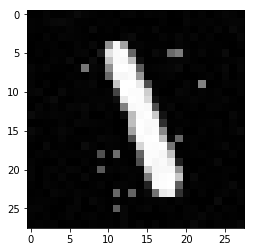

The network predicted a class label of 1


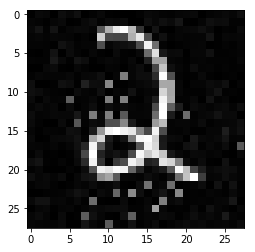

The network predicted a class label of 2


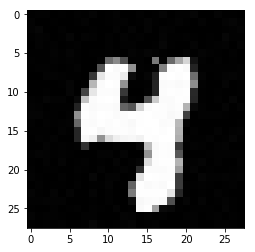

The network predicted a class label of 4


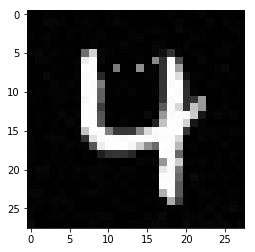

The network predicted a class label of 4


In [311]:
Transfer_Attack_customTensorFlowModel(model_prediction_function=cnn_predictions,
                                      model_weights="/MNIST_LeNet5_CNN.ckpt", 
                                      var_list=var_list_LeNet,
                                      transfer_attack_images="Madry_adversaries.csv",
                                      temp_batch_size=None)

The standard CNN scores 5/10 against the Madry examples; this is worse than the binding CNN, but not significantly so, suggesting that the binding-CNN may have most of its advantage simply from e.g. more parameters.

####Standard CNN vs Binding Network Adversaries

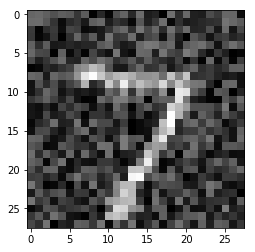

The network predicted a class label of 7


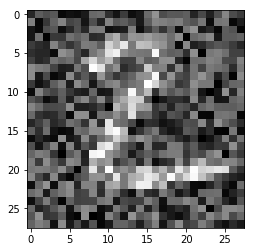

The network predicted a class label of 2


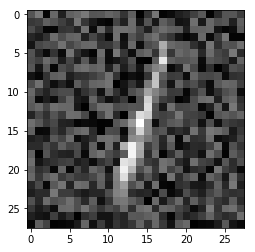

The network predicted a class label of 1


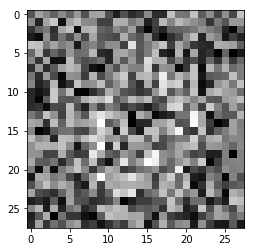

The network predicted a class label of 8


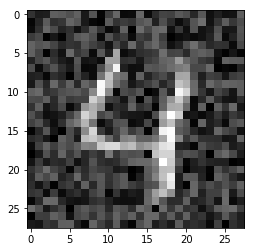

The network predicted a class label of 4


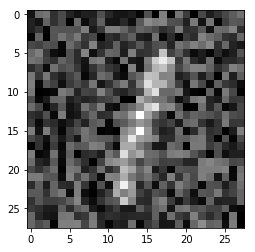

The network predicted a class label of 1


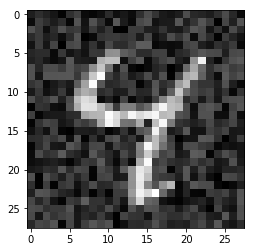

The network predicted a class label of 4


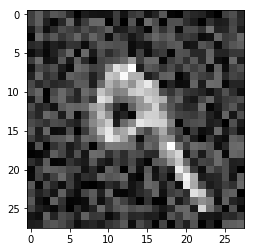

The network predicted a class label of 9


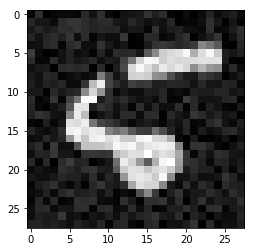

The network predicted a class label of 5


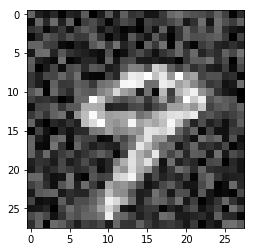

The network predicted a class label of 9


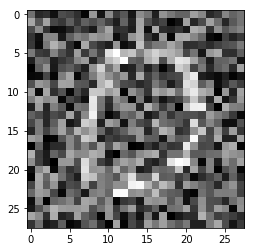

The network predicted a class label of 0


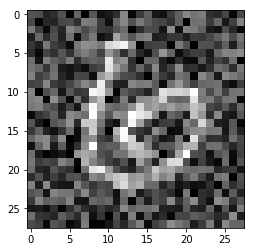

The network predicted a class label of 6


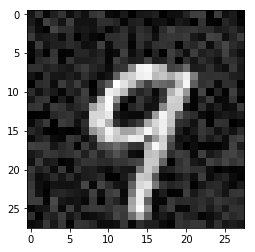

The network predicted a class label of 9


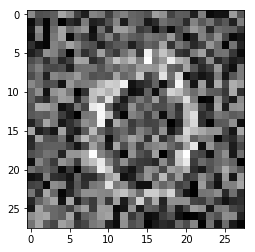

The network predicted a class label of 8


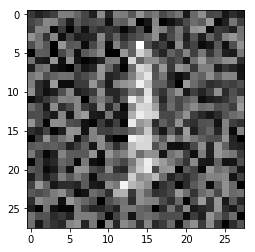

The network predicted a class label of 8


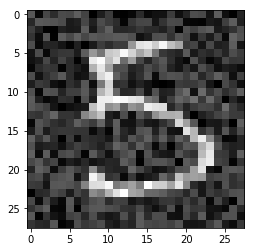

The network predicted a class label of 5


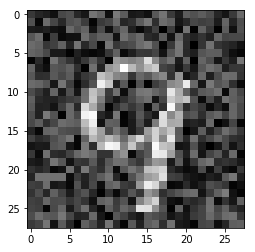

The network predicted a class label of 9


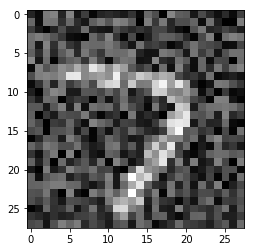

The network predicted a class label of 7


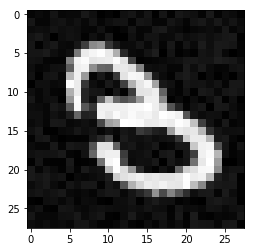

The network predicted a class label of 3


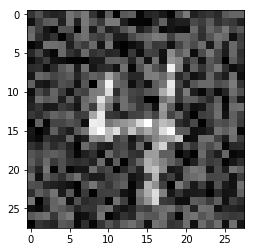

The network predicted a class label of 4


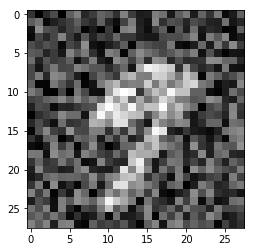

The network predicted a class label of 4


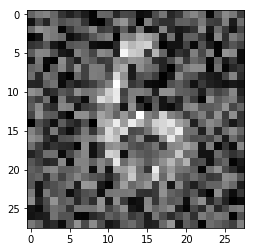

The network predicted a class label of 4


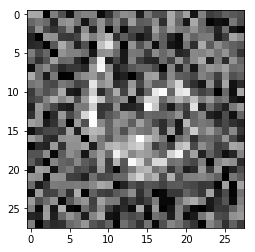

The network predicted a class label of 4


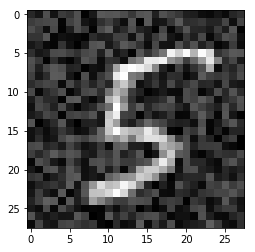

The network predicted a class label of 5


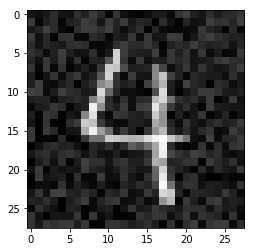

The network predicted a class label of 4


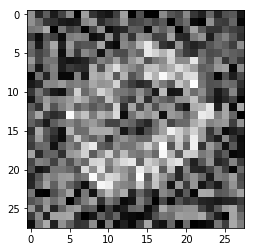

The network predicted a class label of 0


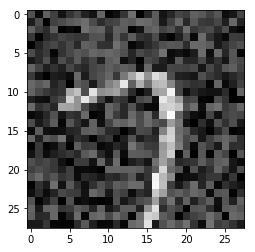

The network predicted a class label of 7


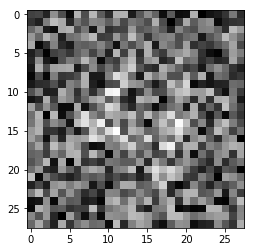

The network predicted a class label of 4


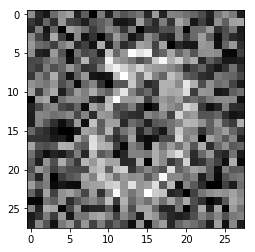

The network predicted a class label of 0


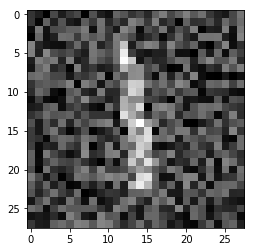

The network predicted a class label of 1


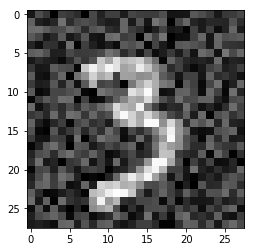

The network predicted a class label of 3


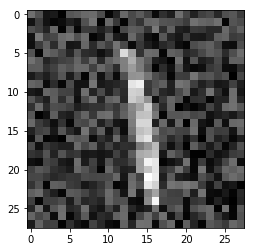

The network predicted a class label of 1


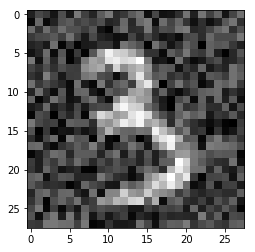

The network predicted a class label of 3


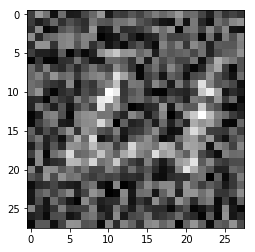

The network predicted a class label of 4


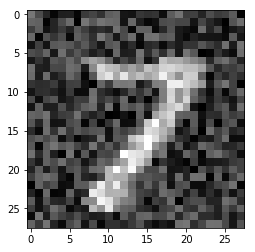

The network predicted a class label of 7


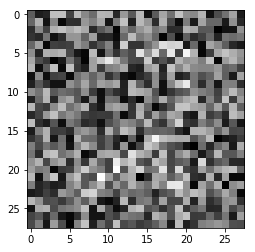

The network predicted a class label of 8


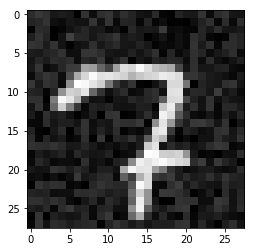

The network predicted a class label of 7


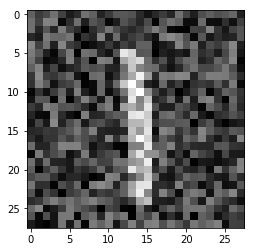

The network predicted a class label of 1


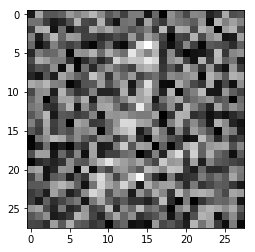

The network predicted a class label of 8


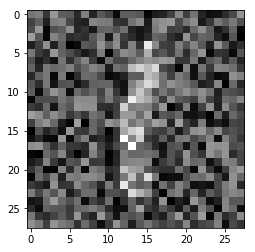

The network predicted a class label of 8


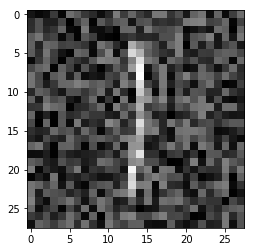

The network predicted a class label of 1


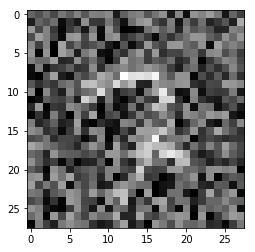

The network predicted a class label of 2


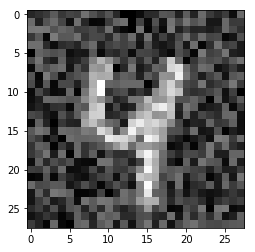

The network predicted a class label of 4


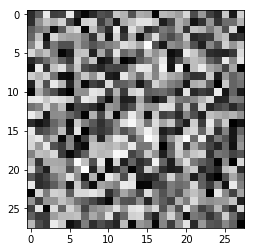

The network predicted a class label of 8


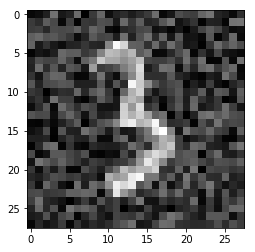

The network predicted a class label of 3


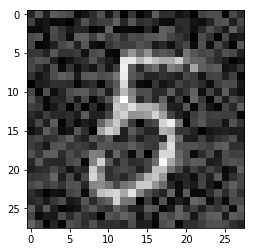

The network predicted a class label of 5


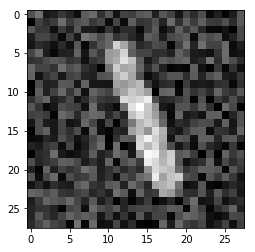

The network predicted a class label of 1


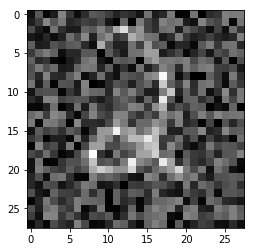

The network predicted a class label of 4


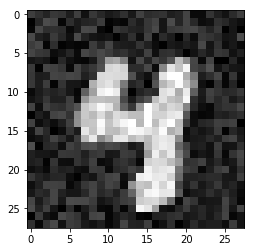

The network predicted a class label of 4


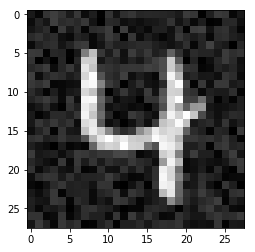

The network predicted a class label of 4


In [312]:
Transfer_Attack_customTensorFlowModel(model_prediction_function=cnn_predictions,
                                      model_weights="/MNIST_LeNet5_CNN.ckpt", 
                                      var_list=var_list_LeNet,
                                      transfer_attack_images="BindingNetwork_adversaries.csv",
                                      temp_batch_size=None)

The standard CNN performs poorly (2/10) against the binding networks adversaries.

####Standard CNN vs Its Own Adversaries

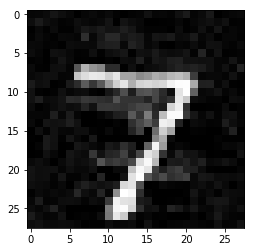

The network predicted a class label of 8


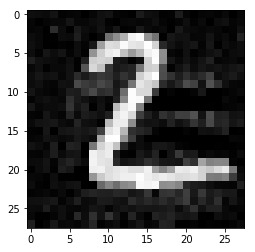

The network predicted a class label of 8


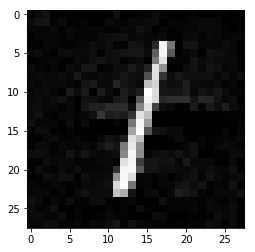

The network predicted a class label of 8


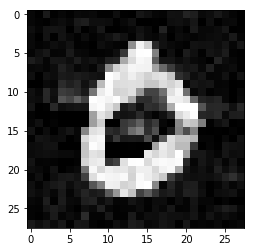

The network predicted a class label of 8


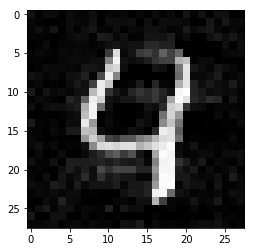

The network predicted a class label of 8


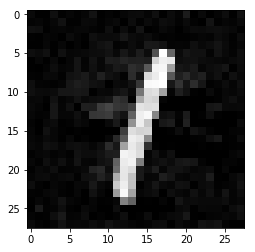

The network predicted a class label of 8


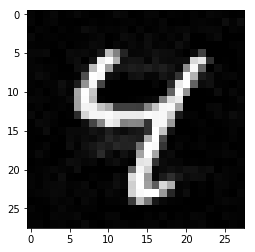

The network predicted a class label of 8


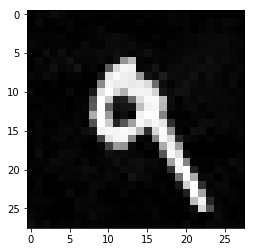

The network predicted a class label of 4


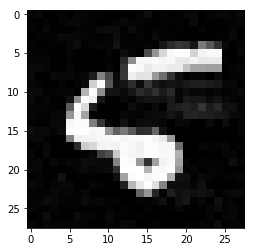

The network predicted a class label of 8


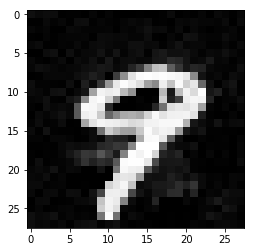

The network predicted a class label of 8


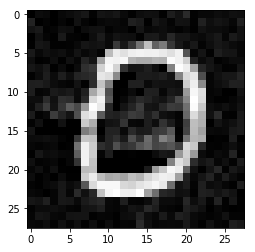

The network predicted a class label of 8


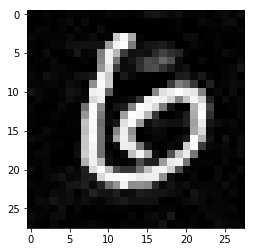

The network predicted a class label of 0


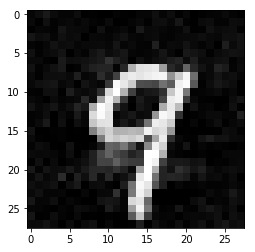

The network predicted a class label of 8


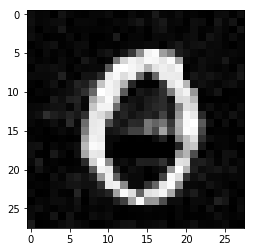

The network predicted a class label of 8


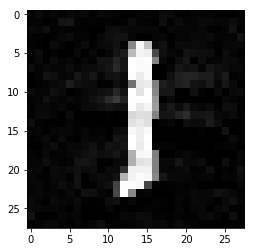

The network predicted a class label of 8


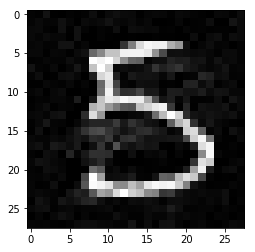

The network predicted a class label of 8


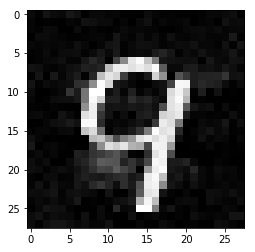

The network predicted a class label of 8


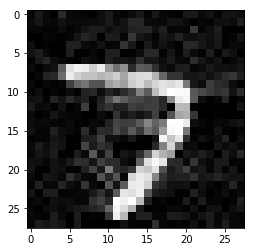

The network predicted a class label of 8


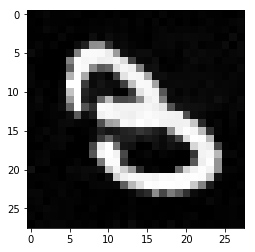

The network predicted a class label of 8


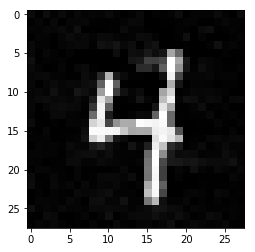

The network predicted a class label of 9


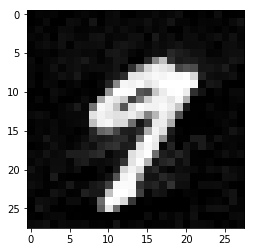

The network predicted a class label of 8


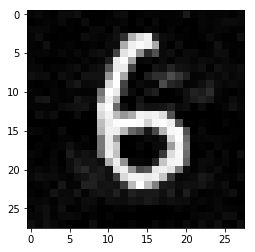

The network predicted a class label of 8


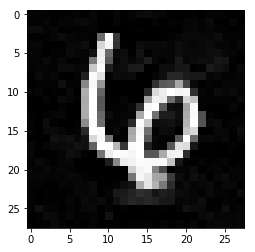

The network predicted a class label of 4


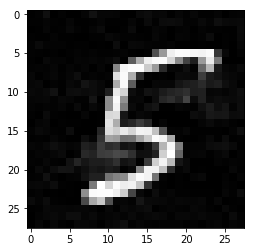

The network predicted a class label of 8


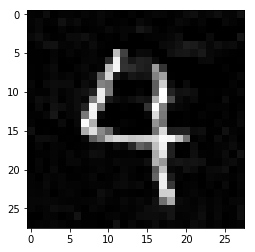

The network predicted a class label of 9


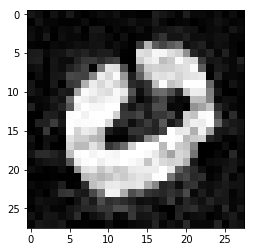

The network predicted a class label of 8


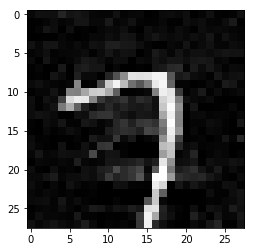

The network predicted a class label of 8


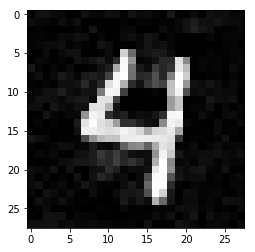

The network predicted a class label of 9


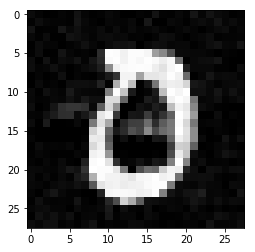

The network predicted a class label of 8


KeyboardInterrupt: ignored

In [0]:
#Double check the adversaries work against the model they were developed for
Transfer_Attack_customTensorFlowModel(model_prediction_function=cnn_predictions,
                                      model_weights="/MNIST_LeNet5_CNN.ckpt", 
                                      var_list=var_list_LeNet,
                                      transfer_attack_images="StandardCNN_adversaries.csv",
                                      temp_batch_size=None)

As expected, the standard CNN scores 0/10 against its own adversaries.

####Binding Model vs Standard CNN Adversaries

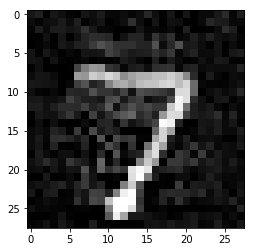

The network predicted a class label of 7


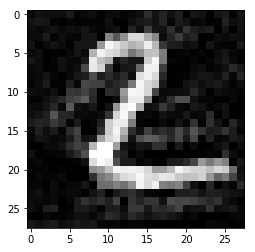

The network predicted a class label of 2


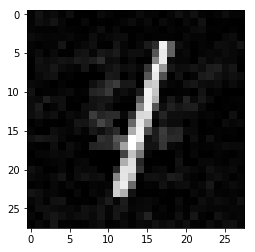

The network predicted a class label of 1


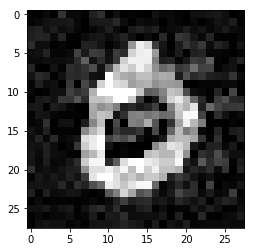

The network predicted a class label of 0


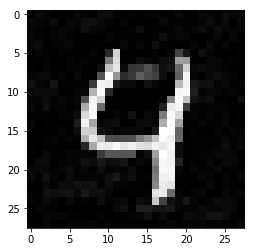

The network predicted a class label of 4


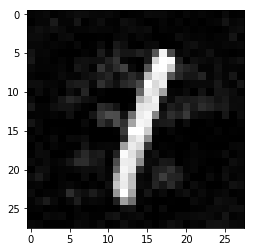

The network predicted a class label of 1


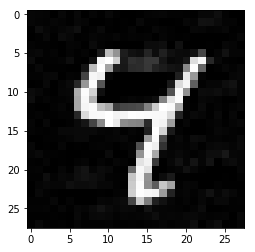

The network predicted a class label of 4


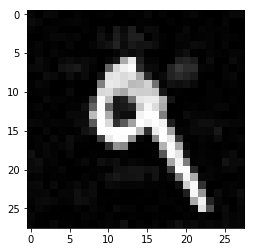

The network predicted a class label of 9


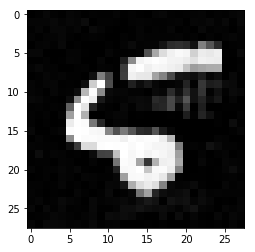

The network predicted a class label of 5


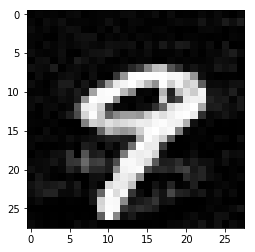

The network predicted a class label of 9


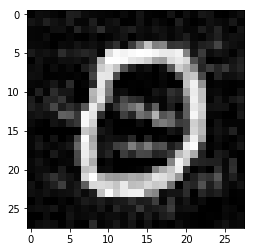

The network predicted a class label of 0


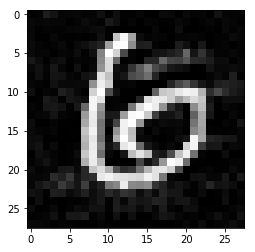

The network predicted a class label of 6


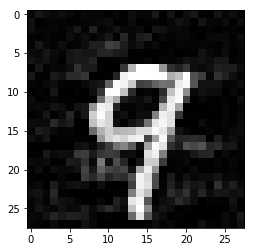

The network predicted a class label of 9


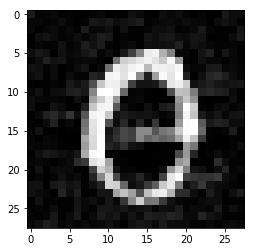

The network predicted a class label of 0


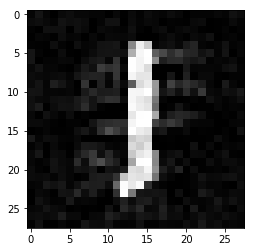

The network predicted a class label of 1


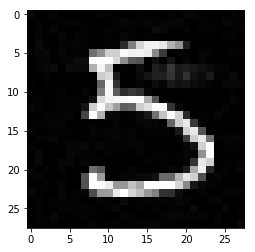

The network predicted a class label of 5


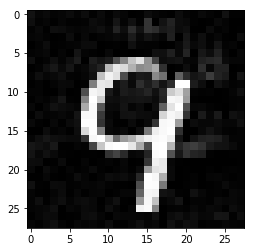

The network predicted a class label of 9


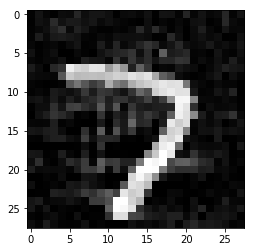

The network predicted a class label of 7


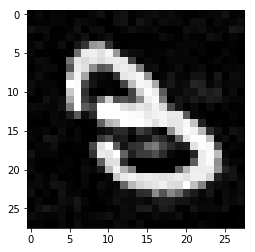

The network predicted a class label of 5


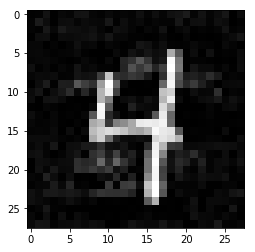

The network predicted a class label of 4


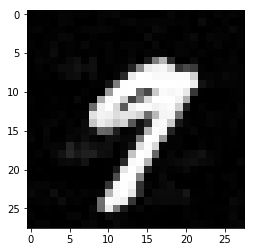

The network predicted a class label of 9


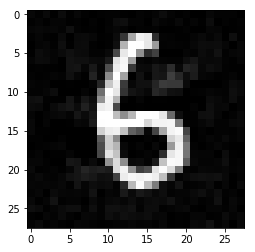

The network predicted a class label of 6


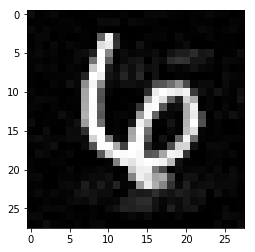

The network predicted a class label of 6


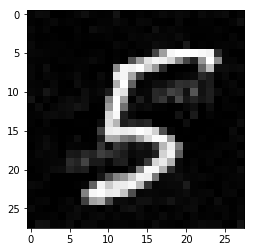

The network predicted a class label of 5


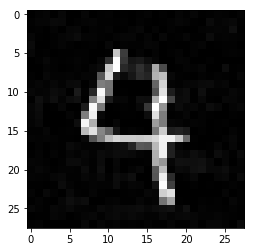

The network predicted a class label of 4


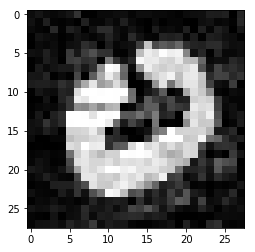

The network predicted a class label of 0


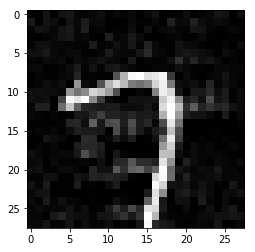

The network predicted a class label of 7


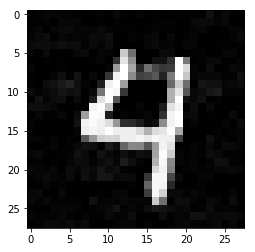

The network predicted a class label of 4


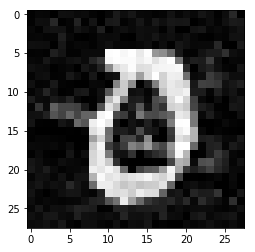

The network predicted a class label of 0


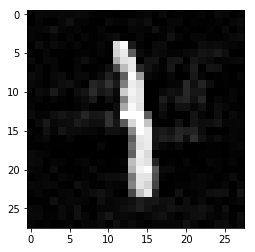

The network predicted a class label of 1


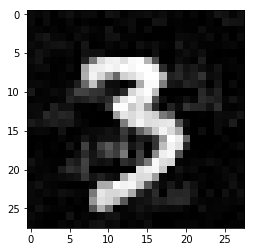

The network predicted a class label of 3


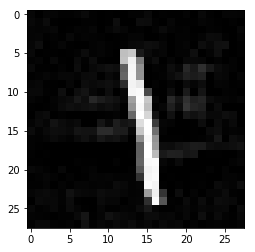

The network predicted a class label of 1


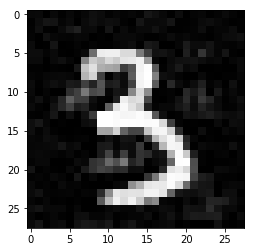

The network predicted a class label of 3


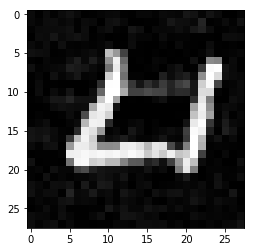

The network predicted a class label of 4


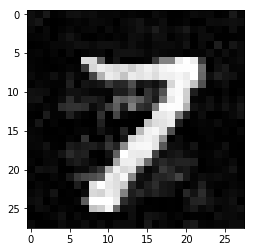

The network predicted a class label of 7


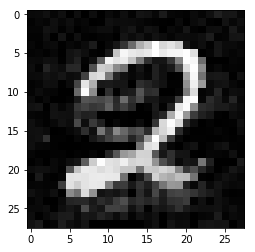

The network predicted a class label of 2


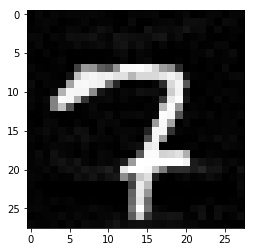

The network predicted a class label of 2


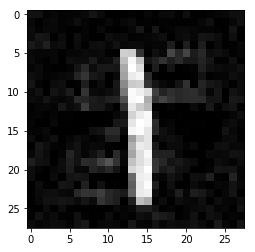

The network predicted a class label of 1


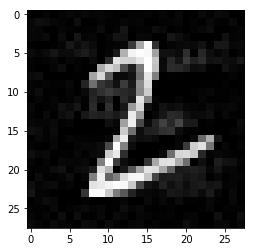

The network predicted a class label of 2


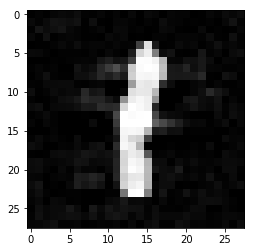

The network predicted a class label of 1


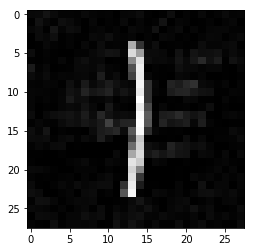

The network predicted a class label of 1


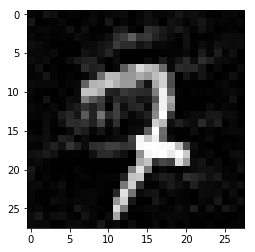

The network predicted a class label of 7


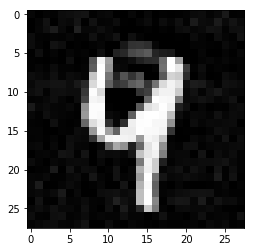

The network predicted a class label of 4


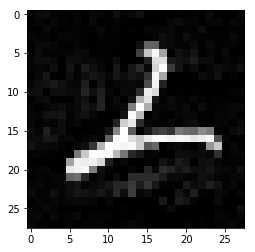

The network predicted a class label of 2


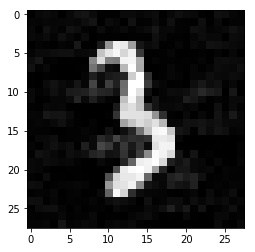

The network predicted a class label of 8


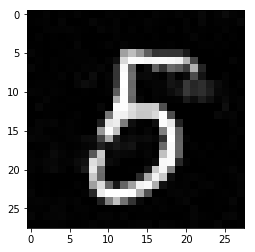

The network predicted a class label of 5


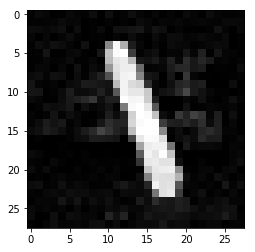

The network predicted a class label of 1


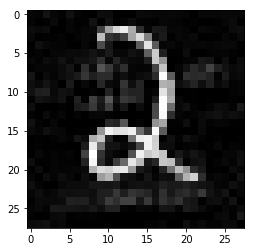

The network predicted a class label of 2


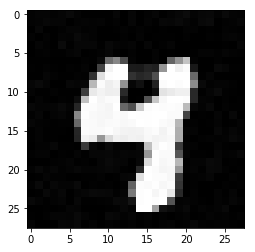

The network predicted a class label of 4


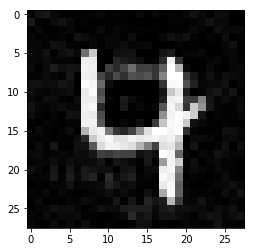

The network predicted a class label of 9


In [309]:
Transfer_Attack_customTensorFlowModel(model_prediction_function=cnn_binding_predictions,
                                      model_weights="/Binding_CNN.ckpt", 
                                      var_list=var_list_Binding,
                                      transfer_attack_images="StandardCNN_adversaries.csv",
                                      temp_batch_size=1)

The binding network performs well against the standard CNN adversaries, scoring 9/10, although note the one class it scored incorrectly (the second to last example) has a debatable ground truth.

####Binding Network vs Mardy Adversaries

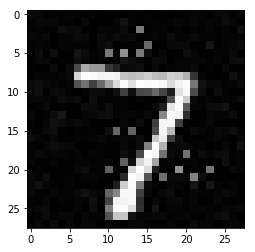

The network predicted a class label of 7


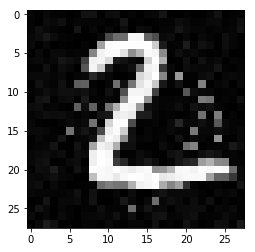

The network predicted a class label of 2


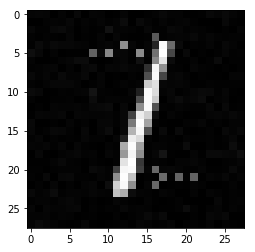

The network predicted a class label of 1


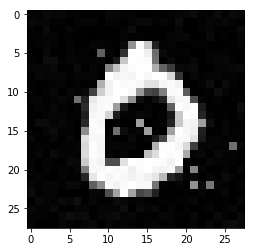

The network predicted a class label of 0


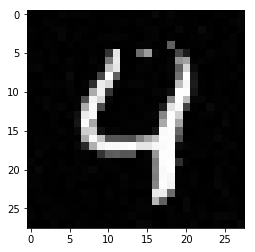

The network predicted a class label of 4


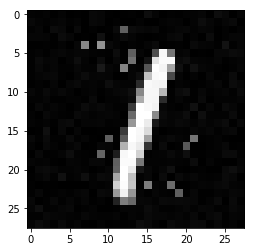

The network predicted a class label of 1


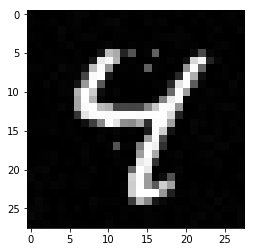

The network predicted a class label of 4


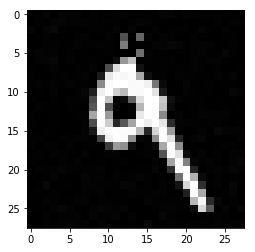

The network predicted a class label of 9


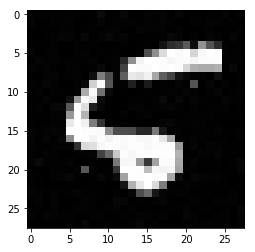

The network predicted a class label of 5


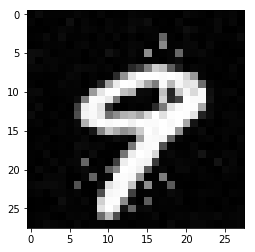

The network predicted a class label of 9


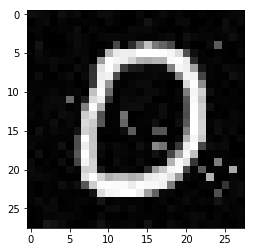

The network predicted a class label of 0


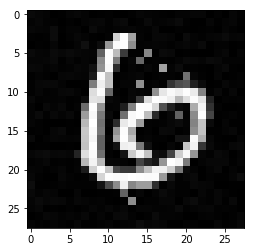

The network predicted a class label of 6


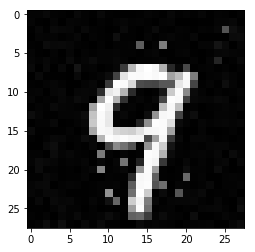

The network predicted a class label of 9


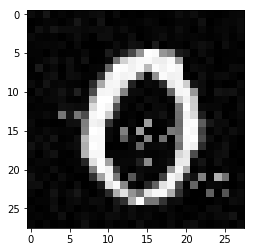

The network predicted a class label of 0


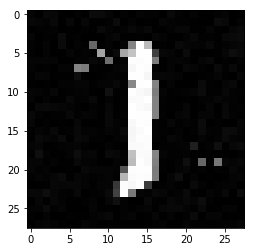

The network predicted a class label of 1


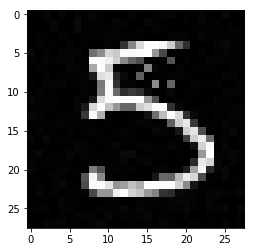

The network predicted a class label of 5


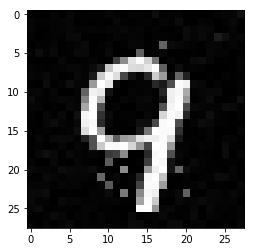

The network predicted a class label of 9


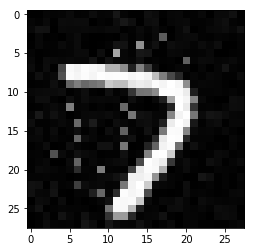

The network predicted a class label of 7


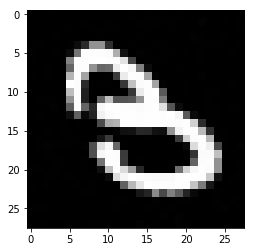

The network predicted a class label of 3


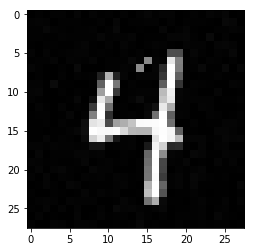

The network predicted a class label of 4


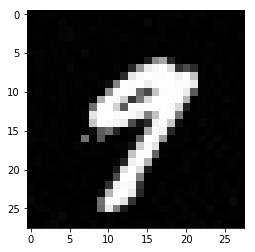

The network predicted a class label of 9


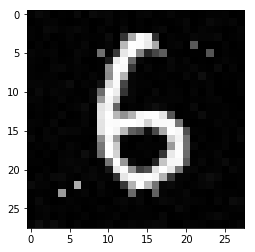

The network predicted a class label of 6


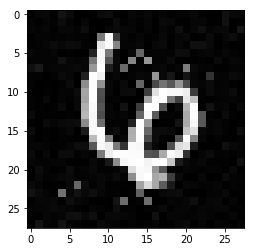

The network predicted a class label of 6


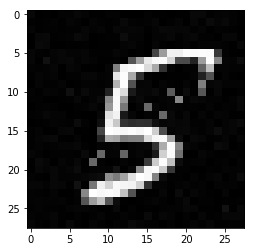

The network predicted a class label of 5


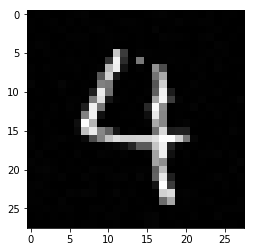

The network predicted a class label of 4


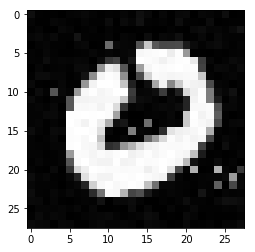

The network predicted a class label of 0


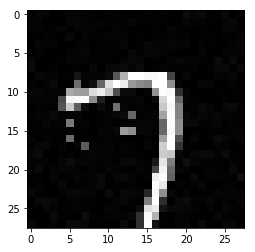

The network predicted a class label of 7


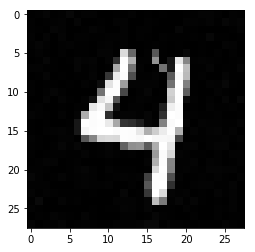

The network predicted a class label of 4


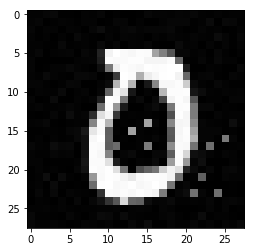

The network predicted a class label of 0


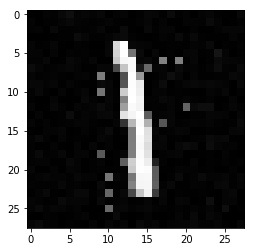

The network predicted a class label of 1


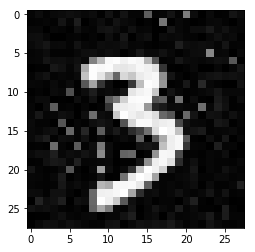

The network predicted a class label of 3


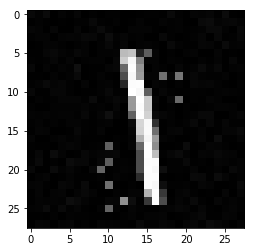

The network predicted a class label of 1


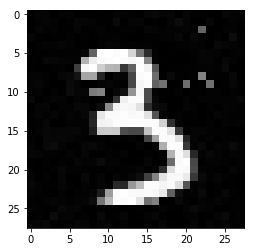

The network predicted a class label of 3


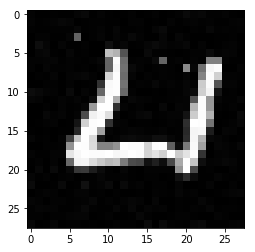

The network predicted a class label of 4


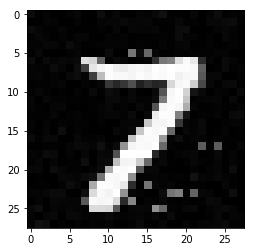

The network predicted a class label of 7


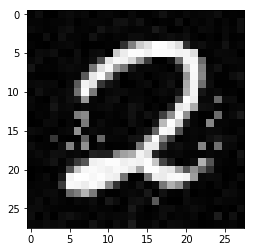

The network predicted a class label of 2


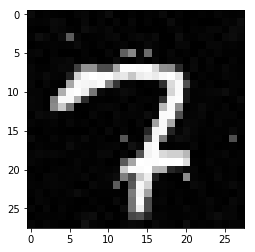

The network predicted a class label of 7


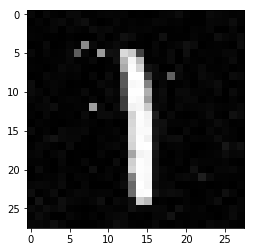

The network predicted a class label of 1


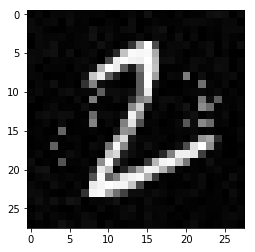

The network predicted a class label of 2


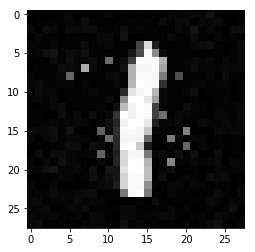

The network predicted a class label of 1


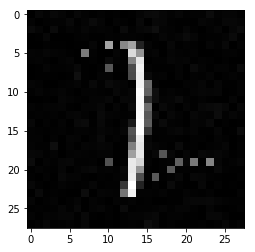

The network predicted a class label of 1


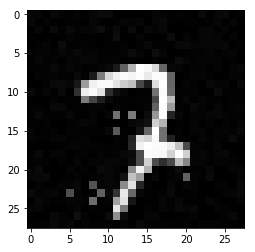

The network predicted a class label of 7


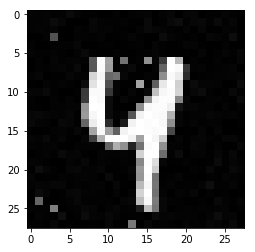

The network predicted a class label of 4


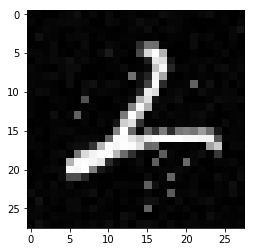

The network predicted a class label of 2


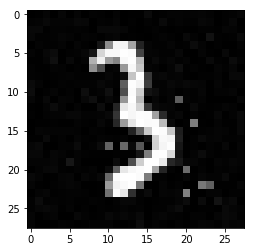

The network predicted a class label of 3


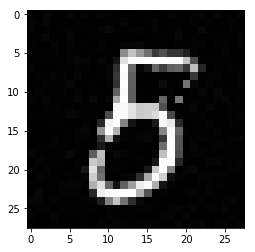

The network predicted a class label of 5


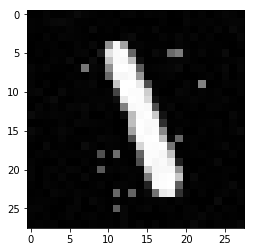

The network predicted a class label of 1


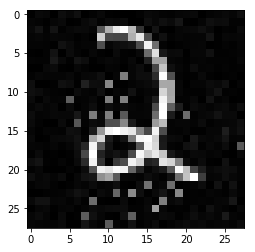

The network predicted a class label of 2


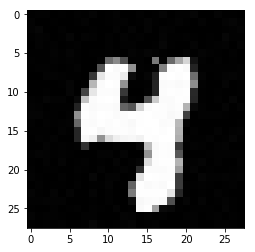

The network predicted a class label of 4


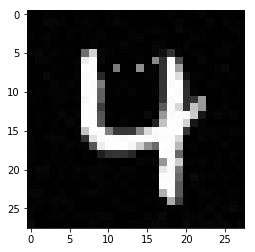

The network predicted a class label of 4


In [310]:
Transfer_Attack_customTensorFlowModel(model_prediction_function=cnn_binding_predictions,
                                      model_weights="/Binding_CNN.ckpt", 
                                      var_list=var_list_Binding,
                                      transfer_attack_images="Madry_adversaries.csv",
                                      temp_batch_size=1)

The binding network performed reasonably against the Madry adversaries, scoring 7/10. Note in particular that the binding network has had *no* training on adversarial examples, and yet its performance is comparable to that of the highly optimized (and I believe larger-parameter) Madry model.

####Binding Network vs Its Own Adversaries

In [0]:
Transfer_Attack_customTensorFlowModel(model_prediction_function=cnn_binding_predictions,
                                      model_weights="/Binding_CNN.ckpt", 
                                      var_list=var_list_Binding,
                                      transfer_attack_images="BindingNetwork_adversaries.csv",
                                      temp_batch_size=1)

As expected, the binding network scores 0/10 against its own adversaries.

##Point-Wise Attack

###Point-Wise Attack Functions for the TensorFlow Models

In [0]:
# *** this code can eventually be refractored with earlier functions

#Function used to attack an arbitrary model that has been implemented with TensorFlow's low-level API (i.e. requires a session to be called explicitly)
def PointWise_Attack_customTensorFlowModel(model_prediction_function, model_weights, var_list, test_image, test_label, temp_batch_size):

    images = x #x is a place-holder for 28x28 images earlier defined
    logits = model_prediction_function(images, temp_batch_size)

    saver = tf.train.Saver(var_list) #Define saver object for use later when loading the model weights

    #Note how when attacking a low-level TensorFlow API model, it is necessary for all steps to occur within the tf.Session()
    with tf.Session() as session:
        saver.restore(session, model_weights)

        #Define the foolbox model
        fmodel = foolbox.models.TensorFlowModel(images, logits, (0,1)) #The final parameter specifies the input values range

        #The predicted label of the network prior to carrying out the attack
        pre_label = np.argmax(fmodel.predictions(test_image[:, :, :]))
        #print("The classification label prior to attack is " + str(pre_label))
        if (pre_label != test_label):
            print("The model predicted a " + str(pre_label) + " when the ground-truth label is " + str(test_label))
            plt.imshow(test_image[:,:,0], cmap='gray')

        #Carry out the untargeted Bounary Attack
        attack_fmodel = foolbox.attacks.PointwiseAttack(model=fmodel, criterion=foolbox.criteria.Misclassification())
        adversarial_image_fmodel = attack_fmodel(test_image, test_label)
        plt.imshow(adversarial_image_fmodel[:,:,0], cmap='gray')
        plt.show()
        
        #Check the output of the adversarial attack
        adversarial_label_fmodel = np.argmax(fmodel.predictions(adversarial_image_fmodel[:, :, :]))
        print("The classification label following attack is " + str(adversarial_label_fmodel) 
              + " from an original classification of " + str(test_label))
        
        return adversarial_image_fmodel, adversarial_label_fmodel

In [0]:
#Iterate through a series of images to be attacked
def evaluate_l0_PointWiseAttack_resistance_CustomModel(model_prediction_function, model_weights, var_list, num_images_to_attack, temp_batch_size):
    adversary_found = np.zeros([num_images_to_attack]) #array of booleans that indicates if an adversary was found for a particular image
    adversary_distance = np.zeros([num_images_to_attack])
    adversary_arrays = np.zeros([num_images_to_attack, testing_data.shape[1], testing_data.shape[2], 1])

    for ii in range(num_images_to_attack):
        test_image = testing_data[ii, :, :]
        test_label = np.argmax(testing_labels[ii,:])

        adversarial_image_fmodel, adversarial_classification = PointWise_Attack_customTensorFlowModel(model_prediction_function, 
                                                                                                     model_weights, var_list, 
                                                                                                     test_image, test_label, 
                                                                                                     temp_batch_size)
        adversary_arrays[ii, :, :] = adversarial_image_fmodel

        if ((np.any(adversarial_image_fmodel == None) | adversarial_classification == test_label)):
            print("No adversarial image found")

        else:
            l0_distance = scipy.spatial.distance.hamming(test_image.flatten(), adversarial_image_fmodel.flatten())
            print("The L0 distance of the adversary is " + str(l0_distance))
            adversary_found[ii] = 1
            adversary_distance[ii] = l0_distance
        
    return adversary_found, adversary_distance, adversary_arrays

###Visualize the Point-Wise Attack

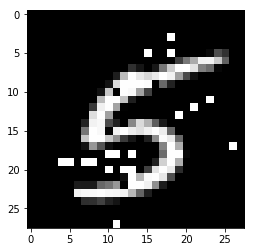

The classification label following attack is 6 from an original classification of 5


In [0]:
#An example of the attack
adversarial_image_fmodel, adversarial_label_fmodel = PointWise_Attack_customTensorFlowModel(model_prediction_function=cnn_predictions,
                                                                 model_weights="/MNIST_LeNet5_CNN.ckpt", 
                                                                var_list=var_list_LeNet,
                                                                 test_image=test_image_LeNet, 
                                                                 test_label=test_label_LeNet,
                                                                 temp_batch_size=None)


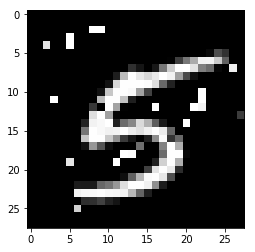

The classification label following attack is 8 from an original classification of 5


In [0]:
adversarial_image_fmodel, adversarial_label_fmodel = PointWise_Attack_customTensorFlowModel(model_prediction_function=cnn_binding_predictions,
                                                                 model_weights="/Binding_CNN.ckpt",
                                                                  var_list=var_list_Binding,
                                                                 test_image=test_image_LeNet, 
                                                                 test_label=test_label_LeNet,
                                                                 temp_batch_size=1)


###Quantify Vulnerability

In [0]:
num_images_to_attack=10

####Standard CNN

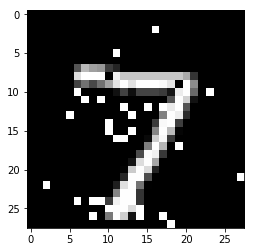

The classification label following attack is 9 from an original classification of 7
The L0 distance of the adversary is 0.03826530612244898


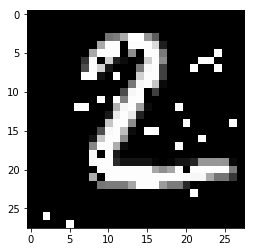

The classification label following attack is 6 from an original classification of 2
The L0 distance of the adversary is 0.04081632653061224


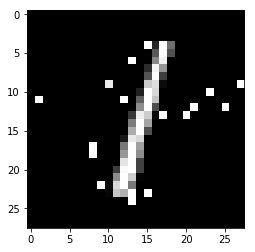

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.021683673469387755


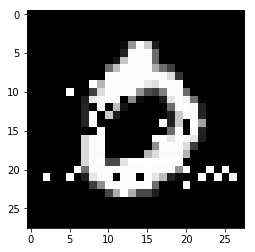

The classification label following attack is 2 from an original classification of 0
The L0 distance of the adversary is 0.03316326530612245


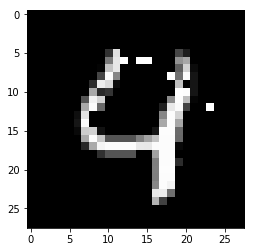

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.012755102040816327


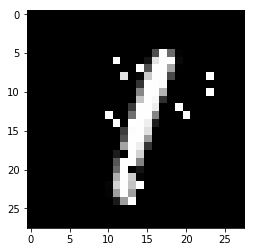

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.017857142857142856


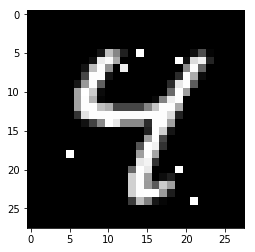

The classification label following attack is 8 from an original classification of 4
The L0 distance of the adversary is 0.007653061224489796


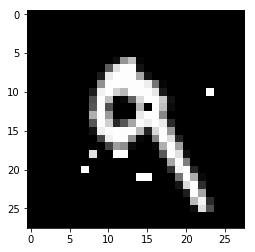

The classification label following attack is 8 from an original classification of 9
The L0 distance of the adversary is 0.01020408163265306


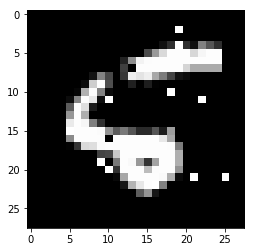

The classification label following attack is 6 from an original classification of 5
The L0 distance of the adversary is 0.016581632653061226


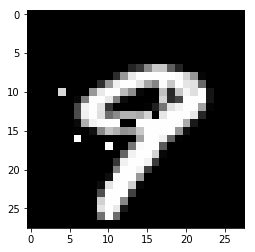

The classification label following attack is 7 from an original classification of 9
The L0 distance of the adversary is 0.007653061224489796


In [0]:
adversary_found, adversary_distance, adversary_arrays = evaluate_l0_PointWiseAttack_resistance_CustomModel(
    model_prediction_function=cnn_predictions, model_weights="/MNIST_LeNet5_CNN.ckpt", var_list=var_list_LeNet,
    num_images_to_attack=num_images_to_attack, temp_batch_size=None)

In [0]:
success_ratio = np.sum(adversary_found)/num_images_to_attack
mean_distance_successful_attacks = np.sum(adversary_distance)/np.sum(adversary_found)

print("The success ratio is " + str(success_ratio))
print("The mean distance is " + str(mean_distance_successful_attacks))


The success ratio is 1.0
The mean distance is 0.020663265306122454


The Point-Wise attack is able to achieve 100% misclassification against the binding CNN with a mean l-0 distance of 0.0233. This is a larger distance than that required against the binding CNN, arguing against increased adversarial resistance through the 'binding' representations. Note these results were obtained from 100 images. 

####Binding CNN

INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


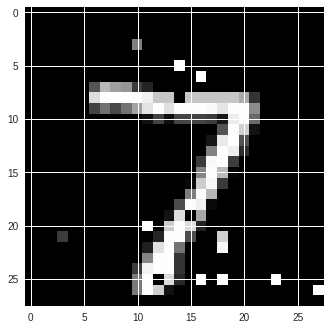

The classification label following attack is 2 from an original classification of 7
The L0 distance of the adversary is 0.01913265306122449
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


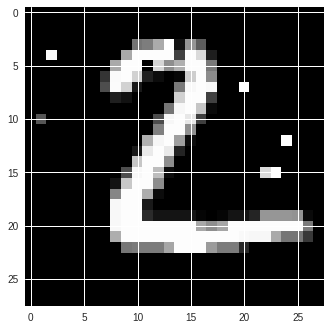

The classification label following attack is 6 from an original classification of 2
The L0 distance of the adversary is 0.012755102040816327
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


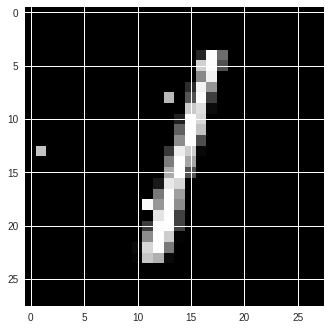

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.00510204081632653
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


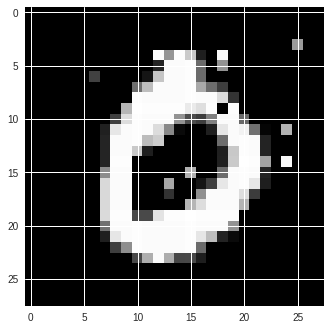

The classification label following attack is 6 from an original classification of 0
The L0 distance of the adversary is 0.015306122448979591
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


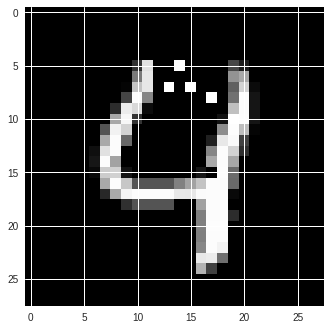

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.007653061224489796
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


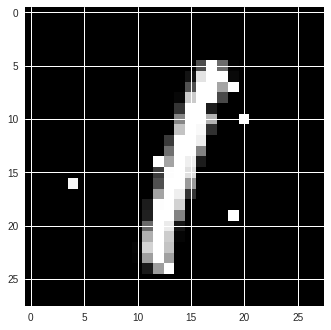

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.01020408163265306
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


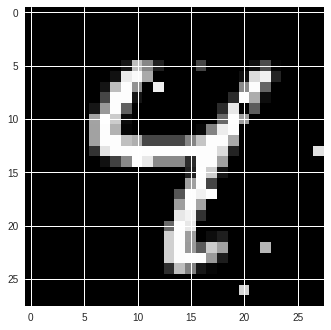

The classification label following attack is 8 from an original classification of 4
The L0 distance of the adversary is 0.01020408163265306
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


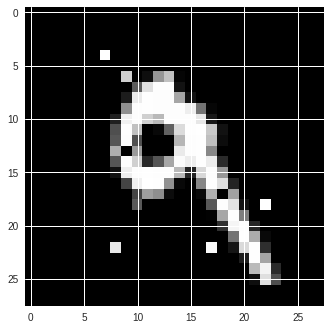

The classification label following attack is 3 from an original classification of 9
The L0 distance of the adversary is 0.01020408163265306
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


The model predicted a 6 when the ground-truth label is 5


/usr/local/lib/python3.6/dist-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'


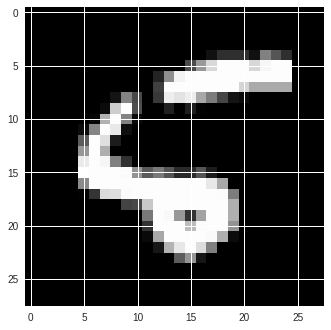

The classification label following attack is 6 from an original classification of 5
The L0 distance of the adversary is 0.0
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


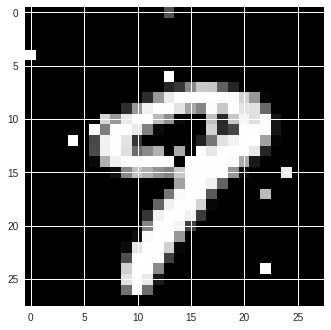

The classification label following attack is 7 from an original classification of 9
The L0 distance of the adversary is 0.016581632653061226
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


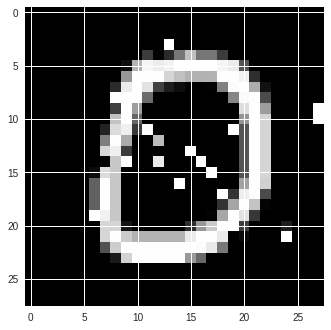

The classification label following attack is 8 from an original classification of 0
The L0 distance of the adversary is 0.02423469387755102
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


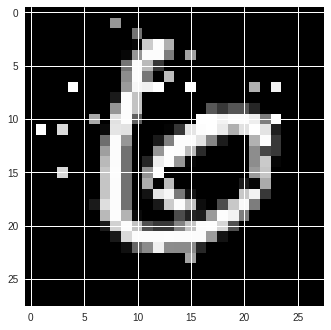

The classification label following attack is 8 from an original classification of 6
The L0 distance of the adversary is 0.029336734693877552
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


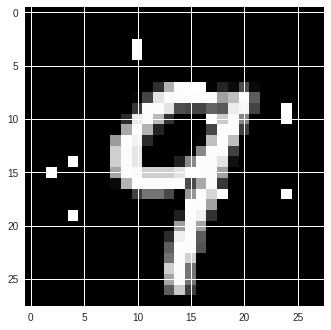

The classification label following attack is 4 from an original classification of 9
The L0 distance of the adversary is 0.01403061224489796
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


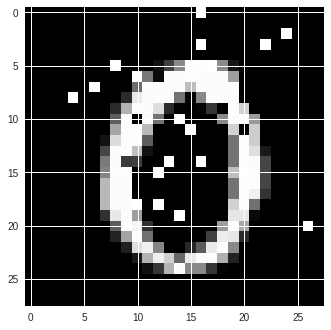

The classification label following attack is 5 from an original classification of 0
The L0 distance of the adversary is 0.030612244897959183
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


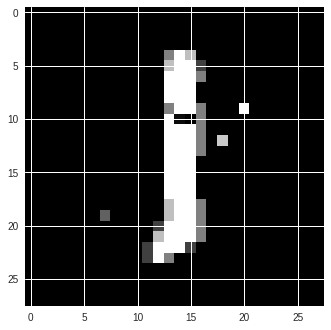

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.006377551020408163
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


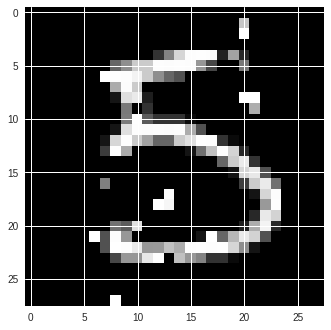

The classification label following attack is 8 from an original classification of 5
The L0 distance of the adversary is 0.02295918367346939
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


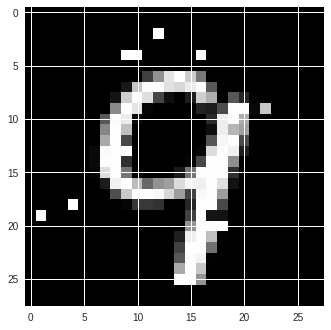

The classification label following attack is 4 from an original classification of 9
The L0 distance of the adversary is 0.01403061224489796
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


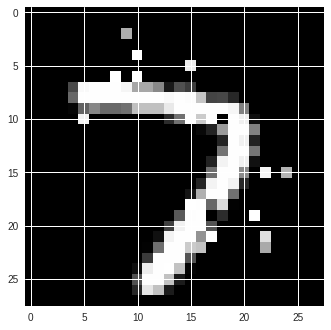

The classification label following attack is 2 from an original classification of 7
The L0 distance of the adversary is 0.02423469387755102
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


The model predicted a 8 when the ground-truth label is 3


/usr/local/lib/python3.6/dist-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'


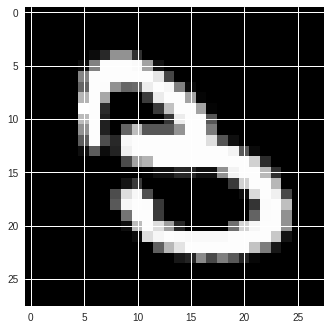

The classification label following attack is 8 from an original classification of 3
The L0 distance of the adversary is 0.0
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


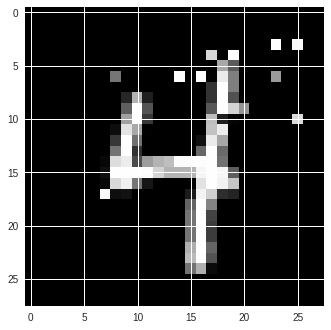

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.016581632653061226
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


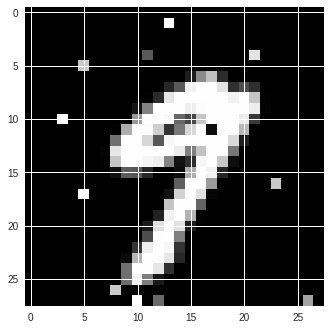

The classification label following attack is 7 from an original classification of 9
The L0 distance of the adversary is 0.016581632653061226
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


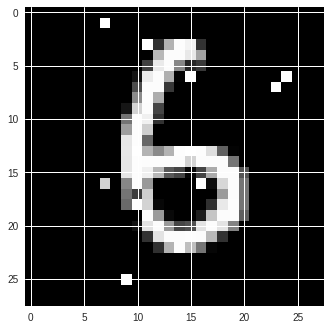

The classification label following attack is 5 from an original classification of 6
The L0 distance of the adversary is 0.012755102040816327
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


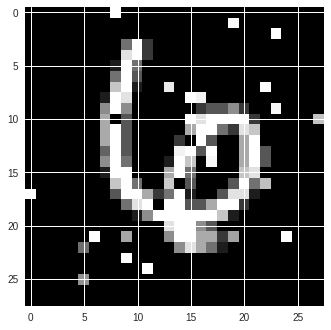

The classification label following attack is 8 from an original classification of 6
The L0 distance of the adversary is 0.03826530612244898
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


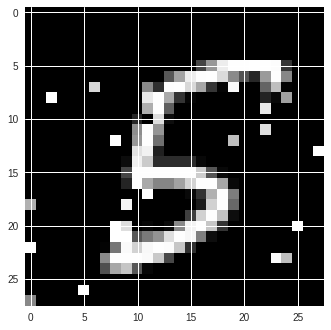

The classification label following attack is 8 from an original classification of 5
The L0 distance of the adversary is 0.03188775510204082
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


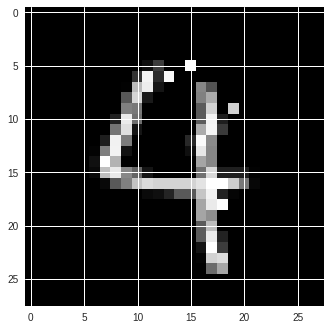

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.006377551020408163
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


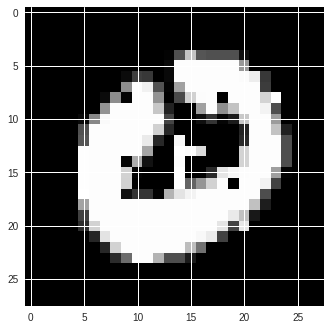

The classification label following attack is 6 from an original classification of 0
The L0 distance of the adversary is 0.02040816326530612
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


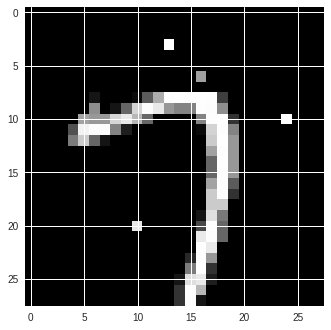

The classification label following attack is 2 from an original classification of 7
The L0 distance of the adversary is 0.00510204081632653
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


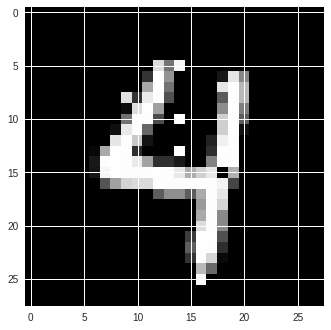

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.008928571428571428
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


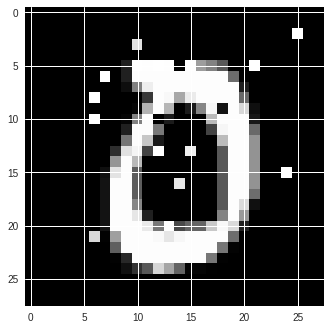

The classification label following attack is 2 from an original classification of 0
The L0 distance of the adversary is 0.01913265306122449
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


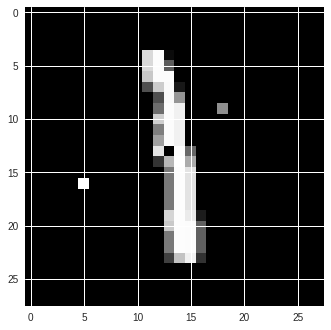

The classification label following attack is 5 from an original classification of 1
The L0 distance of the adversary is 0.003826530612244898
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


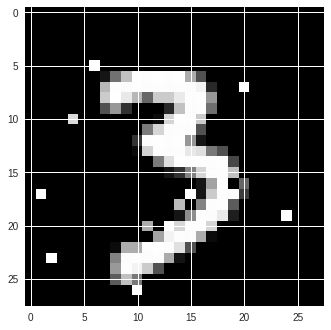

The classification label following attack is 7 from an original classification of 3
The L0 distance of the adversary is 0.015306122448979591
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


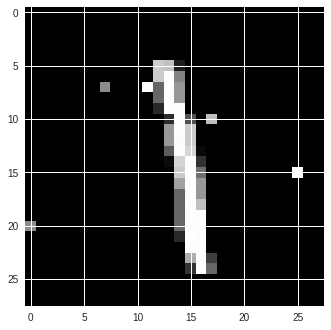

The classification label following attack is 7 from an original classification of 1
The L0 distance of the adversary is 0.007653061224489796
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


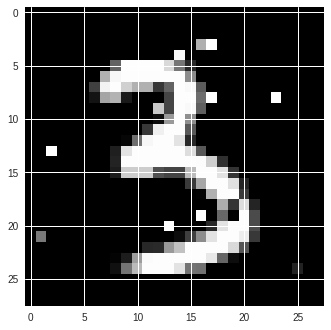

The classification label following attack is 5 from an original classification of 3
The L0 distance of the adversary is 0.016581632653061226
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


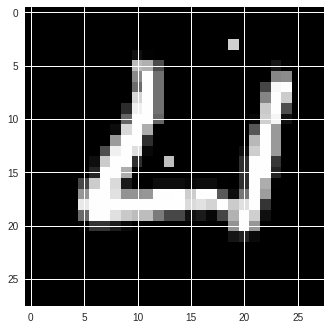

The classification label following attack is 6 from an original classification of 4
The L0 distance of the adversary is 0.002551020408163265
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


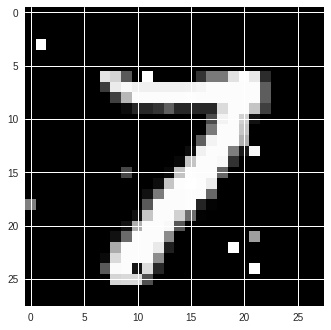

The classification label following attack is 2 from an original classification of 7
The L0 distance of the adversary is 0.012755102040816327
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


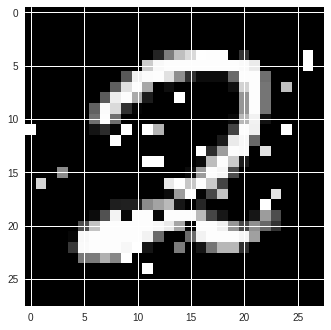

The classification label following attack is 8 from an original classification of 2
The L0 distance of the adversary is 0.044642857142857144
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


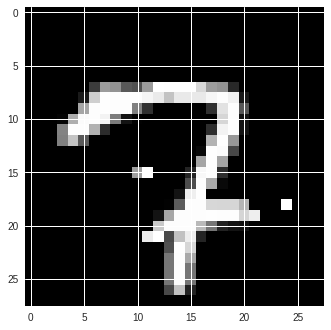

The classification label following attack is 2 from an original classification of 7
The L0 distance of the adversary is 0.007653061224489796
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


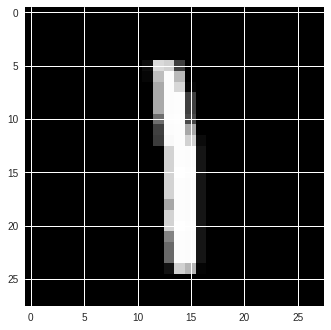

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.0012755102040816326
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


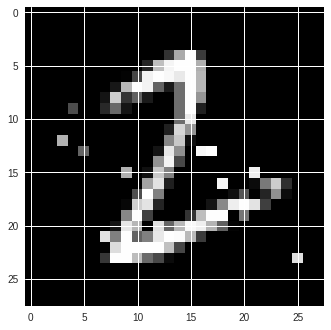

The classification label following attack is 8 from an original classification of 2
The L0 distance of the adversary is 0.02040816326530612
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


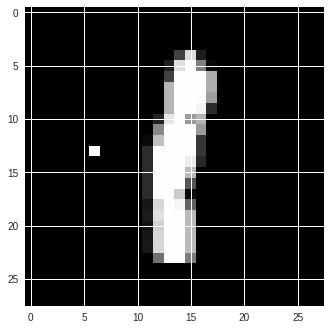

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.002551020408163265
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


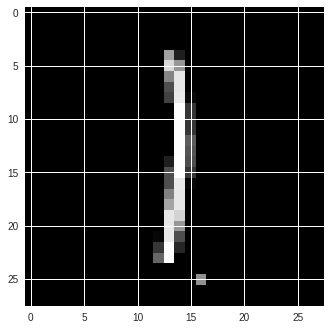

The classification label following attack is 2 from an original classification of 1
The L0 distance of the adversary is 0.0012755102040816326
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


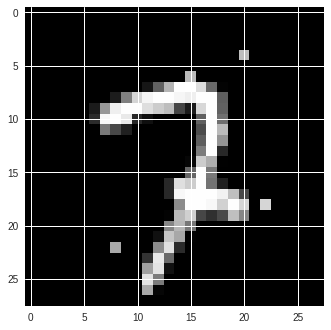

The classification label following attack is 2 from an original classification of 7
The L0 distance of the adversary is 0.006377551020408163
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


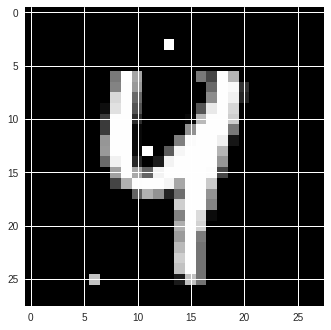

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.00510204081632653
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


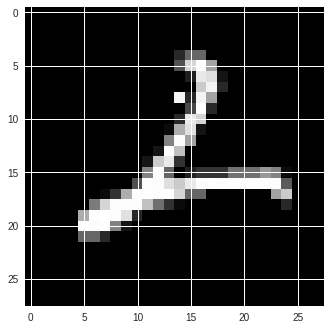

The classification label following attack is 6 from an original classification of 2
The L0 distance of the adversary is 0.0012755102040816326
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


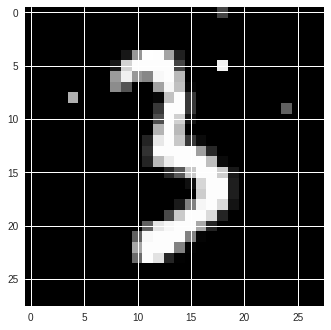

The classification label following attack is 5 from an original classification of 3
The L0 distance of the adversary is 0.00510204081632653
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


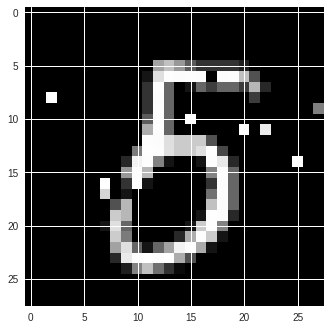

The classification label following attack is 8 from an original classification of 5
The L0 distance of the adversary is 0.012755102040816327
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


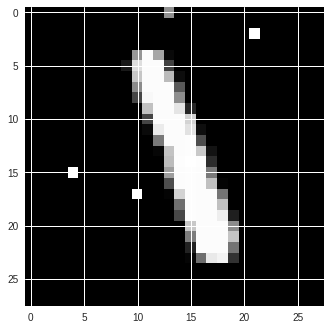

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.00510204081632653
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


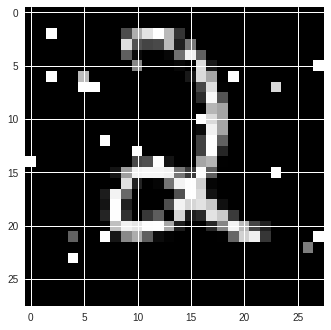

The classification label following attack is 4 from an original classification of 2
The L0 distance of the adversary is 0.03188775510204082
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


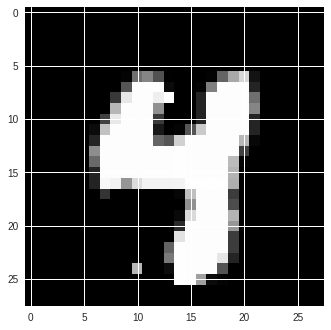

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.002551020408163265
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


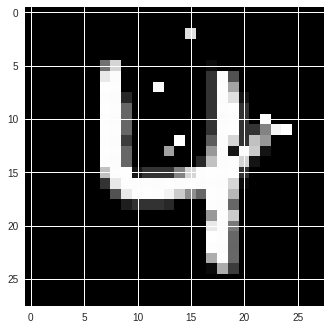

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.012755102040816327
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


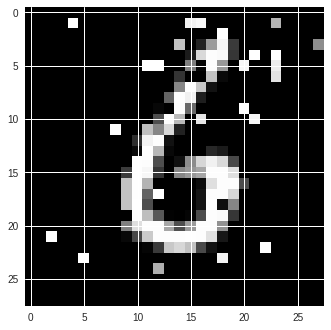

The classification label following attack is 2 from an original classification of 6
The L0 distance of the adversary is 0.042091836734693876
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


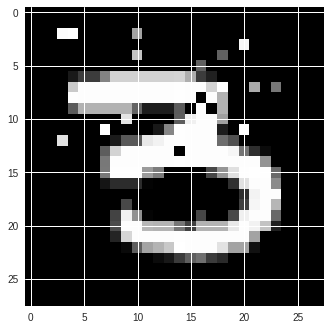

The classification label following attack is 5 from an original classification of 3
The L0 distance of the adversary is 0.02423469387755102
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


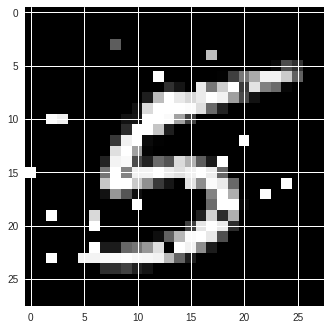

The classification label following attack is 2 from an original classification of 5
The L0 distance of the adversary is 0.03443877551020408
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


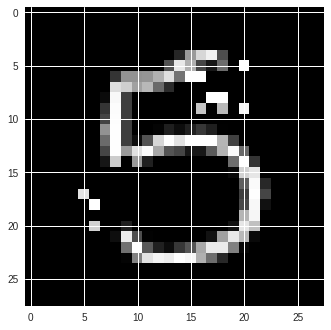

The classification label following attack is 3 from an original classification of 5
The L0 distance of the adversary is 0.016581632653061226
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


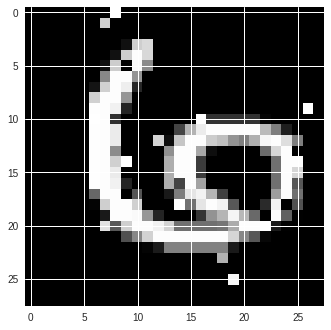

The classification label following attack is 8 from an original classification of 6
The L0 distance of the adversary is 0.02295918367346939
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


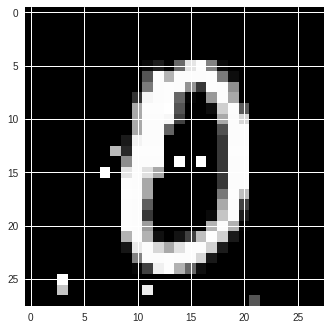

The classification label following attack is 8 from an original classification of 0
The L0 distance of the adversary is 0.01020408163265306
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


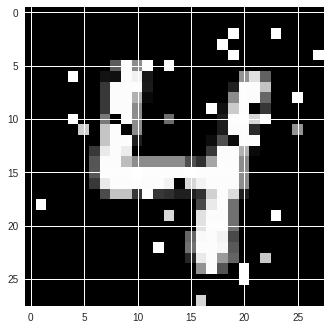

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.039540816326530615
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


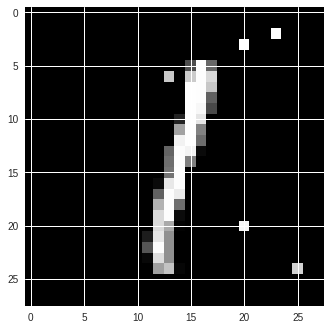

The classification label following attack is 2 from an original classification of 1
The L0 distance of the adversary is 0.006377551020408163
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


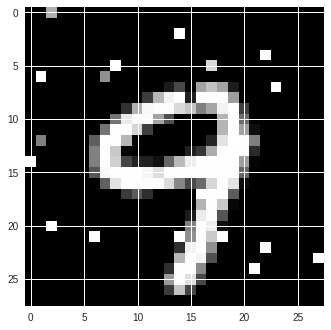

The classification label following attack is 4 from an original classification of 9
The L0 distance of the adversary is 0.025510204081632654
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


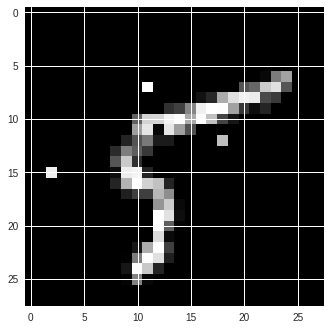

The classification label following attack is 8 from an original classification of 5
The L0 distance of the adversary is 0.006377551020408163
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


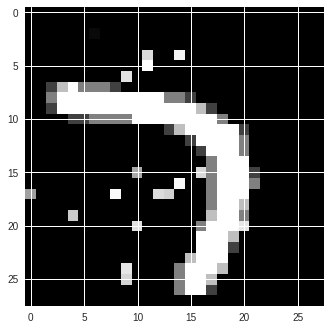

The classification label following attack is 3 from an original classification of 7
The L0 distance of the adversary is 0.021683673469387755
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


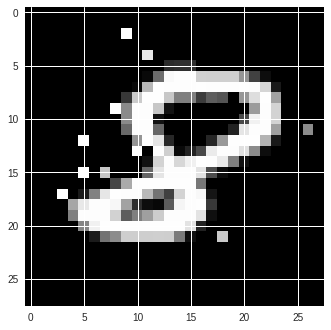

The classification label following attack is 2 from an original classification of 8
The L0 distance of the adversary is 0.015306122448979591
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


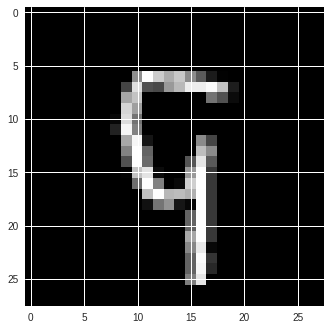

The classification label following attack is 5 from an original classification of 9
The L0 distance of the adversary is 0.0012755102040816326
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


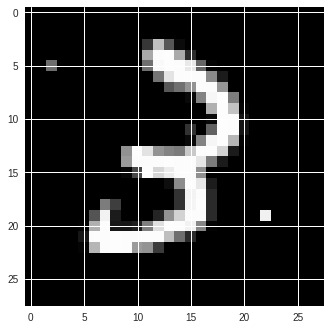

The classification label following attack is 2 from an original classification of 3
The L0 distance of the adversary is 0.006377551020408163
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


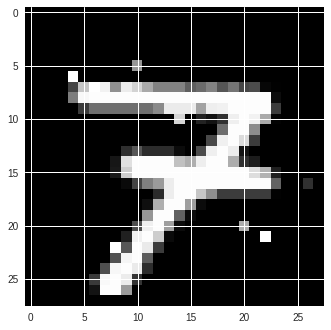

The classification label following attack is 2 from an original classification of 7
The L0 distance of the adversary is 0.011479591836734694
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


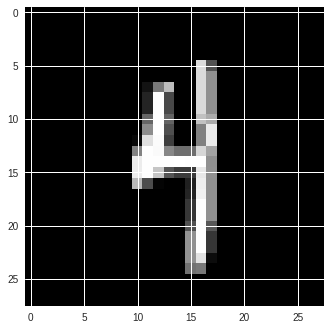

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.0012755102040816326
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


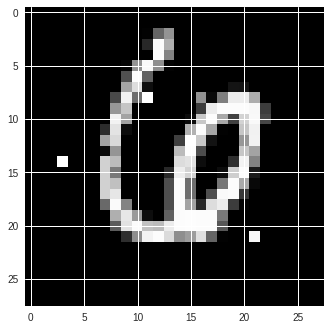

The classification label following attack is 2 from an original classification of 6
The L0 distance of the adversary is 0.007653061224489796
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


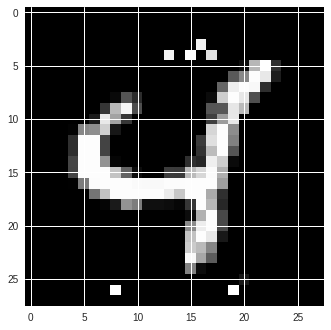

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.01020408163265306
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


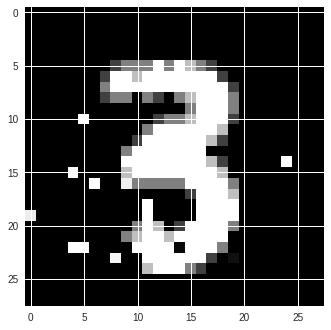

The classification label following attack is 8 from an original classification of 3
The L0 distance of the adversary is 0.01913265306122449
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


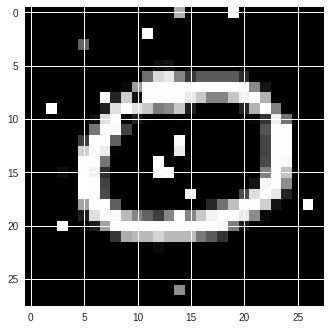

The classification label following attack is 6 from an original classification of 0
The L0 distance of the adversary is 0.025510204081632654
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


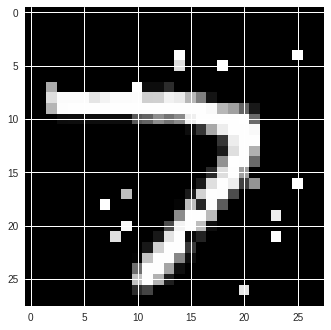

The classification label following attack is 2 from an original classification of 7
The L0 distance of the adversary is 0.021683673469387755
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


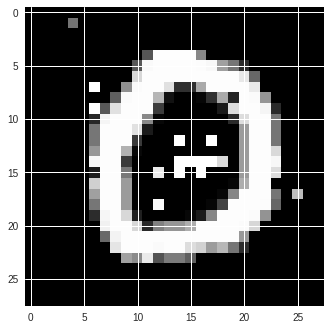

The classification label following attack is 8 from an original classification of 0
The L0 distance of the adversary is 0.02295918367346939
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


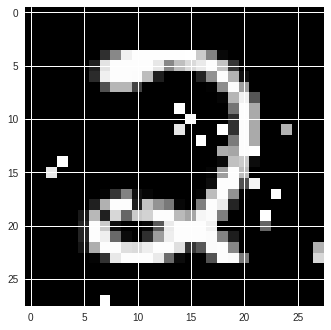

The classification label following attack is 3 from an original classification of 2
The L0 distance of the adversary is 0.025510204081632654
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


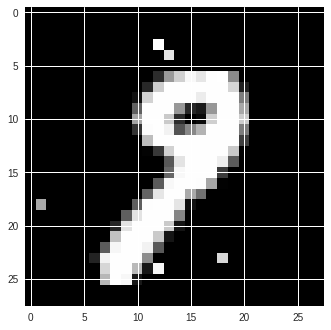

The classification label following attack is 2 from an original classification of 9
The L0 distance of the adversary is 0.006377551020408163
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


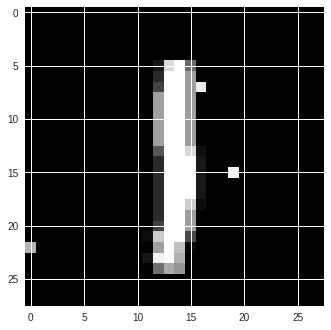

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.003826530612244898
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


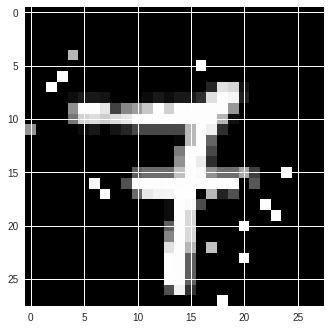

The classification label following attack is 2 from an original classification of 7
The L0 distance of the adversary is 0.021683673469387755
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


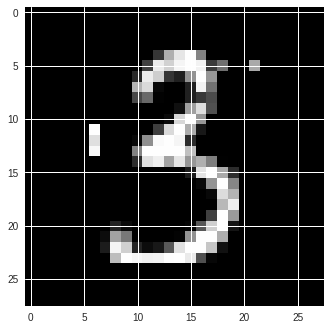

The classification label following attack is 5 from an original classification of 3
The L0 distance of the adversary is 0.007653061224489796
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


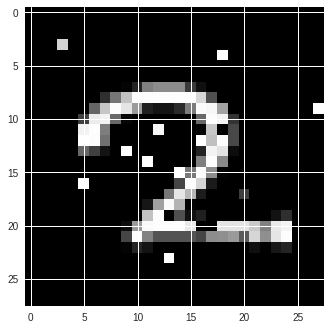

The classification label following attack is 8 from an original classification of 2
The L0 distance of the adversary is 0.01913265306122449
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


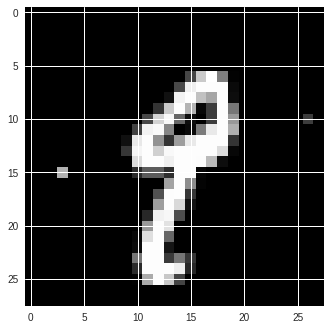

The classification label following attack is 8 from an original classification of 9
The L0 distance of the adversary is 0.003826530612244898
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


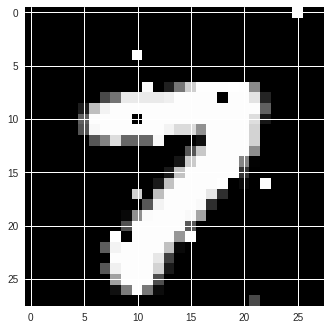

The classification label following attack is 2 from an original classification of 7
The L0 distance of the adversary is 0.02040816326530612
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


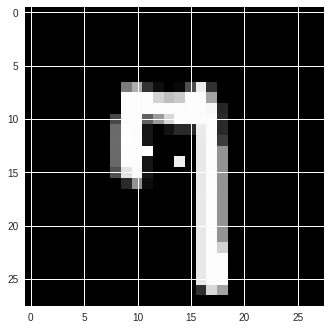

The classification label following attack is 9 from an original classification of 7
The L0 distance of the adversary is 0.002551020408163265
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


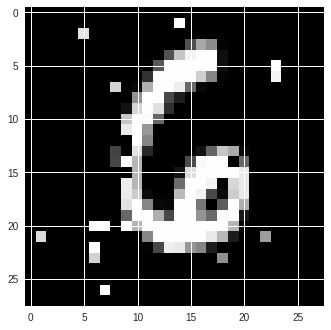

The classification label following attack is 5 from an original classification of 6
The L0 distance of the adversary is 0.025510204081632654
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


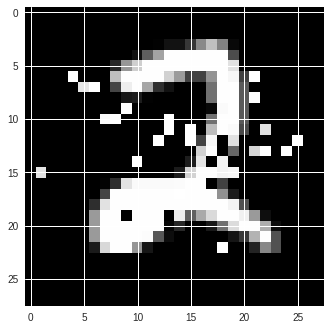

The classification label following attack is 8 from an original classification of 2
The L0 distance of the adversary is 0.039540816326530615
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


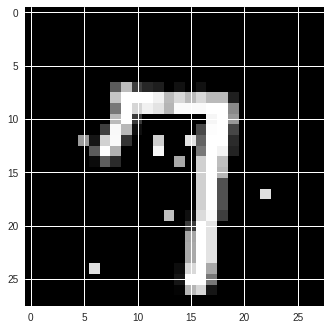

The classification label following attack is 9 from an original classification of 7
The L0 distance of the adversary is 0.01020408163265306
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


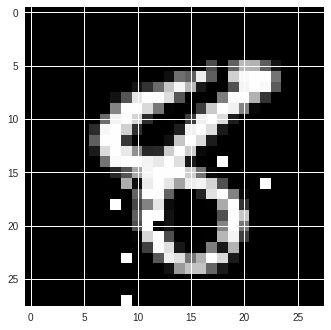

The classification label following attack is 5 from an original classification of 8
The L0 distance of the adversary is 0.012755102040816327
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


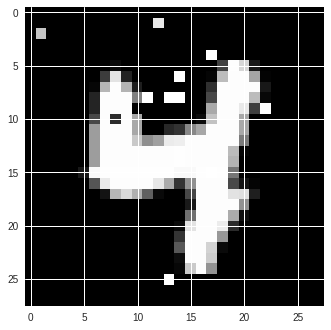

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.01403061224489796
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


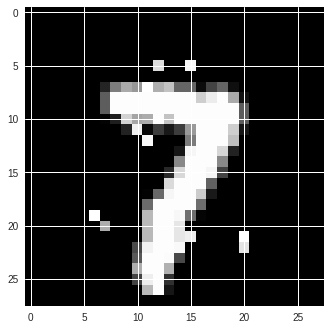

The classification label following attack is 2 from an original classification of 7
The L0 distance of the adversary is 0.012755102040816327
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


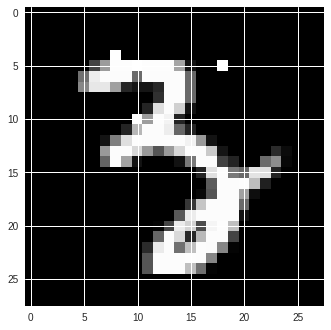

The classification label following attack is 5 from an original classification of 3
The L0 distance of the adversary is 0.006377551020408163
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


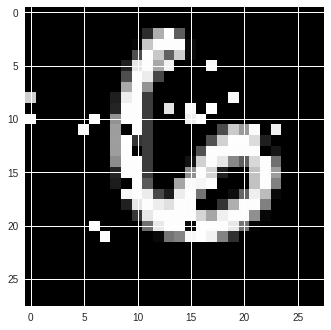

The classification label following attack is 2 from an original classification of 6
The L0 distance of the adversary is 0.030612244897959183
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


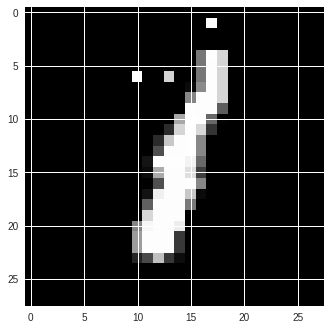

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.003826530612244898
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


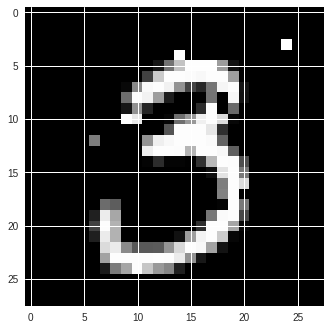

The classification label following attack is 5 from an original classification of 3
The L0 distance of the adversary is 0.011479591836734694
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


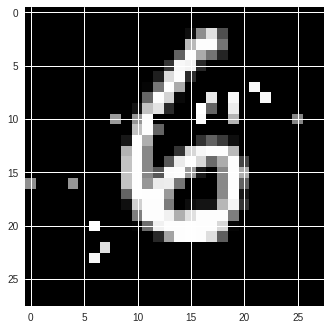

The classification label following attack is 5 from an original classification of 6
The L0 distance of the adversary is 0.021683673469387755
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


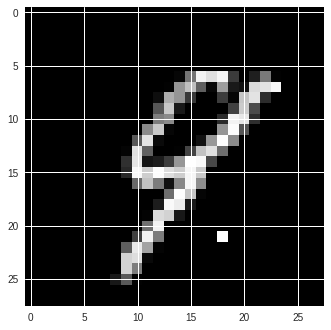

The classification label following attack is 8 from an original classification of 9
The L0 distance of the adversary is 0.002551020408163265
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


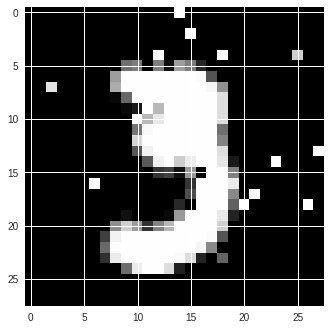

The classification label following attack is 5 from an original classification of 3
The L0 distance of the adversary is 0.025510204081632654
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


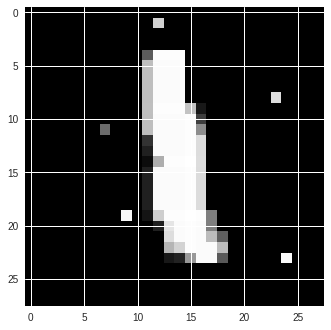

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.006377551020408163
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


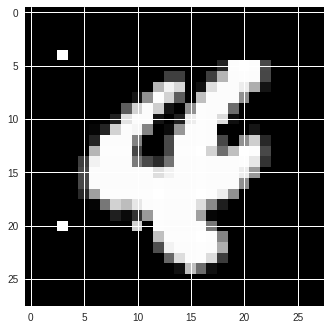

The classification label following attack is 6 from an original classification of 4
The L0 distance of the adversary is 0.00510204081632653
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


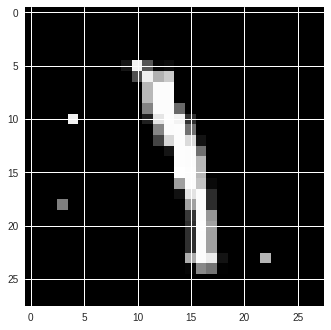

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.00510204081632653
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


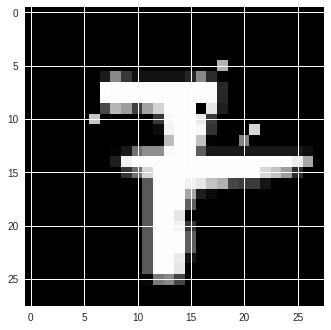

The classification label following attack is 8 from an original classification of 7
The L0 distance of the adversary is 0.006377551020408163
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


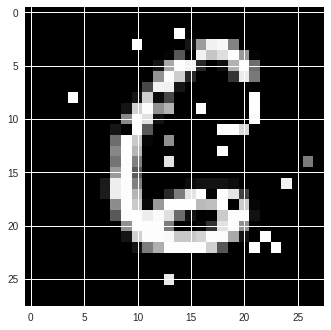

The classification label following attack is 2 from an original classification of 6
The L0 distance of the adversary is 0.03188775510204082
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


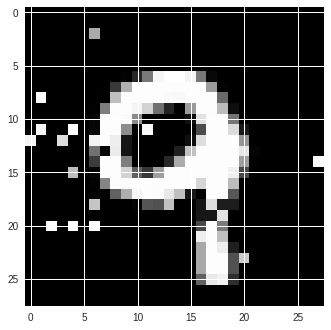

The classification label following attack is 2 from an original classification of 9
The L0 distance of the adversary is 0.02806122448979592


In [0]:
adversary_found, adversary_distance, adversary_arrays = evaluate_l0_PointWiseAttack_resistance_CustomModel(
    model_prediction_function=cnn_binding_predictions, model_weights="/Binding_CNN.ckpt", var_list=var_list_Binding,
    num_images_to_attack=num_images_to_attack, temp_batch_size=1)

In [0]:
success_ratio = np.sum(adversary_found)/num_images_to_attack
mean_distance_successful_attacks = np.sum(adversary_distance)/np.sum(adversary_found)

print("The success ratio is " + str(success_ratio))
print("The mean distance is " + str(mean_distance_successful_attacks))


The success ratio is 1.0
The mean distance is 0.014719387755102042


The Point-Wise attack is able to achieve 100% misclassification against the binding CNN with a mean l-0 distance of 0.0147. This is a smaller distance than that required against the standard CNN, arguing against increased adversarial resistance. Note these results were obtained from 100 images. 

##Basic Iterative (Gradient-Based) Attack

L-infinity minimising, gradient based method.

###BIM Attack Functions for the TensorFlow Models

In [0]:
# *** this code can eventually be refractored with earlier functions

#Function used to attack an arbitrary model that has been implemented with TensorFlow's low-level API (i.e. requires a session to be called explicitly)
def BIM_Attack_customTensorFlowModel(model_prediction_function, model_weights, var_list, test_image, test_label, temp_batch_size):

    images = x #x is a place-holder for 28x28 images earlier defined
    logits = model_prediction_function(images, temp_batch_size)

    saver = tf.train.Saver(var_list) #Define saver object for use later when loading the model weights

    #Note how when attacking a low-level TensorFlow API model, it is necessary for all steps to occur within the tf.Session()
    with tf.Session() as session:
        saver.restore(session, model_weights)

        #Define the foolbox model
        fmodel = foolbox.models.TensorFlowModel(images, logits, (0,1)) #The final parameter specifies the input values range

        #The predicted label of the network prior to carrying out the attack
        pre_label = np.argmax(fmodel.predictions(test_image[:, :, :]))
        #print("The classification label prior to attack is " + str(pre_label))
        if (pre_label != test_label):
            print("The model predicted a " + str(pre_label) + " when the ground-truth label is " + str(test_label))
            plt.imshow(test_image[:,:,0], cmap='gray')

        #Carry out the untargeted Bounary Attack
        attack_fmodel = foolbox.attacks.LinfinityBasicIterativeAttack(model=fmodel, criterion=foolbox.criteria.Misclassification(),
                                                                     distance=foolbox.distances.Linfinity)
        adversarial_image_fmodel = attack_fmodel(test_image, test_label, epsilon=0.001)
        plt.imshow(adversarial_image_fmodel[:,:,0], cmap='gray')
        plt.show()
        
        #Check the output of the adversarial attack
        adversarial_label_fmodel = np.argmax(fmodel.predictions(adversarial_image_fmodel[:, :, :]))
        print("The classification label following attack is " + str(adversarial_label_fmodel) 
              + " from an original classification of " + str(test_label))
        
        return adversarial_image_fmodel, adversarial_label_fmodel

###Visualize the BIM Attack

INFO:tensorflow:Restoring parameters from /MNIST_LeNet5_CNN.ckpt


INFO:tensorflow:Restoring parameters from /MNIST_LeNet5_CNN.ckpt


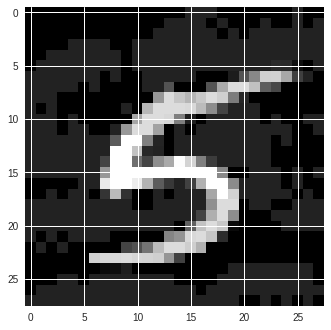

The classification label following attack is 4 from an original classification of 5


In [0]:
#An example of the attack
adversarial_image_fmodel, adversarial_label_fmodel = BIM_Attack_customTensorFlowModel(model_prediction_function=cnn_predictions,
                                                                 model_weights="/MNIST_LeNet5_CNN.ckpt", 
                                                                var_list=var_list_LeNet,
                                                                 test_image=test_image_LeNet, 
                                                                 test_label=test_label_LeNet,
                                                                 temp_batch_size=None)


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


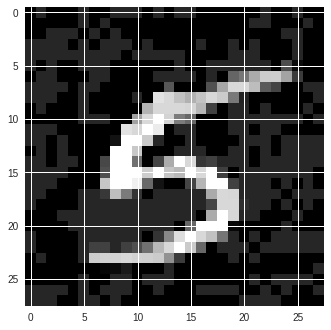

The classification label following attack is 6 from an original classification of 5


In [0]:
adversarial_image_fmodel, adversarial_label_fmodel = BIM_Attack_customTensorFlowModel(model_prediction_function=cnn_binding_predictions,
                                                                 model_weights="/Binding_CNN.ckpt",
                                                                  var_list=var_list_Binding,
                                                                 test_image=test_image_LeNet, 
                                                                 test_label=test_label_LeNet,
                                                                 temp_batch_size=1)


##Blended Uniform Noise Attack

###Blended Uniform Noise Attack Function for the TensorFlow Models

In [0]:
# *** this code can eventually be refractored with earlier functions

#Function used to attack an arbitrary model that has been implemented with TensorFlow's low-level API (i.e. requires a session to be called explicitly)
def BlendedUniformNoise_Attack_customTensorFlowModel(model_prediction_function, model_weights, 
                                                     var_list, test_image, test_label, temp_batch_size, keep_prob):

    images = x #x is a place-holder for 28x28 images earlier defined
    logits = model_prediction_function(images, temp_batch_size, keep_prob)

    saver = tf.train.Saver(var_list) #Define saver object for use later when loading the model weights

    #Note how when attacking a low-level TensorFlow API model, it is necessary for all steps to occur within the tf.Session()
    with tf.Session() as session:
        saver.restore(session, model_weights)

        #Define the foolbox model
        fmodel = foolbox.models.TensorFlowModel(images, logits, (0,1)) #The final parameter specifies the input values range

        #The predicted label of the network prior to carrying out the attack
        pre_label = np.argmax(fmodel.predictions(test_image[:, :, :]))
        #print("The classification label prior to attack is " + str(pre_label))
        if (pre_label != test_label):
            print("The model predicted a " + str(pre_label) + " when the ground-truth label is " + str(test_label))
            plt.imshow(test_image[:,:,0], cmap='gray')

        #Carry out the untargeted Bounary Attack
        attack_fmodel = foolbox.attacks.BlendedUniformNoiseAttack(model=fmodel, criterion=foolbox.criteria.Misclassification())
        adversarial_image_fmodel = attack_fmodel(test_image, test_label)
        plt.imshow(adversarial_image_fmodel[:,:,0], cmap='gray')
        plt.show()
        
        #Check the output of the adversarial attack
        adversarial_label_fmodel = np.argmax(fmodel.predictions(adversarial_image_fmodel[:, :, :]))
        print("The classification label following attack is " + str(adversarial_label_fmodel) 
              + " from an original classification of " + str(test_label))
        
        return adversarial_image_fmodel, adversarial_label_fmodel

In [0]:
# *** this code can eventually be refractored with earlier functions

#Iterate through a series of images to be attacked
def evaluate_BlendedUniformNoiseAttack_resistance_CustomModel(model_prediction_function, model_weights, 
                                                              var_list, num_images_to_attack, temp_batch_size):
    adversary_found = np.zeros([num_images_to_attack]) #array of booleans that indicates if an adversary was found for a particular image
    adversary_distance = np.zeros([num_images_to_attack])
    adversary_arrays = np.zeros([num_images_to_attack, testing_data.shape[1], testing_data.shape[2], 1])

    for ii in range(num_images_to_attack):
        test_image = testing_data[ii, :, :]
        test_label = np.argmax(testing_labels[ii,:])

        adversarial_image_fmodel, adversarial_classification = BlendedUniformNoise_Attack_customTensorFlowModel(model_prediction_function, 
                                                                                                     model_weights, var_list, 
                                                                                                     test_image, test_label, 
                                                                                                     temp_batch_size,
                                                                                                     keep_prob=1.0)
        adversary_arrays[ii, :, :] = adversarial_image_fmodel

        if ((np.any(adversarial_image_fmodel == None) | adversarial_classification == test_label)):
            print("No adversarial image found")

        else:
            l2_distance = scipy.spatial.distance.euclidean(test_image.flatten(), adversarial_image_fmodel.flatten())
            print("The L2 distance of the adversary is " + str(l2_distance))
            adversary_found[ii] = 1
            adversary_distance[ii] = l2_distance
        
    return adversary_found, adversary_distance, adversary_arrays

###Blended Uniform Noise Attack Function for the Keras Models

In [0]:
#Function to iterate through a series of images to be attacked
def evaluate_BlendedUniformNoiseAttack_resistance_MadryModel(num_images_to_attack):
    adversary_found = np.zeros([num_images_to_attack]) #array of booleans that indicates if an adversary was found for a particular image
    adversary_distance = np.zeros([num_images_to_attack])
    adversary_arrays = np.zeros([num_images_to_attack, Madry_testing_data.shape[1]])
    
    for ii in range(num_images_to_attack):
        test_image_Madry = Madry_testing_data[ii, :]
        test_label_Madry = np.argmax(Madry_testing_labels[ii,:])

        Madry_attack = foolbox.attacks.BlendedUniformNoiseAttack(model=Madry_model, criterion=foolbox.criteria.Misclassification())
        Madry_adversarial_image = Madry_attack(test_image_Madry, test_label_Madry)
        adversary_arrays[ii, :] = Madry_adversarial_image
        
        # **** need to check this logical statement for accuracy
        if np.any(np.any(Madry_adversarial_image == None) | (Madry_model.predictions(Madry_adversarial_image) == test_label_Madry)):
            print("No adversarial image found")

        else:
            l2_distance = scipy.spatial.distance.euclidean(test_image_Madry, Madry_adversarial_image)
            print("The L2 distance of the adversary is " + str(l2_distance))
            adversary_found[ii] = 1
            adversary_distance[ii] = l2_distance

    return adversary_found, adversary_distance, adversary_arrays


###Visualize the Attack

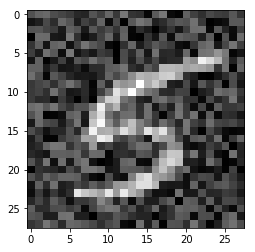

The classification label following attack is 9 from an original classification of 5


In [68]:
#An example of the attack
adversarial_image_fmodel, adversarial_label_fmodel = BlendedUniformNoise_Attack_customTensorFlowModel(model_prediction_function=cnn_predictions,
                                                                 model_weights="/MNIST_LeNet5_CNN.ckpt", 
                                                                var_list=var_list_LeNet,
                                                                 test_image=test_image_LeNet, 
                                                                 test_label=test_label_LeNet,
                                                                 temp_batch_size=None,
                                                                                                     keep_prob=1.0)


###Quantify Vulnerability

In [0]:
num_images_to_attack=75

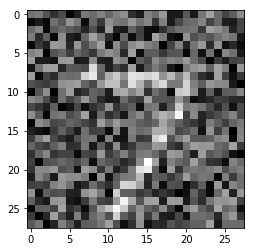

The classification label following attack is 0 from an original classification of 7
The L2 distance of the adversary is 10.093498921656577


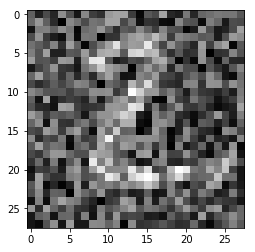

The classification label following attack is 4 from an original classification of 2
The L2 distance of the adversary is 10.012675592882772


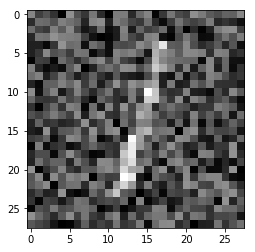

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 9.063729104635609


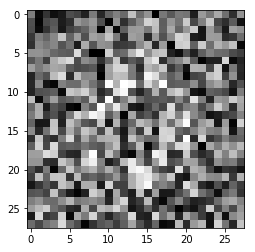

The classification label following attack is 8 from an original classification of 0
The L2 distance of the adversary is 12.861495866112692


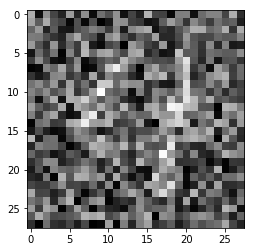

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 10.859299923469827


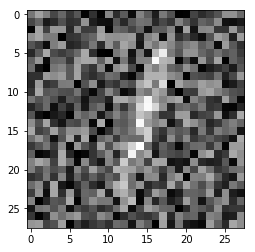

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 9.956147308192323


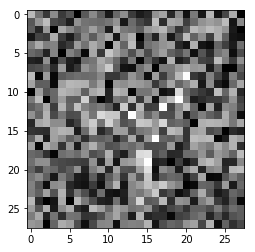

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 11.717123850789138


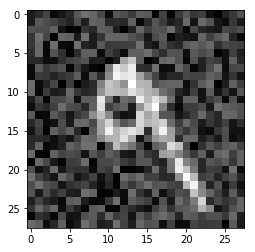

The classification label following attack is 4 from an original classification of 9
The L2 distance of the adversary is 6.908782860454014


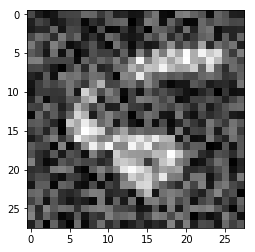

The classification label following attack is 8 from an original classification of 5
The L2 distance of the adversary is 8.001818852160836


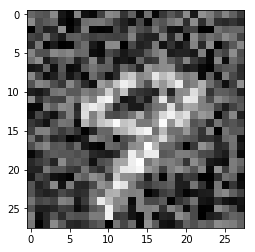

The classification label following attack is 8 from an original classification of 9
The L2 distance of the adversary is 8.700889042492715


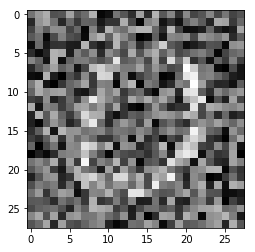

The classification label following attack is 8 from an original classification of 0
The L2 distance of the adversary is 11.199089453084992


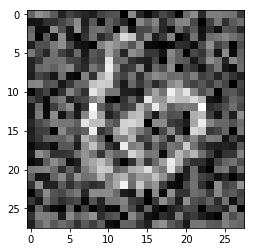

The classification label following attack is 0 from an original classification of 6
The L2 distance of the adversary is 8.642546672769397


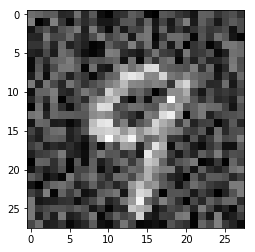

The classification label following attack is 4 from an original classification of 9
The L2 distance of the adversary is 7.703725125783995


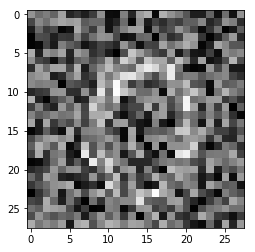

The classification label following attack is 8 from an original classification of 0
The L2 distance of the adversary is 11.03287357615449


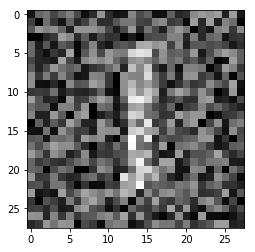

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 10.043504380116623


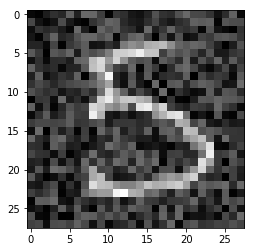

The classification label following attack is 3 from an original classification of 5
The L2 distance of the adversary is 6.482735359022814


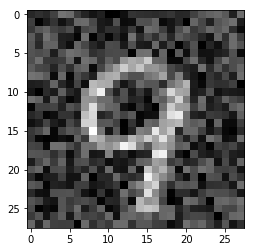

The classification label following attack is 4 from an original classification of 9
The L2 distance of the adversary is 7.124294924098196


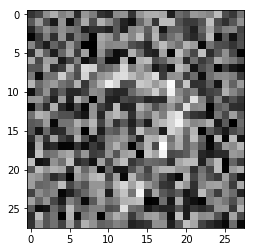

The classification label following attack is 0 from an original classification of 7
The L2 distance of the adversary is 11.8393928612046


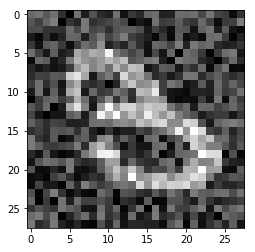

The classification label following attack is 8 from an original classification of 3
The L2 distance of the adversary is 7.63978733884153


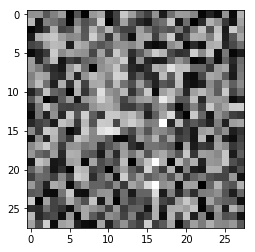

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 12.635153087274215


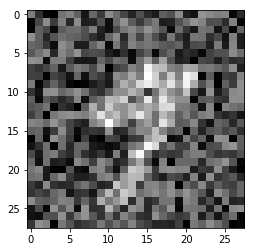

The classification label following attack is 4 from an original classification of 9
The L2 distance of the adversary is 9.429048290087703


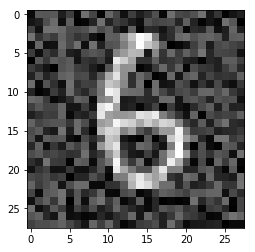

The classification label following attack is 8 from an original classification of 6
The L2 distance of the adversary is 7.011161826849466


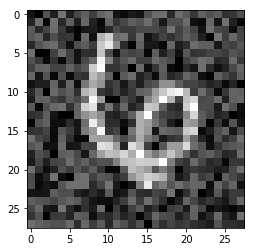

The classification label following attack is 4 from an original classification of 6
The L2 distance of the adversary is 7.0300975531796785


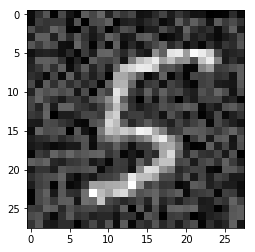

The classification label following attack is 8 from an original classification of 5
The L2 distance of the adversary is 6.306701155580897


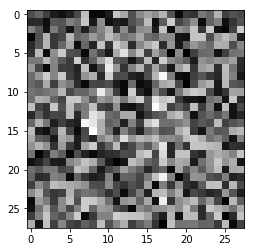

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 11.354626720187266


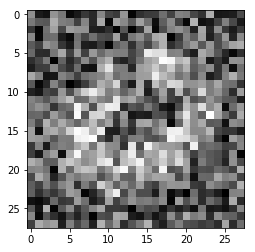

The classification label following attack is 8 from an original classification of 0
The L2 distance of the adversary is 10.809810215406152


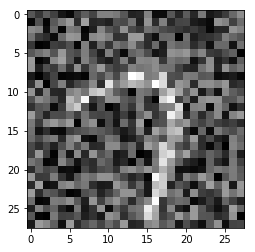

The classification label following attack is 0 from an original classification of 7
The L2 distance of the adversary is 9.218705624455387


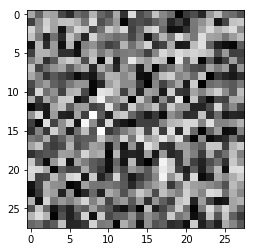

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 13.729023534472892


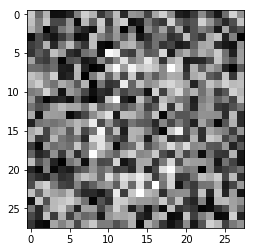

The classification label following attack is 8 from an original classification of 0
The L2 distance of the adversary is 12.670549897127366


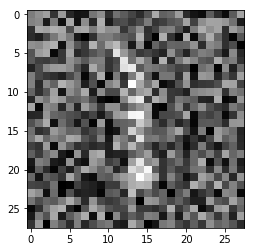

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 10.783145657530657


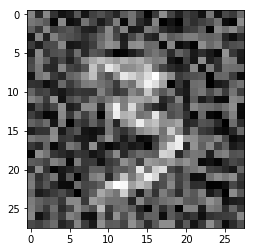

The classification label following attack is 8 from an original classification of 3
The L2 distance of the adversary is 8.99629308135272


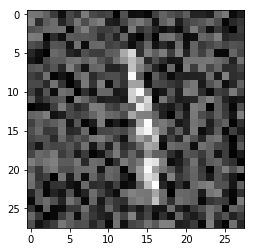

The classification label following attack is 4 from an original classification of 1
The L2 distance of the adversary is 8.175238435892012


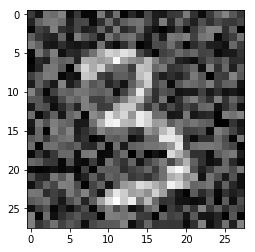

The classification label following attack is 8 from an original classification of 3
The L2 distance of the adversary is 8.081814042546215


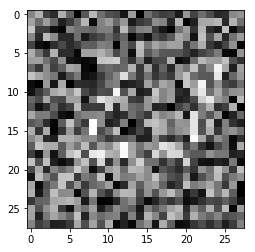

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 12.05543885334069


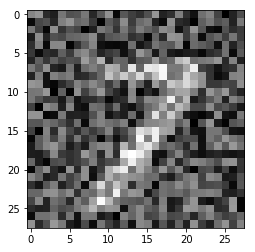

The classification label following attack is 8 from an original classification of 7
The L2 distance of the adversary is 9.509400672660428


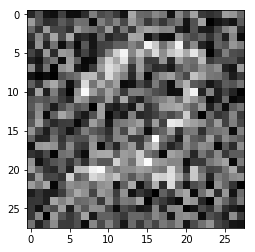

The classification label following attack is 8 from an original classification of 2
The L2 distance of the adversary is 10.25590591451446


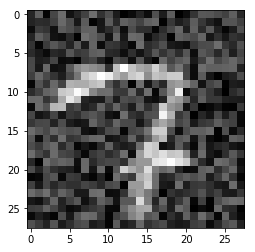

The classification label following attack is 2 from an original classification of 7
The L2 distance of the adversary is 6.89031795753308


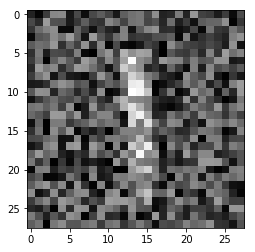

The classification label following attack is 4 from an original classification of 1
The L2 distance of the adversary is 9.753485704824488


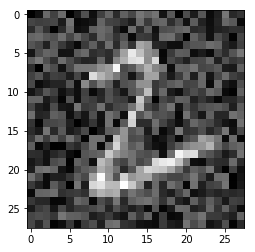

The classification label following attack is 8 from an original classification of 2
The L2 distance of the adversary is 7.329347077195394


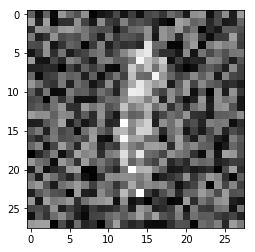

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 9.97901494448243


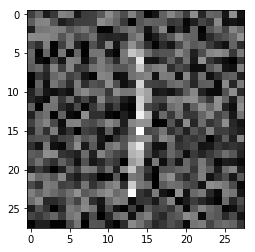

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 8.364965247309026


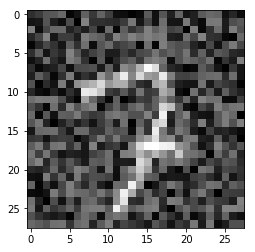

The classification label following attack is 2 from an original classification of 7
The L2 distance of the adversary is 8.105287854389852


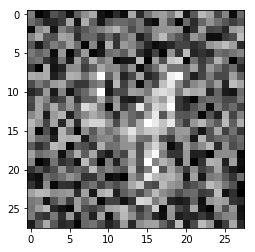

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 10.922500642209283


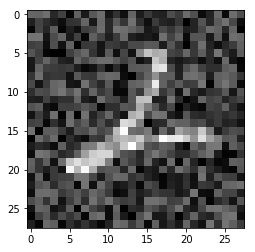

The classification label following attack is 4 from an original classification of 2
The L2 distance of the adversary is 7.278238296909522


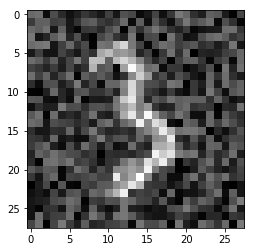

The classification label following attack is 4 from an original classification of 3
The L2 distance of the adversary is 7.44622759190907


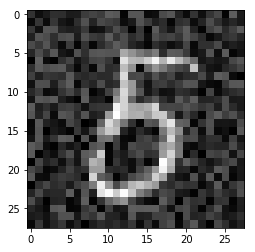

The classification label following attack is 8 from an original classification of 5
The L2 distance of the adversary is 5.636184721849951


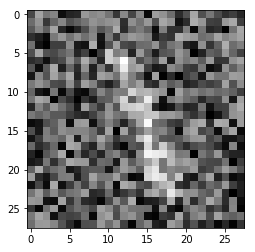

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 10.923949435937674


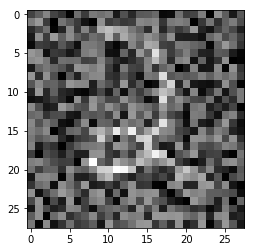

The classification label following attack is 8 from an original classification of 2
The L2 distance of the adversary is 9.639096817149067


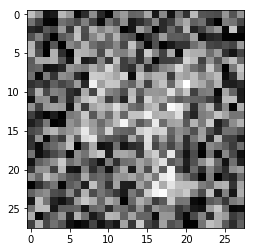

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 11.859265879992153


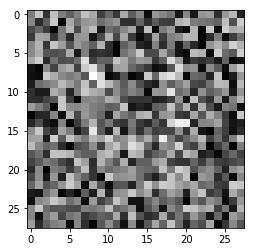

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 12.483356482994811


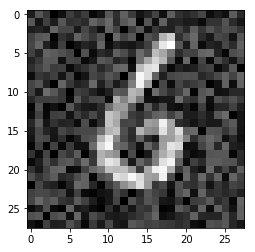

The classification label following attack is 0 from an original classification of 6
The L2 distance of the adversary is 6.302966265539266


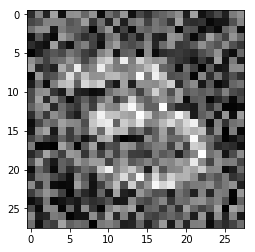

The classification label following attack is 8 from an original classification of 3
The L2 distance of the adversary is 9.87645878818874


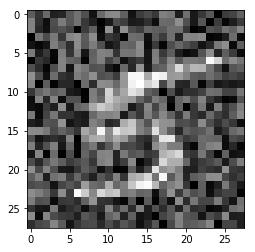

The classification label following attack is 8 from an original classification of 5
The L2 distance of the adversary is 8.63945744055799


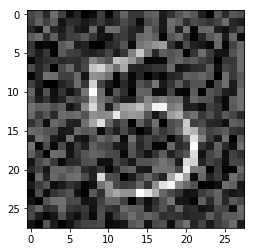

The classification label following attack is 8 from an original classification of 5
The L2 distance of the adversary is 7.0079283592851125


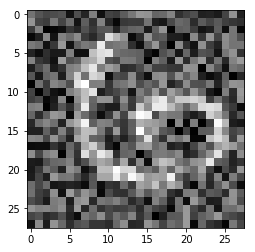

The classification label following attack is 4 from an original classification of 6
The L2 distance of the adversary is 9.42077649171663


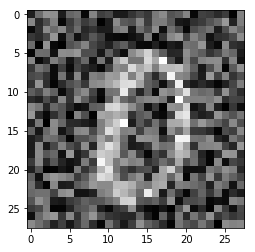

The classification label following attack is 8 from an original classification of 0
The L2 distance of the adversary is 9.347785115678022


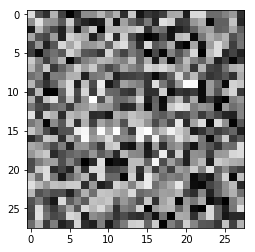

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 13.464213692942126


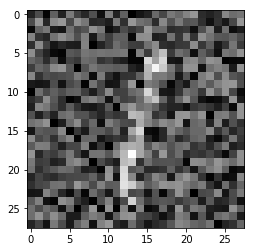

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 9.397142907949979


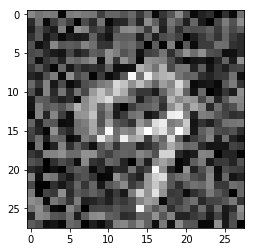

The classification label following attack is 4 from an original classification of 9
The L2 distance of the adversary is 8.724358907648131


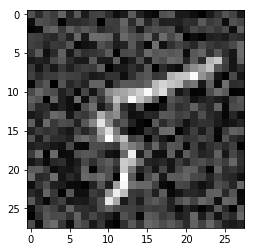

The classification label following attack is 8 from an original classification of 5
The L2 distance of the adversary is 6.13290351650419


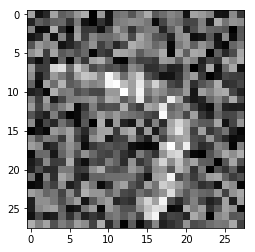

The classification label following attack is 8 from an original classification of 7
The L2 distance of the adversary is 10.909560350768366


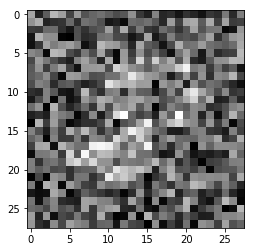

The classification label following attack is 4 from an original classification of 8
The L2 distance of the adversary is 10.989588678370737


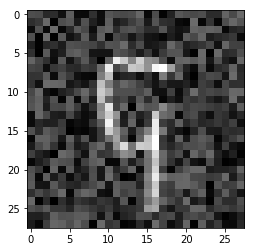

The classification label following attack is 8 from an original classification of 9
The L2 distance of the adversary is 6.483974214167198


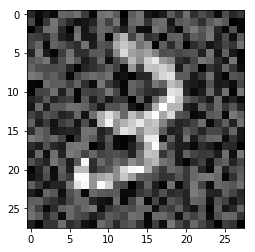

The classification label following attack is 9 from an original classification of 3
The L2 distance of the adversary is 7.354160634684586


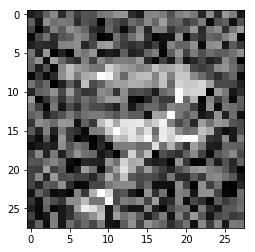

The classification label following attack is 8 from an original classification of 7
The L2 distance of the adversary is 9.448004533344719


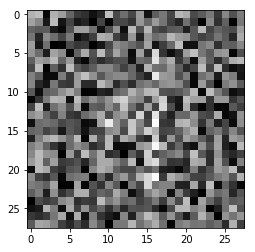

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 11.558748694915053


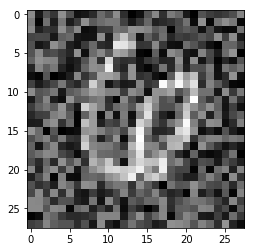

The classification label following attack is 4 from an original classification of 6
The L2 distance of the adversary is 8.762130327343497


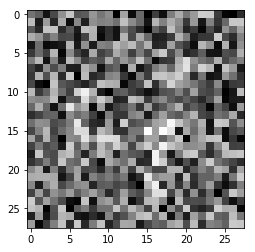

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 11.581830296391557


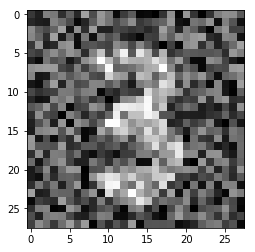

The classification label following attack is 8 from an original classification of 3
The L2 distance of the adversary is 9.89815141386124


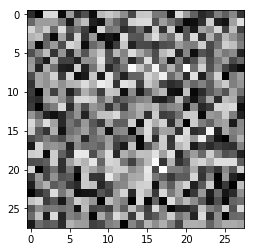

The classification label following attack is 2 from an original classification of 0
The L2 distance of the adversary is 14.112003946257945


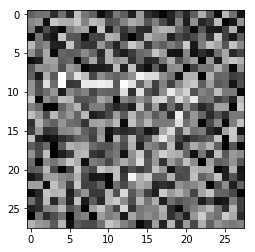

The classification label following attack is 8 from an original classification of 7
The L2 distance of the adversary is 12.596816285198393


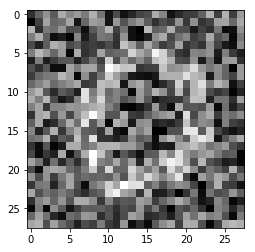

The classification label following attack is 8 from an original classification of 0
The L2 distance of the adversary is 11.15644740029356


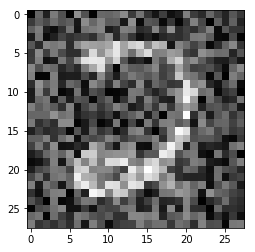

The classification label following attack is 0 from an original classification of 2
The L2 distance of the adversary is 8.60396375467183


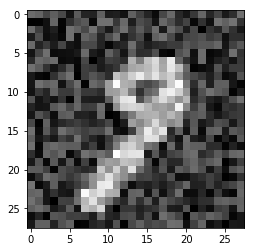

The classification label following attack is 8 from an original classification of 9
The L2 distance of the adversary is 7.09208517943325


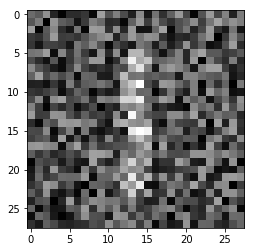

The classification label following attack is 4 from an original classification of 1
The L2 distance of the adversary is 9.855021670474265


In [266]:
adversary_found, adversary_distance, adversary_arrays = evaluate_BlendedUniformNoiseAttack_resistance_CustomModel(
    model_prediction_function=cnn_predictions, model_weights="/MNIST_LeNet5_CNN.ckpt", var_list=var_list_LeNet,
    num_images_to_attack=num_images_to_attack, temp_batch_size=None)

In [267]:
success_ratio = np.sum(adversary_found)/num_images_to_attack
Standard_mean, Standard_var, Standard_std = scipy.stats.bayes_mvs(adversary_distance)

print("The success ratio is " + str(success_ratio))
print("Mean: " + str(Standard_mean))
print("Variance: " + str(Standard_var))
print("Standard deviation: " + str(Standard_std))


The success ratio is 1.0
Mean: Mean(statistic=9.510176574630046, minmax=(9.116315117646574, 9.904038031613519))
Variance: Variance(statistic=4.309732226138489, minmax=(3.2635247556856064, 5.622486746031296))
Standard deviation: Std_dev(statistic=2.0687938912334003, minmax=(1.80652283563912, 2.371178345471149))


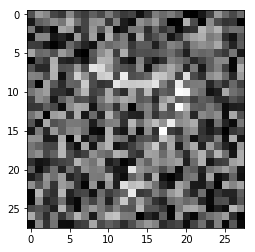

The classification label following attack is 8 from an original classification of 7
The L2 distance of the adversary is 10.931427957529465


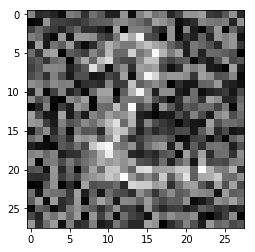

The classification label following attack is 0 from an original classification of 2
The L2 distance of the adversary is 10.19338585407948


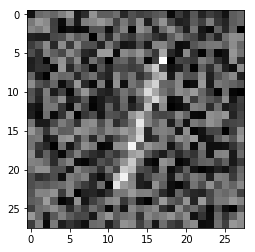

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 9.324088296495637


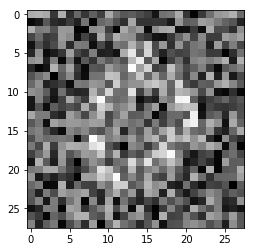

The classification label following attack is 2 from an original classification of 0
The L2 distance of the adversary is 11.046397849621592


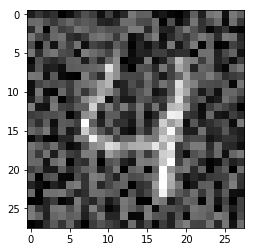

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 7.972106288583642


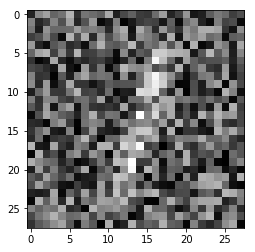

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 11.099735246065004


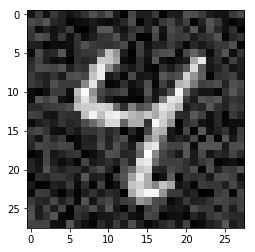

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 5.159497260395026


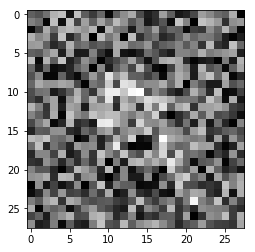

The classification label following attack is 8 from an original classification of 9
The L2 distance of the adversary is 11.655840391208441


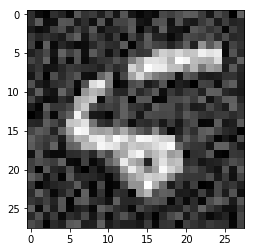

The classification label following attack is 9 from an original classification of 5
The L2 distance of the adversary is 5.982969168988558


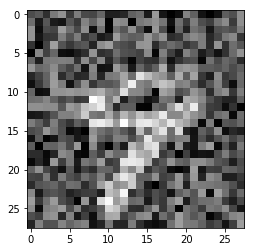

The classification label following attack is 8 from an original classification of 9
The L2 distance of the adversary is 9.766887196083914


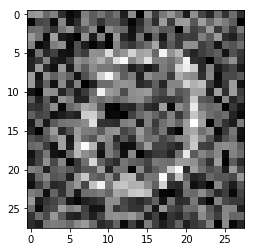

The classification label following attack is 8 from an original classification of 0
The L2 distance of the adversary is 9.758090972712832


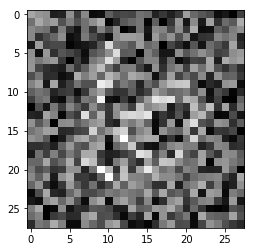

The classification label following attack is 8 from an original classification of 6
The L2 distance of the adversary is 10.422289509004829


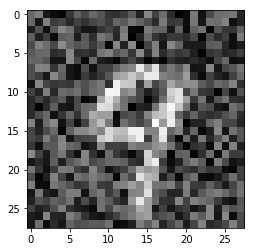

The classification label following attack is 3 from an original classification of 9
The L2 distance of the adversary is 8.04291692780241


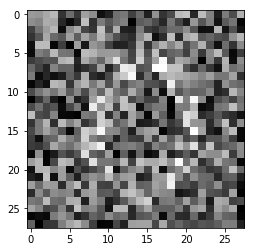

The classification label following attack is 2 from an original classification of 0
The L2 distance of the adversary is 11.67759849191351


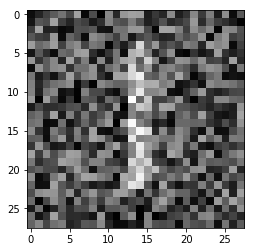

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 10.295520648346745


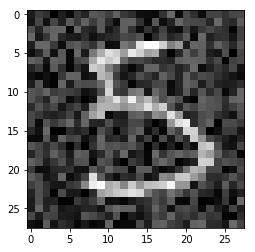

The classification label following attack is 8 from an original classification of 5
The L2 distance of the adversary is 6.322388639782053


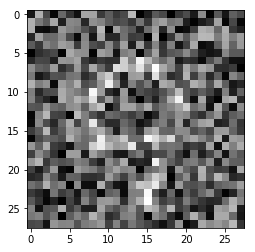

The classification label following attack is 8 from an original classification of 9
The L2 distance of the adversary is 11.165770048763818


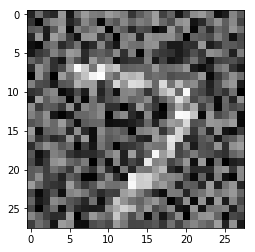

The classification label following attack is 2 from an original classification of 7
The L2 distance of the adversary is 10.092127381546472


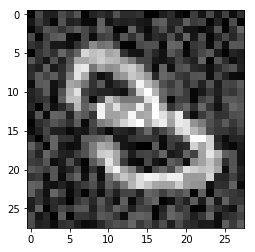

The classification label following attack is 5 from an original classification of 3
The L2 distance of the adversary is 6.252242058921717


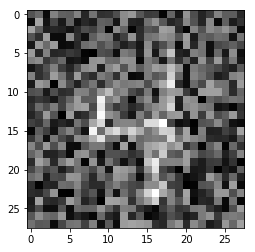

The classification label following attack is 7 from an original classification of 4
The L2 distance of the adversary is 9.916958434399247


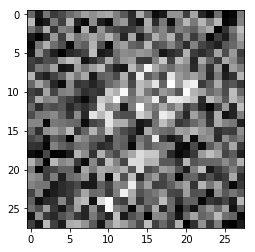

The classification label following attack is 8 from an original classification of 9
The L2 distance of the adversary is 11.517604139871922


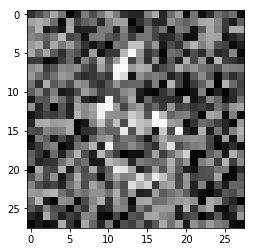

The classification label following attack is 8 from an original classification of 6
The L2 distance of the adversary is 10.964991133951592


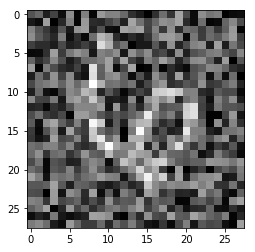

The classification label following attack is 8 from an original classification of 6
The L2 distance of the adversary is 9.677949272531489


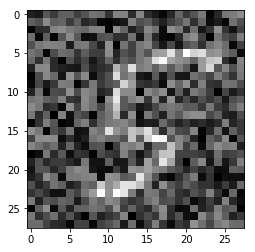

The classification label following attack is 3 from an original classification of 5
The L2 distance of the adversary is 8.864309275117352


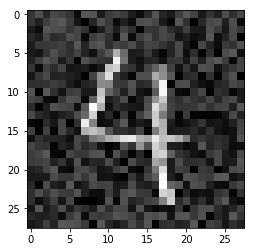

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 5.100118707305516


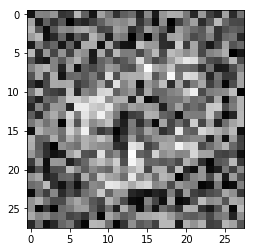

The classification label following attack is 2 from an original classification of 0
The L2 distance of the adversary is 11.888496714851428


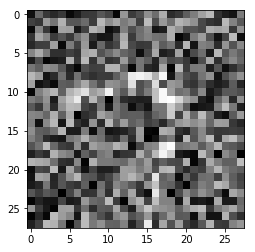

The classification label following attack is 0 from an original classification of 7
The L2 distance of the adversary is 11.135804908012581


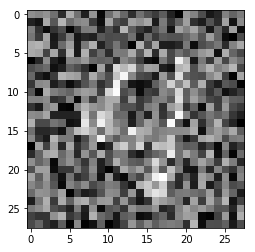

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 10.97638843148977


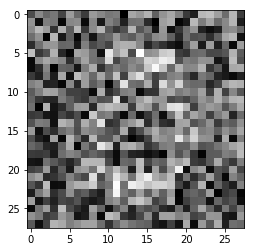

The classification label following attack is 2 from an original classification of 0
The L2 distance of the adversary is 11.74416166916169


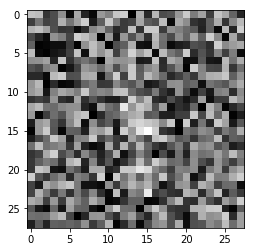

The classification label following attack is 9 from an original classification of 1
The L2 distance of the adversary is 12.461286111417206


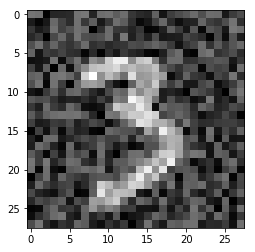

The classification label following attack is 9 from an original classification of 3
The L2 distance of the adversary is 7.552367628324631


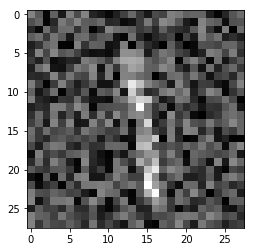

The classification label following attack is 9 from an original classification of 1
The L2 distance of the adversary is 8.62079721080498


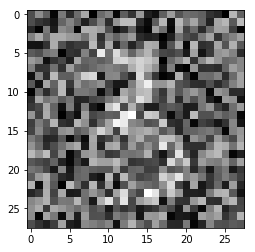

The classification label following attack is 8 from an original classification of 3
The L2 distance of the adversary is 11.574165598674776


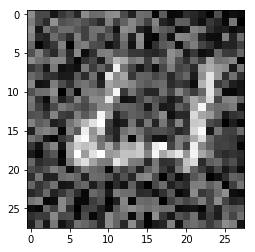

The classification label following attack is 0 from an original classification of 4
The L2 distance of the adversary is 8.297654870526799


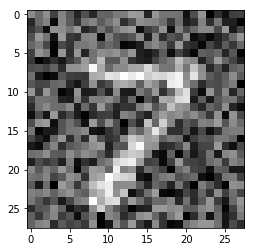

The classification label following attack is 8 from an original classification of 7
The L2 distance of the adversary is 9.893247179021254


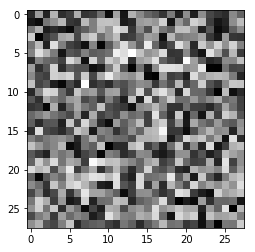

The classification label following attack is 8 from an original classification of 2
The L2 distance of the adversary is 13.525929096808955


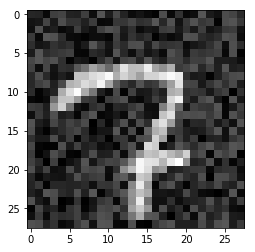

The classification label following attack is 2 from an original classification of 7
The L2 distance of the adversary is 5.316076190513428


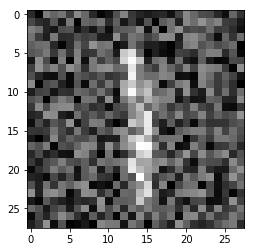

The classification label following attack is 9 from an original classification of 1
The L2 distance of the adversary is 9.15608417078885


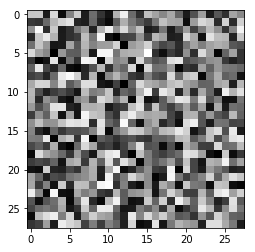

The classification label following attack is 8 from an original classification of 2
The L2 distance of the adversary is 14.540718457273654


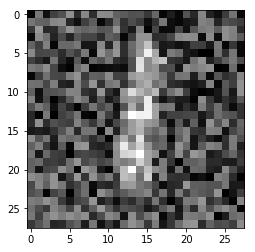

The classification label following attack is 9 from an original classification of 1
The L2 distance of the adversary is 9.375491517810973


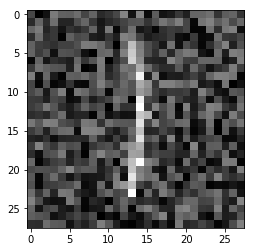

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 7.296704265767999


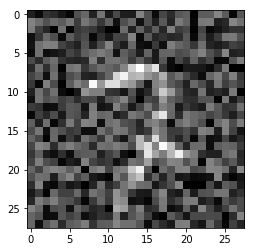

The classification label following attack is 2 from an original classification of 7
The L2 distance of the adversary is 8.316109424619777


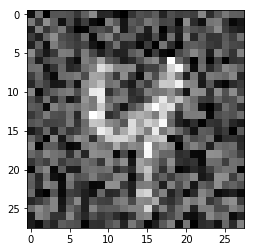

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 8.97303864343434


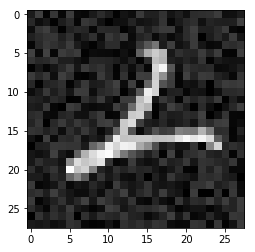

The classification label following attack is 4 from an original classification of 2
The L2 distance of the adversary is 3.9989367625869003


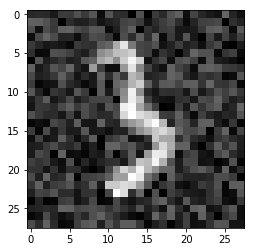

The classification label following attack is 5 from an original classification of 3
The L2 distance of the adversary is 6.033884447121382


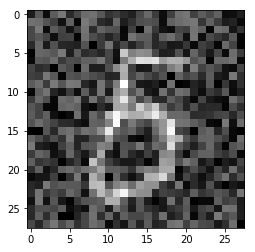

The classification label following attack is 8 from an original classification of 5
The L2 distance of the adversary is 7.453076947546839


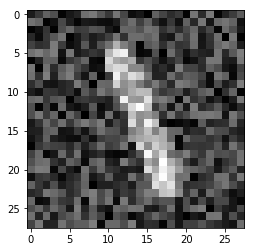

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 7.8109874448481165


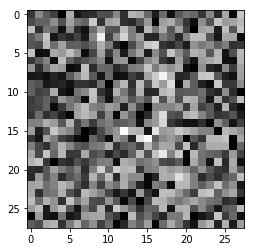

The classification label following attack is 8 from an original classification of 2
The L2 distance of the adversary is 12.133653023532824


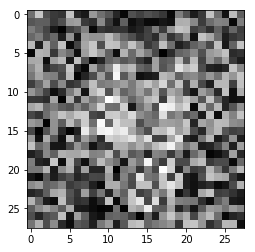

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 12.253737158606063


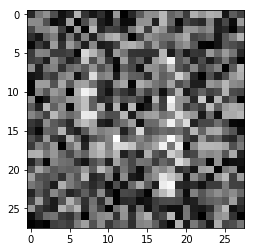

The classification label following attack is 2 from an original classification of 4
The L2 distance of the adversary is 11.169791626341484


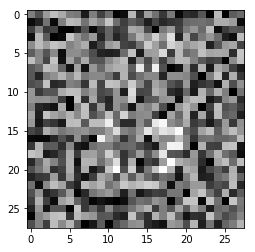

The classification label following attack is 5 from an original classification of 6
The L2 distance of the adversary is 12.27868029252165


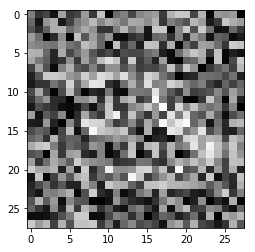

The classification label following attack is 2 from an original classification of 3
The L2 distance of the adversary is 12.2289224766088


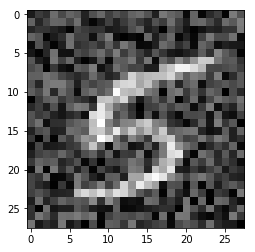

The classification label following attack is 0 from an original classification of 5
The L2 distance of the adversary is 7.32868413429859


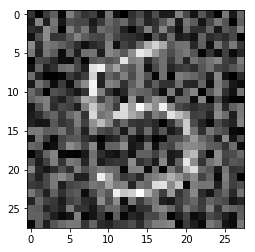

The classification label following attack is 8 from an original classification of 5
The L2 distance of the adversary is 8.097669003989415


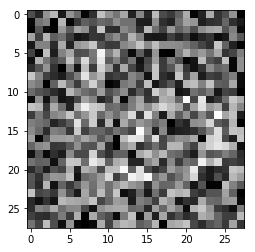

The classification label following attack is 8 from an original classification of 6
The L2 distance of the adversary is 12.041887123466127


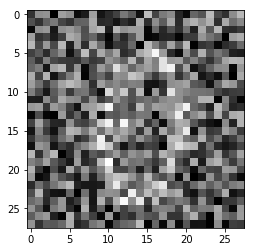

The classification label following attack is 8 from an original classification of 0
The L2 distance of the adversary is 11.363074145414368


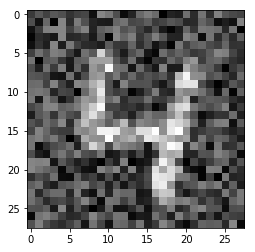

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 8.405247685215807


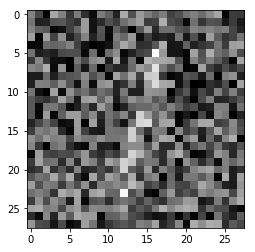

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 10.338297845511018


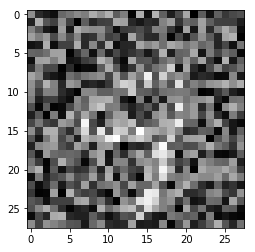

The classification label following attack is 5 from an original classification of 9
The L2 distance of the adversary is 10.799667593774888


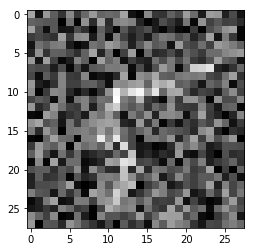

The classification label following attack is 8 from an original classification of 5
The L2 distance of the adversary is 9.547390628970717


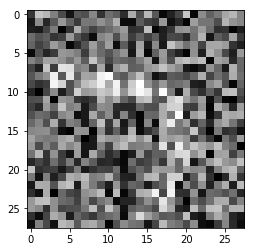

The classification label following attack is 2 from an original classification of 7
The L2 distance of the adversary is 12.071595930914025


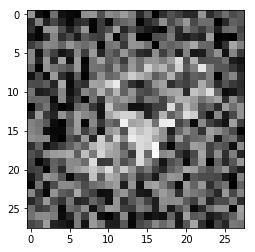

The classification label following attack is 2 from an original classification of 8
The L2 distance of the adversary is 10.18844655891552


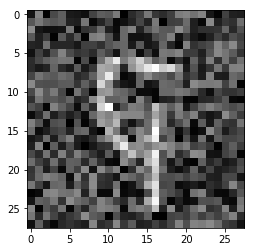

The classification label following attack is 7 from an original classification of 9
The L2 distance of the adversary is 8.104172608486406


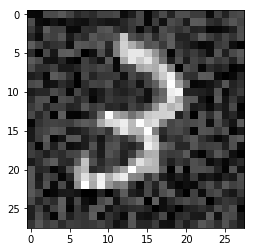

The classification label following attack is 2 from an original classification of 3
The L2 distance of the adversary is 5.818504929797664


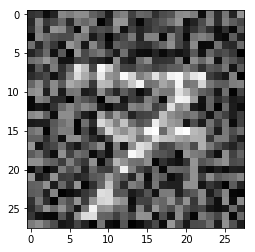

The classification label following attack is 8 from an original classification of 7
The L2 distance of the adversary is 9.160378475238039


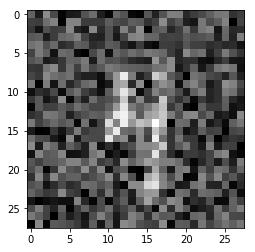

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 8.305289561182173


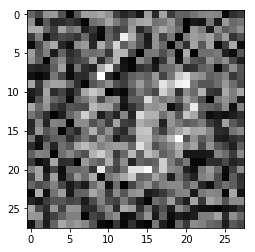

The classification label following attack is 8 from an original classification of 6
The L2 distance of the adversary is 10.336452985483065


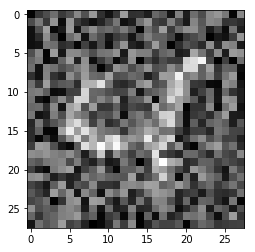

The classification label following attack is 9 from an original classification of 4
The L2 distance of the adversary is 9.661263599067144


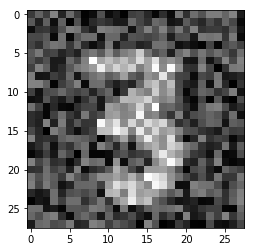

The classification label following attack is 8 from an original classification of 3
The L2 distance of the adversary is 8.320981775088557


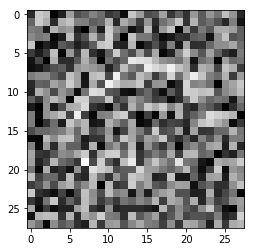

The classification label following attack is 8 from an original classification of 0
The L2 distance of the adversary is 12.37837335525192


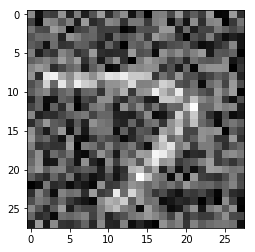

The classification label following attack is 0 from an original classification of 7
The L2 distance of the adversary is 9.86894879178253


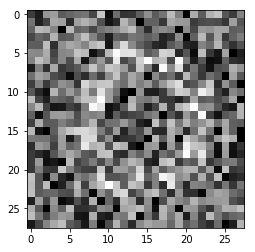

The classification label following attack is 2 from an original classification of 0
The L2 distance of the adversary is 12.145173230988528


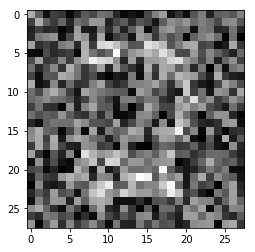

The classification label following attack is 8 from an original classification of 2
The L2 distance of the adversary is 10.503391689845484


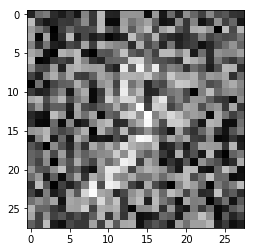

The classification label following attack is 8 from an original classification of 9
The L2 distance of the adversary is 11.957300154013758


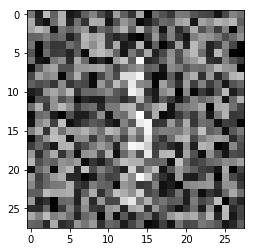

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 11.787430539062603


In [268]:
adversary_found, adversary_distance, adversary_arrays = evaluate_BlendedUniformNoiseAttack_resistance_CustomModel(
    model_prediction_function=cnn_binding_predictions, model_weights="/Binding_CNN.ckpt", var_list=var_list_Binding,
    num_images_to_attack=num_images_to_attack, temp_batch_size=1)

In [269]:
success_ratio = np.sum(adversary_found)/num_images_to_attack
Binding_mean, Binding_var, Binding_std = scipy.stats.bayes_mvs(adversary_distance)

print("The success ratio is " + str(success_ratio))
print("Mean: " + str(Binding_mean))
print("Variance: " + str(Binding_var))
print("Standard deviation: " + str(Binding_std))


The success ratio is 1.0
Mean: Mean(statistic=9.703187010210637, minmax=(9.280362222730336, 10.126011797690937))
Variance: Variance(statistic=4.966886083948747, minmax=(3.76115146906953, 6.4798112065238405))
Standard deviation: Std_dev(statistic=2.2209264752656703, minmax=(1.9393688326539464, 2.5455473294605704))


In [270]:
adversary_found, adversary_distance, adversary_arrays = evaluate_BlendedUniformNoiseAttack_resistance_MadryModel(num_images_to_attack)

The L2 distance of the adversary is 8.131730759854022
The L2 distance of the adversary is 9.163212141445218
The L2 distance of the adversary is 7.746222797572135
The L2 distance of the adversary is 11.183817443029952
The L2 distance of the adversary is 7.712289712833421
The L2 distance of the adversary is 7.8503279280814775
The L2 distance of the adversary is 6.857939108541092
The L2 distance of the adversary is 6.783215399376258
The L2 distance of the adversary is 8.844975573580653
The L2 distance of the adversary is 7.271605656270911
The L2 distance of the adversary is 10.059057010608235
The L2 distance of the adversary is 7.958530224416653
The L2 distance of the adversary is 8.746630060395958
The L2 distance of the adversary is 11.326755399819541
The L2 distance of the adversary is 8.533495007712947
The L2 distance of the adversary is 10.04589392736717
The L2 distance of the adversary is 9.604554696701557
The L2 distance of the adversary is 7.70278876436897
The L2 distance of the ad

In [271]:
success_ratio = np.sum(adversary_found)/num_images_to_attack
Madry_mean, Madry_var, Madry_std = scipy.stats.bayes_mvs(adversary_distance)

print("The success ratio is " + str(success_ratio))
print("Mean: " + str(Madry_mean))
print("Variance: " + str(Madry_var))
print("Standard deviation: " + str(Madry_std))

The success ratio is 1.0
Mean: Mean(statistic=8.73855318361521, minmax=(8.39837518544816, 9.078731181782258))
Variance: Variance(statistic=3.214961402200217, minmax=(2.4345146227460686, 4.1942461676021665))
Standard deviation: Std_dev(statistic=1.7868165367842235, minmax=(1.5602931207776536, 2.0479858807135773))


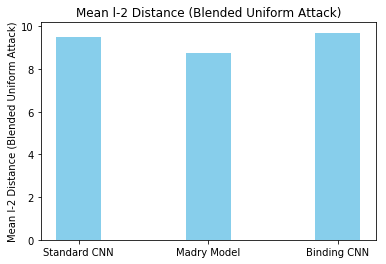

In [272]:
#Results form Blended Uniform attack

model_labels = ('Standard CNN', 'Madry Model', 'Binding CNN')
Blended_distance = np.zeros([1,3])
Blended_distance[0,0] = Standard_mean[0]
Blended_distance[0,1] = Madry_mean[0]
Blended_distance[0,2] = Binding_mean[0]

fig, ax = plt.subplots()
bar_width = 0.35
ax.grid(False)
plt.bar([0, 1, 2], Blended_distance[0,:], bar_width, color='SkyBlue')
plt.xticks([0, 1, 2], model_labels)
plt.ylabel('Mean l-2 Distance (Blended Uniform Attack)')
plt.title('Mean l-2 Distance (Blended Uniform Attack)')
plt.show()

#Visualizaiton of Results

In [0]:
#Overview of the results
#Columns 0:2 correspond to Standard CNN, Madry model, and the binding model respectively
#Rows 0:1 correspond to accuracy against one's own adversarial examples during generation
Boundary_attack_results = np.zeros([2,3])
Boundary_attack_results[0,0] = 1.0 #Standard CNN
Boundary_attack_results[1,0] = 1.591

Boundary_attack_results[0,1] = 1.0 #Madry model
Boundary_attack_results[1,1] = 1.433

Boundary_attack_results[0,2] = 0.24 #Binding model
Boundary_attack_results[1,2] = 8.328


#Columns 0:2 correspond to Standard CNN, Madry model, and the binding model respectively
#Rows 0:2 correspond to performance on adversaries from the Standard CNN, Madry model, and the binding model respectively
Transfer_attack_results = np.zeros([3,3])

Transfer_attack_results[0,0] = 1
Transfer_attack_results[1,0] = 0.333
Transfer_attack_results[2,0] = 0.378

Transfer_attack_results[0,1] = 0.155
Transfer_attack_results[1,1] = 1
Transfer_attack_results[2,1] = 0.267

Transfer_attack_results[0,2] = 0.267
Transfer_attack_results[1,2] = 0.083
Transfer_attack_results[2,2] = 1

Transfer_attack_results = Transfer_attack_results #Normalize the results

model_labels = ('Standard CNN', 'Madry Model', 'Binding CNN')

In [0]:
### *** Boundary attack results with binding net removed

Boundary_attack_results = np.zeros([2,2])
Boundary_attack_results[0,0] = 1.0 #Standard CNN
Boundary_attack_results[1,0] = 1.591

Boundary_attack_results[0,1] = 1.0 #Madry model
Boundary_attack_results[1,1] = 1.433

model_labels = ('Standard CNN', 'Madry Model')

In [0]:
fig, ax = plt.subplots(figsize=(5,5))
bar_width = 0.35
ax.grid(False)
plt.bar([0, 1], Boundary_attack_results[0,:], bar_width, color='IndianRed')
plt.xticks([0, 1], model_labels)
plt.ylabel('Percentage of Adv. Examples Misclassified')
plt.title('Percentage of Adv. Examples Misclassified (Boundary Attack)')
plt.show()

In [0]:
fig, ax = plt.subplots(figsize=(5,5))
bar_width = 0.35
ax.grid(False)
plt.bar([0, 1], Boundary_attack_results[1,:], bar_width, color='SkyBlue')
plt.xticks([0, 1], model_labels)
plt.ylabel('Mean Euclidian Distance for Misclassificaiton')
plt.title('Mean Euclidian Distance for Misclassificaiton (Boundary Attack)')
plt.show()

In [0]:
fig, ax = plt.subplots()
bar_width = 0.5
ax.grid(False)
plt.bar([0, 1, 2], Boundary_attack_results[1,:], bar_width, color='SkyBlue')
plt.xticks([0, 1, 2], model_labels)
plt.ylabel('Mean Euclidian Distance for Misclassificaiton')
plt.title('Mean Euclidian Distance for Misclassificaiton (Boundary Attack)')
plt.show()

In [0]:
n_groups = 3
bar_width = 0.35
#_, ax = plt.subplots()
index = np.arange(n_groups)


plt.figure(figsize=(16,10))
plt.grid(False)
results_Standard_examples = plt.bar(index - bar_width/2, Transfer_attack_results[0,:], bar_width, color='IndianRed', label="Standard Adv. Examples")

results_Madry_examples = plt.bar(index, Transfer_attack_results[1,:], bar_width, label="Madry Adv. Examples")

results_Binding_examples = plt.bar(index + bar_width/2, Transfer_attack_results[2,:], bar_width, color='SkyBlue', label="Binding Adv. Examples")

plt.xticks(index, model_labels)
plt.ylabel('Percentage of Misclassification')
plt.title('Percentage of Misclassification (Transfer Attack)')
plt.legend(loc='upper left', frameon=1)
plt.show()

In [0]:
### mean transfer resistance results


#Columns 0:2 correspond to Standard CNN, Madry model, and the binding model respectively
#Rows 0:2 correspond to performance on adversaries from the Standard CNN, Madry model, and the binding model respectively
Transfer_attack_results = np.zeros([3,3])

Transfer_attack_results[0,0] = 1
Transfer_attack_results[1,0] = 0.333
Transfer_attack_results[2,0] = 0.378

Transfer_attack_results[0,1] = 0.155
Transfer_attack_results[1,1] = 1
Transfer_attack_results[2,1] = 0.267

Transfer_attack_results[0,2] = 0.267
Transfer_attack_results[1,2] = 0.083
Transfer_attack_results[2,2] = 1

Transfer_attack_results = Transfer_attack_results #Normalize the results

model_labels = ('Standard CNN', 'Madry Model', 'Binding CNN')

In [0]:
Transfer_means = np.zeros([1,3])
Transfer_means[0,0] = np.mean(Transfer_attack_results[:,0])
Transfer_means[0,1] = np.mean(Transfer_attack_results[:,1])
Transfer_means[0,2] = np.mean(Transfer_attack_results[:,2])

fig, ax = plt.subplots()
bar_width = 0.35
ax.grid(False)
plt.bar([0, 1, 2], Transfer_means[0,:], bar_width, color='IndianRed')
plt.xticks([0, 1, 2], model_labels)
plt.ylabel('Mean Misclassification (Transfer Attack)')
plt.title('Mean Misclassification (Transfer Attack)')
plt.show()

In [0]:
#Results form Blended Uniform attack

Blended_distance = np.zeros([1,3])
Blended_distance[0,0] = 8.526335774869567
Blended_distance[0,1] = 8.559281853495518
Blended_distance[0,2] = 9.433369523695147

fig, ax = plt.subplots()
bar_width = 0.35
ax.grid(False)
plt.bar([0, 1, 2], Blended_distance[0,:], bar_width, color='SkyBlue')
plt.xticks([0, 1, 2], model_labels)
plt.ylabel('Mean l-2 Distance (Blended Uniform Attack)')
plt.title('Mean l-2 Distance (Blended Uniform Attack)')
plt.show()